# <center> CS F320 Foundations of Data Science <center>

## <center> Assignment <center>

***

### Group 8

#### 1. 2022A7PS0145P - Armaan Gupta
#### 2. 2022A7PS0065P - Animish Tiwari
#### 3. 2022A7PS0164P - Anjaneya Bajaj
#### 4. 2022A7PS0120P - Aryan Jain

***

#### Dataset : [Electrical Grid Stability Simulated Data](https://archive.ics.uci.edu/dataset/471/electrical+grid+stability+simulated+data)

In [1]:
from ucimlrepo import fetch_ucirepo 

import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr
from scipy.spatial.distance import pdist, squareform, cdist
import matplotlib.pyplot as plt
from tabulate import tabulate
import os
import optuna

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score, silhouette_score, pairwise_distances, confusion_matrix

from sklearn_extra.cluster import KMedoids

from xgboost import XGBRegressor
from ngboost import NGBRegressor

import torch
import torch.nn as nn
import torch.optim as optim

/Users/anjaneyabajaj/anaconda3/envs/ML_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Setting seeds for reproducibility of experiments

np.random.seed(42)
torch.manual_seed(42)

## Loading in the dataset and pre-processing

- We will first load in the dataset and take a look at the first few rows to understand the data better.
- We will then check for any missing values - there are none.
- As per the question, we will drop categorical columns - there are None.
- Eliminating outliers - any value that is more than 3 standard deviations away from the mean will be considered an outlier and will be removed.
- Making plots to visualize the data distributions and a heatmap to visualize the correlation between the features.
- Separating the two target variables one for classification and one for regression.
- Splitting the data into training and testing sets.
- Applying PCA, taking 10 principal components to account for >95% variance.

In [3]:
# Fetching dataset from uciml repository

electrical_grid_stability_simulated_data = fetch_ucirepo(id=471) 
  
# data (as pandas dataframes) 
X = electrical_grid_stability_simulated_data.data.features 
y = electrical_grid_stability_simulated_data.data.targets 
  
# metadata 
print(electrical_grid_stability_simulated_data.metadata) 
  
# variable information 
print(electrical_grid_stability_simulated_data.variables) 


{'uci_id': 471, 'name': 'Electrical Grid Stability Simulated Data ', 'repository_url': 'https://archive.ics.uci.edu/dataset/471/electrical+grid+stability+simulated+data', 'data_url': 'https://archive.ics.uci.edu/static/public/471/data.csv', 'abstract': 'The local stability analysis of the 4-node star system (electricity producer is in the center) implementing Decentral Smart Grid Control concept. ', 'area': 'Physics and Chemistry', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Multivariate'], 'num_instances': 10000, 'num_features': 12, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['stab', 'stabf'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2018, 'last_updated': 'Tue Jan 09 2024', 'dataset_doi': '10.24432/C5PG66', 'creators': ['Vadim Arzamasov'], 'intro_paper': None, 'additional_info': {'summary': "The analysis is performed for different sets of input values using the methodology similar to

In [4]:
# Concatenate features and target into a single dataframe

df = pd.concat([X, y], axis=1)

In [5]:
# Saving the dataset to a csv file

# df.to_csv('electrical_grid_stability_simulated_data.csv', index=False)

In [6]:
# Seeing some descriptive statistics of the dataset

df.describe()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5.250000,5.250001,5.250004,5.249997,3.750000,-1.250000,-1.250000,-1.250000,0.525000,0.525000,0.525000,0.525000,0.015731
std,2.742548,2.742549,2.742549,2.742556,0.752160,0.433035,0.433035,0.433035,0.274256,0.274255,0.274255,0.274255,0.036919
min,0.500793,0.500141,0.500788,0.500473,1.582590,-1.999891,-1.999945,-1.999926,0.050009,0.050053,0.050054,0.050028,-0.080760
25%,2.874892,2.875140,2.875522,2.874950,3.218300,-1.624901,-1.625025,-1.624960,0.287521,0.287552,0.287514,0.287494,-0.015557
50%,5.250004,5.249981,5.249979,5.249734,3.751025,-1.249966,-1.249974,-1.250007,0.525009,0.525003,0.525015,0.525002,0.017142
75%,7.624690,7.624893,7.624948,7.624838,4.282420,-0.874977,-0.875043,-0.875065,0.762435,0.762490,0.762440,0.762433,0.044878
max,9.999469,9.999837,9.999450,9.999443,5.864418,-0.500108,-0.500072,-0.500025,0.999937,0.999944,0.999982,0.999930,0.109403


In [7]:
# Checking for missing values and data types of the columns

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tau1    10000 non-null  float64
 1   tau2    10000 non-null  float64
 2   tau3    10000 non-null  float64
 3   tau4    10000 non-null  float64
 4   p1      10000 non-null  float64
 5   p2      10000 non-null  float64
 6   p3      10000 non-null  float64
 7   p4      10000 non-null  float64
 8   g1      10000 non-null  float64
 9   g2      10000 non-null  float64
 10  g3      10000 non-null  float64
 11  g4      10000 non-null  float64
 12  stab    10000 non-null  float64
 13  stabf   10000 non-null  object 
dtypes: float64(13), object(1)
memory usage: 1.1+ MB


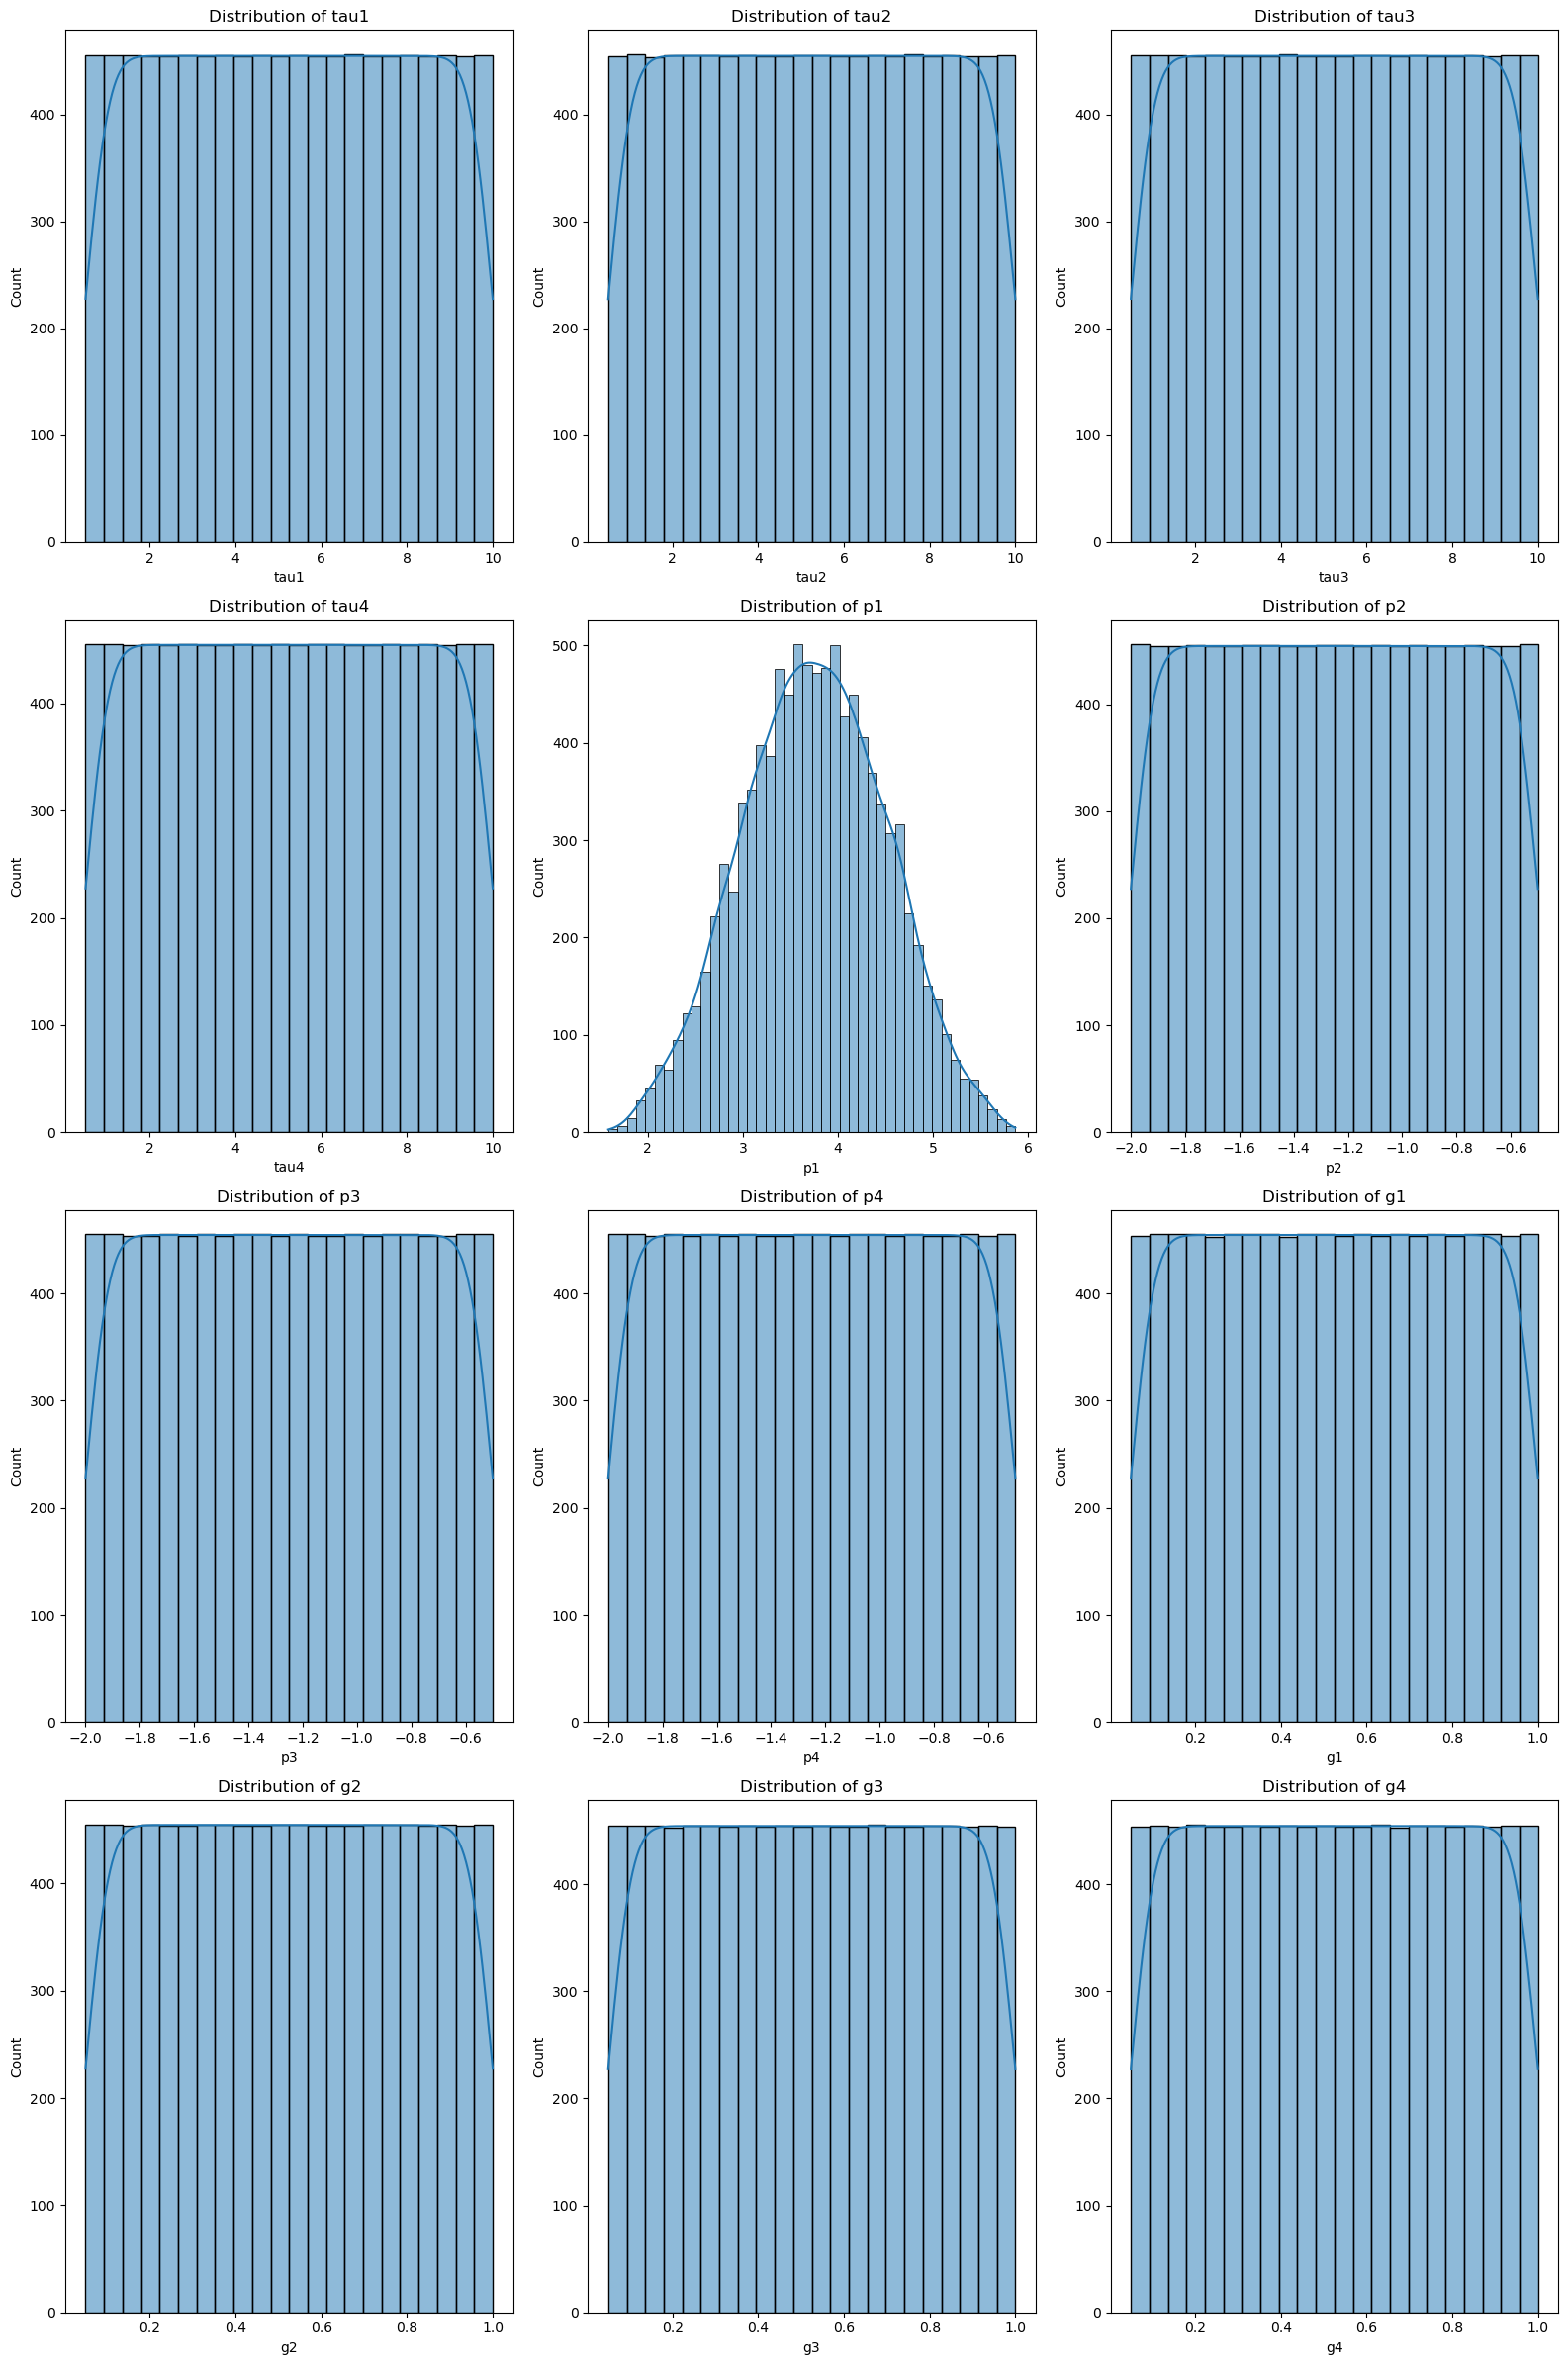

In [8]:
# Plotting the distribution of all numeric columns

numeric_columns = df.drop(columns=['stab', 'stabf']).columns

num_plots = len(numeric_columns)
num_cols = 3
num_rows = (num_plots // num_cols) + (1 if num_plots % num_cols != 0 else 0) 

fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 6*num_rows))
axes = axes.flatten()  

for i, col in enumerate(numeric_columns):
    sns.histplot(df[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')

plt.tight_layout()
plt.show()


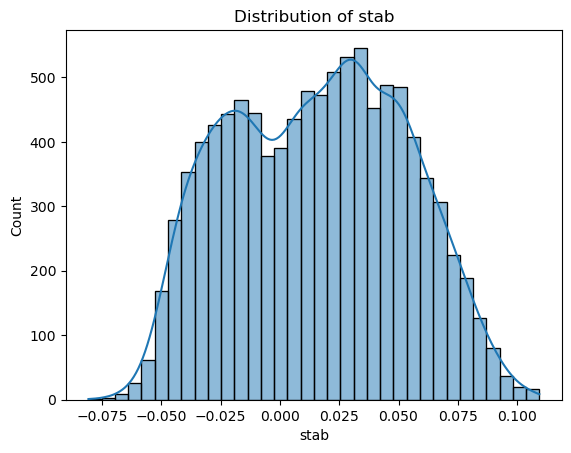

In [9]:
# Plot for target variable 'stab'

sns.histplot(df['stab'], kde=True)
plt.title('Distribution of stab')
plt.xlabel('stab')
plt.show()

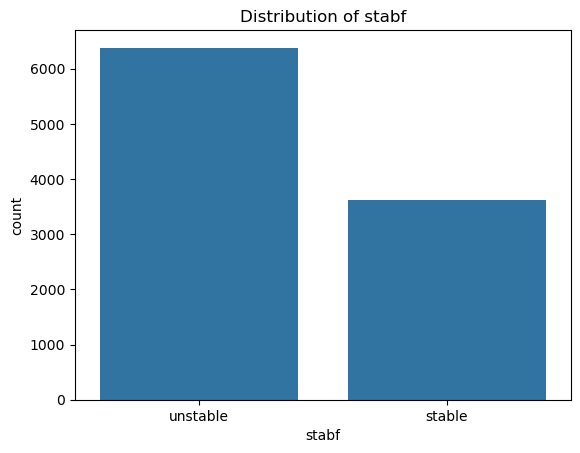

In [10]:
# Plot for target variable 'stabf'

sns.countplot(x='stabf', data=df)
plt.title('Distribution of stabf')
plt.show()

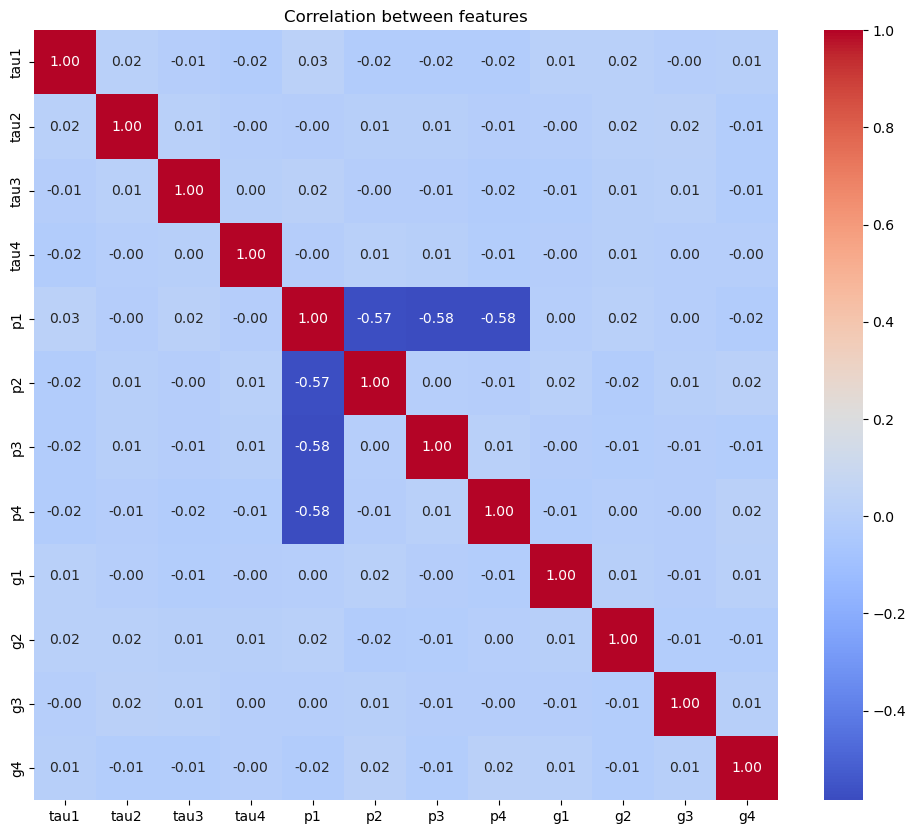

In [11]:
# Heatmap for correlation between features

corr = X.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Correlation between features')
plt.show()

In [12]:
# Splitting the data into features and target - separate targets for classification and regression

X = df.drop(['stab', 'stabf'], axis=1)
y = df['stab']
y_classification = df['stabf']

In [13]:
# Removing outliers in all columns

X = X[(np.abs(stats.zscore(X)) < 3).all(axis=1)] 
y = y[(np.abs(stats.zscore(y)) < 3)]

In [14]:
# Creating the train and test sets - seperate sets for classification and regression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_classification, X_test_classification, y_train_classification, y_test_classification = train_test_split(X, y_classification, test_size=0.2, random_state=42)

In [15]:
# Using label encoder to encode the target labels for classification

label_encoder = LabelEncoder()

y_train_classification_encoded = label_encoder.fit_transform(y_train_classification)
y_test_classification_encoded = label_encoder.transform(y_test_classification)

In [16]:
# Printing the classes and their corresponding encoded values

for i, class_ in enumerate(label_encoder.classes_):
    print(f'{class_} -> {i}')

stable -> 0
unstable -> 1


In [17]:
# Scaling and performing PCA on the features for regression

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [18]:
# Scaling and performing PCA on the features for classification

scaler = StandardScaler()
X_train_classification_scaled = scaler.fit_transform(X_train_classification)
X_test_classification_scaled = scaler.transform(X_test_classification)

pca = PCA()
X_train_classification_pca = pca.fit_transform(X_train_classification_scaled)
X_test_classification_pca = pca.transform(X_test_classification_scaled)

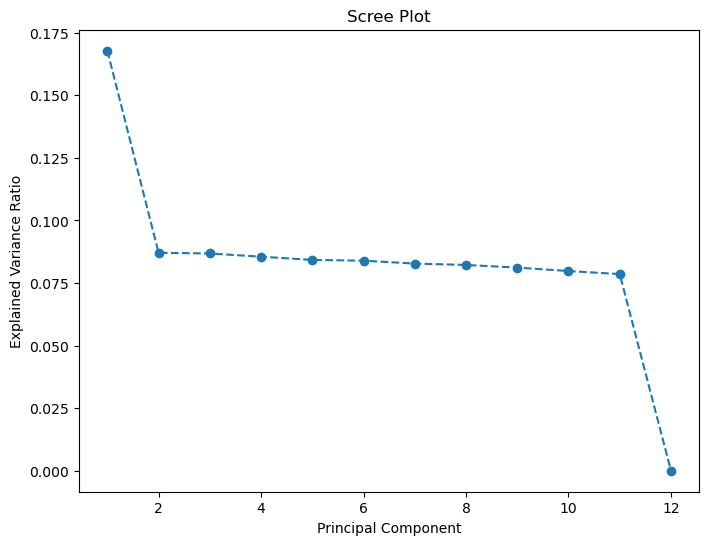

In [19]:
# Explained variance ratio using a scree plot

explained_variance = pca.explained_variance_ratio_

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.show()

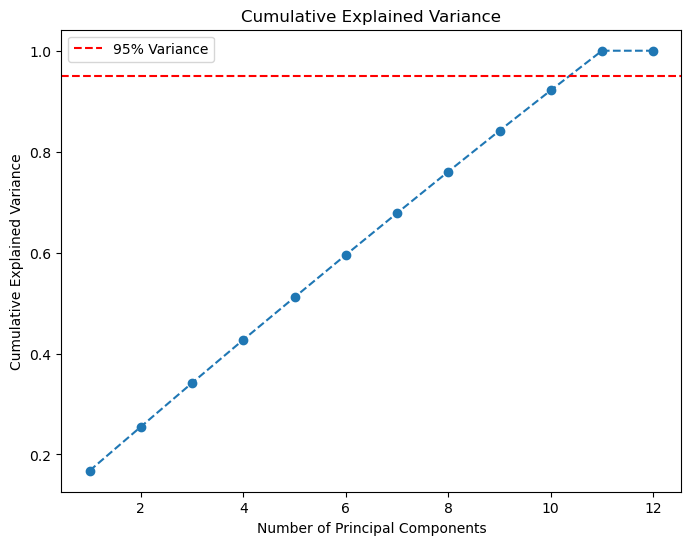

In [20]:
# Cumulative explained variance 

cumulative_variance = pca.explained_variance_ratio_.cumsum()

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
plt.legend()
plt.show()


In [21]:
# Based on plots, extracting 10 principal components

X_train_pca = X_train_pca[:, :10]
X_test_pca = X_test_pca[:, :10]

X_train_classification_pca = X_train_classification_pca[:, :10]
X_test_classification_pca = X_test_classification_pca[:, :10]

## Regression Models

Applying various regression models and calculating RMSE and MAE for each model. Models applied :
- Linear Regression
- Random Forests
- Extra Random Trees
- AdaBoost
- XGBoost
- NGBoost
- Neural Network

In [ ]:
# Code to train all regression models and evaluate them

# List of regression models to evaluate
models = [
            "Linear Regression",
            "Ridge Regression",
            "Lasso Regression",
            "Elastic Net",
            "Random Forest",
            "Extra Trees",
            "AdaBoost",
            "XGBoost",
            "NGBoost"
         ]

# Objective function for Optuna hyperparameter tuning
def objective(trial, model_name, X_train, y_train):
    if model_name == "Linear Regression":
        model = LinearRegression()
    elif model_name == "Ridge Regression":
        model = Ridge(
            alpha=trial.suggest_float("alpha", 1e-4, 100.0, log=True),
            max_iter=trial.suggest_int("max_iter", 100, 2000)
        )
    elif model_name == "Lasso Regression":
        model = Lasso(
            alpha=trial.suggest_float("alpha", 1e-4, 100.0, log=True),  
            max_iter=trial.suggest_int("max_iter", 100, 2000)           
        )
    elif model_name == "Elastic Net":
        model = ElasticNet(
            alpha=trial.suggest_float("alpha", 1e-4, 100.0, log=True),  
            l1_ratio=trial.suggest_float("l1_ratio", 0.0, 1.0),         
            max_iter=trial.suggest_int("max_iter", 100, 2000)           
        )
    elif model_name == "Random Forest":
        model = RandomForestRegressor(
            n_estimators=trial.suggest_int("n_estimators", 50, 500),
            max_depth=trial.suggest_int("max_depth", 3, 20),
            min_samples_split=trial.suggest_int("min_samples_split", 2, 20),
            min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 20),
            random_state=42,
        )
    elif model_name == "Extra Trees":
        model = ExtraTreesRegressor(
            n_estimators=trial.suggest_int("n_estimators", 50, 500),
            max_depth=trial.suggest_int("max_depth", 3, 20),
            min_samples_split=trial.suggest_int("min_samples_split", 2, 20),
            min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 20),
            random_state=42,
        )
    elif model_name == "AdaBoost":
        model = AdaBoostRegressor(
            n_estimators=trial.suggest_int("n_estimators", 50, 500),
            learning_rate=trial.suggest_float("learning_rate", 0.001, 1.0),
            random_state=42,
        )
    elif model_name == "XGBoost":
        model = XGBRegressor(
            n_estimators=trial.suggest_int("n_estimators", 50, 500),
            max_depth=trial.suggest_int("max_depth", 3, 20),
            learning_rate=trial.suggest_float("learning_rate", 0.01, 1),
            colsample_bytree=trial.suggest_float("colsample_bytree", 0.5, 1.0),
            random_state=42,
            objective='reg:squarederror',
        )
    elif model_name == "NGBoost":
        model = NGBRegressor(
            n_estimators=trial.suggest_int("n_estimators", 50, 500),
            learning_rate=trial.suggest_float("learning_rate", 0.01, 0.3),
            random_state=42,
        )
    else:
        raise ValueError(f"Unknown model: {model_name}")

    # Cross-validation to evaluate performance
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring="neg_mean_squared_error")
    return np.sqrt(-scores.mean())

# Tuning models using Optuna
def tune_model(model_name, X_train, y_train):
    study = optuna.create_study(direction="minimize")
    study.optimize(lambda trial: objective(trial, model_name, X_train, y_train), n_trials=50)
    return study.best_params, study.best_value

# Training the models with the best hyperparameters obtained from Optuna study
def train_model_with_best_params(model_name, best_params, X_train, y_train):
    if model_name == "Linear Regression":
        model = LinearRegression()
    elif model_name == "Ridge Regression":
        model = Ridge(**best_params)
    elif model_name == "Lasso Regression":
        model = Lasso(**best_params)
    elif model_name == "Elastic Net":
        model = ElasticNet(**best_params)
    elif model_name == "Random Forest":
        model = RandomForestRegressor(**best_params)
    elif model_name == "Extra Trees":
        model = ExtraTreesRegressor(**best_params)
    elif model_name == "AdaBoost":
        model = AdaBoostRegressor(**best_params)
    elif model_name == "XGBoost":
        model = XGBRegressor(**best_params)
    elif model_name == "NGBoost":
        model = NGBRegressor(**best_params)
    else:
        raise ValueError(f"Unknown model: {model_name}")
    
    print(f"Training {model_name} with best hyperparameters...")
    print(f"Best hyperparameters: {best_params}")

    model.fit(X_train, y_train)
    return model

# Plotting predicted vs actual values to help evaluate the model
def plot_predicted_vs_actual(y_pred, y_test, model_name, image_path):
    plt.figure(figsize=(8, 8))
    plt.scatter(
        y_test, y_pred, 
        alpha=0.6, color="blue", marker='o', label="Predicted Values"
    )

    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             "r--", label="Ideal: Predicted = Actual")

    plt.title(f"Predicted vs Actual Values: {model_name}")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.legend()
    plt.grid()

    if os.path.exists(image_path) == False:
        os.makedirs(image_path)
    plot_name = os.path.join(image_path, f"{model_name}_regression.png")
    plt.savefig(plot_name)
    print(f"Predicted vs Actual plot saved as: {plot_name}")
    plt.close()

# Training models with optimized parameters and evaluating them
def regression_models_optimized(X_train, X_test, y_train, y_test, models, image_path):
    model_results = []
    model_params = []
    for model_name in models:
        print(f"Tuning hyperparameters for {model_name}...")
        best_params, best_score = tune_model(model_name, X_train, y_train)
        print(f"Best parameters for {model_name}: {best_params}")
        
        tuned_model = train_model_with_best_params(model_name, best_params, X_train, y_train)
        
        y_pred = tuned_model.predict(X_test)
        
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        
        plot_predicted_vs_actual(y_pred, y_test, model_name, image_path)

        model_results.append({"Model": model_name, "RMSE": rmse, "MAE": mae})
        model_params.append({"Model": model_name, "Best Parameters": best_params})
    
    results_df = pd.DataFrame(model_results)
    params_df = pd.DataFrame(model_params)
    return results_df, params_df


In [ ]:
# Training and evaluating regression models on original dataset

results_original, params_original = regression_models_optimized(X_train, X_test, y_train, y_test, models, "./original_regression_plots")

[I 2024-11-19 20:14:37,760] A new study created in memory with name: no-name-7cf71190-0284-477e-a247-5a3f41947f9e
[I 2024-11-19 20:14:37,799] Trial 0 finished with value: 0.0219770630226563 and parameters: {}. Best is trial 0 with value: 0.0219770630226563.
[I 2024-11-19 20:14:37,835] Trial 1 finished with value: 0.0219770630226563 and parameters: {}. Best is trial 0 with value: 0.0219770630226563.
[I 2024-11-19 20:14:37,875] Trial 2 finished with value: 0.0219770630226563 and parameters: {}. Best is trial 0 with value: 0.0219770630226563.
[I 2024-11-19 20:14:37,914] Trial 3 finished with value: 0.0219770630226563 and parameters: {}. Best is trial 0 with value: 0.0219770630226563.
[I 2024-11-19 20:14:37,957] Trial 4 finished with value: 0.0219770630226563 and parameters: {}. Best is trial 0 with value: 0.0219770630226563.


Tuning hyperparameters for Linear Regression...


[I 2024-11-19 20:14:37,997] Trial 5 finished with value: 0.0219770630226563 and parameters: {}. Best is trial 0 with value: 0.0219770630226563.
[I 2024-11-19 20:14:38,036] Trial 6 finished with value: 0.0219770630226563 and parameters: {}. Best is trial 0 with value: 0.0219770630226563.
[I 2024-11-19 20:14:38,074] Trial 7 finished with value: 0.0219770630226563 and parameters: {}. Best is trial 0 with value: 0.0219770630226563.
[I 2024-11-19 20:14:38,109] Trial 8 finished with value: 0.0219770630226563 and parameters: {}. Best is trial 0 with value: 0.0219770630226563.
[I 2024-11-19 20:14:38,144] Trial 9 finished with value: 0.0219770630226563 and parameters: {}. Best is trial 0 with value: 0.0219770630226563.
[I 2024-11-19 20:14:38,178] Trial 10 finished with value: 0.0219770630226563 and parameters: {}. Best is trial 0 with value: 0.0219770630226563.
[I 2024-11-19 20:14:38,212] Trial 11 finished with value: 0.0219770630226563 and parameters: {}. Best is trial 0 with value: 0.02197706

Best parameters for Linear Regression: {}
Training Linear Regression with best hyperparameters...
Best hyperparameters: {}


[I 2024-11-19 20:14:39,788] A new study created in memory with name: no-name-1a3a14e1-a977-472a-84e8-11cc4d5b9d97
[I 2024-11-19 20:14:39,823] Trial 0 finished with value: 0.02198390235200819 and parameters: {'alpha': 0.0003583723945018918, 'max_iter': 836}. Best is trial 0 with value: 0.02198390235200819.
[I 2024-11-19 20:14:39,857] Trial 1 finished with value: 0.021983902351826276 and parameters: {'alpha': 0.00036470261147243904, 'max_iter': 1926}. Best is trial 1 with value: 0.021983902351826276.
[I 2024-11-19 20:14:39,890] Trial 2 finished with value: 0.02198390169704699 and parameters: {'alpha': 0.024018890863705455, 'max_iter': 547}. Best is trial 2 with value: 0.02198390169704699.
[I 2024-11-19 20:14:39,922] Trial 3 finished with value: 0.021983902334639944 and parameters: {'alpha': 0.00096331552754683, 'max_iter': 966}. Best is trial 2 with value: 0.02198390169704699.
[I 2024-11-19 20:14:39,955] Trial 4 finished with value: 0.02198390226983386 and parameters: {'alpha': 0.0032306

Predicted vs Actual plot saved as: ./original_regression_plots/Linear Regression_regression.png
Tuning hyperparameters for Ridge Regression...


[I 2024-11-19 20:14:40,021] Trial 6 finished with value: 0.02198390158480474 and parameters: {'alpha': 0.02826464798994564, 'max_iter': 1891}. Best is trial 6 with value: 0.02198390158480474.
[I 2024-11-19 20:14:40,054] Trial 7 finished with value: 0.021983901074476644 and parameters: {'alpha': 0.04839695231791112, 'max_iter': 284}. Best is trial 7 with value: 0.021983901074476644.
[I 2024-11-19 20:14:40,087] Trial 8 finished with value: 0.021983902238702252 and parameters: {'alpha': 0.004325600698011505, 'max_iter': 1034}. Best is trial 7 with value: 0.021983901074476644.
[I 2024-11-19 20:14:40,120] Trial 9 finished with value: 0.02198390231289345 and parameters: {'alpha': 0.0017223642395286895, 'max_iter': 1932}. Best is trial 7 with value: 0.021983901074476644.
[I 2024-11-19 20:14:40,165] Trial 10 finished with value: 0.022035865629270675 and parameters: {'alpha': 37.15597824001104, 'max_iter': 146}. Best is trial 7 with value: 0.021983901074476644.
[I 2024-11-19 20:14:40,209] Trial

Best parameters for Ridge Regression: {'alpha': 0.33123310836439385, 'max_iter': 1713}
Training Ridge Regression with best hyperparameters...
Best hyperparameters: {'alpha': 0.33123310836439385, 'max_iter': 1713}


[I 2024-11-19 20:14:42,343] A new study created in memory with name: no-name-36eafaf7-cd4f-465b-9c86-b83874d491d4
[I 2024-11-19 20:14:42,378] Trial 0 finished with value: 0.036941549478102256 and parameters: {'alpha': 1.3148556698657652, 'max_iter': 1272}. Best is trial 0 with value: 0.036941549478102256.
[I 2024-11-19 20:14:42,413] Trial 1 finished with value: 0.022684319039600057 and parameters: {'alpha': 0.0007678038154349992, 'max_iter': 695}. Best is trial 1 with value: 0.022684319039600057.
[I 2024-11-19 20:14:42,446] Trial 2 finished with value: 0.036941549478102256 and parameters: {'alpha': 1.0232152068013507, 'max_iter': 1249}. Best is trial 1 with value: 0.022684319039600057.
[I 2024-11-19 20:14:42,480] Trial 3 finished with value: 0.036941549478102256 and parameters: {'alpha': 15.409208796699506, 'max_iter': 1346}. Best is trial 1 with value: 0.022684319039600057.
[I 2024-11-19 20:14:42,513] Trial 4 finished with value: 0.036941549478102256 and parameters: {'alpha': 0.195950

Predicted vs Actual plot saved as: ./original_regression_plots/Ridge Regression_regression.png
Tuning hyperparameters for Lasso Regression...


[I 2024-11-19 20:14:42,549] Trial 5 finished with value: 0.022020095455876642 and parameters: {'alpha': 0.00018002520796228086, 'max_iter': 1221}. Best is trial 5 with value: 0.022020095455876642.
[I 2024-11-19 20:14:42,582] Trial 6 finished with value: 0.036941549478102256 and parameters: {'alpha': 0.10391559828458419, 'max_iter': 1408}. Best is trial 5 with value: 0.022020095455876642.
[I 2024-11-19 20:14:42,616] Trial 7 finished with value: 0.036941549478102256 and parameters: {'alpha': 0.20649993364680352, 'max_iter': 971}. Best is trial 5 with value: 0.022020095455876642.
[I 2024-11-19 20:14:42,649] Trial 8 finished with value: 0.036941549478102256 and parameters: {'alpha': 15.007153818932816, 'max_iter': 1610}. Best is trial 5 with value: 0.022020095455876642.
[I 2024-11-19 20:14:42,682] Trial 9 finished with value: 0.036941549478102256 and parameters: {'alpha': 0.1587089395554423, 'max_iter': 177}. Best is trial 5 with value: 0.022020095455876642.
[I 2024-11-19 20:14:42,729] Tri

Best parameters for Lasso Regression: {'alpha': 0.00010161422079013496, 'max_iter': 1689}
Training Lasso Regression with best hyperparameters...
Best hyperparameters: {'alpha': 0.00010161422079013496, 'max_iter': 1689}


[I 2024-11-19 20:14:44,935] A new study created in memory with name: no-name-5e964590-d76c-42db-9988-f650e2c1e7fb
[I 2024-11-19 20:14:44,970] Trial 0 finished with value: 0.036941549478102256 and parameters: {'alpha': 0.2046039278727414, 'l1_ratio': 0.8322149141927795, 'max_iter': 1275}. Best is trial 0 with value: 0.036941549478102256.
[I 2024-11-19 20:14:45,005] Trial 1 finished with value: 0.0346296634280481 and parameters: {'alpha': 0.025752321247602652, 'l1_ratio': 0.8631930082480248, 'max_iter': 837}. Best is trial 1 with value: 0.0346296634280481.
[I 2024-11-19 20:14:45,040] Trial 2 finished with value: 0.03383284213374491 and parameters: {'alpha': 0.04461616749720718, 'l1_ratio': 0.44335317731878765, 'max_iter': 462}. Best is trial 2 with value: 0.03383284213374491.
[I 2024-11-19 20:14:45,079] Trial 3 finished with value: 0.036941549478102256 and parameters: {'alpha': 0.21200166319515923, 'l1_ratio': 0.7953831771556172, 'max_iter': 205}. Best is trial 2 with value: 0.0338328421

Predicted vs Actual plot saved as: ./original_regression_plots/Lasso Regression_regression.png
Tuning hyperparameters for Elastic Net...


[I 2024-11-19 20:14:45,151] Trial 5 finished with value: 0.036941549478102256 and parameters: {'alpha': 0.3826877601464609, 'l1_ratio': 0.4770493108995888, 'max_iter': 212}. Best is trial 4 with value: 0.03212822659946334.
[I 2024-11-19 20:14:45,186] Trial 6 finished with value: 0.02198459134487447 and parameters: {'alpha': 0.00015048663321391646, 'l1_ratio': 0.2780017214298054, 'max_iter': 1198}. Best is trial 6 with value: 0.02198459134487447.
[I 2024-11-19 20:14:45,220] Trial 7 finished with value: 0.036941549478102256 and parameters: {'alpha': 1.9766873189737437, 'l1_ratio': 0.9845168935001961, 'max_iter': 836}. Best is trial 6 with value: 0.02198459134487447.
[I 2024-11-19 20:14:45,255] Trial 8 finished with value: 0.03072233906225498 and parameters: {'alpha': 0.005295469461406285, 'l1_ratio': 0.794129988967784, 'max_iter': 359}. Best is trial 6 with value: 0.02198459134487447.
[I 2024-11-19 20:14:45,290] Trial 9 finished with value: 0.021991628640100784 and parameters: {'alpha': 

Best parameters for Elastic Net: {'alpha': 0.00011361696779397119, 'l1_ratio': 0.1333933047572402, 'max_iter': 1804}
Training Elastic Net with best hyperparameters...
Best hyperparameters: {'alpha': 0.00011361696779397119, 'l1_ratio': 0.1333933047572402, 'max_iter': 1804}


[I 2024-11-19 20:14:47,731] A new study created in memory with name: no-name-55b5faea-797c-47da-ba67-b633bf9f3b0f


Predicted vs Actual plot saved as: ./original_regression_plots/Elastic Net_regression.png
Tuning hyperparameters for Random Forest...


[I 2024-11-19 20:16:47,283] Trial 0 finished with value: 0.01372756428540976 and parameters: {'n_estimators': 376, 'max_depth': 12, 'min_samples_split': 20, 'min_samples_leaf': 15}. Best is trial 0 with value: 0.01372756428540976.
[I 2024-11-19 20:18:06,925] Trial 1 finished with value: 0.012457405122947882 and parameters: {'n_estimators': 201, 'max_depth': 14, 'min_samples_split': 13, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.012457405122947882.
[I 2024-11-19 20:20:19,300] Trial 2 finished with value: 0.012866222386170799 and parameters: {'n_estimators': 359, 'max_depth': 12, 'min_samples_split': 19, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.012457405122947882.
[I 2024-11-19 20:20:41,850] Trial 3 finished with value: 0.01400863748259346 and parameters: {'n_estimators': 73, 'max_depth': 17, 'min_samples_split': 10, 'min_samples_leaf': 17}. Best is trial 1 with value: 0.012457405122947882.
[I 2024-11-19 20:22:05,163] Trial 4 finished with value: 0.014210863598322

Best parameters for Random Forest: {'n_estimators': 291, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 1}
Training Random Forest with best hyperparameters...
Best hyperparameters: {'n_estimators': 291, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 1}


[I 2024-11-19 21:39:26,317] A new study created in memory with name: no-name-497c1ac8-c410-4a18-b17c-48ae351058fb


Predicted vs Actual plot saved as: ./original_regression_plots/Random Forest_regression.png
Tuning hyperparameters for Extra Trees...


[I 2024-11-19 21:39:34,732] Trial 0 finished with value: 0.024622245343503213 and parameters: {'n_estimators': 424, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.024622245343503213.
[I 2024-11-19 21:39:41,794] Trial 1 finished with value: 0.01674322937806234 and parameters: {'n_estimators': 208, 'max_depth': 7, 'min_samples_split': 15, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.01674322937806234.
[I 2024-11-19 21:39:58,094] Trial 2 finished with value: 0.01379985763719794 and parameters: {'n_estimators': 354, 'max_depth': 16, 'min_samples_split': 10, 'min_samples_leaf': 16}. Best is trial 2 with value: 0.01379985763719794.
[I 2024-11-19 21:40:22,558] Trial 3 finished with value: 0.012229143230964551 and parameters: {'n_estimators': 436, 'max_depth': 16, 'min_samples_split': 20, 'min_samples_leaf': 4}. Best is trial 3 with value: 0.012229143230964551.
[I 2024-11-19 21:40:34,433] Trial 4 finished with value: 0.013522544594269553 

Best parameters for Extra Trees: {'n_estimators': 137, 'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 1}
Training Extra Trees with best hyperparameters...
Best hyperparameters: {'n_estimators': 137, 'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 1}


[I 2024-11-19 21:51:14,257] A new study created in memory with name: no-name-3efbc1c8-fb29-495e-9615-5e736567333f


Predicted vs Actual plot saved as: ./original_regression_plots/Extra Trees_regression.png
Tuning hyperparameters for AdaBoost...


[I 2024-11-19 21:51:47,645] Trial 0 finished with value: 0.017612465096347542 and parameters: {'n_estimators': 406, 'learning_rate': 0.957272909869124}. Best is trial 0 with value: 0.017612465096347542.
[I 2024-11-19 21:52:08,521] Trial 1 finished with value: 0.01754029516661101 and parameters: {'n_estimators': 221, 'learning_rate': 0.8907430848198531}. Best is trial 1 with value: 0.01754029516661101.
[I 2024-11-19 21:52:28,857] Trial 2 finished with value: 0.017777258948166973 and parameters: {'n_estimators': 212, 'learning_rate': 0.883219304192456}. Best is trial 1 with value: 0.01754029516661101.
[I 2024-11-19 21:52:38,054] Trial 3 finished with value: 0.0180479010291027 and parameters: {'n_estimators': 68, 'learning_rate': 0.7067259327290606}. Best is trial 1 with value: 0.01754029516661101.
[I 2024-11-19 21:53:40,703] Trial 4 finished with value: 0.018607444896608438 and parameters: {'n_estimators': 404, 'learning_rate': 0.07310054586270831}. Best is trial 1 with value: 0.01754029

Best parameters for AdaBoost: {'n_estimators': 365, 'learning_rate': 0.9999111953643595}
Training AdaBoost with best hyperparameters...
Best hyperparameters: {'n_estimators': 365, 'learning_rate': 0.9999111953643595}


[I 2024-11-19 22:17:21,146] A new study created in memory with name: no-name-55e05e4f-b2e7-400d-aa02-9601d814161e


Predicted vs Actual plot saved as: ./original_regression_plots/AdaBoost_regression.png
Tuning hyperparameters for XGBoost...


[I 2024-11-19 22:17:23,060] Trial 0 finished with value: 0.010108146793570345 and parameters: {'n_estimators': 413, 'max_depth': 5, 'learning_rate': 0.3599090235762068, 'colsample_bytree': 0.7491835492755499}. Best is trial 0 with value: 0.010108146793570345.
[I 2024-11-19 22:17:24,879] Trial 1 finished with value: 0.010769571103620342 and parameters: {'n_estimators': 281, 'max_depth': 7, 'learning_rate': 0.35219417689834737, 'colsample_bytree': 0.7880323934254074}. Best is trial 0 with value: 0.010108146793570345.
[I 2024-11-19 22:17:27,157] Trial 2 finished with value: 0.025234366800941547 and parameters: {'n_estimators': 314, 'max_depth': 13, 'learning_rate': 0.8768026225776661, 'colsample_bytree': 0.5708461067826741}. Best is trial 0 with value: 0.010108146793570345.
[I 2024-11-19 22:17:29,206] Trial 3 finished with value: 0.01821997543997288 and parameters: {'n_estimators': 103, 'max_depth': 14, 'learning_rate': 0.9414291276609371, 'colsample_bytree': 0.8622949177188113}. Best is 

Best parameters for XGBoost: {'n_estimators': 330, 'max_depth': 5, 'learning_rate': 0.13185535902865836, 'colsample_bytree': 0.6794743400104956}
Training XGBoost with best hyperparameters...
Best hyperparameters: {'n_estimators': 330, 'max_depth': 5, 'learning_rate': 0.13185535902865836, 'colsample_bytree': 0.6794743400104956}


[I 2024-11-19 22:19:33,004] A new study created in memory with name: no-name-83cea794-7404-49a7-8ad4-771742aa27e6


Predicted vs Actual plot saved as: ./original_regression_plots/XGBoost_regression.png
Tuning hyperparameters for NGBoost...
[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-3.5181 val_loss=0.0000 scale=1.0000 norm=0.4456
[iter 200] loss=-3.7039 val_loss=0.0000 scale=1.0000 norm=0.4245
[iter 300] loss=-3.8719 val_loss=0.0000 scale=1.0000 norm=0.4090
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-3.5103 val_loss=0.0000 scale=1.0000 norm=0.4328
[iter 200] loss=-3.6961 val_loss=0.0000 scale=1.0000 norm=0.4184
[iter 300] loss=-3.8421 val_loss=0.0000 scale=1.0000 norm=0.4045
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-3.5250 val_loss=0.0000 scale=1.0000 norm=0.4326
[iter 200] loss=-3.7082 val_loss=0.0000 scale=1.0000 norm=0.4176
[iter 300] loss=-3.8382 val_loss=0.0000 scale=1.0000 norm=0.4048
[iter 0] loss=-1.8853 val_loss=0.0000 scale=1.0000 norm=0.4171
[iter 100] loss=-3.5138 val_loss=0.0000

[I 2024-11-19 22:22:29,132] Trial 0 finished with value: 0.009923636628563543 and parameters: {'n_estimators': 373, 'learning_rate': 0.21645110125494949}. Best is trial 0 with value: 0.009923636628563543.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-3.5143 val_loss=0.0000 scale=1.0000 norm=0.4339
[iter 200] loss=-3.7335 val_loss=0.0000 scale=1.0000 norm=0.4178
[iter 300] loss=-3.9046 val_loss=0.0000 scale=1.0000 norm=0.4033
[iter 400] loss=-4.0421 val_loss=0.0000 scale=0.5000 norm=0.1961
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-3.4808 val_loss=0.0000 scale=1.0000 norm=0.4330
[iter 200] loss=-3.7210 val_loss=0.0000 scale=1.0000 norm=0.4127
[iter 300] loss=-3.8909 val_loss=0.0000 scale=2.0000 norm=0.7960
[iter 400] loss=-4.0240 val_loss=0.0000 scale=0.5000 norm=0.1936
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-3.4800 val_loss=0.0000 scale=1.0000 norm=0.4356
[iter 200] loss=-3.7138 val_loss=0.0000 scale=1.0000 norm=0.4127
[iter 300] loss=-3.8853 val_loss=0.0000 scale=0.5000 norm=0.1993
[iter 400] loss=-4.0068 val_loss=0.0000 scale=0.5000 norm=0.1952
[iter 0] loss=-1.8853 val_loss=

[I 2024-11-19 22:26:00,642] Trial 1 finished with value: 0.010511041726225594 and parameters: {'n_estimators': 448, 'learning_rate': 0.295790447513995}. Best is trial 0 with value: 0.009923636628563543.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-3.2836 val_loss=0.0000 scale=2.0000 norm=0.8428
[iter 200] loss=-3.5474 val_loss=0.0000 scale=1.0000 norm=0.4367
[iter 300] loss=-3.6472 val_loss=0.0000 scale=2.0000 norm=0.8690
[iter 400] loss=-3.7220 val_loss=0.0000 scale=0.5000 norm=0.2134
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-3.2526 val_loss=0.0000 scale=2.0000 norm=0.8304
[iter 200] loss=-3.5519 val_loss=0.0000 scale=1.0000 norm=0.4316
[iter 300] loss=-3.6490 val_loss=0.0000 scale=1.0000 norm=0.4317
[iter 400] loss=-3.7206 val_loss=0.0000 scale=1.0000 norm=0.4269
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-3.2787 val_loss=0.0000 scale=2.0000 norm=0.8325
[iter 200] loss=-3.5382 val_loss=0.0000 scale=1.0000 norm=0.4336
[iter 300] loss=-3.6460 val_loss=0.0000 scale=1.0000 norm=0.4259
[iter 400] loss=-3.7278 val_loss=0.0000 scale=0.5000 norm=0.2104
[iter 0] loss=-1.8853 val_loss=

[I 2024-11-19 22:29:23,474] Trial 2 finished with value: 0.00982189370009566 and parameters: {'n_estimators': 430, 'learning_rate': 0.08297269994952865}. Best is trial 2 with value: 0.00982189370009566.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-3.5187 val_loss=0.0000 scale=1.0000 norm=0.4353
[iter 200] loss=-3.7408 val_loss=0.0000 scale=1.0000 norm=0.4121
[iter 300] loss=-3.8929 val_loss=0.0000 scale=0.5000 norm=0.1984
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-3.5221 val_loss=0.0000 scale=1.0000 norm=0.4343
[iter 200] loss=-3.7195 val_loss=0.0000 scale=1.0000 norm=0.4141
[iter 300] loss=-3.8808 val_loss=0.0000 scale=2.0000 norm=0.8002
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-3.5301 val_loss=0.0000 scale=1.0000 norm=0.4382
[iter 200] loss=-3.7481 val_loss=0.0000 scale=1.0000 norm=0.4160
[iter 300] loss=-3.9047 val_loss=0.0000 scale=1.0000 norm=0.4044
[iter 0] loss=-1.8853 val_loss=0.0000 scale=1.0000 norm=0.4171
[iter 100] loss=-3.4798 val_loss=0.0000 scale=1.0000 norm=0.4415
[iter 200] loss=-3.7138 val_loss=0.0000 scale=1.0000 norm=0.4181
[iter 300] loss=-3.8608 val_loss=

[I 2024-11-19 22:31:51,157] Trial 3 finished with value: 0.010376229904673137 and parameters: {'n_estimators': 313, 'learning_rate': 0.2651618741127893}. Best is trial 2 with value: 0.00982189370009566.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-3.4279 val_loss=0.0000 scale=2.0000 norm=0.8598
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-3.4308 val_loss=0.0000 scale=1.0000 norm=0.4377
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-3.4344 val_loss=0.0000 scale=1.0000 norm=0.4356
[iter 0] loss=-1.8853 val_loss=0.0000 scale=1.0000 norm=0.4171
[iter 100] loss=-3.4100 val_loss=0.0000 scale=1.0000 norm=0.4391
[iter 0] loss=-1.8832 val_loss=0.0000 scale=1.0000 norm=0.4161
[iter 100] loss=-3.4502 val_loss=0.0000 scale=1.0000 norm=0.4327


[I 2024-11-19 22:32:51,667] Trial 4 finished with value: 0.010553726681243342 and parameters: {'n_estimators': 129, 'learning_rate': 0.12475438535986036}. Best is trial 2 with value: 0.00982189370009566.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-3.1381 val_loss=0.0000 scale=1.0000 norm=0.3983
[iter 200] loss=-3.4640 val_loss=0.0000 scale=1.0000 norm=0.4326
[iter 300] loss=-3.5896 val_loss=0.0000 scale=1.0000 norm=0.4338
[iter 400] loss=-3.6741 val_loss=0.0000 scale=1.0000 norm=0.4243
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-3.1447 val_loss=0.0000 scale=1.0000 norm=0.4014
[iter 200] loss=-3.4474 val_loss=0.0000 scale=1.0000 norm=0.4331
[iter 300] loss=-3.5859 val_loss=0.0000 scale=2.0000 norm=0.8657
[iter 400] loss=-3.6515 val_loss=0.0000 scale=1.0000 norm=0.4333
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-3.1383 val_loss=0.0000 scale=2.0000 norm=0.7988
[iter 200] loss=-3.4673 val_loss=0.0000 scale=1.0000 norm=0.4337
[iter 300] loss=-3.5957 val_loss=0.0000 scale=1.0000 norm=0.4330
[iter 400] loss=-3.6692 val_loss=0.0000 scale=1.0000 norm=0.4315
[iter 0] loss=-1.8853 val_loss=

[I 2024-11-19 22:36:10,204] Trial 5 finished with value: 0.009957400364197077 and parameters: {'n_estimators': 423, 'learning_rate': 0.06282911270678201}. Best is trial 2 with value: 0.00982189370009566.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-3.2703 val_loss=0.0000 scale=1.0000 norm=0.4154
[iter 200] loss=-3.5496 val_loss=0.0000 scale=1.0000 norm=0.4337
[iter 300] loss=-3.6503 val_loss=0.0000 scale=1.0000 norm=0.4333
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-3.2457 val_loss=0.0000 scale=1.0000 norm=0.4152
[iter 200] loss=-3.5279 val_loss=0.0000 scale=1.0000 norm=0.4353
[iter 300] loss=-3.6499 val_loss=0.0000 scale=1.0000 norm=0.4319
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-3.2432 val_loss=0.0000 scale=1.0000 norm=0.4138
[iter 200] loss=-3.5235 val_loss=0.0000 scale=1.0000 norm=0.4330
[iter 300] loss=-3.6300 val_loss=0.0000 scale=1.0000 norm=0.4278
[iter 0] loss=-1.8853 val_loss=0.0000 scale=1.0000 norm=0.4171
[iter 100] loss=-3.2459 val_loss=0.0000 scale=1.0000 norm=0.4201
[iter 200] loss=-3.5238 val_loss=0.0000 scale=1.0000 norm=0.4342
[iter 300] loss=-3.6303 val_loss=

[I 2024-11-19 22:38:41,493] Trial 6 finished with value: 0.010017337241455112 and parameters: {'n_estimators': 321, 'learning_rate': 0.07983819452401711}. Best is trial 2 with value: 0.00982189370009566.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-3.5279 val_loss=0.0000 scale=1.0000 norm=0.4362
[iter 200] loss=-3.7374 val_loss=0.0000 scale=1.0000 norm=0.4122
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-3.4936 val_loss=0.0000 scale=1.0000 norm=0.4291
[iter 200] loss=-3.7194 val_loss=0.0000 scale=1.0000 norm=0.4109
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-3.5115 val_loss=0.0000 scale=1.0000 norm=0.4301
[iter 200] loss=-3.7394 val_loss=0.0000 scale=1.0000 norm=0.4130
[iter 0] loss=-1.8853 val_loss=0.0000 scale=1.0000 norm=0.4171
[iter 100] loss=-3.4937 val_loss=0.0000 scale=1.0000 norm=0.4354
[iter 200] loss=-3.7203 val_loss=0.0000 scale=0.5000 norm=0.2081
[iter 0] loss=-1.8832 val_loss=0.0000 scale=1.0000 norm=0.4161
[iter 100] loss=-3.5372 val_loss=0.0000 scale=1.0000 norm=0.4321
[iter 200] loss=-3.7541 val_loss=0.0000 scale=1.0000 norm=0.4083


[I 2024-11-19 22:40:28,563] Trial 7 finished with value: 0.010495947511999051 and parameters: {'n_estimators': 227, 'learning_rate': 0.2768010580440251}. Best is trial 2 with value: 0.00982189370009566.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-3.4826 val_loss=0.0000 scale=1.0000 norm=0.4339
[iter 200] loss=-3.6653 val_loss=0.0000 scale=1.0000 norm=0.4274
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-3.4613 val_loss=0.0000 scale=1.0000 norm=0.4361
[iter 200] loss=-3.6481 val_loss=0.0000 scale=1.0000 norm=0.4285
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-3.4816 val_loss=0.0000 scale=1.0000 norm=0.4350
[iter 200] loss=-3.6624 val_loss=0.0000 scale=1.0000 norm=0.4249
[iter 0] loss=-1.8853 val_loss=0.0000 scale=1.0000 norm=0.4171
[iter 100] loss=-3.4944 val_loss=0.0000 scale=1.0000 norm=0.4362
[iter 200] loss=-3.6794 val_loss=0.0000 scale=1.0000 norm=0.4194
[iter 0] loss=-1.8832 val_loss=0.0000 scale=1.0000 norm=0.4161
[iter 100] loss=-3.4887 val_loss=0.0000 scale=1.0000 norm=0.4413
[iter 200] loss=-3.6647 val_loss=0.0000 scale=1.0000 norm=0.4322


[I 2024-11-19 22:42:45,311] Trial 8 finished with value: 0.009914527336408747 and parameters: {'n_estimators': 289, 'learning_rate': 0.15274140600491412}. Best is trial 2 with value: 0.00982189370009566.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-3.4722 val_loss=0.0000 scale=1.0000 norm=0.4404
[iter 200] loss=-3.7385 val_loss=0.0000 scale=1.0000 norm=0.4193
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-3.5350 val_loss=0.0000 scale=1.0000 norm=0.4292
[iter 200] loss=-3.7520 val_loss=0.0000 scale=0.5000 norm=0.2052
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-3.4803 val_loss=0.0000 scale=2.0000 norm=0.8780
[iter 200] loss=-3.7075 val_loss=0.0000 scale=1.0000 norm=0.4169
[iter 0] loss=-1.8853 val_loss=0.0000 scale=1.0000 norm=0.4171
[iter 100] loss=-3.5185 val_loss=0.0000 scale=1.0000 norm=0.4323
[iter 200] loss=-3.7383 val_loss=0.0000 scale=1.0000 norm=0.4081
[iter 0] loss=-1.8832 val_loss=0.0000 scale=1.0000 norm=0.4161
[iter 100] loss=-3.5256 val_loss=0.0000 scale=1.0000 norm=0.4369
[iter 200] loss=-3.7618 val_loss=0.0000 scale=1.0000 norm=0.4172


[I 2024-11-19 22:44:38,495] Trial 9 finished with value: 0.010567239229775784 and parameters: {'n_estimators': 239, 'learning_rate': 0.29677685869322745}. Best is trial 2 with value: 0.00982189370009566.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-2.5286 val_loss=0.0000 scale=2.0000 norm=0.6812
[iter 200] loss=-3.0011 val_loss=0.0000 scale=1.0000 norm=0.3794
[iter 300] loss=-3.2596 val_loss=0.0000 scale=1.0000 norm=0.4132
[iter 400] loss=-3.3934 val_loss=0.0000 scale=1.0000 norm=0.4291
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-2.5189 val_loss=0.0000 scale=1.0000 norm=0.3399
[iter 200] loss=-2.9962 val_loss=0.0000 scale=1.0000 norm=0.3807
[iter 300] loss=-3.2323 val_loss=0.0000 scale=1.0000 norm=0.4102
[iter 400] loss=-3.3667 val_loss=0.0000 scale=1.0000 norm=0.4248
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-2.5199 val_loss=0.0000 scale=1.0000 norm=0.3389
[iter 200] loss=-3.0088 val_loss=0.0000 scale=1.0000 norm=0.3806
[iter 300] loss=-3.2561 val_loss=0.0000 scale=1.0000 norm=0.4127
[iter 400] loss=-3.3892 val_loss=0.0000 scale=1.0000 norm=0.4277
[iter 0] loss=-1.8853 val_loss=

[I 2024-11-19 22:48:31,180] Trial 10 finished with value: 0.010590096345858838 and parameters: {'n_estimators': 497, 'learning_rate': 0.02635697943865617}. Best is trial 2 with value: 0.00982189370009566.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 0] loss=-1.8853 val_loss=0.0000 scale=1.0000 norm=0.4171
[iter 0] loss=-1.8832 val_loss=0.0000 scale=1.0000 norm=0.4161


[I 2024-11-19 22:49:01,145] Trial 11 finished with value: 0.01126985772175239 and parameters: {'n_estimators': 64, 'learning_rate': 0.16767021687344266}. Best is trial 2 with value: 0.00982189370009566.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-3.4651 val_loss=0.0000 scale=1.0000 norm=0.4335
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-3.4538 val_loss=0.0000 scale=1.0000 norm=0.4294
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-3.4735 val_loss=0.0000 scale=1.0000 norm=0.4369
[iter 0] loss=-1.8853 val_loss=0.0000 scale=1.0000 norm=0.4171
[iter 100] loss=-3.4572 val_loss=0.0000 scale=1.0000 norm=0.4324
[iter 0] loss=-1.8832 val_loss=0.0000 scale=1.0000 norm=0.4161
[iter 100] loss=-3.4686 val_loss=0.0000 scale=1.0000 norm=0.4339


[I 2024-11-19 22:50:26,354] Trial 12 finished with value: 0.01025481036943412 and parameters: {'n_estimators': 181, 'learning_rate': 0.1400900797549418}. Best is trial 2 with value: 0.00982189370009566.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-3.5348 val_loss=0.0000 scale=1.0000 norm=0.4345
[iter 200] loss=-3.7106 val_loss=0.0000 scale=1.0000 norm=0.4242
[iter 300] loss=-3.8279 val_loss=0.0000 scale=1.0000 norm=0.4155
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-3.5215 val_loss=0.0000 scale=2.0000 norm=0.8778
[iter 200] loss=-3.6926 val_loss=0.0000 scale=1.0000 norm=0.4200
[iter 300] loss=-3.8310 val_loss=0.0000 scale=1.0000 norm=0.4122
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-3.4827 val_loss=0.0000 scale=1.0000 norm=0.4394
[iter 200] loss=-3.6827 val_loss=0.0000 scale=0.5000 norm=0.2121
[iter 300] loss=-3.8161 val_loss=0.0000 scale=1.0000 norm=0.4133
[iter 0] loss=-1.8853 val_loss=0.0000 scale=1.0000 norm=0.4171
[iter 100] loss=-3.4994 val_loss=0.0000 scale=1.0000 norm=0.4419
[iter 200] loss=-3.6816 val_loss=0.0000 scale=0.5000 norm=0.2119
[iter 300] loss=-3.8238 val_loss=

[I 2024-11-19 22:53:19,732] Trial 13 finished with value: 0.009742037459525328 and parameters: {'n_estimators': 367, 'learning_rate': 0.18888522106431088}. Best is trial 13 with value: 0.009742037459525328.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-3.5083 val_loss=0.0000 scale=1.0000 norm=0.4414
[iter 200] loss=-3.6914 val_loss=0.0000 scale=1.0000 norm=0.4180
[iter 300] loss=-3.8179 val_loss=0.0000 scale=1.0000 norm=0.4086
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-3.4901 val_loss=0.0000 scale=2.0000 norm=0.8638
[iter 200] loss=-3.6824 val_loss=0.0000 scale=1.0000 norm=0.4193
[iter 300] loss=-3.8177 val_loss=0.0000 scale=1.0000 norm=0.4097
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-3.5101 val_loss=0.0000 scale=1.0000 norm=0.4404
[iter 200] loss=-3.6988 val_loss=0.0000 scale=1.0000 norm=0.4204
[iter 300] loss=-3.8421 val_loss=0.0000 scale=1.0000 norm=0.4099
[iter 0] loss=-1.8853 val_loss=0.0000 scale=1.0000 norm=0.4171
[iter 100] loss=-3.5250 val_loss=0.0000 scale=1.0000 norm=0.4392
[iter 200] loss=-3.7092 val_loss=0.0000 scale=1.0000 norm=0.4236
[iter 300] loss=-3.8299 val_loss=

[I 2024-11-19 22:56:14,825] Trial 14 finished with value: 0.009927873885516556 and parameters: {'n_estimators': 372, 'learning_rate': 0.20370768162691555}. Best is trial 13 with value: 0.009742037459525328.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-3.3795 val_loss=0.0000 scale=1.0000 norm=0.4294
[iter 200] loss=-3.6054 val_loss=0.0000 scale=1.0000 norm=0.4360
[iter 300] loss=-3.7002 val_loss=0.0000 scale=2.0000 norm=0.8572
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-3.3603 val_loss=0.0000 scale=1.0000 norm=0.4281
[iter 200] loss=-3.5799 val_loss=0.0000 scale=1.0000 norm=0.4335
[iter 300] loss=-3.6880 val_loss=0.0000 scale=1.0000 norm=0.4224
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-3.3658 val_loss=0.0000 scale=1.0000 norm=0.4316
[iter 200] loss=-3.5868 val_loss=0.0000 scale=1.0000 norm=0.4371
[iter 300] loss=-3.7008 val_loss=0.0000 scale=1.0000 norm=0.4306
[iter 0] loss=-1.8853 val_loss=0.0000 scale=1.0000 norm=0.4171
[iter 100] loss=-3.3408 val_loss=0.0000 scale=1.0000 norm=0.4273
[iter 200] loss=-3.5702 val_loss=0.0000 scale=1.0000 norm=0.4321
[iter 300] loss=-3.6681 val_loss=

[I 2024-11-19 22:59:10,734] Trial 15 finished with value: 0.009801481394739605 and parameters: {'n_estimators': 374, 'learning_rate': 0.10110705889268133}. Best is trial 13 with value: 0.009742037459525328.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-3.5076 val_loss=0.0000 scale=1.0000 norm=0.4399
[iter 200] loss=-3.6904 val_loss=0.0000 scale=1.0000 norm=0.4258
[iter 300] loss=-3.8206 val_loss=0.0000 scale=1.0000 norm=0.4163
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-3.5102 val_loss=0.0000 scale=1.0000 norm=0.4285
[iter 200] loss=-3.6907 val_loss=0.0000 scale=1.0000 norm=0.4173
[iter 300] loss=-3.8314 val_loss=0.0000 scale=0.5000 norm=0.2037
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-3.5389 val_loss=0.0000 scale=1.0000 norm=0.4328
[iter 200] loss=-3.7233 val_loss=0.0000 scale=0.5000 norm=0.2098
[iter 300] loss=-3.8521 val_loss=0.0000 scale=1.0000 norm=0.4015
[iter 0] loss=-1.8853 val_loss=0.0000 scale=1.0000 norm=0.4171
[iter 100] loss=-3.4857 val_loss=0.0000 scale=1.0000 norm=0.4420
[iter 200] loss=-3.6810 val_loss=0.0000 scale=1.0000 norm=0.4243
[iter 300] loss=-3.8325 val_loss=

[I 2024-11-19 23:02:02,529] Trial 16 finished with value: 0.009966121802239809 and parameters: {'n_estimators': 365, 'learning_rate': 0.20484274127193694}. Best is trial 13 with value: 0.009742037459525328.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-3.4976 val_loss=0.0000 scale=1.0000 norm=0.4427
[iter 200] loss=-3.6895 val_loss=0.0000 scale=1.0000 norm=0.4217
[iter 300] loss=-3.8514 val_loss=0.0000 scale=1.0000 norm=0.4077
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-3.5249 val_loss=0.0000 scale=1.0000 norm=0.4337
[iter 200] loss=-3.7412 val_loss=0.0000 scale=1.0000 norm=0.4158
[iter 300] loss=-3.9012 val_loss=0.0000 scale=1.0000 norm=0.4028
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-3.5176 val_loss=0.0000 scale=1.0000 norm=0.4407
[iter 200] loss=-3.7148 val_loss=0.0000 scale=1.0000 norm=0.4208
[iter 300] loss=-3.8693 val_loss=0.0000 scale=1.0000 norm=0.4038
[iter 0] loss=-1.8853 val_loss=0.0000 scale=1.0000 norm=0.4171
[iter 100] loss=-3.4932 val_loss=0.0000 scale=1.0000 norm=0.4422
[iter 200] loss=-3.7075 val_loss=0.0000 scale=1.0000 norm=0.4192
[iter 300] loss=-3.8590 val_loss=

[I 2024-11-19 23:04:46,057] Trial 17 finished with value: 0.010020932911019869 and parameters: {'n_estimators': 347, 'learning_rate': 0.236278076742586}. Best is trial 13 with value: 0.009742037459525328.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-3.4171 val_loss=0.0000 scale=2.0000 norm=0.8586
[iter 200] loss=-3.6331 val_loss=0.0000 scale=1.0000 norm=0.4302
[iter 300] loss=-3.7484 val_loss=0.0000 scale=1.0000 norm=0.4232
[iter 400] loss=-3.8182 val_loss=0.0000 scale=1.0000 norm=0.4165
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-3.3825 val_loss=0.0000 scale=1.0000 norm=0.4387
[iter 200] loss=-3.6044 val_loss=0.0000 scale=1.0000 norm=0.4362
[iter 300] loss=-3.6934 val_loss=0.0000 scale=1.0000 norm=0.4263
[iter 400] loss=-3.7752 val_loss=0.0000 scale=1.0000 norm=0.4189
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-3.4274 val_loss=0.0000 scale=1.0000 norm=0.4338
[iter 200] loss=-3.6106 val_loss=0.0000 scale=1.0000 norm=0.4272
[iter 300] loss=-3.7253 val_loss=0.0000 scale=1.0000 norm=0.4239
[iter 400] loss=-3.8077 val_loss=0.0000 scale=1.0000 norm=0.4122
[iter 0] loss=-1.8853 val_loss=

[I 2024-11-19 23:08:41,623] Trial 18 finished with value: 0.009681992007739193 and parameters: {'n_estimators': 498, 'learning_rate': 0.11758232276263655}. Best is trial 18 with value: 0.009681992007739193.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-3.5122 val_loss=0.0000 scale=1.0000 norm=0.4418
[iter 200] loss=-3.6789 val_loss=0.0000 scale=1.0000 norm=0.4291
[iter 300] loss=-3.8050 val_loss=0.0000 scale=1.0000 norm=0.4158
[iter 400] loss=-3.9092 val_loss=0.0000 scale=1.0000 norm=0.4064
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-3.4835 val_loss=0.0000 scale=1.0000 norm=0.4409
[iter 200] loss=-3.6733 val_loss=0.0000 scale=1.0000 norm=0.4254
[iter 300] loss=-3.8007 val_loss=0.0000 scale=0.5000 norm=0.2051
[iter 400] loss=-3.9034 val_loss=0.0000 scale=1.0000 norm=0.4027
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-3.4825 val_loss=0.0000 scale=1.0000 norm=0.4399
[iter 200] loss=-3.6586 val_loss=0.0000 scale=1.0000 norm=0.4260
[iter 300] loss=-3.7906 val_loss=0.0000 scale=1.0000 norm=0.4093
[iter 400] loss=-3.8767 val_loss=0.0000 scale=1.0000 norm=0.3968
[iter 0] loss=-1.8853 val_loss=

[I 2024-11-19 23:12:42,289] Trial 19 finished with value: 0.009848487892622538 and parameters: {'n_estimators': 500, 'learning_rate': 0.17277036021368486}. Best is trial 18 with value: 0.009681992007739193.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-2.3151 val_loss=0.0000 scale=1.0000 norm=0.3316
[iter 200] loss=-2.6987 val_loss=0.0000 scale=1.0000 norm=0.3519
[iter 300] loss=-2.9825 val_loss=0.0000 scale=1.0000 norm=0.3775
[iter 400] loss=-3.1735 val_loss=0.0000 scale=1.0000 norm=0.4001
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-2.3146 val_loss=0.0000 scale=1.0000 norm=0.3315
[iter 200] loss=-2.6765 val_loss=0.0000 scale=1.0000 norm=0.3502
[iter 300] loss=-2.9690 val_loss=0.0000 scale=1.0000 norm=0.3778
[iter 400] loss=-3.1447 val_loss=0.0000 scale=1.0000 norm=0.3993
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-2.3138 val_loss=0.0000 scale=1.0000 norm=0.3305
[iter 200] loss=-2.6992 val_loss=0.0000 scale=1.0000 norm=0.3504
[iter 300] loss=-2.9974 val_loss=0.0000 scale=1.0000 norm=0.3792
[iter 400] loss=-3.1848 val_loss=0.0000 scale=1.0000 norm=0.4044
[iter 0] loss=-1.8853 val_loss=

[I 2024-11-19 23:16:16,717] Trial 20 finished with value: 0.01182188227723894 and parameters: {'n_estimators': 459, 'learning_rate': 0.017011780703787824}. Best is trial 18 with value: 0.009681992007739193.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-3.3531 val_loss=0.0000 scale=1.0000 norm=0.4304
[iter 200] loss=-3.5839 val_loss=0.0000 scale=1.0000 norm=0.4372
[iter 300] loss=-3.6844 val_loss=0.0000 scale=1.0000 norm=0.4323
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-3.3377 val_loss=0.0000 scale=1.0000 norm=0.4260
[iter 200] loss=-3.5743 val_loss=0.0000 scale=1.0000 norm=0.4380
[iter 300] loss=-3.6729 val_loss=0.0000 scale=1.0000 norm=0.4320
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-3.3546 val_loss=0.0000 scale=1.0000 norm=0.4240
[iter 200] loss=-3.5880 val_loss=0.0000 scale=1.0000 norm=0.4308
[iter 300] loss=-3.6928 val_loss=0.0000 scale=1.0000 norm=0.4235
[iter 0] loss=-1.8853 val_loss=0.0000 scale=1.0000 norm=0.4171
[iter 100] loss=-3.3426 val_loss=0.0000 scale=1.0000 norm=0.4286
[iter 200] loss=-3.5777 val_loss=0.0000 scale=1.0000 norm=0.4338
[iter 300] loss=-3.6737 val_loss=

[I 2024-11-19 23:19:20,763] Trial 21 finished with value: 0.009872316504198208 and parameters: {'n_estimators': 387, 'learning_rate': 0.0976456429616382}. Best is trial 18 with value: 0.009681992007739193.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-3.4386 val_loss=0.0000 scale=1.0000 norm=0.4343
[iter 200] loss=-3.6173 val_loss=0.0000 scale=2.0000 norm=0.8675
[iter 300] loss=-3.7290 val_loss=0.0000 scale=1.0000 norm=0.4259
[iter 400] loss=-3.8180 val_loss=0.0000 scale=0.5000 norm=0.2092
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-3.4036 val_loss=0.0000 scale=1.0000 norm=0.4342
[iter 200] loss=-3.6305 val_loss=0.0000 scale=1.0000 norm=0.4240
[iter 300] loss=-3.7259 val_loss=0.0000 scale=1.0000 norm=0.4196
[iter 400] loss=-3.8138 val_loss=0.0000 scale=1.0000 norm=0.4082
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-3.4287 val_loss=0.0000 scale=1.0000 norm=0.4339
[iter 200] loss=-3.6184 val_loss=0.0000 scale=1.0000 norm=0.4334
[iter 300] loss=-3.7339 val_loss=0.0000 scale=1.0000 norm=0.4237
[iter 400] loss=-3.8143 val_loss=0.0000 scale=1.0000 norm=0.4143
[iter 0] loss=-1.8853 val_loss=

[I 2024-11-19 23:22:34,872] Trial 22 finished with value: 0.009718700572715138 and parameters: {'n_estimators': 411, 'learning_rate': 0.11982983920653785}. Best is trial 18 with value: 0.009681992007739193.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-3.4349 val_loss=0.0000 scale=1.0000 norm=0.4351
[iter 200] loss=-3.6250 val_loss=0.0000 scale=1.0000 norm=0.4313
[iter 300] loss=-3.7274 val_loss=0.0000 scale=0.5000 norm=0.2117
[iter 400] loss=-3.8036 val_loss=0.0000 scale=1.0000 norm=0.4162
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-3.3989 val_loss=0.0000 scale=1.0000 norm=0.4330
[iter 200] loss=-3.5949 val_loss=0.0000 scale=1.0000 norm=0.4279
[iter 300] loss=-3.7153 val_loss=0.0000 scale=1.0000 norm=0.4178
[iter 400] loss=-3.7905 val_loss=0.0000 scale=2.0000 norm=0.8179
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-3.4379 val_loss=0.0000 scale=2.0000 norm=0.8688
[iter 200] loss=-3.6199 val_loss=0.0000 scale=1.0000 norm=0.4307
[iter 300] loss=-3.7177 val_loss=0.0000 scale=1.0000 norm=0.4250
[iter 400] loss=-3.7974 val_loss=0.0000 scale=0.5000 norm=0.2082
[iter 0] loss=-1.8853 val_loss=

[I 2024-11-19 23:25:50,049] Trial 23 finished with value: 0.009766051024817249 and parameters: {'n_estimators': 413, 'learning_rate': 0.12014743017298442}. Best is trial 18 with value: 0.009681992007739193.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-3.5198 val_loss=0.0000 scale=1.0000 norm=0.4424
[iter 200] loss=-3.7157 val_loss=0.0000 scale=1.0000 norm=0.4266
[iter 300] loss=-3.8380 val_loss=0.0000 scale=1.0000 norm=0.4123
[iter 400] loss=-3.9436 val_loss=0.0000 scale=1.0000 norm=0.4025
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-3.4941 val_loss=0.0000 scale=1.0000 norm=0.4386
[iter 200] loss=-3.6697 val_loss=0.0000 scale=1.0000 norm=0.4252
[iter 300] loss=-3.7985 val_loss=0.0000 scale=0.5000 norm=0.2060
[iter 400] loss=-3.9024 val_loss=0.0000 scale=1.0000 norm=0.4002
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-3.5107 val_loss=0.0000 scale=1.0000 norm=0.4450
[iter 200] loss=-3.6949 val_loss=0.0000 scale=1.0000 norm=0.4272
[iter 300] loss=-3.8225 val_loss=0.0000 scale=1.0000 norm=0.4125
[iter 400] loss=-3.9258 val_loss=0.0000 scale=1.0000 norm=0.4017
[iter 0] loss=-1.8853 val_loss=

[I 2024-11-19 23:29:31,244] Trial 24 finished with value: 0.009751371860683459 and parameters: {'n_estimators': 469, 'learning_rate': 0.18501018739158887}. Best is trial 18 with value: 0.009681992007739193.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-3.0398 val_loss=0.0000 scale=1.0000 norm=0.3852
[iter 200] loss=-3.4148 val_loss=0.0000 scale=1.0000 norm=0.4300
[iter 300] loss=-3.5586 val_loss=0.0000 scale=1.0000 norm=0.4335
[iter 400] loss=-3.6460 val_loss=0.0000 scale=1.0000 norm=0.4307
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-3.0261 val_loss=0.0000 scale=1.0000 norm=0.3857
[iter 200] loss=-3.3907 val_loss=0.0000 scale=1.0000 norm=0.4271
[iter 300] loss=-3.5349 val_loss=0.0000 scale=1.0000 norm=0.4336
[iter 400] loss=-3.6139 val_loss=0.0000 scale=1.0000 norm=0.4302
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-3.0587 val_loss=0.0000 scale=1.0000 norm=0.3888
[iter 200] loss=-3.4154 val_loss=0.0000 scale=1.0000 norm=0.4328
[iter 300] loss=-3.5570 val_loss=0.0000 scale=1.0000 norm=0.4351
[iter 400] loss=-3.6264 val_loss=0.0000 scale=1.0000 norm=0.4345
[iter 0] loss=-1.8853 val_loss=

[I 2024-11-19 23:32:42,900] Trial 25 finished with value: 0.010015045224314869 and parameters: {'n_estimators': 408, 'learning_rate': 0.056660145056562514}. Best is trial 18 with value: 0.009681992007739193.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-3.4562 val_loss=0.0000 scale=1.0000 norm=0.4364
[iter 200] loss=-3.6444 val_loss=0.0000 scale=1.0000 norm=0.4287
[iter 300] loss=-3.7690 val_loss=0.0000 scale=1.0000 norm=0.4169
[iter 400] loss=-3.8504 val_loss=0.0000 scale=1.0000 norm=0.4072
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-3.4466 val_loss=0.0000 scale=1.0000 norm=0.4340
[iter 200] loss=-3.6334 val_loss=0.0000 scale=1.0000 norm=0.4269
[iter 300] loss=-3.7413 val_loss=0.0000 scale=1.0000 norm=0.4176
[iter 400] loss=-3.8254 val_loss=0.0000 scale=0.5000 norm=0.2050
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-3.4460 val_loss=0.0000 scale=1.0000 norm=0.4361
[iter 200] loss=-3.6319 val_loss=0.0000 scale=1.0000 norm=0.4260
[iter 300] loss=-3.7593 val_loss=0.0000 scale=1.0000 norm=0.4161
[iter 400] loss=-3.8386 val_loss=0.0000 scale=1.0000 norm=0.4072
[iter 0] loss=-1.8853 val_loss=

[I 2024-11-19 23:36:24,292] Trial 26 finished with value: 0.009673396379198741 and parameters: {'n_estimators': 470, 'learning_rate': 0.13496507512652164}. Best is trial 26 with value: 0.009673396379198741.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-3.4597 val_loss=0.0000 scale=1.0000 norm=0.4360
[iter 200] loss=-3.6475 val_loss=0.0000 scale=1.0000 norm=0.4268
[iter 300] loss=-3.7594 val_loss=0.0000 scale=1.0000 norm=0.4196
[iter 400] loss=-3.8400 val_loss=0.0000 scale=1.0000 norm=0.4108
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-3.4550 val_loss=0.0000 scale=1.0000 norm=0.4354
[iter 200] loss=-3.6529 val_loss=0.0000 scale=1.0000 norm=0.4322
[iter 300] loss=-3.7706 val_loss=0.0000 scale=1.0000 norm=0.4184
[iter 400] loss=-3.8641 val_loss=0.0000 scale=0.5000 norm=0.2042
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-3.4507 val_loss=0.0000 scale=1.0000 norm=0.4376
[iter 200] loss=-3.6382 val_loss=0.0000 scale=1.0000 norm=0.4292
[iter 300] loss=-3.7593 val_loss=0.0000 scale=1.0000 norm=0.4183
[iter 400] loss=-3.8332 val_loss=0.0000 scale=1.0000 norm=0.4132
[iter 0] loss=-1.8853 val_loss=

[I 2024-11-19 23:40:11,085] Trial 27 finished with value: 0.009681548059000546 and parameters: {'n_estimators': 481, 'learning_rate': 0.13218936215833707}. Best is trial 26 with value: 0.009673396379198741.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-3.4643 val_loss=0.0000 scale=1.0000 norm=0.4344
[iter 200] loss=-3.6412 val_loss=0.0000 scale=1.0000 norm=0.4304
[iter 300] loss=-3.7676 val_loss=0.0000 scale=1.0000 norm=0.4209
[iter 400] loss=-3.8605 val_loss=0.0000 scale=1.0000 norm=0.4125
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-3.4530 val_loss=0.0000 scale=1.0000 norm=0.4395
[iter 200] loss=-3.6538 val_loss=0.0000 scale=1.0000 norm=0.4294
[iter 300] loss=-3.7597 val_loss=0.0000 scale=1.0000 norm=0.4144
[iter 400] loss=-3.8436 val_loss=0.0000 scale=1.0000 norm=0.4029
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-3.4697 val_loss=0.0000 scale=1.0000 norm=0.4376
[iter 200] loss=-3.6524 val_loss=0.0000 scale=1.0000 norm=0.4257
[iter 300] loss=-3.7727 val_loss=0.0000 scale=2.0000 norm=0.8312
[iter 400] loss=-3.8652 val_loss=0.0000 scale=1.0000 norm=0.4065
[iter 0] loss=-1.8853 val_loss=

[I 2024-11-19 23:43:52,662] Trial 28 finished with value: 0.009714346479107322 and parameters: {'n_estimators': 471, 'learning_rate': 0.14306929541993557}. Best is trial 26 with value: 0.009673396379198741.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-2.8121 val_loss=0.0000 scale=1.0000 norm=0.3618
[iter 200] loss=-3.2642 val_loss=0.0000 scale=1.0000 norm=0.4151
[iter 300] loss=-3.4437 val_loss=0.0000 scale=1.0000 norm=0.4313
[iter 400] loss=-3.5472 val_loss=0.0000 scale=1.0000 norm=0.4358
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-2.7909 val_loss=0.0000 scale=1.0000 norm=0.3599
[iter 200] loss=-3.2337 val_loss=0.0000 scale=1.0000 norm=0.4103
[iter 300] loss=-3.4131 val_loss=0.0000 scale=1.0000 norm=0.4270
[iter 400] loss=-3.5179 val_loss=0.0000 scale=1.0000 norm=0.4300
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-2.8108 val_loss=0.0000 scale=1.0000 norm=0.3600
[iter 200] loss=-3.2503 val_loss=0.0000 scale=1.0000 norm=0.4139
[iter 300] loss=-3.4398 val_loss=0.0000 scale=1.0000 norm=0.4319
[iter 400] loss=-3.5396 val_loss=0.0000 scale=1.0000 norm=0.4352
[iter 0] loss=-1.8853 val_loss=

[I 2024-11-19 23:47:53,262] Trial 29 finished with value: 0.010150371651373398 and parameters: {'n_estimators': 500, 'learning_rate': 0.03872161805967511}. Best is trial 26 with value: 0.009673396379198741.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-3.4812 val_loss=0.0000 scale=1.0000 norm=0.4444
[iter 200] loss=-3.6759 val_loss=0.0000 scale=1.0000 norm=0.4275
[iter 300] loss=-3.8344 val_loss=0.0000 scale=1.0000 norm=0.4118
[iter 400] loss=-3.9451 val_loss=0.0000 scale=1.0000 norm=0.4031
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-3.5002 val_loss=0.0000 scale=1.0000 norm=0.4390
[iter 200] loss=-3.6995 val_loss=0.0000 scale=1.0000 norm=0.4188
[iter 300] loss=-3.8481 val_loss=0.0000 scale=1.0000 norm=0.4005
[iter 400] loss=-3.9635 val_loss=0.0000 scale=1.0000 norm=0.3916
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-3.5207 val_loss=0.0000 scale=1.0000 norm=0.4419
[iter 200] loss=-3.7258 val_loss=0.0000 scale=1.0000 norm=0.4175
[iter 300] loss=-3.8715 val_loss=0.0000 scale=1.0000 norm=0.4055
[iter 400] loss=-3.9882 val_loss=0.0000 scale=0.5000 norm=0.1971
[iter 0] loss=-1.8853 val_loss=

[I 2024-11-19 23:51:29,661] Trial 30 finished with value: 0.010019115092436885 and parameters: {'n_estimators': 447, 'learning_rate': 0.2306289786886542}. Best is trial 26 with value: 0.009673396379198741.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-3.4763 val_loss=0.0000 scale=1.0000 norm=0.4393
[iter 200] loss=-3.6661 val_loss=0.0000 scale=1.0000 norm=0.4257
[iter 300] loss=-3.7804 val_loss=0.0000 scale=1.0000 norm=0.4128
[iter 400] loss=-3.8735 val_loss=0.0000 scale=0.5000 norm=0.2032
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-3.4585 val_loss=0.0000 scale=1.0000 norm=0.4313
[iter 200] loss=-3.6434 val_loss=0.0000 scale=1.0000 norm=0.4255
[iter 300] loss=-3.7593 val_loss=0.0000 scale=0.5000 norm=0.2061
[iter 400] loss=-3.8568 val_loss=0.0000 scale=0.5000 norm=0.2036
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-3.4964 val_loss=0.0000 scale=1.0000 norm=0.4371
[iter 200] loss=-3.6701 val_loss=0.0000 scale=1.0000 norm=0.4250
[iter 300] loss=-3.7818 val_loss=0.0000 scale=1.0000 norm=0.4135
[iter 400] loss=-3.8732 val_loss=0.0000 scale=1.0000 norm=0.4044
[iter 0] loss=-1.8853 val_loss=

[I 2024-11-19 23:55:16,075] Trial 31 finished with value: 0.00974530024849736 and parameters: {'n_estimators': 478, 'learning_rate': 0.1458987923684865}. Best is trial 26 with value: 0.009673396379198741.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-3.4519 val_loss=0.0000 scale=1.0000 norm=0.4347
[iter 200] loss=-3.6490 val_loss=0.0000 scale=1.0000 norm=0.4294
[iter 300] loss=-3.7566 val_loss=0.0000 scale=1.0000 norm=0.4219
[iter 400] loss=-3.8411 val_loss=0.0000 scale=1.0000 norm=0.4137
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-3.4321 val_loss=0.0000 scale=1.0000 norm=0.4374
[iter 200] loss=-3.6286 val_loss=0.0000 scale=1.0000 norm=0.4292
[iter 300] loss=-3.7471 val_loss=0.0000 scale=1.0000 norm=0.4214
[iter 400] loss=-3.8445 val_loss=0.0000 scale=1.0000 norm=0.4164
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-3.4530 val_loss=0.0000 scale=1.0000 norm=0.4369
[iter 200] loss=-3.6416 val_loss=0.0000 scale=2.0000 norm=0.8561
[iter 300] loss=-3.7480 val_loss=0.0000 scale=1.0000 norm=0.4215
[iter 400] loss=-3.8344 val_loss=0.0000 scale=1.0000 norm=0.4133
[iter 0] loss=-1.8853 val_loss=

[I 2024-11-19 23:58:54,101] Trial 32 finished with value: 0.00963738078939377 and parameters: {'n_estimators': 455, 'learning_rate': 0.13224166815183164}. Best is trial 32 with value: 0.00963738078939377.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-3.3811 val_loss=0.0000 scale=1.0000 norm=0.4295
[iter 200] loss=-3.6053 val_loss=0.0000 scale=1.0000 norm=0.4299
[iter 300] loss=-3.7052 val_loss=0.0000 scale=1.0000 norm=0.4247
[iter 400] loss=-3.7825 val_loss=0.0000 scale=1.0000 norm=0.4207
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-3.3596 val_loss=0.0000 scale=1.0000 norm=0.4320
[iter 200] loss=-3.5886 val_loss=0.0000 scale=1.0000 norm=0.4390
[iter 300] loss=-3.6896 val_loss=0.0000 scale=1.0000 norm=0.4327
[iter 400] loss=-3.7665 val_loss=0.0000 scale=1.0000 norm=0.4256
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-3.3745 val_loss=0.0000 scale=1.0000 norm=0.4320
[iter 200] loss=-3.6012 val_loss=0.0000 scale=1.0000 norm=0.4308
[iter 300] loss=-3.6909 val_loss=0.0000 scale=1.0000 norm=0.4244
[iter 400] loss=-3.7680 val_loss=0.0000 scale=1.0000 norm=0.4195
[iter 0] loss=-1.8853 val_loss=

[I 2024-11-20 00:02:25,918] Trial 33 finished with value: 0.009761443441352468 and parameters: {'n_estimators': 446, 'learning_rate': 0.10335924324034129}. Best is trial 32 with value: 0.00963738078939377.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-3.4347 val_loss=0.0000 scale=1.0000 norm=0.4304
[iter 200] loss=-3.6215 val_loss=0.0000 scale=1.0000 norm=0.4304
[iter 300] loss=-3.7342 val_loss=0.0000 scale=1.0000 norm=0.4213
[iter 400] loss=-3.8096 val_loss=0.0000 scale=0.5000 norm=0.2060
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-3.4183 val_loss=0.0000 scale=1.0000 norm=0.4325
[iter 200] loss=-3.6121 val_loss=0.0000 scale=1.0000 norm=0.4316
[iter 300] loss=-3.7161 val_loss=0.0000 scale=0.5000 norm=0.2112
[iter 400] loss=-3.8039 val_loss=0.0000 scale=1.0000 norm=0.4102
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-3.4561 val_loss=0.0000 scale=1.0000 norm=0.4375
[iter 200] loss=-3.6278 val_loss=0.0000 scale=1.0000 norm=0.4322
[iter 300] loss=-3.7403 val_loss=0.0000 scale=1.0000 norm=0.4244
[iter 400] loss=-3.8363 val_loss=0.0000 scale=1.0000 norm=0.4146
[iter 0] loss=-1.8853 val_loss=

[I 2024-11-20 00:05:56,140] Trial 34 finished with value: 0.00967872126569615 and parameters: {'n_estimators': 443, 'learning_rate': 0.12322766400730217}. Best is trial 32 with value: 0.00963738078939377.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-3.4859 val_loss=0.0000 scale=1.0000 norm=0.4390
[iter 200] loss=-3.6560 val_loss=0.0000 scale=1.0000 norm=0.4265
[iter 300] loss=-3.7786 val_loss=0.0000 scale=1.0000 norm=0.4132
[iter 400] loss=-3.8737 val_loss=0.0000 scale=1.0000 norm=0.4064
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-3.4913 val_loss=0.0000 scale=1.0000 norm=0.4370
[iter 200] loss=-3.6550 val_loss=0.0000 scale=1.0000 norm=0.4275
[iter 300] loss=-3.7752 val_loss=0.0000 scale=1.0000 norm=0.4139
[iter 400] loss=-3.8648 val_loss=0.0000 scale=0.5000 norm=0.2017
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-3.4856 val_loss=0.0000 scale=1.0000 norm=0.4386
[iter 200] loss=-3.6603 val_loss=0.0000 scale=1.0000 norm=0.4281
[iter 300] loss=-3.7699 val_loss=0.0000 scale=1.0000 norm=0.4166
[iter 400] loss=-3.8744 val_loss=0.0000 scale=1.0000 norm=0.4033
[iter 0] loss=-1.8853 val_loss=

[I 2024-11-20 00:09:21,519] Trial 35 finished with value: 0.009901439719385273 and parameters: {'n_estimators': 435, 'learning_rate': 0.16375046874443697}. Best is trial 32 with value: 0.00963738078939377.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-3.2374 val_loss=0.0000 scale=1.0000 norm=0.4134
[iter 200] loss=-3.5396 val_loss=0.0000 scale=2.0000 norm=0.8735
[iter 300] loss=-3.6494 val_loss=0.0000 scale=1.0000 norm=0.4334
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-3.2370 val_loss=0.0000 scale=1.0000 norm=0.4100
[iter 200] loss=-3.5199 val_loss=0.0000 scale=2.0000 norm=0.8596
[iter 300] loss=-3.6371 val_loss=0.0000 scale=1.0000 norm=0.4283
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-3.2516 val_loss=0.0000 scale=1.0000 norm=0.4133
[iter 200] loss=-3.5265 val_loss=0.0000 scale=2.0000 norm=0.8596
[iter 300] loss=-3.6301 val_loss=0.0000 scale=2.0000 norm=0.8580
[iter 0] loss=-1.8853 val_loss=0.0000 scale=1.0000 norm=0.4171
[iter 100] loss=-3.2403 val_loss=0.0000 scale=1.0000 norm=0.4159
[iter 200] loss=-3.5150 val_loss=0.0000 scale=1.0000 norm=0.4359
[iter 300] loss=-3.6310 val_loss=

[I 2024-11-20 00:12:29,413] Trial 36 finished with value: 0.009864497546465897 and parameters: {'n_estimators': 398, 'learning_rate': 0.07773802226180418}. Best is trial 32 with value: 0.00963738078939377.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-3.4533 val_loss=0.0000 scale=1.0000 norm=0.4394
[iter 200] loss=-3.6310 val_loss=0.0000 scale=1.0000 norm=0.4326
[iter 300] loss=-3.7441 val_loss=0.0000 scale=1.0000 norm=0.4240
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-3.4270 val_loss=0.0000 scale=1.0000 norm=0.4383
[iter 200] loss=-3.6305 val_loss=0.0000 scale=1.0000 norm=0.4294
[iter 300] loss=-3.7410 val_loss=0.0000 scale=1.0000 norm=0.4193
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-3.4324 val_loss=0.0000 scale=2.0000 norm=0.8601
[iter 200] loss=-3.6360 val_loss=0.0000 scale=1.0000 norm=0.4307
[iter 300] loss=-3.7470 val_loss=0.0000 scale=1.0000 norm=0.4218
[iter 0] loss=-1.8853 val_loss=0.0000 scale=1.0000 norm=0.4171
[iter 100] loss=-3.4365 val_loss=0.0000 scale=1.0000 norm=0.4339
[iter 200] loss=-3.6236 val_loss=0.0000 scale=1.0000 norm=0.4304
[iter 300] loss=-3.7433 val_loss=

[I 2024-11-20 00:15:05,603] Trial 37 finished with value: 0.009822328091163571 and parameters: {'n_estimators': 326, 'learning_rate': 0.1293055231655611}. Best is trial 32 with value: 0.00963738078939377.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-3.3395 val_loss=0.0000 scale=1.0000 norm=0.4313
[iter 200] loss=-3.5794 val_loss=0.0000 scale=1.0000 norm=0.4380
[iter 300] loss=-3.6726 val_loss=0.0000 scale=1.0000 norm=0.4330
[iter 400] loss=-3.7571 val_loss=0.0000 scale=1.0000 norm=0.4270
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-3.3090 val_loss=0.0000 scale=1.0000 norm=0.4221
[iter 200] loss=-3.5616 val_loss=0.0000 scale=1.0000 norm=0.4335
[iter 300] loss=-3.6612 val_loss=0.0000 scale=1.0000 norm=0.4300
[iter 400] loss=-3.7367 val_loss=0.0000 scale=0.5000 norm=0.2104
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-3.3212 val_loss=0.0000 scale=1.0000 norm=0.4226
[iter 200] loss=-3.5617 val_loss=0.0000 scale=1.0000 norm=0.4345
[iter 300] loss=-3.6708 val_loss=0.0000 scale=1.0000 norm=0.4273
[iter 400] loss=-3.7555 val_loss=0.0000 scale=1.0000 norm=0.4221
[iter 0] loss=-1.8853 val_loss=

[I 2024-11-20 00:18:33,314] Trial 38 finished with value: 0.00972388680959272 and parameters: {'n_estimators': 438, 'learning_rate': 0.08928146382231274}. Best is trial 32 with value: 0.00963738078939377.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-3.1367 val_loss=0.0000 scale=1.0000 norm=0.3985
[iter 200] loss=-3.4762 val_loss=0.0000 scale=1.0000 norm=0.4314
[iter 300] loss=-3.6096 val_loss=0.0000 scale=1.0000 norm=0.4326
[iter 400] loss=-3.6751 val_loss=0.0000 scale=1.0000 norm=0.4278
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-3.1288 val_loss=0.0000 scale=1.0000 norm=0.3992
[iter 200] loss=-3.4580 val_loss=0.0000 scale=1.0000 norm=0.4317
[iter 300] loss=-3.5842 val_loss=0.0000 scale=1.0000 norm=0.4324
[iter 400] loss=-3.6565 val_loss=0.0000 scale=0.5000 norm=0.2142
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-3.1701 val_loss=0.0000 scale=1.0000 norm=0.4049
[iter 200] loss=-3.4822 val_loss=0.0000 scale=2.0000 norm=0.8696
[iter 300] loss=-3.6060 val_loss=0.0000 scale=1.0000 norm=0.4331
[iter 400] loss=-3.6779 val_loss=0.0000 scale=1.0000 norm=0.4266
[iter 0] loss=-1.8853 val_loss=

[I 2024-11-20 00:22:15,003] Trial 39 finished with value: 0.009845998314684527 and parameters: {'n_estimators': 471, 'learning_rate': 0.06604778808099537}. Best is trial 32 with value: 0.00963738078939377.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-3.4578 val_loss=0.0000 scale=1.0000 norm=0.4351
[iter 200] loss=-3.6536 val_loss=0.0000 scale=1.0000 norm=0.4308
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-3.4444 val_loss=0.0000 scale=1.0000 norm=0.4313
[iter 200] loss=-3.6285 val_loss=0.0000 scale=1.0000 norm=0.4286
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-3.4527 val_loss=0.0000 scale=1.0000 norm=0.4333
[iter 200] loss=-3.6345 val_loss=0.0000 scale=1.0000 norm=0.4278
[iter 0] loss=-1.8853 val_loss=0.0000 scale=1.0000 norm=0.4171
[iter 100] loss=-3.4225 val_loss=0.0000 scale=1.0000 norm=0.4365
[iter 200] loss=-3.6216 val_loss=0.0000 scale=1.0000 norm=0.4314
[iter 0] loss=-1.8832 val_loss=0.0000 scale=1.0000 norm=0.4161
[iter 100] loss=-3.4454 val_loss=0.0000 scale=1.0000 norm=0.4375
[iter 200] loss=-3.6575 val_loss=0.0000 scale=1.0000 norm=0.4329


[I 2024-11-20 00:24:30,140] Trial 40 finished with value: 0.009841662648730801 and parameters: {'n_estimators': 286, 'learning_rate': 0.13183849566986244}. Best is trial 32 with value: 0.00963738078939377.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-3.4070 val_loss=0.0000 scale=1.0000 norm=0.4291
[iter 200] loss=-3.6204 val_loss=0.0000 scale=1.0000 norm=0.4327
[iter 300] loss=-3.7135 val_loss=0.0000 scale=1.0000 norm=0.4293
[iter 400] loss=-3.7992 val_loss=0.0000 scale=0.5000 norm=0.2102
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-3.3745 val_loss=0.0000 scale=1.0000 norm=0.4309
[iter 200] loss=-3.5963 val_loss=0.0000 scale=1.0000 norm=0.4278
[iter 300] loss=-3.7089 val_loss=0.0000 scale=1.0000 norm=0.4200
[iter 400] loss=-3.7895 val_loss=0.0000 scale=1.0000 norm=0.4127
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-3.4159 val_loss=0.0000 scale=1.0000 norm=0.4393
[iter 200] loss=-3.6143 val_loss=0.0000 scale=1.0000 norm=0.4317
[iter 300] loss=-3.7140 val_loss=0.0000 scale=1.0000 norm=0.4268
[iter 400] loss=-3.7863 val_loss=0.0000 scale=1.0000 norm=0.4180
[iter 0] loss=-1.8853 val_loss=

[I 2024-11-20 00:28:15,533] Trial 41 finished with value: 0.009729603357230948 and parameters: {'n_estimators': 478, 'learning_rate': 0.1116869877516789}. Best is trial 32 with value: 0.00963738078939377.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-3.5000 val_loss=0.0000 scale=1.0000 norm=0.4327
[iter 200] loss=-3.6643 val_loss=0.0000 scale=0.5000 norm=0.2128
[iter 300] loss=-3.7873 val_loss=0.0000 scale=0.5000 norm=0.2072
[iter 400] loss=-3.8766 val_loss=0.0000 scale=1.0000 norm=0.4079
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-3.4809 val_loss=0.0000 scale=1.0000 norm=0.4343
[iter 200] loss=-3.6618 val_loss=0.0000 scale=1.0000 norm=0.4282
[iter 300] loss=-3.7787 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 400] loss=-3.8738 val_loss=0.0000 scale=1.0000 norm=0.4059
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-3.4731 val_loss=0.0000 scale=1.0000 norm=0.4439
[iter 200] loss=-3.6492 val_loss=0.0000 scale=1.0000 norm=0.4350
[iter 300] loss=-3.7730 val_loss=0.0000 scale=1.0000 norm=0.4209
[iter 400] loss=-3.8731 val_loss=0.0000 scale=1.0000 norm=0.4090
[iter 0] loss=-1.8853 val_loss=

[I 2024-11-20 00:31:42,755] Trial 42 finished with value: 0.00984303740593448 and parameters: {'n_estimators': 435, 'learning_rate': 0.1567043484457907}. Best is trial 32 with value: 0.00963738078939377.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-3.3922 val_loss=0.0000 scale=1.0000 norm=0.4312
[iter 200] loss=-3.6128 val_loss=0.0000 scale=1.0000 norm=0.4319
[iter 300] loss=-3.7166 val_loss=0.0000 scale=1.0000 norm=0.4213
[iter 400] loss=-3.7951 val_loss=0.0000 scale=1.0000 norm=0.4147
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-3.3795 val_loss=0.0000 scale=1.0000 norm=0.4320
[iter 200] loss=-3.5938 val_loss=0.0000 scale=1.0000 norm=0.4312
[iter 300] loss=-3.6903 val_loss=0.0000 scale=1.0000 norm=0.4221
[iter 400] loss=-3.7804 val_loss=0.0000 scale=1.0000 norm=0.4189
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-3.4056 val_loss=0.0000 scale=1.0000 norm=0.4339
[iter 200] loss=-3.6088 val_loss=0.0000 scale=1.0000 norm=0.4318
[iter 300] loss=-3.7088 val_loss=0.0000 scale=1.0000 norm=0.4221
[iter 400] loss=-3.7968 val_loss=0.0000 scale=1.0000 norm=0.4119
[iter 0] loss=-1.8853 val_loss=

[I 2024-11-20 00:35:37,385] Trial 43 finished with value: 0.009708053014887244 and parameters: {'n_estimators': 489, 'learning_rate': 0.11178921669945074}. Best is trial 32 with value: 0.00963738078939377.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-3.4567 val_loss=0.0000 scale=1.0000 norm=0.4399
[iter 200] loss=-3.6275 val_loss=0.0000 scale=1.0000 norm=0.4319
[iter 300] loss=-3.7476 val_loss=0.0000 scale=1.0000 norm=0.4205
[iter 400] loss=-3.8471 val_loss=0.0000 scale=1.0000 norm=0.4118
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-3.4241 val_loss=0.0000 scale=1.0000 norm=0.4370
[iter 200] loss=-3.6076 val_loss=0.0000 scale=1.0000 norm=0.4356
[iter 300] loss=-3.7264 val_loss=0.0000 scale=1.0000 norm=0.4222
[iter 400] loss=-3.8246 val_loss=0.0000 scale=1.0000 norm=0.4109
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-3.4407 val_loss=0.0000 scale=1.0000 norm=0.4290
[iter 200] loss=-3.6319 val_loss=0.0000 scale=1.0000 norm=0.4308
[iter 300] loss=-3.7365 val_loss=0.0000 scale=1.0000 norm=0.4223
[iter 400] loss=-3.8290 val_loss=0.0000 scale=1.0000 norm=0.4104
[iter 0] loss=-1.8853 val_loss=

[I 2024-11-20 00:39:11,326] Trial 44 finished with value: 0.009643068636682175 and parameters: {'n_estimators': 454, 'learning_rate': 0.1293498788743642}. Best is trial 32 with value: 0.00963738078939377.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-3.4677 val_loss=0.0000 scale=1.0000 norm=0.4359
[iter 200] loss=-3.6557 val_loss=0.0000 scale=0.5000 norm=0.2144
[iter 300] loss=-3.7693 val_loss=0.0000 scale=1.0000 norm=0.4202
[iter 400] loss=-3.8519 val_loss=0.0000 scale=1.0000 norm=0.4132
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-3.4450 val_loss=0.0000 scale=1.0000 norm=0.4374
[iter 200] loss=-3.6337 val_loss=0.0000 scale=1.0000 norm=0.4316
[iter 300] loss=-3.7425 val_loss=0.0000 scale=0.5000 norm=0.2107
[iter 400] loss=-3.8390 val_loss=0.0000 scale=1.0000 norm=0.4116
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-3.4655 val_loss=0.0000 scale=1.0000 norm=0.4383
[iter 200] loss=-3.6503 val_loss=0.0000 scale=1.0000 norm=0.4296
[iter 300] loss=-3.7652 val_loss=0.0000 scale=1.0000 norm=0.4172
[iter 400] loss=-3.8545 val_loss=0.0000 scale=1.0000 norm=0.4092
[iter 0] loss=-1.8853 val_loss=

[I 2024-11-20 00:42:48,840] Trial 45 finished with value: 0.009744910820009244 and parameters: {'n_estimators': 455, 'learning_rate': 0.13754119707231094}. Best is trial 32 with value: 0.00963738078939377.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-3.5010 val_loss=0.0000 scale=1.0000 norm=0.4380
[iter 200] loss=-3.6905 val_loss=0.0000 scale=1.0000 norm=0.4242
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-3.5087 val_loss=0.0000 scale=1.0000 norm=0.4357
[iter 200] loss=-3.6722 val_loss=0.0000 scale=1.0000 norm=0.4163
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-3.4867 val_loss=0.0000 scale=1.0000 norm=0.4423
[iter 200] loss=-3.6664 val_loss=0.0000 scale=1.0000 norm=0.4233
[iter 0] loss=-1.8853 val_loss=0.0000 scale=1.0000 norm=0.4171
[iter 100] loss=-3.5175 val_loss=0.0000 scale=1.0000 norm=0.4370
[iter 200] loss=-3.7192 val_loss=0.0000 scale=1.0000 norm=0.4230
[iter 0] loss=-1.8832 val_loss=0.0000 scale=1.0000 norm=0.4161
[iter 100] loss=-3.5104 val_loss=0.0000 scale=1.0000 norm=0.4372
[iter 200] loss=-3.6863 val_loss=0.0000 scale=0.5000 norm=0.2111


[I 2024-11-20 00:44:42,374] Trial 46 finished with value: 0.009997557875123268 and parameters: {'n_estimators': 240, 'learning_rate': 0.18543974432453975}. Best is trial 32 with value: 0.00963738078939377.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-3.4784 val_loss=0.0000 scale=1.0000 norm=0.4393
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-3.4657 val_loss=0.0000 scale=1.0000 norm=0.4347
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-3.4597 val_loss=0.0000 scale=1.0000 norm=0.4387
[iter 0] loss=-1.8853 val_loss=0.0000 scale=1.0000 norm=0.4171
[iter 100] loss=-3.4609 val_loss=0.0000 scale=1.0000 norm=0.4391
[iter 0] loss=-1.8832 val_loss=0.0000 scale=1.0000 norm=0.4161
[iter 100] loss=-3.4810 val_loss=0.0000 scale=1.0000 norm=0.4422


[I 2024-11-20 00:45:41,961] Trial 47 finished with value: 0.010581828674279516 and parameters: {'n_estimators': 125, 'learning_rate': 0.14977588205477702}. Best is trial 32 with value: 0.00963738078939377.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-3.5161 val_loss=0.0000 scale=1.0000 norm=0.4367
[iter 200] loss=-3.6883 val_loss=0.0000 scale=1.0000 norm=0.4313
[iter 300] loss=-3.8103 val_loss=0.0000 scale=1.0000 norm=0.4149
[iter 400] loss=-3.9070 val_loss=0.0000 scale=1.0000 norm=0.4044
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-3.4826 val_loss=0.0000 scale=1.0000 norm=0.4370
[iter 200] loss=-3.6689 val_loss=0.0000 scale=1.0000 norm=0.4285
[iter 300] loss=-3.7945 val_loss=0.0000 scale=1.0000 norm=0.4152
[iter 400] loss=-3.8862 val_loss=0.0000 scale=1.0000 norm=0.4064
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-3.4953 val_loss=0.0000 scale=1.0000 norm=0.4386
[iter 200] loss=-3.6696 val_loss=0.0000 scale=0.5000 norm=0.2149
[iter 300] loss=-3.7961 val_loss=0.0000 scale=1.0000 norm=0.4177
[iter 400] loss=-3.8952 val_loss=0.0000 scale=0.5000 norm=0.2042
[iter 0] loss=-1.8853 val_loss=

[I 2024-11-20 00:49:00,233] Trial 48 finished with value: 0.009836787844878929 and parameters: {'n_estimators': 421, 'learning_rate': 0.1752429957531794}. Best is trial 32 with value: 0.00963738078939377.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-3.4870 val_loss=0.0000 scale=1.0000 norm=0.4380
[iter 200] loss=-3.6724 val_loss=0.0000 scale=1.0000 norm=0.4292
[iter 300] loss=-3.7840 val_loss=0.0000 scale=1.0000 norm=0.4127
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-3.4763 val_loss=0.0000 scale=1.0000 norm=0.4395
[iter 200] loss=-3.6601 val_loss=0.0000 scale=1.0000 norm=0.4277
[iter 300] loss=-3.7758 val_loss=0.0000 scale=0.5000 norm=0.2080
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-3.4990 val_loss=0.0000 scale=1.0000 norm=0.4318
[iter 200] loss=-3.6745 val_loss=0.0000 scale=1.0000 norm=0.4218
[iter 300] loss=-3.7861 val_loss=0.0000 scale=1.0000 norm=0.4072
[iter 0] loss=-1.8853 val_loss=0.0000 scale=1.0000 norm=0.4171
[iter 100] loss=-3.4819 val_loss=0.0000 scale=1.0000 norm=0.4368
[iter 200] loss=-3.6640 val_loss=0.0000 scale=1.0000 norm=0.4237
[iter 300] loss=-3.7810 val_loss=

[I 2024-11-20 00:52:07,501] Trial 49 finished with value: 0.009846667061242624 and parameters: {'n_estimators': 397, 'learning_rate': 0.15994394582539642}. Best is trial 32 with value: 0.00963738078939377.


Best parameters for NGBoost: {'n_estimators': 455, 'learning_rate': 0.13224166815183164}
Training NGBoost with best hyperparameters...
Best hyperparameters: {'n_estimators': 455, 'learning_rate': 0.13224166815183164}
[iter 0] loss=-1.8797 val_loss=0.0000 scale=1.0000 norm=0.4160
[iter 100] loss=-3.4355 val_loss=0.0000 scale=1.0000 norm=0.4413
[iter 200] loss=-3.6113 val_loss=0.0000 scale=1.0000 norm=0.4357
[iter 300] loss=-3.7095 val_loss=0.0000 scale=1.0000 norm=0.4289
[iter 400] loss=-3.7944 val_loss=0.0000 scale=1.0000 norm=0.4216
Predicted vs Actual plot saved as: ./original_regression_plots/NGBoost_regression.png


In [ ]:
# Training and evaluating regression models on PCA transformed dataset

results_pca, params_pca = regression_models_optimized(X_train_pca, X_test_pca, y_train, y_test, models, "./pca_regression_plots")

[I 2024-11-20 00:53:01,442] A new study created in memory with name: no-name-ae3f414e-3a56-4738-8bdc-f272a551fbf5
[I 2024-11-20 00:53:01,469] Trial 0 finished with value: 0.022349472561561744 and parameters: {}. Best is trial 0 with value: 0.022349472561561744.
[I 2024-11-20 00:53:01,491] Trial 1 finished with value: 0.022349472561561744 and parameters: {}. Best is trial 0 with value: 0.022349472561561744.
[I 2024-11-20 00:53:01,514] Trial 2 finished with value: 0.022349472561561744 and parameters: {}. Best is trial 0 with value: 0.022349472561561744.
[I 2024-11-20 00:53:01,536] Trial 3 finished with value: 0.022349472561561744 and parameters: {}. Best is trial 0 with value: 0.022349472561561744.
[I 2024-11-20 00:53:01,560] Trial 4 finished with value: 0.022349472561561744 and parameters: {}. Best is trial 0 with value: 0.022349472561561744.
[I 2024-11-20 00:53:01,583] Trial 5 finished with value: 0.022349472561561744 and parameters: {}. Best is trial 0 with value: 0.022349472561561744

Tuning hyperparameters for Linear Regression...


[I 2024-11-20 00:53:01,650] Trial 8 finished with value: 0.022349472561561744 and parameters: {}. Best is trial 0 with value: 0.022349472561561744.
[I 2024-11-20 00:53:01,673] Trial 9 finished with value: 0.022349472561561744 and parameters: {}. Best is trial 0 with value: 0.022349472561561744.
[I 2024-11-20 00:53:01,695] Trial 10 finished with value: 0.022349472561561744 and parameters: {}. Best is trial 0 with value: 0.022349472561561744.
[I 2024-11-20 00:53:01,718] Trial 11 finished with value: 0.022349472561561744 and parameters: {}. Best is trial 0 with value: 0.022349472561561744.
[I 2024-11-20 00:53:01,742] Trial 12 finished with value: 0.022349472561561744 and parameters: {}. Best is trial 0 with value: 0.022349472561561744.
[I 2024-11-20 00:53:01,765] Trial 13 finished with value: 0.022349472561561744 and parameters: {}. Best is trial 0 with value: 0.022349472561561744.
[I 2024-11-20 00:53:01,787] Trial 14 finished with value: 0.022349472561561744 and parameters: {}. Best is t

Best parameters for Linear Regression: {}
Training Linear Regression with best hyperparameters...
Best hyperparameters: {}


[I 2024-11-20 00:53:02,879] A new study created in memory with name: no-name-ea05eb61-93c7-4c00-ac7e-f3681b9fdb7a
[I 2024-11-20 00:53:02,903] Trial 0 finished with value: 0.022351441852626525 and parameters: {'alpha': 71.92720964524034, 'max_iter': 1990}. Best is trial 0 with value: 0.022351441852626525.
[I 2024-11-20 00:53:02,925] Trial 1 finished with value: 0.022349472503102766 and parameters: {'alpha': 0.012235395742417476, 'max_iter': 1635}. Best is trial 1 with value: 0.022349472503102766.
[I 2024-11-20 00:53:02,948] Trial 2 finished with value: 0.02234947434237664 and parameters: {'alpha': 10.859677851235489, 'max_iter': 1732}. Best is trial 1 with value: 0.022349472503102766.
[I 2024-11-20 00:53:02,970] Trial 3 finished with value: 0.02234947255107086 and parameters: {'alpha': 0.002193621775884139, 'max_iter': 1847}. Best is trial 1 with value: 0.022349472503102766.
[I 2024-11-20 00:53:02,994] Trial 4 finished with value: 0.0223494603210695 and parameters: {'alpha': 6.049267938

Predicted vs Actual plot saved as: ./pca_regression_plots/Linear Regression_regression.png
Tuning hyperparameters for Ridge Regression...


[I 2024-11-20 00:53:03,087] Trial 8 finished with value: 0.022349472548209303 and parameters: {'alpha': 0.0027921269919604264, 'max_iter': 1302}. Best is trial 4 with value: 0.0223494603210695.
[I 2024-11-20 00:53:03,109] Trial 9 finished with value: 0.022349506477441744 and parameters: {'alpha': 15.365828277261697, 'max_iter': 1046}. Best is trial 4 with value: 0.0223494603210695.
[I 2024-11-20 00:53:03,143] Trial 10 finished with value: 0.02234946885774398 and parameters: {'alpha': 0.8420337632333764, 'max_iter': 251}. Best is trial 4 with value: 0.0223494603210695.
[I 2024-11-20 00:53:03,177] Trial 11 finished with value: 0.022349467446548657 and parameters: {'alpha': 1.2089201580490714, 'max_iter': 109}. Best is trial 4 with value: 0.0223494603210695.
[I 2024-11-20 00:53:03,211] Trial 12 finished with value: 0.022349465071636657 and parameters: {'alpha': 1.9166205603554898, 'max_iter': 570}. Best is trial 4 with value: 0.0223494603210695.
[I 2024-11-20 00:53:03,249] Trial 13 finish

Best parameters for Ridge Regression: {'alpha': 5.249890032658464, 'max_iter': 1998}
Training Ridge Regression with best hyperparameters...
Best hyperparameters: {'alpha': 5.249890032658464, 'max_iter': 1998}


[I 2024-11-20 00:53:04,853] A new study created in memory with name: no-name-a55e2b59-c9aa-4bfa-8516-acfc3bc4f96b
[I 2024-11-20 00:53:04,876] Trial 0 finished with value: 0.036941549478102256 and parameters: {'alpha': 0.5394760799074896, 'max_iter': 1155}. Best is trial 0 with value: 0.036941549478102256.
[I 2024-11-20 00:53:04,900] Trial 1 finished with value: 0.036941549478102256 and parameters: {'alpha': 0.5062380345200377, 'max_iter': 154}. Best is trial 0 with value: 0.036941549478102256.
[I 2024-11-20 00:53:04,924] Trial 2 finished with value: 0.036941549478102256 and parameters: {'alpha': 0.19623901212539102, 'max_iter': 293}. Best is trial 0 with value: 0.036941549478102256.
[I 2024-11-20 00:53:04,949] Trial 3 finished with value: 0.036941549478102256 and parameters: {'alpha': 2.862083896456729, 'max_iter': 1655}. Best is trial 0 with value: 0.036941549478102256.
[I 2024-11-20 00:53:04,972] Trial 4 finished with value: 0.026128888243047366 and parameters: {'alpha': 0.0050618489

Predicted vs Actual plot saved as: ./pca_regression_plots/Ridge Regression_regression.png
Tuning hyperparameters for Lasso Regression...


[I 2024-11-20 00:53:05,063] Trial 8 finished with value: 0.03337728474647793 and parameters: {'alpha': 0.012855721028868118, 'max_iter': 881}. Best is trial 5 with value: 0.022851489659832393.
[I 2024-11-20 00:53:05,086] Trial 9 finished with value: 0.03490080718765377 and parameters: {'alpha': 0.016488005006418092, 'max_iter': 1635}. Best is trial 5 with value: 0.022851489659832393.
[I 2024-11-20 00:53:05,120] Trial 10 finished with value: 0.022364428652416706 and parameters: {'alpha': 0.00026529227717212426, 'max_iter': 1990}. Best is trial 10 with value: 0.022364428652416706.
[I 2024-11-20 00:53:05,154] Trial 11 finished with value: 0.02235182233062097 and parameters: {'alpha': 0.00010507994688153058, 'max_iter': 1960}. Best is trial 11 with value: 0.02235182233062097.
[I 2024-11-20 00:53:05,188] Trial 12 finished with value: 0.02235856718957215 and parameters: {'alpha': 0.00020683954437439054, 'max_iter': 2000}. Best is trial 11 with value: 0.02235182233062097.
[I 2024-11-20 00:53:

Best parameters for Lasso Regression: {'alpha': 0.00010041639683271503, 'max_iter': 1229}
Training Lasso Regression with best hyperparameters...
Best hyperparameters: {'alpha': 0.00010041639683271503, 'max_iter': 1229}


[I 2024-11-20 00:53:06,873] A new study created in memory with name: no-name-3ba6a310-55fb-4333-a34a-b4dd0615fafa
[I 2024-11-20 00:53:06,897] Trial 0 finished with value: 0.036941549478102256 and parameters: {'alpha': 2.297453518299886, 'l1_ratio': 0.5897711950104034, 'max_iter': 825}. Best is trial 0 with value: 0.036941549478102256.
[I 2024-11-20 00:53:06,920] Trial 1 finished with value: 0.022352907508874337 and parameters: {'alpha': 0.0001987378472608414, 'l1_ratio': 0.6368844028544315, 'max_iter': 404}. Best is trial 1 with value: 0.022352907508874337.
[I 2024-11-20 00:53:06,943] Trial 2 finished with value: 0.036941549478102256 and parameters: {'alpha': 1.3836418378255184, 'l1_ratio': 0.4165066035859307, 'max_iter': 116}. Best is trial 1 with value: 0.022352907508874337.
[I 2024-11-20 00:53:06,966] Trial 3 finished with value: 0.036941549478102256 and parameters: {'alpha': 10.079722871371494, 'l1_ratio': 0.7147857800802364, 'max_iter': 114}. Best is trial 1 with value: 0.02235290

Predicted vs Actual plot saved as: ./pca_regression_plots/Lasso Regression_regression.png
Tuning hyperparameters for Elastic Net...


[I 2024-11-20 00:53:07,082] Trial 6 finished with value: 0.036941549478102256 and parameters: {'alpha': 5.089483186895434, 'l1_ratio': 0.3737089095960525, 'max_iter': 123}. Best is trial 1 with value: 0.022352907508874337.
[I 2024-11-20 00:53:07,113] Trial 7 finished with value: 0.036941549478102256 and parameters: {'alpha': 0.08848156031401988, 'l1_ratio': 0.8503187793990272, 'max_iter': 1491}. Best is trial 1 with value: 0.022352907508874337.
[I 2024-11-20 00:53:07,137] Trial 8 finished with value: 0.022355982081230803 and parameters: {'alpha': 0.007991998290661266, 'l1_ratio': 0.014331283912913162, 'max_iter': 340}. Best is trial 1 with value: 0.022352907508874337.
[I 2024-11-20 00:53:07,160] Trial 9 finished with value: 0.02644240129120849 and parameters: {'alpha': 0.3023437252211599, 'l1_ratio': 0.012047821256404467, 'max_iter': 775}. Best is trial 1 with value: 0.022352907508874337.
[I 2024-11-20 00:53:07,200] Trial 10 finished with value: 0.022351509808174484 and parameters: {'a

Best parameters for Elastic Net: {'alpha': 0.00010732762608463482, 'l1_ratio': 0.4772990964498013, 'max_iter': 893}
Training Elastic Net with best hyperparameters...
Best hyperparameters: {'alpha': 0.00010732762608463482, 'l1_ratio': 0.4772990964498013, 'max_iter': 893}


[I 2024-11-20 00:53:09,153] A new study created in memory with name: no-name-c9582220-decb-40e0-97e6-e3a5f2a25d81


Predicted vs Actual plot saved as: ./pca_regression_plots/Elastic Net_regression.png
Tuning hyperparameters for Random Forest...


[I 2024-11-20 00:53:49,388] Trial 0 finished with value: 0.024622140231831707 and parameters: {'n_estimators': 225, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 11}. Best is trial 0 with value: 0.024622140231831707.
[I 2024-11-20 00:54:06,007] Trial 1 finished with value: 0.018721898198143343 and parameters: {'n_estimators': 50, 'max_depth': 17, 'min_samples_split': 18, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.018721898198143343.
[I 2024-11-20 00:55:35,100] Trial 2 finished with value: 0.01907124996568195 and parameters: {'n_estimators': 290, 'max_depth': 19, 'min_samples_split': 6, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.018721898198143343.
[I 2024-11-20 00:56:18,715] Trial 3 finished with value: 0.02201990412408006 and parameters: {'n_estimators': 192, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 18}. Best is trial 1 with value: 0.018721898198143343.
[I 2024-11-20 00:58:10,336] Trial 4 finished with value: 0.019235612161676144 

Best parameters for Random Forest: {'n_estimators': 319, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 2}
Training Random Forest with best hyperparameters...
Best hyperparameters: {'n_estimators': 319, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 2}


[I 2024-11-20 02:00:32,936] A new study created in memory with name: no-name-f5061e41-197c-4de4-9dcc-cbd90c6454f2


Predicted vs Actual plot saved as: ./pca_regression_plots/Random Forest_regression.png
Tuning hyperparameters for Extra Trees...


[I 2024-11-20 02:00:36,594] Trial 0 finished with value: 0.02720920885954986 and parameters: {'n_estimators': 233, 'max_depth': 4, 'min_samples_split': 17, 'min_samples_leaf': 13}. Best is trial 0 with value: 0.02720920885954986.
[I 2024-11-20 02:00:49,116] Trial 1 finished with value: 0.019982911856030718 and parameters: {'n_estimators': 285, 'max_depth': 12, 'min_samples_split': 15, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.019982911856030718.
[I 2024-11-20 02:00:59,668] Trial 2 finished with value: 0.021328524665759314 and parameters: {'n_estimators': 293, 'max_depth': 18, 'min_samples_split': 17, 'min_samples_leaf': 20}. Best is trial 1 with value: 0.019982911856030718.
[I 2024-11-20 02:01:08,518] Trial 3 finished with value: 0.023706404963976 and parameters: {'n_estimators': 357, 'max_depth': 7, 'min_samples_split': 16, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.019982911856030718.
[I 2024-11-20 02:01:14,469] Trial 4 finished with value: 0.022369946821043242

Best parameters for Extra Trees: {'n_estimators': 179, 'max_depth': 20, 'min_samples_split': 4, 'min_samples_leaf': 1}
Training Extra Trees with best hyperparameters...
Best hyperparameters: {'n_estimators': 179, 'max_depth': 20, 'min_samples_split': 4, 'min_samples_leaf': 1}


[I 2024-11-20 02:11:52,368] A new study created in memory with name: no-name-56521b0d-2e1a-4c09-880a-1cf0ec17db19


Predicted vs Actual plot saved as: ./pca_regression_plots/Extra Trees_regression.png
Tuning hyperparameters for AdaBoost...


[I 2024-11-20 02:12:21,297] Trial 0 finished with value: 0.02302686577764758 and parameters: {'n_estimators': 390, 'learning_rate': 0.4038710058916288}. Best is trial 0 with value: 0.02302686577764758.
[I 2024-11-20 02:12:33,210] Trial 1 finished with value: 0.02319637564227667 and parameters: {'n_estimators': 139, 'learning_rate': 0.7891873464105612}. Best is trial 0 with value: 0.02302686577764758.
[I 2024-11-20 02:13:03,145] Trial 2 finished with value: 0.027665015517988396 and parameters: {'n_estimators': 195, 'learning_rate': 0.005284488747822494}. Best is trial 0 with value: 0.02302686577764758.
[I 2024-11-20 02:13:20,676] Trial 3 finished with value: 0.02348075285257654 and parameters: {'n_estimators': 178, 'learning_rate': 0.34972021304304535}. Best is trial 0 with value: 0.02302686577764758.
[I 2024-11-20 02:13:54,016] Trial 4 finished with value: 0.02302330064123058 and parameters: {'n_estimators': 476, 'learning_rate': 0.4398120361898612}. Best is trial 4 with value: 0.02302

Best parameters for AdaBoost: {'n_estimators': 321, 'learning_rate': 0.9890714372126538}
Training AdaBoost with best hyperparameters...
Best hyperparameters: {'n_estimators': 321, 'learning_rate': 0.9890714372126538}


[I 2024-11-20 02:30:43,640] A new study created in memory with name: no-name-f7d28fbb-94ba-4d5d-8808-b37e4578bc4e


Predicted vs Actual plot saved as: ./pca_regression_plots/AdaBoost_regression.png
Tuning hyperparameters for XGBoost...


[I 2024-11-20 02:30:46,567] Trial 0 finished with value: 0.031792019026800976 and parameters: {'n_estimators': 285, 'max_depth': 16, 'learning_rate': 0.6035209973736166, 'colsample_bytree': 0.5402155556154775}. Best is trial 0 with value: 0.031792019026800976.
[I 2024-11-20 02:30:50,128] Trial 1 finished with value: 0.01728356259645135 and parameters: {'n_estimators': 330, 'max_depth': 11, 'learning_rate': 0.2360190853679461, 'colsample_bytree': 0.8159753658352836}. Best is trial 1 with value: 0.01728356259645135.
[I 2024-11-20 02:30:52,668] Trial 2 finished with value: 0.02166963179897303 and parameters: {'n_estimators': 90, 'max_depth': 18, 'learning_rate': 0.6623636328334518, 'colsample_bytree': 0.959589654225125}. Best is trial 1 with value: 0.01728356259645135.
[I 2024-11-20 02:30:55,353] Trial 3 finished with value: 0.02289453395704956 and parameters: {'n_estimators': 363, 'max_depth': 20, 'learning_rate': 0.7814944381014417, 'colsample_bytree': 0.9233826335329429}. Best is trial

Best parameters for XGBoost: {'n_estimators': 416, 'max_depth': 4, 'learning_rate': 0.13475166405461447, 'colsample_bytree': 0.6267016932288874}
Training XGBoost with best hyperparameters...
Best hyperparameters: {'n_estimators': 416, 'max_depth': 4, 'learning_rate': 0.13475166405461447, 'colsample_bytree': 0.6267016932288874}


[I 2024-11-20 02:32:49,275] A new study created in memory with name: no-name-144000d3-eb73-46dc-b70e-ef86ad0e033a


Predicted vs Actual plot saved as: ./pca_regression_plots/XGBoost_regression.png
Tuning hyperparameters for NGBoost...
[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-2.9638 val_loss=0.0000 scale=1.0000 norm=0.4471
[iter 200] loss=-3.1670 val_loss=0.0000 scale=1.0000 norm=0.4329
[iter 300] loss=-3.3364 val_loss=0.0000 scale=2.0000 norm=0.8361
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-2.9316 val_loss=0.0000 scale=1.0000 norm=0.4409
[iter 200] loss=-3.1637 val_loss=0.0000 scale=1.0000 norm=0.4273
[iter 300] loss=-3.3185 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-2.9520 val_loss=0.0000 scale=1.0000 norm=0.4491
[iter 200] loss=-3.1709 val_loss=0.0000 scale=1.0000 norm=0.4338
[iter 300] loss=-3.3174 val_loss=0.0000 scale=1.0000 norm=0.4235
[iter 0] loss=-1.8853 val_loss=0.0000 scale=1.0000 norm=0.4171
[iter 100] loss=-2.9443 val_loss=0.0000 scal

[I 2024-11-20 02:35:22,534] Trial 0 finished with value: 0.01514058109275115 and parameters: {'n_estimators': 376, 'learning_rate': 0.19499273300474732}. Best is trial 0 with value: 0.01514058109275115.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-2.3726 val_loss=0.0000 scale=1.0000 norm=0.3641
[iter 200] loss=-2.6056 val_loss=0.0000 scale=1.0000 norm=0.3975
[iter 300] loss=-2.7437 val_loss=0.0000 scale=1.0000 norm=0.4157
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-2.3640 val_loss=0.0000 scale=1.0000 norm=0.3647
[iter 200] loss=-2.5889 val_loss=0.0000 scale=1.0000 norm=0.3967
[iter 300] loss=-2.7144 val_loss=0.0000 scale=1.0000 norm=0.4185
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-2.3662 val_loss=0.0000 scale=1.0000 norm=0.3588
[iter 200] loss=-2.5901 val_loss=0.0000 scale=1.0000 norm=0.3908
[iter 300] loss=-2.7199 val_loss=0.0000 scale=1.0000 norm=0.4114
[iter 0] loss=-1.8853 val_loss=0.0000 scale=1.0000 norm=0.4171
[iter 100] loss=-2.3758 val_loss=0.0000 scale=1.0000 norm=0.3643
[iter 200] loss=-2.6080 val_loss=0.0000 scale=1.0000 norm=0.3985
[iter 300] loss=-2.7349 val_loss=

[I 2024-11-20 02:37:35,088] Trial 1 finished with value: 0.018705148235745303 and parameters: {'n_estimators': 327, 'learning_rate': 0.025240099379613662}. Best is trial 0 with value: 0.01514058109275115.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-2.9721 val_loss=0.0000 scale=1.0000 norm=0.4401
[iter 200] loss=-3.2113 val_loss=0.0000 scale=1.0000 norm=0.4237
[iter 300] loss=-3.3657 val_loss=0.0000 scale=1.0000 norm=0.4109
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-2.9565 val_loss=0.0000 scale=1.0000 norm=0.4394
[iter 200] loss=-3.1869 val_loss=0.0000 scale=1.0000 norm=0.4265
[iter 300] loss=-3.3627 val_loss=0.0000 scale=1.0000 norm=0.4050
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-2.9814 val_loss=0.0000 scale=1.0000 norm=0.4457
[iter 200] loss=-3.2035 val_loss=0.0000 scale=1.0000 norm=0.4281
[iter 300] loss=-3.3640 val_loss=0.0000 scale=1.0000 norm=0.4141
[iter 0] loss=-1.8853 val_loss=0.0000 scale=1.0000 norm=0.4171
[iter 100] loss=-2.9752 val_loss=0.0000 scale=1.0000 norm=0.4452
[iter 200] loss=-3.1895 val_loss=0.0000 scale=1.0000 norm=0.4328
[iter 300] loss=-3.3666 val_loss=

[I 2024-11-20 02:40:14,992] Trial 2 finished with value: 0.015002748739502456 and parameters: {'n_estimators': 388, 'learning_rate': 0.21752043636748702}. Best is trial 2 with value: 0.015002748739502456.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-2.9762 val_loss=0.0000 scale=1.0000 norm=0.4367
[iter 200] loss=-3.1903 val_loss=0.0000 scale=2.0000 norm=0.8501
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-2.9619 val_loss=0.0000 scale=1.0000 norm=0.4415
[iter 200] loss=-3.2023 val_loss=0.0000 scale=1.0000 norm=0.4292
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-2.9727 val_loss=0.0000 scale=1.0000 norm=0.4422
[iter 200] loss=-3.2083 val_loss=0.0000 scale=1.0000 norm=0.4309
[iter 0] loss=-1.8853 val_loss=0.0000 scale=1.0000 norm=0.4171
[iter 100] loss=-2.9651 val_loss=0.0000 scale=1.0000 norm=0.4416
[iter 200] loss=-3.2001 val_loss=0.0000 scale=1.0000 norm=0.4246
[iter 0] loss=-1.8832 val_loss=0.0000 scale=1.0000 norm=0.4161
[iter 100] loss=-2.9889 val_loss=0.0000 scale=1.0000 norm=0.4419
[iter 200] loss=-3.2190 val_loss=0.0000 scale=1.0000 norm=0.4301


[I 2024-11-20 02:41:50,504] Trial 3 finished with value: 0.01553183677624073 and parameters: {'n_estimators': 234, 'learning_rate': 0.22099816398129402}. Best is trial 2 with value: 0.015002748739502456.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-2.1879 val_loss=0.0000 scale=1.0000 norm=0.3485
[iter 200] loss=-2.3763 val_loss=0.0000 scale=1.0000 norm=0.3639
[iter 300] loss=-2.5149 val_loss=0.0000 scale=1.0000 norm=0.3831
[iter 400] loss=-2.6163 val_loss=0.0000 scale=1.0000 norm=0.3985
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-2.1892 val_loss=0.0000 scale=2.0000 norm=0.7020
[iter 200] loss=-2.3798 val_loss=0.0000 scale=1.0000 norm=0.3661
[iter 300] loss=-2.5094 val_loss=0.0000 scale=1.0000 norm=0.3851
[iter 400] loss=-2.6038 val_loss=0.0000 scale=1.0000 norm=0.4000
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-2.1779 val_loss=0.0000 scale=1.0000 norm=0.3457
[iter 200] loss=-2.3832 val_loss=0.0000 scale=1.0000 norm=0.3601
[iter 300] loss=-2.5197 val_loss=0.0000 scale=1.0000 norm=0.3786
[iter 400] loss=-2.6141 val_loss=0.0000 scale=1.0000 norm=0.3944
[iter 0] loss=-1.8853 val_loss=

[I 2024-11-20 02:45:06,270] Trial 4 finished with value: 0.01959964738232295 and parameters: {'n_estimators': 483, 'learning_rate': 0.013182905278935918}. Best is trial 2 with value: 0.015002748739502456.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-2.8665 val_loss=0.0000 scale=1.0000 norm=0.4307
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-2.8431 val_loss=0.0000 scale=1.0000 norm=0.4354
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-2.8548 val_loss=0.0000 scale=1.0000 norm=0.4313
[iter 0] loss=-1.8853 val_loss=0.0000 scale=1.0000 norm=0.4171
[iter 100] loss=-2.8520 val_loss=0.0000 scale=1.0000 norm=0.4320
[iter 0] loss=-1.8832 val_loss=0.0000 scale=1.0000 norm=0.4161
[iter 100] loss=-2.8586 val_loss=0.0000 scale=1.0000 norm=0.4345


[I 2024-11-20 02:46:16,629] Trial 5 finished with value: 0.01677926322015155 and parameters: {'n_estimators': 173, 'learning_rate': 0.1188208889785292}. Best is trial 2 with value: 0.015002748739502456.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-2.7403 val_loss=0.0000 scale=1.0000 norm=0.4136
[iter 200] loss=-2.9196 val_loss=0.0000 scale=1.0000 norm=0.4367
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-2.7159 val_loss=0.0000 scale=1.0000 norm=0.4209
[iter 200] loss=-2.9037 val_loss=0.0000 scale=1.0000 norm=0.4371
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-2.7196 val_loss=0.0000 scale=2.0000 norm=0.8257
[iter 200] loss=-2.8952 val_loss=0.0000 scale=1.0000 norm=0.4342
[iter 0] loss=-1.8853 val_loss=0.0000 scale=1.0000 norm=0.4171
[iter 100] loss=-2.7206 val_loss=0.0000 scale=1.0000 norm=0.4161
[iter 200] loss=-2.8936 val_loss=0.0000 scale=1.0000 norm=0.4363
[iter 0] loss=-1.8832 val_loss=0.0000 scale=1.0000 norm=0.4161
[iter 100] loss=-2.7304 val_loss=0.0000 scale=1.0000 norm=0.4192
[iter 200] loss=-2.9120 val_loss=0.0000 scale=1.0000 norm=0.4360


[I 2024-11-20 02:48:10,031] Trial 6 finished with value: 0.016828256439781947 and parameters: {'n_estimators': 279, 'learning_rate': 0.07377689607193111}. Best is trial 2 with value: 0.015002748739502456.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-2.9700 val_loss=0.0000 scale=1.0000 norm=0.4419
[iter 200] loss=-3.2100 val_loss=0.0000 scale=1.0000 norm=0.4232
[iter 300] loss=-3.3837 val_loss=0.0000 scale=1.0000 norm=0.4131
[iter 400] loss=-3.5127 val_loss=0.0000 scale=1.0000 norm=0.4016
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-2.9682 val_loss=0.0000 scale=1.0000 norm=0.4380
[iter 200] loss=-3.1960 val_loss=0.0000 scale=1.0000 norm=0.4263
[iter 300] loss=-3.3447 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 400] loss=-3.4771 val_loss=0.0000 scale=1.0000 norm=0.3994
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-2.9651 val_loss=0.0000 scale=1.0000 norm=0.4413
[iter 200] loss=-3.1864 val_loss=0.0000 scale=1.0000 norm=0.4261
[iter 300] loss=-3.3608 val_loss=0.0000 scale=1.0000 norm=0.4114
[iter 400] loss=-3.4748 val_loss=0.0000 scale=0.5000 norm=0.2009
[iter 0] loss=-1.8853 val_loss=

[I 2024-11-20 02:51:22,590] Trial 7 finished with value: 0.014884815933672064 and parameters: {'n_estimators': 474, 'learning_rate': 0.21801259129207584}. Best is trial 7 with value: 0.014884815933672064.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-2.3124 val_loss=0.0000 scale=1.0000 norm=0.3574
[iter 200] loss=-2.5424 val_loss=0.0000 scale=1.0000 norm=0.3868
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-2.3127 val_loss=0.0000 scale=1.0000 norm=0.3595
[iter 200] loss=-2.5312 val_loss=0.0000 scale=2.0000 norm=0.7782
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-2.3204 val_loss=0.0000 scale=1.0000 norm=0.3543
[iter 200] loss=-2.5405 val_loss=0.0000 scale=1.0000 norm=0.3827
[iter 0] loss=-1.8853 val_loss=0.0000 scale=1.0000 norm=0.4171
[iter 100] loss=-2.3217 val_loss=0.0000 scale=1.0000 norm=0.3576
[iter 200] loss=-2.5472 val_loss=0.0000 scale=2.0000 norm=0.7751
[iter 0] loss=-1.8832 val_loss=0.0000 scale=1.0000 norm=0.4161
[iter 100] loss=-2.3155 val_loss=0.0000 scale=1.0000 norm=0.3574
[iter 200] loss=-2.5531 val_loss=0.0000 scale=1.0000 norm=0.3874


[I 2024-11-20 02:52:58,713] Trial 8 finished with value: 0.020473505334340177 and parameters: {'n_estimators': 238, 'learning_rate': 0.02151261681474495}. Best is trial 7 with value: 0.014884815933672064.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-2.9476 val_loss=0.0000 scale=1.0000 norm=0.4356
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-2.9230 val_loss=0.0000 scale=1.0000 norm=0.4410
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-2.9121 val_loss=0.0000 scale=1.0000 norm=0.4416
[iter 0] loss=-1.8853 val_loss=0.0000 scale=1.0000 norm=0.4171
[iter 100] loss=-2.9386 val_loss=0.0000 scale=2.0000 norm=0.8808
[iter 0] loss=-1.8832 val_loss=0.0000 scale=1.0000 norm=0.4161
[iter 100] loss=-2.9313 val_loss=0.0000 scale=1.0000 norm=0.4341


[I 2024-11-20 02:54:01,446] Trial 9 finished with value: 0.01653209560174694 and parameters: {'n_estimators': 154, 'learning_rate': 0.17015332583556556}. Best is trial 7 with value: 0.014884815933672064.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 0] loss=-1.8853 val_loss=0.0000 scale=1.0000 norm=0.4171
[iter 0] loss=-1.8832 val_loss=0.0000 scale=1.0000 norm=0.4161


[I 2024-11-20 02:54:32,053] Trial 10 finished with value: 0.016985896049371774 and parameters: {'n_estimators': 75, 'learning_rate': 0.298707119114654}. Best is trial 7 with value: 0.014884815933672064.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-3.0081 val_loss=0.0000 scale=1.0000 norm=0.4397
[iter 200] loss=-3.2580 val_loss=0.0000 scale=1.0000 norm=0.4211
[iter 300] loss=-3.4213 val_loss=0.0000 scale=1.0000 norm=0.4088
[iter 400] loss=-3.5620 val_loss=0.0000 scale=1.0000 norm=0.3945
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-3.0034 val_loss=0.0000 scale=1.0000 norm=0.4374
[iter 200] loss=-3.2576 val_loss=0.0000 scale=1.0000 norm=0.4223
[iter 300] loss=-3.4188 val_loss=0.0000 scale=1.0000 norm=0.4086
[iter 400] loss=-3.5401 val_loss=0.0000 scale=1.0000 norm=0.3947
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-2.9904 val_loss=0.0000 scale=1.0000 norm=0.4414
[iter 200] loss=-3.2394 val_loss=0.0000 scale=1.0000 norm=0.4244
[iter 300] loss=-3.4126 val_loss=0.0000 scale=1.0000 norm=0.4131
[iter 400] loss=-3.5484 val_loss=0.0000 scale=1.0000 norm=0.3999
[iter 0] loss=-1.8853 val_loss=

[I 2024-11-20 02:57:50,853] Trial 11 finished with value: 0.0150316134916383 and parameters: {'n_estimators': 484, 'learning_rate': 0.25563208900180867}. Best is trial 7 with value: 0.014884815933672064.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-3.0043 val_loss=0.0000 scale=1.0000 norm=0.4390
[iter 200] loss=-3.2399 val_loss=0.0000 scale=1.0000 norm=0.4305
[iter 300] loss=-3.4135 val_loss=0.0000 scale=1.0000 norm=0.4178
[iter 400] loss=-3.5405 val_loss=0.0000 scale=1.0000 norm=0.4021
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-2.9781 val_loss=0.0000 scale=1.0000 norm=0.4451
[iter 200] loss=-3.2398 val_loss=0.0000 scale=1.0000 norm=0.4265
[iter 300] loss=-3.4018 val_loss=0.0000 scale=1.0000 norm=0.4118
[iter 400] loss=-3.5430 val_loss=0.0000 scale=1.0000 norm=0.3972
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-2.9768 val_loss=0.0000 scale=1.0000 norm=0.4442
[iter 200] loss=-3.2053 val_loss=0.0000 scale=1.0000 norm=0.4299
[iter 300] loss=-3.3838 val_loss=0.0000 scale=1.0000 norm=0.4052
[iter 400] loss=-3.5072 val_loss=0.0000 scale=1.0000 norm=0.3949
[iter 0] loss=-1.8853 val_loss=

[I 2024-11-20 03:00:37,273] Trial 12 finished with value: 0.015015567506981652 and parameters: {'n_estimators': 409, 'learning_rate': 0.23975283781060458}. Best is trial 7 with value: 0.014884815933672064.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-2.8974 val_loss=0.0000 scale=1.0000 norm=0.4359
[iter 200] loss=-3.0507 val_loss=0.0000 scale=1.0000 norm=0.4355
[iter 300] loss=-3.1772 val_loss=0.0000 scale=1.0000 norm=0.4236
[iter 400] loss=-3.3039 val_loss=0.0000 scale=1.0000 norm=0.4208
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-2.8743 val_loss=0.0000 scale=1.0000 norm=0.4370
[iter 200] loss=-3.0519 val_loss=0.0000 scale=1.0000 norm=0.4361
[iter 300] loss=-3.1850 val_loss=0.0000 scale=1.0000 norm=0.4290
[iter 400] loss=-3.2910 val_loss=0.0000 scale=1.0000 norm=0.4195
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-2.8693 val_loss=0.0000 scale=1.0000 norm=0.4353
[iter 200] loss=-3.0275 val_loss=0.0000 scale=1.0000 norm=0.4399
[iter 300] loss=-3.1564 val_loss=0.0000 scale=1.0000 norm=0.4288
[iter 400] loss=-3.2708 val_loss=0.0000 scale=1.0000 norm=0.4209
[iter 0] loss=-1.8853 val_loss=

[I 2024-11-20 03:03:28,980] Trial 13 finished with value: 0.015177692805470561 and parameters: {'n_estimators': 421, 'learning_rate': 0.13325492838955852}. Best is trial 7 with value: 0.014884815933672064.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-3.0723 val_loss=0.0000 scale=1.0000 norm=0.4386
[iter 200] loss=-3.3280 val_loss=0.0000 scale=1.0000 norm=0.4208
[iter 300] loss=-3.5014 val_loss=0.0000 scale=1.0000 norm=0.4071
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-3.0552 val_loss=0.0000 scale=1.0000 norm=0.4420
[iter 200] loss=-3.3108 val_loss=0.0000 scale=0.5000 norm=0.2096
[iter 300] loss=-3.4824 val_loss=0.0000 scale=1.0000 norm=0.4047
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-3.0298 val_loss=0.0000 scale=1.0000 norm=0.4410
[iter 200] loss=-3.2794 val_loss=0.0000 scale=1.0000 norm=0.4200
[iter 300] loss=-3.4688 val_loss=0.0000 scale=1.0000 norm=0.4000
[iter 0] loss=-1.8853 val_loss=0.0000 scale=1.0000 norm=0.4171
[iter 100] loss=-3.0288 val_loss=0.0000 scale=1.0000 norm=0.4387
[iter 200] loss=-3.3101 val_loss=0.0000 scale=1.0000 norm=0.4193
[iter 300] loss=-3.4878 val_loss=

[I 2024-11-20 03:05:53,591] Trial 14 finished with value: 0.015149083555175615 and parameters: {'n_estimators': 355, 'learning_rate': 0.29660701781326293}. Best is trial 7 with value: 0.014884815933672064.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-2.9715 val_loss=0.0000 scale=1.0000 norm=0.4377
[iter 200] loss=-3.1631 val_loss=0.0000 scale=2.0000 norm=0.8706
[iter 300] loss=-3.3255 val_loss=0.0000 scale=1.0000 norm=0.4196
[iter 400] loss=-3.4442 val_loss=0.0000 scale=2.0000 norm=0.8200
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-2.9371 val_loss=0.0000 scale=1.0000 norm=0.4380
[iter 200] loss=-3.1589 val_loss=0.0000 scale=1.0000 norm=0.4269
[iter 300] loss=-3.3090 val_loss=0.0000 scale=1.0000 norm=0.4201
[iter 400] loss=-3.4221 val_loss=0.0000 scale=1.0000 norm=0.4098
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-2.9497 val_loss=0.0000 scale=1.0000 norm=0.4395
[iter 200] loss=-3.1383 val_loss=0.0000 scale=1.0000 norm=0.4309
[iter 300] loss=-3.2941 val_loss=0.0000 scale=0.5000 norm=0.2085
[iter 400] loss=-3.4150 val_loss=0.0000 scale=1.0000 norm=0.4091
[iter 0] loss=-1.8853 val_loss=

[I 2024-11-20 03:08:55,313] Trial 15 finished with value: 0.014890247057304894 and parameters: {'n_estimators': 446, 'learning_rate': 0.1910746715369291}. Best is trial 7 with value: 0.014884815933672064.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-2.9479 val_loss=0.0000 scale=1.0000 norm=0.4355
[iter 200] loss=-3.1341 val_loss=0.0000 scale=1.0000 norm=0.4297
[iter 300] loss=-3.2906 val_loss=0.0000 scale=1.0000 norm=0.4230
[iter 400] loss=-3.4022 val_loss=0.0000 scale=1.0000 norm=0.4145
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-2.9087 val_loss=0.0000 scale=1.0000 norm=0.4442
[iter 200] loss=-3.1090 val_loss=0.0000 scale=1.0000 norm=0.4399
[iter 300] loss=-3.2673 val_loss=0.0000 scale=1.0000 norm=0.4306
[iter 400] loss=-3.3797 val_loss=0.0000 scale=1.0000 norm=0.4180
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-2.9132 val_loss=0.0000 scale=1.0000 norm=0.4404
[iter 200] loss=-3.0846 val_loss=0.0000 scale=1.0000 norm=0.4424
[iter 300] loss=-3.2536 val_loss=0.0000 scale=1.0000 norm=0.4276
[iter 400] loss=-3.3753 val_loss=0.0000 scale=2.0000 norm=0.8293
[iter 0] loss=-1.8853 val_loss=

[I 2024-11-20 03:11:56,833] Trial 16 finished with value: 0.014915672220346982 and parameters: {'n_estimators': 446, 'learning_rate': 0.17017389233860192}. Best is trial 7 with value: 0.014884815933672064.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-3.0092 val_loss=0.0000 scale=1.0000 norm=0.4382
[iter 200] loss=-3.2698 val_loss=0.0000 scale=1.0000 norm=0.4250
[iter 300] loss=-3.4308 val_loss=0.0000 scale=1.0000 norm=0.4124
[iter 400] loss=-3.5462 val_loss=0.0000 scale=1.0000 norm=0.4026
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-3.0383 val_loss=0.0000 scale=1.0000 norm=0.4421
[iter 200] loss=-3.2791 val_loss=0.0000 scale=1.0000 norm=0.4303
[iter 300] loss=-3.4337 val_loss=0.0000 scale=1.0000 norm=0.4110
[iter 400] loss=-3.5584 val_loss=0.0000 scale=1.0000 norm=0.3967
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-3.0217 val_loss=0.0000 scale=2.0000 norm=0.8832
[iter 200] loss=-3.2710 val_loss=0.0000 scale=1.0000 norm=0.4196
[iter 300] loss=-3.4434 val_loss=0.0000 scale=1.0000 norm=0.4011
[iter 400] loss=-3.5765 val_loss=0.0000 scale=1.0000 norm=0.3926
[iter 0] loss=-1.8853 val_loss=

[I 2024-11-20 03:15:16,118] Trial 17 finished with value: 0.014924766848147074 and parameters: {'n_estimators': 491, 'learning_rate': 0.26386786307549576}. Best is trial 7 with value: 0.014884815933672064.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-2.8974 val_loss=0.0000 scale=1.0000 norm=0.4339
[iter 200] loss=-3.0571 val_loss=0.0000 scale=1.0000 norm=0.4353
[iter 300] loss=-3.1776 val_loss=0.0000 scale=1.0000 norm=0.4288
[iter 400] loss=-3.2986 val_loss=0.0000 scale=1.0000 norm=0.4187
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-2.8607 val_loss=0.0000 scale=1.0000 norm=0.4384
[iter 200] loss=-3.0437 val_loss=0.0000 scale=1.0000 norm=0.4365
[iter 300] loss=-3.1692 val_loss=0.0000 scale=1.0000 norm=0.4296
[iter 400] loss=-3.2981 val_loss=0.0000 scale=1.0000 norm=0.4195
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-2.8830 val_loss=0.0000 scale=1.0000 norm=0.4370
[iter 200] loss=-3.0508 val_loss=0.0000 scale=1.0000 norm=0.4391
[iter 300] loss=-3.1769 val_loss=0.0000 scale=2.0000 norm=0.8673
[iter 400] loss=-3.2969 val_loss=0.0000 scale=1.0000 norm=0.4238
[iter 0] loss=-1.8853 val_loss=

[I 2024-11-20 03:18:14,682] Trial 18 finished with value: 0.015124620082446433 and parameters: {'n_estimators': 438, 'learning_rate': 0.1359111755082038}. Best is trial 7 with value: 0.014884815933672064.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-2.8080 val_loss=0.0000 scale=1.0000 norm=0.4281
[iter 200] loss=-2.9752 val_loss=0.0000 scale=2.0000 norm=0.8743
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-2.7834 val_loss=0.0000 scale=1.0000 norm=0.4257
[iter 200] loss=-2.9555 val_loss=0.0000 scale=1.0000 norm=0.4397
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-2.7893 val_loss=0.0000 scale=1.0000 norm=0.4265
[iter 200] loss=-2.9486 val_loss=0.0000 scale=1.0000 norm=0.4382
[iter 0] loss=-1.8853 val_loss=0.0000 scale=1.0000 norm=0.4171
[iter 100] loss=-2.7954 val_loss=0.0000 scale=1.0000 norm=0.4252
[iter 200] loss=-2.9580 val_loss=0.0000 scale=1.0000 norm=0.4393
[iter 0] loss=-1.8832 val_loss=0.0000 scale=1.0000 norm=0.4161
[iter 100] loss=-2.8133 val_loss=0.0000 scale=1.0000 norm=0.4282
[iter 200] loss=-2.9704 val_loss=0.0000 scale=1.0000 norm=0.4402


[I 2024-11-20 03:20:10,643] Trial 19 finished with value: 0.016434819959749263 and parameters: {'n_estimators': 285, 'learning_rate': 0.09347231640144521}. Best is trial 7 with value: 0.014884815933672064.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-2.9546 val_loss=0.0000 scale=1.0000 norm=0.4369
[iter 200] loss=-3.1565 val_loss=0.0000 scale=1.0000 norm=0.4261
[iter 300] loss=-3.3258 val_loss=0.0000 scale=0.5000 norm=0.2059
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-2.9413 val_loss=0.0000 scale=2.0000 norm=0.8841
[iter 200] loss=-3.1674 val_loss=0.0000 scale=1.0000 norm=0.4353
[iter 300] loss=-3.3139 val_loss=0.0000 scale=1.0000 norm=0.4213
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-2.9613 val_loss=0.0000 scale=1.0000 norm=0.4423
[iter 200] loss=-3.1685 val_loss=0.0000 scale=1.0000 norm=0.4322
[iter 300] loss=-3.3317 val_loss=0.0000 scale=0.5000 norm=0.2101
[iter 0] loss=-1.8853 val_loss=0.0000 scale=1.0000 norm=0.4171
[iter 100] loss=-2.9703 val_loss=0.0000 scale=1.0000 norm=0.4412
[iter 200] loss=-3.1874 val_loss=0.0000 scale=1.0000 norm=0.4286
[iter 300] loss=-3.3388 val_loss=

[I 2024-11-20 03:22:23,932] Trial 20 finished with value: 0.015147763558813542 and parameters: {'n_estimators': 327, 'learning_rate': 0.19637175083086877}. Best is trial 7 with value: 0.014884815933672064.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-2.9597 val_loss=0.0000 scale=1.0000 norm=0.4381
[iter 200] loss=-3.1361 val_loss=0.0000 scale=1.0000 norm=0.4291
[iter 300] loss=-3.2929 val_loss=0.0000 scale=1.0000 norm=0.4235
[iter 400] loss=-3.4072 val_loss=0.0000 scale=1.0000 norm=0.4113
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-2.9330 val_loss=0.0000 scale=1.0000 norm=0.4423
[iter 200] loss=-3.1179 val_loss=0.0000 scale=1.0000 norm=0.4297
[iter 300] loss=-3.2692 val_loss=0.0000 scale=1.0000 norm=0.4218
[iter 400] loss=-3.3904 val_loss=0.0000 scale=1.0000 norm=0.4083
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-2.9222 val_loss=0.0000 scale=1.0000 norm=0.4382
[iter 200] loss=-3.1187 val_loss=0.0000 scale=1.0000 norm=0.4300
[iter 300] loss=-3.2633 val_loss=0.0000 scale=1.0000 norm=0.4194
[iter 400] loss=-3.3783 val_loss=0.0000 scale=1.0000 norm=0.4101
[iter 0] loss=-1.8853 val_loss=

[I 2024-11-20 03:25:26,379] Trial 21 finished with value: 0.014931903348505166 and parameters: {'n_estimators': 448, 'learning_rate': 0.1714037340171007}. Best is trial 7 with value: 0.014884815933672064.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-2.9268 val_loss=0.0000 scale=1.0000 norm=0.4400
[iter 200] loss=-3.1094 val_loss=0.0000 scale=1.0000 norm=0.4314
[iter 300] loss=-3.2577 val_loss=0.0000 scale=1.0000 norm=0.4195
[iter 400] loss=-3.3822 val_loss=0.0000 scale=1.0000 norm=0.4093
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-2.9132 val_loss=0.0000 scale=1.0000 norm=0.4448
[iter 200] loss=-3.1102 val_loss=0.0000 scale=1.0000 norm=0.4356
[iter 300] loss=-3.2562 val_loss=0.0000 scale=1.0000 norm=0.4270
[iter 400] loss=-3.3687 val_loss=0.0000 scale=1.0000 norm=0.4180
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-2.9150 val_loss=0.0000 scale=1.0000 norm=0.4429
[iter 200] loss=-3.0992 val_loss=0.0000 scale=1.0000 norm=0.4382
[iter 300] loss=-3.2470 val_loss=0.0000 scale=1.0000 norm=0.4299
[iter 400] loss=-3.3589 val_loss=0.0000 scale=1.0000 norm=0.4152
[iter 0] loss=-1.8853 val_loss=

[I 2024-11-20 03:28:32,878] Trial 22 finished with value: 0.015004497266295769 and parameters: {'n_estimators': 458, 'learning_rate': 0.1638764646805002}. Best is trial 7 with value: 0.014884815933672064.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-2.9608 val_loss=0.0000 scale=1.0000 norm=0.4420
[iter 200] loss=-3.1741 val_loss=0.0000 scale=1.0000 norm=0.4289
[iter 300] loss=-3.3252 val_loss=0.0000 scale=1.0000 norm=0.4173
[iter 400] loss=-3.4456 val_loss=0.0000 scale=0.5000 norm=0.2043
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-2.9262 val_loss=0.0000 scale=1.0000 norm=0.4435
[iter 200] loss=-3.1359 val_loss=0.0000 scale=1.0000 norm=0.4357
[iter 300] loss=-3.3085 val_loss=0.0000 scale=1.0000 norm=0.4230
[iter 400] loss=-3.4277 val_loss=0.0000 scale=1.0000 norm=0.4094
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-2.9410 val_loss=0.0000 scale=1.0000 norm=0.4424
[iter 200] loss=-3.1349 val_loss=0.0000 scale=1.0000 norm=0.4331
[iter 300] loss=-3.2751 val_loss=0.0000 scale=1.0000 norm=0.4224
[iter 400] loss=-3.3987 val_loss=0.0000 scale=1.0000 norm=0.4099
[iter 0] loss=-1.8853 val_loss=

[I 2024-11-20 03:31:22,268] Trial 23 finished with value: 0.014925607685406144 and parameters: {'n_estimators': 417, 'learning_rate': 0.1885986930475797}. Best is trial 7 with value: 0.014884815933672064.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-2.9681 val_loss=0.0000 scale=2.0000 norm=0.8834
[iter 200] loss=-3.2047 val_loss=0.0000 scale=1.0000 norm=0.4256
[iter 300] loss=-3.3853 val_loss=0.0000 scale=1.0000 norm=0.4122
[iter 400] loss=-3.5081 val_loss=0.0000 scale=1.0000 norm=0.4038
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-2.9718 val_loss=0.0000 scale=1.0000 norm=0.4354
[iter 200] loss=-3.2137 val_loss=0.0000 scale=1.0000 norm=0.4273
[iter 300] loss=-3.3738 val_loss=0.0000 scale=1.0000 norm=0.4084
[iter 400] loss=-3.4992 val_loss=0.0000 scale=1.0000 norm=0.3988
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-2.9774 val_loss=0.0000 scale=1.0000 norm=0.4464
[iter 200] loss=-3.2091 val_loss=0.0000 scale=1.0000 norm=0.4331
[iter 300] loss=-3.3737 val_loss=0.0000 scale=1.0000 norm=0.4163
[iter 400] loss=-3.4960 val_loss=0.0000 scale=1.0000 norm=0.4024
[iter 0] loss=-1.8853 val_loss=

[I 2024-11-20 03:34:45,280] Trial 24 finished with value: 0.014856663287468614 and parameters: {'n_estimators': 500, 'learning_rate': 0.22666585217013702}. Best is trial 24 with value: 0.014856663287468614.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-2.9906 val_loss=0.0000 scale=1.0000 norm=0.4387
[iter 200] loss=-3.2262 val_loss=0.0000 scale=1.0000 norm=0.4272
[iter 300] loss=-3.4059 val_loss=0.0000 scale=1.0000 norm=0.4105
[iter 400] loss=-3.5380 val_loss=0.0000 scale=2.0000 norm=0.8073
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-2.9808 val_loss=0.0000 scale=2.0000 norm=0.8841
[iter 200] loss=-3.2300 val_loss=0.0000 scale=1.0000 norm=0.4265
[iter 300] loss=-3.3933 val_loss=0.0000 scale=1.0000 norm=0.4063
[iter 400] loss=-3.5178 val_loss=0.0000 scale=1.0000 norm=0.3955
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-2.9814 val_loss=0.0000 scale=1.0000 norm=0.4416
[iter 200] loss=-3.2166 val_loss=0.0000 scale=1.0000 norm=0.4318
[iter 300] loss=-3.3879 val_loss=0.0000 scale=1.0000 norm=0.4143
[iter 400] loss=-3.5282 val_loss=0.0000 scale=1.0000 norm=0.4010
[iter 0] loss=-1.8853 val_loss=

[I 2024-11-20 03:38:06,212] Trial 25 finished with value: 0.014915379861423389 and parameters: {'n_estimators': 494, 'learning_rate': 0.23950303896355146}. Best is trial 24 with value: 0.014856663287468614.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-2.9857 val_loss=0.0000 scale=2.0000 norm=0.8791
[iter 200] loss=-3.2023 val_loss=0.0000 scale=1.0000 norm=0.4218
[iter 300] loss=-3.3513 val_loss=0.0000 scale=1.0000 norm=0.4169
[iter 400] loss=-3.4751 val_loss=0.0000 scale=1.0000 norm=0.4059
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-2.9638 val_loss=0.0000 scale=1.0000 norm=0.4374
[iter 200] loss=-3.1855 val_loss=0.0000 scale=1.0000 norm=0.4246
[iter 300] loss=-3.3440 val_loss=0.0000 scale=1.0000 norm=0.4115
[iter 400] loss=-3.4610 val_loss=0.0000 scale=2.0000 norm=0.8052
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-2.9814 val_loss=0.0000 scale=1.0000 norm=0.4442
[iter 200] loss=-3.1937 val_loss=0.0000 scale=1.0000 norm=0.4311
[iter 300] loss=-3.3696 val_loss=0.0000 scale=0.5000 norm=0.2093
[iter 400] loss=-3.4881 val_loss=0.0000 scale=1.0000 norm=0.4069
[iter 0] loss=-1.8853 val_loss=

[I 2024-11-20 03:41:29,377] Trial 26 finished with value: 0.014872182593229637 and parameters: {'n_estimators': 499, 'learning_rate': 0.215258970236549}. Best is trial 24 with value: 0.014856663287468614.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-2.9624 val_loss=0.0000 scale=1.0000 norm=0.4431
[iter 200] loss=-3.2011 val_loss=0.0000 scale=1.0000 norm=0.4229
[iter 300] loss=-3.3640 val_loss=0.0000 scale=1.0000 norm=0.4138
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-2.9794 val_loss=0.0000 scale=1.0000 norm=0.4395
[iter 200] loss=-3.2170 val_loss=0.0000 scale=1.0000 norm=0.4283
[iter 300] loss=-3.3741 val_loss=0.0000 scale=1.0000 norm=0.4163
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-2.9662 val_loss=0.0000 scale=1.0000 norm=0.4444
[iter 200] loss=-3.1997 val_loss=0.0000 scale=1.0000 norm=0.4356
[iter 300] loss=-3.3536 val_loss=0.0000 scale=1.0000 norm=0.4162
[iter 0] loss=-1.8853 val_loss=0.0000 scale=1.0000 norm=0.4171
[iter 100] loss=-3.0071 val_loss=0.0000 scale=1.0000 norm=0.4369
[iter 200] loss=-3.2257 val_loss=0.0000 scale=1.0000 norm=0.4241
[iter 300] loss=-3.3902 val_loss=

[I 2024-11-20 03:44:06,893] Trial 27 finished with value: 0.014992118254955208 and parameters: {'n_estimators': 387, 'learning_rate': 0.2207294257647785}. Best is trial 24 with value: 0.014856663287468614.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-3.0587 val_loss=0.0000 scale=1.0000 norm=0.4343
[iter 200] loss=-3.3100 val_loss=0.0000 scale=1.0000 norm=0.4203
[iter 300] loss=-3.4777 val_loss=0.0000 scale=0.5000 norm=0.2048
[iter 400] loss=-3.6015 val_loss=0.0000 scale=1.0000 norm=0.3950
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-3.0007 val_loss=0.0000 scale=1.0000 norm=0.4425
[iter 200] loss=-3.2596 val_loss=0.0000 scale=1.0000 norm=0.4291
[iter 300] loss=-3.4321 val_loss=0.0000 scale=1.0000 norm=0.4144
[iter 400] loss=-3.5658 val_loss=0.0000 scale=0.5000 norm=0.2002
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-3.0300 val_loss=0.0000 scale=1.0000 norm=0.4466
[iter 200] loss=-3.2590 val_loss=0.0000 scale=1.0000 norm=0.4239
[iter 300] loss=-3.4351 val_loss=0.0000 scale=1.0000 norm=0.4085
[iter 400] loss=-3.5680 val_loss=0.0000 scale=0.5000 norm=0.1970
[iter 0] loss=-1.8853 val_loss=

[I 2024-11-20 03:47:28,933] Trial 28 finished with value: 0.014926872266454672 and parameters: {'n_estimators': 496, 'learning_rate': 0.27122048970556767}. Best is trial 24 with value: 0.014856663287468614.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-3.0096 val_loss=0.0000 scale=2.0000 norm=0.8747
[iter 200] loss=-3.2516 val_loss=0.0000 scale=1.0000 norm=0.4206
[iter 300] loss=-3.4270 val_loss=0.0000 scale=1.0000 norm=0.4069
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-3.0043 val_loss=0.0000 scale=1.0000 norm=0.4408
[iter 200] loss=-3.2494 val_loss=0.0000 scale=1.0000 norm=0.4229
[iter 300] loss=-3.4237 val_loss=0.0000 scale=1.0000 norm=0.4063
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-2.9931 val_loss=0.0000 scale=1.0000 norm=0.4488
[iter 200] loss=-3.2434 val_loss=0.0000 scale=1.0000 norm=0.4264
[iter 300] loss=-3.4112 val_loss=0.0000 scale=1.0000 norm=0.4159
[iter 0] loss=-1.8853 val_loss=0.0000 scale=1.0000 norm=0.4171
[iter 100] loss=-3.0014 val_loss=0.0000 scale=1.0000 norm=0.4474
[iter 200] loss=-3.2348 val_loss=0.0000 scale=1.0000 norm=0.4261
[iter 300] loss=-3.4066 val_loss=

[I 2024-11-20 03:49:57,901] Trial 29 finished with value: 0.014884781797061377 and parameters: {'n_estimators': 362, 'learning_rate': 0.24487276964604254}. Best is trial 24 with value: 0.014856663287468614.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-3.0053 val_loss=0.0000 scale=1.0000 norm=0.4431
[iter 200] loss=-3.2567 val_loss=0.0000 scale=1.0000 norm=0.4226
[iter 300] loss=-3.4344 val_loss=0.0000 scale=1.0000 norm=0.4051
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-2.9910 val_loss=0.0000 scale=1.0000 norm=0.4417
[iter 200] loss=-3.2283 val_loss=0.0000 scale=1.0000 norm=0.4301
[iter 300] loss=-3.4054 val_loss=0.0000 scale=0.5000 norm=0.2052
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-3.0071 val_loss=0.0000 scale=1.0000 norm=0.4439
[iter 200] loss=-3.2542 val_loss=0.0000 scale=1.0000 norm=0.4283
[iter 300] loss=-3.4101 val_loss=0.0000 scale=0.5000 norm=0.2057
[iter 0] loss=-1.8853 val_loss=0.0000 scale=1.0000 norm=0.4171
[iter 100] loss=-3.0018 val_loss=0.0000 scale=1.0000 norm=0.4408
[iter 200] loss=-3.2576 val_loss=0.0000 scale=1.0000 norm=0.4190
[iter 300] loss=-3.4299 val_loss=

[I 2024-11-20 03:52:24,743] Trial 30 finished with value: 0.01508637304157895 and parameters: {'n_estimators': 359, 'learning_rate': 0.2518979260874138}. Best is trial 24 with value: 0.014856663287468614.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-2.9851 val_loss=0.0000 scale=1.0000 norm=0.4433
[iter 200] loss=-3.2055 val_loss=0.0000 scale=1.0000 norm=0.4330
[iter 300] loss=-3.3703 val_loss=0.0000 scale=1.0000 norm=0.4193
[iter 400] loss=-3.4820 val_loss=0.0000 scale=1.0000 norm=0.4092
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-2.9536 val_loss=0.0000 scale=1.0000 norm=0.4441
[iter 200] loss=-3.1849 val_loss=0.0000 scale=1.0000 norm=0.4222
[iter 300] loss=-3.3471 val_loss=0.0000 scale=0.5000 norm=0.2058
[iter 400] loss=-3.4596 val_loss=0.0000 scale=2.0000 norm=0.8098
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-2.9608 val_loss=0.0000 scale=1.0000 norm=0.4423
[iter 200] loss=-3.1923 val_loss=0.0000 scale=1.0000 norm=0.4279
[iter 300] loss=-3.3442 val_loss=0.0000 scale=1.0000 norm=0.4145
[iter 400] loss=-3.4508 val_loss=0.0000 scale=1.0000 norm=0.4035
[iter 0] loss=-1.8853 val_loss=

[I 2024-11-20 03:55:43,719] Trial 31 finished with value: 0.014924757067986568 and parameters: {'n_estimators': 473, 'learning_rate': 0.20633405047268988}. Best is trial 24 with value: 0.014856663287468614.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-3.0657 val_loss=0.0000 scale=1.0000 norm=0.4333
[iter 200] loss=-3.3126 val_loss=0.0000 scale=1.0000 norm=0.4197
[iter 300] loss=-3.5059 val_loss=0.0000 scale=0.5000 norm=0.2005
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-3.0281 val_loss=0.0000 scale=1.0000 norm=0.4336
[iter 200] loss=-3.2847 val_loss=0.0000 scale=1.0000 norm=0.4197
[iter 300] loss=-3.4663 val_loss=0.0000 scale=1.0000 norm=0.4003
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-3.0162 val_loss=0.0000 scale=1.0000 norm=0.4459
[iter 200] loss=-3.2632 val_loss=0.0000 scale=1.0000 norm=0.4255
[iter 300] loss=-3.4459 val_loss=0.0000 scale=2.0000 norm=0.8145
[iter 0] loss=-1.8853 val_loss=0.0000 scale=1.0000 norm=0.4171
[iter 100] loss=-3.0278 val_loss=0.0000 scale=1.0000 norm=0.4313
[iter 200] loss=-3.2962 val_loss=0.0000 scale=1.0000 norm=0.4188
[iter 300] loss=-3.4527 val_loss=

[I 2024-11-20 03:57:56,590] Trial 32 finished with value: 0.015026068771762205 and parameters: {'n_estimators': 322, 'learning_rate': 0.27845772044182326}. Best is trial 24 with value: 0.014856663287468614.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-2.9852 val_loss=0.0000 scale=1.0000 norm=0.4428
[iter 200] loss=-3.2298 val_loss=0.0000 scale=1.0000 norm=0.4269
[iter 300] loss=-3.4003 val_loss=0.0000 scale=1.0000 norm=0.4078
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-2.9844 val_loss=0.0000 scale=1.0000 norm=0.4417
[iter 200] loss=-3.2180 val_loss=0.0000 scale=1.0000 norm=0.4243
[iter 300] loss=-3.3892 val_loss=0.0000 scale=1.0000 norm=0.4065
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-2.9810 val_loss=0.0000 scale=1.0000 norm=0.4426
[iter 200] loss=-3.2187 val_loss=0.0000 scale=1.0000 norm=0.4293
[iter 300] loss=-3.3855 val_loss=0.0000 scale=1.0000 norm=0.4118
[iter 0] loss=-1.8853 val_loss=0.0000 scale=1.0000 norm=0.4171
[iter 100] loss=-2.9935 val_loss=0.0000 scale=1.0000 norm=0.4403
[iter 200] loss=-3.2272 val_loss=0.0000 scale=1.0000 norm=0.4239
[iter 300] loss=-3.3962 val_loss=

[I 2024-11-20 04:00:49,565] Trial 33 finished with value: 0.01493677415213952 and parameters: {'n_estimators': 399, 'learning_rate': 0.23592270307026722}. Best is trial 24 with value: 0.014856663287468614.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-2.9913 val_loss=0.0000 scale=1.0000 norm=0.4384
[iter 200] loss=-3.2141 val_loss=0.0000 scale=1.0000 norm=0.4287
[iter 300] loss=-3.3640 val_loss=0.0000 scale=1.0000 norm=0.4167
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-2.9644 val_loss=0.0000 scale=1.0000 norm=0.4401
[iter 200] loss=-3.1839 val_loss=0.0000 scale=0.5000 norm=0.2135
[iter 300] loss=-3.3498 val_loss=0.0000 scale=0.5000 norm=0.2073
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-2.9571 val_loss=0.0000 scale=2.0000 norm=0.8836
[iter 200] loss=-3.1770 val_loss=0.0000 scale=1.0000 norm=0.4281
[iter 300] loss=-3.3321 val_loss=0.0000 scale=1.0000 norm=0.4170
[iter 0] loss=-1.8853 val_loss=0.0000 scale=1.0000 norm=0.4171
[iter 100] loss=-2.9520 val_loss=0.0000 scale=2.0000 norm=0.8894
[iter 200] loss=-3.1804 val_loss=0.0000 scale=1.0000 norm=0.4315
[iter 300] loss=-3.3595 val_loss=

[I 2024-11-20 04:03:37,019] Trial 34 finished with value: 0.015077062062287218 and parameters: {'n_estimators': 366, 'learning_rate': 0.21342975354539068}. Best is trial 24 with value: 0.014856663287468614.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-3.0068 val_loss=0.0000 scale=1.0000 norm=0.4396
[iter 200] loss=-3.2201 val_loss=0.0000 scale=1.0000 norm=0.4280
[iter 300] loss=-3.3845 val_loss=0.0000 scale=1.0000 norm=0.4187
[iter 400] loss=-3.5103 val_loss=0.0000 scale=1.0000 norm=0.4070
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-2.9796 val_loss=0.0000 scale=1.0000 norm=0.4449
[iter 200] loss=-3.2049 val_loss=0.0000 scale=1.0000 norm=0.4262
[iter 300] loss=-3.3761 val_loss=0.0000 scale=1.0000 norm=0.4131
[iter 400] loss=-3.4900 val_loss=0.0000 scale=1.0000 norm=0.4019
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-2.9577 val_loss=0.0000 scale=1.0000 norm=0.4432
[iter 200] loss=-3.2038 val_loss=0.0000 scale=0.5000 norm=0.2131
[iter 300] loss=-3.3645 val_loss=0.0000 scale=1.0000 norm=0.4150
[iter 400] loss=-3.4871 val_loss=0.0000 scale=0.5000 norm=0.2001
[iter 0] loss=-1.8853 val_loss=

[I 2024-11-20 04:06:51,933] Trial 35 finished with value: 0.014941729216258732 and parameters: {'n_estimators': 461, 'learning_rate': 0.22576130430760927}. Best is trial 24 with value: 0.014856663287468614.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-3.0409 val_loss=0.0000 scale=1.0000 norm=0.4449
[iter 200] loss=-3.2985 val_loss=0.0000 scale=1.0000 norm=0.4222
[iter 300] loss=-3.4749 val_loss=0.0000 scale=1.0000 norm=0.4077
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-3.0468 val_loss=0.0000 scale=1.0000 norm=0.4428
[iter 200] loss=-3.3231 val_loss=0.0000 scale=1.0000 norm=0.4229
[iter 300] loss=-3.4959 val_loss=0.0000 scale=1.0000 norm=0.4094
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-3.0629 val_loss=0.0000 scale=1.0000 norm=0.4417
[iter 200] loss=-3.2989 val_loss=0.0000 scale=1.0000 norm=0.4230
[iter 300] loss=-3.4778 val_loss=0.0000 scale=1.0000 norm=0.4057
[iter 0] loss=-1.8853 val_loss=0.0000 scale=1.0000 norm=0.4171
[iter 100] loss=-3.0476 val_loss=0.0000 scale=1.0000 norm=0.4395
[iter 200] loss=-3.3124 val_loss=0.0000 scale=1.0000 norm=0.4171
[iter 300] loss=-3.4975 val_loss=

[I 2024-11-20 04:09:09,324] Trial 36 finished with value: 0.015191131534162235 and parameters: {'n_estimators': 325, 'learning_rate': 0.28508054995017057}. Best is trial 24 with value: 0.014856663287468614.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-3.0090 val_loss=0.0000 scale=1.0000 norm=0.4434
[iter 200] loss=-3.2617 val_loss=0.0000 scale=1.0000 norm=0.4237
[iter 300] loss=-3.4304 val_loss=0.0000 scale=0.5000 norm=0.2061
[iter 400] loss=-3.5618 val_loss=0.0000 scale=1.0000 norm=0.3959
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-2.9858 val_loss=0.0000 scale=1.0000 norm=0.4452
[iter 200] loss=-3.2269 val_loss=0.0000 scale=1.0000 norm=0.4271
[iter 300] loss=-3.4002 val_loss=0.0000 scale=1.0000 norm=0.4085
[iter 400] loss=-3.5291 val_loss=0.0000 scale=1.0000 norm=0.3991
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-2.9990 val_loss=0.0000 scale=1.0000 norm=0.4460
[iter 200] loss=-3.2530 val_loss=0.0000 scale=1.0000 norm=0.4256
[iter 300] loss=-3.4075 val_loss=0.0000 scale=1.0000 norm=0.4138
[iter 400] loss=-3.5360 val_loss=0.0000 scale=0.5000 norm=0.2006
[iter 0] loss=-1.8853 val_loss=

[I 2024-11-20 04:12:08,591] Trial 37 finished with value: 0.014988967517223185 and parameters: {'n_estimators': 425, 'learning_rate': 0.24904386318324173}. Best is trial 24 with value: 0.014856663287468614.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-2.9744 val_loss=0.0000 scale=1.0000 norm=0.4410
[iter 200] loss=-3.1780 val_loss=0.0000 scale=1.0000 norm=0.4279
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-2.9499 val_loss=0.0000 scale=1.0000 norm=0.4424
[iter 200] loss=-3.1705 val_loss=0.0000 scale=1.0000 norm=0.4307
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-2.9475 val_loss=0.0000 scale=1.0000 norm=0.4448
[iter 200] loss=-3.1590 val_loss=0.0000 scale=1.0000 norm=0.4308
[iter 0] loss=-1.8853 val_loss=0.0000 scale=1.0000 norm=0.4171
[iter 100] loss=-2.9518 val_loss=0.0000 scale=1.0000 norm=0.4397
[iter 200] loss=-3.1547 val_loss=0.0000 scale=1.0000 norm=0.4241
[iter 0] loss=-1.8832 val_loss=0.0000 scale=1.0000 norm=0.4161
[iter 100] loss=-2.9569 val_loss=0.0000 scale=1.0000 norm=0.4415
[iter 200] loss=-3.1836 val_loss=0.0000 scale=1.0000 norm=0.4313


[I 2024-11-20 04:13:55,441] Trial 38 finished with value: 0.01550982926891024 and parameters: {'n_estimators': 252, 'learning_rate': 0.1989938725019354}. Best is trial 24 with value: 0.014856663287468614.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-2.5778 val_loss=0.0000 scale=1.0000 norm=0.3923
[iter 200] loss=-2.8012 val_loss=0.0000 scale=1.0000 norm=0.4250
[iter 300] loss=-2.9064 val_loss=0.0000 scale=1.0000 norm=0.4356
[iter 400] loss=-2.9696 val_loss=0.0000 scale=1.0000 norm=0.4373
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-2.5700 val_loss=0.0000 scale=1.0000 norm=0.3931
[iter 200] loss=-2.7815 val_loss=0.0000 scale=1.0000 norm=0.4256
[iter 300] loss=-2.8842 val_loss=0.0000 scale=1.0000 norm=0.4354
[iter 400] loss=-2.9520 val_loss=0.0000 scale=1.0000 norm=0.4392
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-2.5842 val_loss=0.0000 scale=1.0000 norm=0.3904
[iter 200] loss=-2.7938 val_loss=0.0000 scale=1.0000 norm=0.4239
[iter 300] loss=-2.8863 val_loss=0.0000 scale=1.0000 norm=0.4341
[iter 400] loss=-2.9457 val_loss=0.0000 scale=1.0000 norm=0.4383
[iter 0] loss=-1.8853 val_loss=

[I 2024-11-20 04:17:06,331] Trial 39 finished with value: 0.016771708223111657 and parameters: {'n_estimators': 469, 'learning_rate': 0.04717074183755371}. Best is trial 24 with value: 0.014856663287468614.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-2.9588 val_loss=0.0000 scale=1.0000 norm=0.4395
[iter 200] loss=-3.1365 val_loss=0.0000 scale=1.0000 norm=0.4307
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-2.9148 val_loss=0.0000 scale=1.0000 norm=0.4403
[iter 200] loss=-3.1399 val_loss=0.0000 scale=1.0000 norm=0.4286
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-2.9294 val_loss=0.0000 scale=2.0000 norm=0.8803
[iter 200] loss=-3.1215 val_loss=0.0000 scale=1.0000 norm=0.4366
[iter 0] loss=-1.8853 val_loss=0.0000 scale=1.0000 norm=0.4171
[iter 100] loss=-2.9550 val_loss=0.0000 scale=1.0000 norm=0.4382
[iter 200] loss=-3.1432 val_loss=0.0000 scale=1.0000 norm=0.4251
[iter 0] loss=-1.8832 val_loss=0.0000 scale=1.0000 norm=0.4161
[iter 100] loss=-2.9451 val_loss=0.0000 scale=1.0000 norm=0.4438


[I 2024-11-20 04:18:29,234] Trial 40 finished with value: 0.015986660439994672 and parameters: {'n_estimators': 201, 'learning_rate': 0.18209181819742706}. Best is trial 24 with value: 0.014856663287468614.


[iter 200] loss=-3.1250 val_loss=0.0000 scale=1.0000 norm=0.4386
[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-2.9762 val_loss=0.0000 scale=1.0000 norm=0.4421
[iter 200] loss=-3.2129 val_loss=0.0000 scale=1.0000 norm=0.4224
[iter 300] loss=-3.3872 val_loss=0.0000 scale=1.0000 norm=0.4109
[iter 400] loss=-3.5137 val_loss=0.0000 scale=1.0000 norm=0.3999
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-2.9822 val_loss=0.0000 scale=1.0000 norm=0.4391
[iter 200] loss=-3.2060 val_loss=0.0000 scale=1.0000 norm=0.4288
[iter 300] loss=-3.3692 val_loss=0.0000 scale=1.0000 norm=0.4167
[iter 400] loss=-3.4933 val_loss=0.0000 scale=1.0000 norm=0.4093
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-2.9781 val_loss=0.0000 scale=1.0000 norm=0.4475
[iter 200] loss=-3.2171 val_loss=0.0000 scale=1.0000 norm=0.4281
[iter 300] loss=-3.3601 val_loss=0.0000 scale=1.0000 norm=0.4186
[iter 400] loss=-3.4868 val_los

[I 2024-11-20 04:21:31,822] Trial 41 finished with value: 0.014928127029706448 and parameters: {'n_estimators': 440, 'learning_rate': 0.22655370286816479}. Best is trial 24 with value: 0.014856663287468614.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-2.9240 val_loss=0.0000 scale=1.0000 norm=0.4364
[iter 200] loss=-3.1071 val_loss=0.0000 scale=1.0000 norm=0.4313
[iter 300] loss=-3.2385 val_loss=0.0000 scale=2.0000 norm=0.8492
[iter 400] loss=-3.3587 val_loss=0.0000 scale=1.0000 norm=0.4152
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-2.8876 val_loss=0.0000 scale=1.0000 norm=0.4390
[iter 200] loss=-3.0674 val_loss=0.0000 scale=2.0000 norm=0.8725
[iter 300] loss=-3.2261 val_loss=0.0000 scale=1.0000 norm=0.4196
[iter 400] loss=-3.3348 val_loss=0.0000 scale=1.0000 norm=0.4124
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-2.9023 val_loss=0.0000 scale=1.0000 norm=0.4357
[iter 200] loss=-3.0632 val_loss=0.0000 scale=1.0000 norm=0.4348
[iter 300] loss=-3.2009 val_loss=0.0000 scale=1.0000 norm=0.4283
[iter 400] loss=-3.3205 val_loss=0.0000 scale=0.5000 norm=0.2087
[iter 0] loss=-1.8853 val_loss=

[I 2024-11-20 04:25:00,521] Trial 42 finished with value: 0.014893943824975898 and parameters: {'n_estimators': 500, 'learning_rate': 0.1510022255762144}. Best is trial 24 with value: 0.014856663287468614.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-2.9937 val_loss=0.0000 scale=1.0000 norm=0.4402
[iter 200] loss=-3.2015 val_loss=0.0000 scale=1.0000 norm=0.4251
[iter 300] loss=-3.3674 val_loss=0.0000 scale=1.0000 norm=0.4135
[iter 400] loss=-3.4884 val_loss=0.0000 scale=1.0000 norm=0.4007
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-2.9704 val_loss=0.0000 scale=1.0000 norm=0.4385
[iter 200] loss=-3.1894 val_loss=0.0000 scale=1.0000 norm=0.4264
[iter 300] loss=-3.3541 val_loss=0.0000 scale=1.0000 norm=0.4141
[iter 400] loss=-3.4711 val_loss=0.0000 scale=0.5000 norm=0.2010
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-2.9604 val_loss=0.0000 scale=1.0000 norm=0.4457
[iter 200] loss=-3.1912 val_loss=0.0000 scale=2.0000 norm=0.8577
[iter 300] loss=-3.3548 val_loss=0.0000 scale=1.0000 norm=0.4174
[iter 400] loss=-3.4784 val_loss=0.0000 scale=1.0000 norm=0.4059
[iter 0] loss=-1.8853 val_loss=

[I 2024-11-20 04:28:13,567] Trial 43 finished with value: 0.015003581990202082 and parameters: {'n_estimators': 464, 'learning_rate': 0.2117854949947588}. Best is trial 24 with value: 0.014856663287468614.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-2.9705 val_loss=0.0000 scale=1.0000 norm=0.4429
[iter 200] loss=-3.1968 val_loss=0.0000 scale=0.5000 norm=0.2140
[iter 300] loss=-3.3513 val_loss=0.0000 scale=1.0000 norm=0.4171
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-2.9595 val_loss=0.0000 scale=1.0000 norm=0.4386
[iter 200] loss=-3.1770 val_loss=0.0000 scale=1.0000 norm=0.4329
[iter 300] loss=-3.3353 val_loss=0.0000 scale=1.0000 norm=0.4210
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-2.9673 val_loss=0.0000 scale=1.0000 norm=0.4471
[iter 200] loss=-3.1503 val_loss=0.0000 scale=1.0000 norm=0.4355
[iter 300] loss=-3.3206 val_loss=0.0000 scale=1.0000 norm=0.4180
[iter 0] loss=-1.8853 val_loss=0.0000 scale=1.0000 norm=0.4171
[iter 100] loss=-2.9594 val_loss=0.0000 scale=1.0000 norm=0.4420
[iter 200] loss=-3.1710 val_loss=0.0000 scale=1.0000 norm=0.4317
[iter 300] loss=-3.3396 val_loss=

[I 2024-11-20 04:30:52,499] Trial 44 finished with value: 0.015082641798637024 and parameters: {'n_estimators': 379, 'learning_rate': 0.20123554715505346}. Best is trial 24 with value: 0.014856663287468614.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-2.9638 val_loss=0.0000 scale=1.0000 norm=0.4409
[iter 200] loss=-3.1478 val_loss=0.0000 scale=1.0000 norm=0.4341
[iter 300] loss=-3.3093 val_loss=0.0000 scale=0.5000 norm=0.2109
[iter 400] loss=-3.4251 val_loss=0.0000 scale=1.0000 norm=0.4122
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-2.9446 val_loss=0.0000 scale=1.0000 norm=0.4417
[iter 200] loss=-3.1533 val_loss=0.0000 scale=1.0000 norm=0.4322
[iter 300] loss=-3.3167 val_loss=0.0000 scale=1.0000 norm=0.4197
[iter 400] loss=-3.4321 val_loss=0.0000 scale=1.0000 norm=0.4073
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-2.9368 val_loss=0.0000 scale=2.0000 norm=0.8741
[iter 200] loss=-3.1410 val_loss=0.0000 scale=1.0000 norm=0.4314
[iter 300] loss=-3.2982 val_loss=0.0000 scale=1.0000 norm=0.4190
[iter 400] loss=-3.4124 val_loss=0.0000 scale=1.0000 norm=0.4083
[iter 0] loss=-1.8853 val_loss=

[I 2024-11-20 04:34:11,479] Trial 45 finished with value: 0.01485372494163148 and parameters: {'n_estimators': 478, 'learning_rate': 0.1861004266446803}. Best is trial 45 with value: 0.01485372494163148.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-3.0079 val_loss=0.0000 scale=1.0000 norm=0.4370
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-2.9759 val_loss=0.0000 scale=1.0000 norm=0.4426
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-2.9846 val_loss=0.0000 scale=1.0000 norm=0.4445
[iter 0] loss=-1.8853 val_loss=0.0000 scale=1.0000 norm=0.4171
[iter 100] loss=-2.9812 val_loss=0.0000 scale=1.0000 norm=0.4410
[iter 0] loss=-1.8832 val_loss=0.0000 scale=1.0000 norm=0.4161
[iter 100] loss=-3.0187 val_loss=0.0000 scale=1.0000 norm=0.4396


[I 2024-11-20 04:35:03,745] Trial 46 finished with value: 0.01643051124622309 and parameters: {'n_estimators': 124, 'learning_rate': 0.2300605625533689}. Best is trial 45 with value: 0.01485372494163148.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-2.9504 val_loss=0.0000 scale=1.0000 norm=0.4386
[iter 200] loss=-3.1449 val_loss=0.0000 scale=1.0000 norm=0.4277
[iter 300] loss=-3.3096 val_loss=0.0000 scale=1.0000 norm=0.4161
[iter 400] loss=-3.4389 val_loss=0.0000 scale=1.0000 norm=0.4051
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-2.9249 val_loss=0.0000 scale=1.0000 norm=0.4381
[iter 200] loss=-3.1265 val_loss=0.0000 scale=1.0000 norm=0.4300
[iter 300] loss=-3.2939 val_loss=0.0000 scale=1.0000 norm=0.4145
[iter 400] loss=-3.4046 val_loss=0.0000 scale=1.0000 norm=0.4071
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-2.9174 val_loss=0.0000 scale=1.0000 norm=0.4396
[iter 200] loss=-3.1326 val_loss=0.0000 scale=1.0000 norm=0.4320
[iter 300] loss=-3.2845 val_loss=0.0000 scale=1.0000 norm=0.4201
[iter 400] loss=-3.4030 val_loss=0.0000 scale=0.5000 norm=0.2043
[iter 0] loss=-1.8853 val_loss=

[I 2024-11-20 04:37:55,139] Trial 47 finished with value: 0.015113726674700435 and parameters: {'n_estimators': 405, 'learning_rate': 0.18186501513235293}. Best is trial 45 with value: 0.01485372494163148.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-3.0209 val_loss=0.0000 scale=1.0000 norm=0.4322
[iter 200] loss=-3.2569 val_loss=0.0000 scale=1.0000 norm=0.4176
[iter 300] loss=-3.4183 val_loss=0.0000 scale=1.0000 norm=0.4093
[iter 400] loss=-3.5484 val_loss=0.0000 scale=1.0000 norm=0.3950
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-2.9977 val_loss=0.0000 scale=1.0000 norm=0.4453
[iter 200] loss=-3.2458 val_loss=0.0000 scale=1.0000 norm=0.4247
[iter 300] loss=-3.4117 val_loss=0.0000 scale=0.5000 norm=0.2029
[iter 400] loss=-3.5464 val_loss=0.0000 scale=1.0000 norm=0.3896
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-2.9935 val_loss=0.0000 scale=1.0000 norm=0.4361
[iter 200] loss=-3.2333 val_loss=0.0000 scale=1.0000 norm=0.4258
[iter 300] loss=-3.4094 val_loss=0.0000 scale=1.0000 norm=0.4125
[iter 400] loss=-3.5383 val_loss=0.0000 scale=1.0000 norm=0.3990
[iter 0] loss=-1.8853 val_loss=

[I 2024-11-20 04:41:17,297] Trial 48 finished with value: 0.014894485619117364 and parameters: {'n_estimators': 479, 'learning_rate': 0.2460756700134698}. Best is trial 45 with value: 0.01485372494163148.


[iter 0] loss=-1.8763 val_loss=0.0000 scale=1.0000 norm=0.4153
[iter 100] loss=-3.0122 val_loss=0.0000 scale=1.0000 norm=0.4458
[iter 200] loss=-3.2726 val_loss=0.0000 scale=1.0000 norm=0.4226
[iter 300] loss=-3.4427 val_loss=0.0000 scale=0.5000 norm=0.2039
[iter 400] loss=-3.5613 val_loss=0.0000 scale=0.5000 norm=0.1979
[iter 0] loss=-1.8798 val_loss=0.0000 scale=1.0000 norm=0.4168
[iter 100] loss=-3.0214 val_loss=0.0000 scale=1.0000 norm=0.4382
[iter 200] loss=-3.2536 val_loss=0.0000 scale=0.5000 norm=0.2110
[iter 300] loss=-3.4328 val_loss=0.0000 scale=1.0000 norm=0.4087
[iter 400] loss=-3.5642 val_loss=0.0000 scale=1.0000 norm=0.3919
[iter 0] loss=-1.8740 val_loss=0.0000 scale=1.0000 norm=0.4148
[iter 100] loss=-3.0110 val_loss=0.0000 scale=1.0000 norm=0.4455
[iter 200] loss=-3.2534 val_loss=0.0000 scale=1.0000 norm=0.4279
[iter 300] loss=-3.4233 val_loss=0.0000 scale=1.0000 norm=0.4163
[iter 400] loss=-3.5585 val_loss=0.0000 scale=1.0000 norm=0.4003
[iter 0] loss=-1.8853 val_loss=

[I 2024-11-20 04:44:16,620] Trial 49 finished with value: 0.015068414014640671 and parameters: {'n_estimators': 426, 'learning_rate': 0.2609136661068248}. Best is trial 45 with value: 0.01485372494163148.


Best parameters for NGBoost: {'n_estimators': 478, 'learning_rate': 0.1861004266446803}
Training NGBoost with best hyperparameters...
Best hyperparameters: {'n_estimators': 478, 'learning_rate': 0.1861004266446803}
[iter 0] loss=-1.8797 val_loss=0.0000 scale=1.0000 norm=0.4160
[iter 100] loss=-2.9190 val_loss=0.0000 scale=1.0000 norm=0.4394
[iter 200] loss=-3.1065 val_loss=0.0000 scale=1.0000 norm=0.4390
[iter 300] loss=-3.2547 val_loss=0.0000 scale=1.0000 norm=0.4302
[iter 400] loss=-3.3683 val_loss=0.0000 scale=1.0000 norm=0.4208
Predicted vs Actual plot saved as: ./pca_regression_plots/NGBoost_regression.png


In [ ]:
# Printing the results and best hyperparameters for regression models

print("Regression Models Evaluation on Original Dataset\n")
print(tabulate(results_original, headers=["Model", "RMSE", "MAE"], tablefmt="grid"))
print("\nBest Hyperparameters for Original Dataset\n")
print(tabulate(params_original, headers="keys", tablefmt="grid"))

Regression Models Evaluation on Original Dataset

+----+-------------------+------------+------------+
|    | Model             |       RMSE |        MAE |
+====+===================+============+============+
|  0 | Linear Regression | 0.0219688  | 0.017573   |
+----+-------------------+------------+------------+
|  1 | Ridge Regression  | 0.02196    | 0.0175691  |
+----+-------------------+------------+------------+
|  2 | Lasso Regression  | 0.0219637  | 0.0175993  |
+----+-------------------+------------+------------+
|  3 | Elastic Net       | 0.0219586  | 0.017572   |
+----+-------------------+------------+------------+
|  4 | Random Forest     | 0.0119698  | 0.00921074 |
+----+-------------------+------------+------------+
|  5 | Extra Trees       | 0.0109847  | 0.00839437 |
+----+-------------------+------------+------------+
|  6 | AdaBoost          | 0.018027   | 0.0151426  |
+----+-------------------+------------+------------+
|  7 | XGBoost           | 0.0084943  | 0.0063271

In [ ]:
# Printing the results and best hyperparameters for regression models on PCA transformed dataset

print("Regresssion Models Evaluation on PCA Dataset\n")
print(tabulate(results_pca, headers=["Model", "RMSE", "MAE"], tablefmt="grid"))
print("\nBest Hyperparameters for PCA Dataset\n")
print(tabulate(params_pca, headers="keys", tablefmt="grid"))

Regresssion Models Evaluation on PCA Dataset

+----+-------------------+-----------+-----------+
|    | Model             |      RMSE |       MAE |
+====+===================+===========+===========+
|  0 | Linear Regression | 0.0223689 | 0.0179124 |
+----+-------------------+-----------+-----------+
|  1 | Ridge Regression  | 0.0223691 | 0.0179135 |
+----+-------------------+-----------+-----------+
|  2 | Lasso Regression  | 0.0223745 | 0.0179292 |
+----+-------------------+-----------+-----------+
|  3 | Elastic Net       | 0.0223713 | 0.0179207 |
+----+-------------------+-----------+-----------+
|  4 | Random Forest     | 0.0178724 | 0.0138427 |
+----+-------------------+-----------+-----------+
|  5 | Extra Trees       | 0.0176116 | 0.0136826 |
+----+-------------------+-----------+-----------+
|  6 | AdaBoost          | 0.0230419 | 0.0191649 |
+----+-------------------+-----------+-----------+
|  7 | XGBoost           | 0.0145263 | 0.0109767 |
+----+-------------------+----------

## Classification Models

Applying various classification models and calculating accuracy, precision, recall and F1-score for each model. Models applied :
- Logistic Regression
- Naive Bayes
- KNN
- Linear SVM
- Kernel SVM
- Decision Trees
- 2 Layer Fully Connected Neural Network

In [ ]:
# Code to train all classification models and evaluate them

# List of classification models to evaluate
models = [
            "Logistic Regression with L1 Regularization",
            "Logistic Regression with L2 Regularization",
            "Logistic Regression with Elastic Net Regularization",
            "Gaussian Naive Bayes",
            "K-Nearest Neighbors",
            "Linear SVM",
            "Kernel SVM",
            "Decision Tree"
         ]

# Objective function for Optuna hyperparameter tuning
def objective(trial, model_name, X_train, y_train):
    if model_name == "Logistic Regression with L1 Regularization":
        model = LogisticRegression(
            penalty="l1",
            solver="liblinear", 
            C=trial.suggest_float("C", 1e-4, 10.0, log=True),
            max_iter=trial.suggest_int("max_iter", 100, 2000),
            random_state=42,
        )
    elif model_name == "Logistic Regression with L2 Regularization":
        model = LogisticRegression(
            penalty="l2",
            solver="lbfgs",
            C=trial.suggest_float("C", 1e-4, 10.0, log=True),
            max_iter=trial.suggest_int("max_iter", 100, 2000),
            random_state=42,
        )
    elif model_name == "Logistic Regression with Elastic Net Regularization":
        model = LogisticRegression(
            penalty="elasticnet",
            solver="saga", 
            C=trial.suggest_float("C", 1e-4, 10.0, log=True),
            l1_ratio=trial.suggest_float("l1_ratio", 0.0, 1.0),
            max_iter=trial.suggest_int("max_iter", 100, 2000),
            random_state=42,
        )
    elif model_name == "Gaussian Naive Bayes":
        model = GaussianNB()
    elif model_name == "K-Nearest Neighbors":
        model = KNeighborsClassifier(
            n_neighbors=trial.suggest_int("n_neighbors", 1, 50),
            weights=trial.suggest_categorical("weights", ["uniform", "distance"]),
            p=trial.suggest_int("p", 1, 2), 
        )
    elif model_name == "Linear SVM":
        model = SVC(
            kernel="linear",
            C=trial.suggest_float("C", 1e-4, 10.0, log=True),
            random_state=42,
        )
    elif model_name == "Kernel SVM":
        model = SVC(
            kernel="rbf",
            C=trial.suggest_float("C", 1e-4, 10.0, log=True),
            gamma=trial.suggest_float("gamma", 1e-4, 10.0, log=True),
            random_state=42,
        )
    elif model_name == "Decision Tree":
        model = DecisionTreeClassifier(
            max_depth=trial.suggest_int("max_depth", 1, 20),
            min_samples_split=trial.suggest_int("min_samples_split", 2, 20),
            min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 20),
            random_state=42,
        )
    else:
        raise ValueError(f"Unknown model: {model_name}")

    # Cross-validation to evaluate performance
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring="accuracy")
    return scores.mean()

# Tuning models using Optuna
def tune_model(model_name, X_train, y_train):
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: objective(trial, model_name, X_train, y_train), n_trials=50)
    return study.best_params, study.best_value

# Training the models with the best hyperparameters obtained from Optuna study
def train_model_with_best_params(model_name, best_params, X_train, y_train):
    if model_name == "Logistic Regression with L1 Regularization":
        model = LogisticRegression(penalty="l1", solver="liblinear", random_state=42, **best_params)
    elif model_name == "Logistic Regression with L2 Regularization":
        model = LogisticRegression(penalty="l2", solver="lbfgs", random_state=42, **best_params)
    elif model_name == "Logistic Regression with Elastic Net Regularization":
        model = LogisticRegression(penalty="elasticnet", solver="saga", random_state=42, **best_params)
    elif model_name == "Gaussian Naive Bayes":
        model = GaussianNB()
    elif model_name == "K-Nearest Neighbors":
        model = KNeighborsClassifier(**best_params)
    elif model_name == "Linear SVM":
        model = SVC(kernel="linear", random_state=42, **best_params)
    elif model_name == "Kernel SVM":
        model = SVC(kernel="rbf", random_state=42, **best_params)
    elif model_name == "Decision Tree":
        model = DecisionTreeClassifier(random_state=42, **best_params)
    else:
        raise ValueError(f"Unknown model: {model_name}")
    
    print(f"Training {model_name} with best hyperparameters...")
    print(f"Best hyperparameters: {best_params}")

    model.fit(X_train, y_train)
    return model

# Plotting confusion matrix to help evaluate the model
def plot_confusion_matrix(y_pred, y_test, model_name, image_path):
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

    if os.path.exists(image_path) == False:
        os.makedirs(image_path)
    plot_name = os.path.join(image_path, f"{model_name}_confusion_matrix.png")
    plt.savefig(plot_name)
    print(f"Confusion matrix saved as: {plot_name}")
    plt.close()
    
# Training models with optimized parameters and evaluating them
def classification_models_optimized(X_train, X_test, y_train, y_test, models, image_path):
    model_results = []
    model_params = []
    for model_name in models:
        print(f"Tuning hyperparameters for {model_name}...")
        best_params, best_score = tune_model(model_name, X_train, y_train)
        print(f"Best parameters for {model_name}: {best_params}")
        
        tuned_model = train_model_with_best_params(model_name, best_params, X_train, y_train)
        
        y_pred = tuned_model.predict(X_test)
        
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average="weighted")
        recall = recall_score(y_test, y_pred, average="weighted")
        f1 = f1_score(y_test, y_pred, average="weighted")

        plot_confusion_matrix(y_pred, y_test, model_name, image_path)
        model_results.append({"Model": model_name, "Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1-Score": f1})
        model_params.append({"Model": model_name, "Best Parameters": best_params})
    
    results_df = pd.DataFrame(model_results)
    params_df = pd.DataFrame(model_params)
    return results_df, params_df

In [ ]:
# Training and evaluating classification models on original dataset

results_original, params_original = classification_models_optimized(X_train_classification, X_test_classification, y_train_classification, y_test_classification, models, "./original_classification_plots")

[I 2024-11-20 04:45:06,637] A new study created in memory with name: no-name-ffd9db46-4433-49e8-b4bd-a0c9773af50b


Tuning hyperparameters for Logistic Regression with L1 Regularization...


[I 2024-11-20 04:45:07,545] Trial 0 finished with value: 0.8151249999999999 and parameters: {'C': 0.5572098448226347, 'max_iter': 542}. Best is trial 0 with value: 0.8151249999999999.
[I 2024-11-20 04:45:07,710] Trial 1 finished with value: 0.634125 and parameters: {'C': 0.0006299248504224847, 'max_iter': 474}. Best is trial 0 with value: 0.8151249999999999.
[I 2024-11-20 04:45:08,645] Trial 2 finished with value: 0.8147500000000001 and parameters: {'C': 0.4751776224649292, 'max_iter': 1125}. Best is trial 0 with value: 0.8151249999999999.
[I 2024-11-20 04:45:09,432] Trial 3 finished with value: 0.81275 and parameters: {'C': 0.07072504868238569, 'max_iter': 1990}. Best is trial 0 with value: 0.8151249999999999.
[I 2024-11-20 04:45:09,978] Trial 4 finished with value: 0.7875 and parameters: {'C': 0.01650462887686111, 'max_iter': 1725}. Best is trial 0 with value: 0.8151249999999999.
[I 2024-11-20 04:45:10,141] Trial 5 finished with value: 0.634125 and parameters: {'C': 0.000833218129611

Best parameters for Logistic Regression with L1 Regularization: {'C': 1.2127413043048556, 'max_iter': 1447}
Training Logistic Regression with L1 Regularization with best hyperparameters...
Best hyperparameters: {'C': 1.2127413043048556, 'max_iter': 1447}


[I 2024-11-20 04:46:02,219] A new study created in memory with name: no-name-0498c536-4e38-4483-83ed-d3112c008328


Confusion matrix saved as: ./original_classification_plots/Logistic Regression with L1 Regularization_confusion_matrix.png
Tuning hyperparameters for Logistic Regression with L2 Regularization...


[I 2024-11-20 04:46:02,522] Trial 0 finished with value: 0.814875 and parameters: {'C': 0.7091272451503229, 'max_iter': 832}. Best is trial 0 with value: 0.814875.
[I 2024-11-20 04:46:02,800] Trial 1 finished with value: 0.8145 and parameters: {'C': 0.12494408916461462, 'max_iter': 1396}. Best is trial 0 with value: 0.814875.
[I 2024-11-20 04:46:03,100] Trial 2 finished with value: 0.8095000000000001 and parameters: {'C': 0.05855539852747308, 'max_iter': 765}. Best is trial 0 with value: 0.814875.
[I 2024-11-20 04:46:03,358] Trial 3 finished with value: 0.7689999999999999 and parameters: {'C': 0.004775160885822259, 'max_iter': 1420}. Best is trial 0 with value: 0.814875.
[I 2024-11-20 04:46:03,656] Trial 4 finished with value: 0.8109999999999999 and parameters: {'C': 0.06592995284146183, 'max_iter': 1040}. Best is trial 0 with value: 0.814875.
[I 2024-11-20 04:46:03,950] Trial 5 finished with value: 0.814875 and parameters: {'C': 0.24278218232992227, 'max_iter': 265}. Best is trial 0 w

Best parameters for Logistic Regression with L2 Regularization: {'C': 1.4887162051670162, 'max_iter': 564}
Training Logistic Regression with L2 Regularization with best hyperparameters...
Best hyperparameters: {'C': 1.4887162051670162, 'max_iter': 564}


[I 2024-11-20 04:46:17,927] A new study created in memory with name: no-name-808f098e-8550-4dc7-bab8-334d145ecd30


Confusion matrix saved as: ./original_classification_plots/Logistic Regression with L2 Regularization_confusion_matrix.png
Tuning hyperparameters for Logistic Regression with Elastic Net Regularization...


[I 2024-11-20 04:46:18,314] Trial 0 finished with value: 0.7212500000000001 and parameters: {'C': 0.0006137103506763762, 'l1_ratio': 0.39316749159138287, 'max_iter': 1091}. Best is trial 0 with value: 0.7212500000000001.
[I 2024-11-20 04:46:19,983] Trial 1 finished with value: 0.81525 and parameters: {'C': 3.352009143354726, 'l1_ratio': 0.6044747215678234, 'max_iter': 581}. Best is trial 1 with value: 0.81525.
[I 2024-11-20 04:46:20,832] Trial 2 finished with value: 0.771625 and parameters: {'C': 0.007073315010788818, 'l1_ratio': 0.6025638364754511, 'max_iter': 1301}. Best is trial 1 with value: 0.81525.
[I 2024-11-20 04:46:21,000] Trial 3 finished with value: 0.634125 and parameters: {'C': 0.00011005303176273931, 'l1_ratio': 0.5329985971649799, 'max_iter': 925}. Best is trial 1 with value: 0.81525.
[I 2024-11-20 04:46:21,507] Trial 4 finished with value: 0.7304999999999999 and parameters: {'C': 0.002960269637828066, 'l1_ratio': 0.5788223979642109, 'max_iter': 683}. Best is trial 1 wit

Best parameters for Logistic Regression with Elastic Net Regularization: {'C': 2.421572364361093, 'l1_ratio': 0.6472077106379394, 'max_iter': 1919}
Training Logistic Regression with Elastic Net Regularization with best hyperparameters...
Best hyperparameters: {'C': 2.421572364361093, 'l1_ratio': 0.6472077106379394, 'max_iter': 1919}


[I 2024-11-20 04:47:30,242] A new study created in memory with name: no-name-98e7abe7-c514-43ce-b09a-3b1b7dfe758b
[I 2024-11-20 04:47:30,408] Trial 0 finished with value: 0.8342500000000002 and parameters: {}. Best is trial 0 with value: 0.8342500000000002.


Confusion matrix saved as: ./original_classification_plots/Logistic Regression with Elastic Net Regularization_confusion_matrix.png
Tuning hyperparameters for Gaussian Naive Bayes...


[I 2024-11-20 04:47:30,518] Trial 1 finished with value: 0.8342500000000002 and parameters: {}. Best is trial 0 with value: 0.8342500000000002.
[I 2024-11-20 04:47:30,625] Trial 2 finished with value: 0.8342500000000002 and parameters: {}. Best is trial 0 with value: 0.8342500000000002.
[I 2024-11-20 04:47:30,733] Trial 3 finished with value: 0.8342500000000002 and parameters: {}. Best is trial 0 with value: 0.8342500000000002.
[I 2024-11-20 04:47:30,841] Trial 4 finished with value: 0.8342500000000002 and parameters: {}. Best is trial 0 with value: 0.8342500000000002.
[I 2024-11-20 04:47:30,950] Trial 5 finished with value: 0.8342500000000002 and parameters: {}. Best is trial 0 with value: 0.8342500000000002.
[I 2024-11-20 04:47:31,058] Trial 6 finished with value: 0.8342500000000002 and parameters: {}. Best is trial 0 with value: 0.8342500000000002.
[I 2024-11-20 04:47:31,167] Trial 7 finished with value: 0.8342500000000002 and parameters: {}. Best is trial 0 with value: 0.8342500000

Best parameters for Gaussian Naive Bayes: {}
Training Gaussian Naive Bayes with best hyperparameters...
Best hyperparameters: {}
Confusion matrix saved as: ./original_classification_plots/Gaussian Naive Bayes_confusion_matrix.png
Tuning hyperparameters for K-Nearest Neighbors...


[I 2024-11-20 04:47:36,475] Trial 0 finished with value: 0.7936249999999999 and parameters: {'n_neighbors': 44, 'weights': 'distance', 'p': 2}. Best is trial 0 with value: 0.7936249999999999.
[I 2024-11-20 04:47:37,511] Trial 1 finished with value: 0.8185 and parameters: {'n_neighbors': 26, 'weights': 'distance', 'p': 1}. Best is trial 1 with value: 0.8185.
[I 2024-11-20 04:47:38,442] Trial 2 finished with value: 0.794625 and parameters: {'n_neighbors': 14, 'weights': 'uniform', 'p': 2}. Best is trial 1 with value: 0.8185.
[I 2024-11-20 04:47:39,502] Trial 3 finished with value: 0.7929999999999999 and parameters: {'n_neighbors': 43, 'weights': 'uniform', 'p': 2}. Best is trial 1 with value: 0.8185.
[I 2024-11-20 04:47:40,475] Trial 4 finished with value: 0.79125 and parameters: {'n_neighbors': 22, 'weights': 'uniform', 'p': 2}. Best is trial 1 with value: 0.8185.
[I 2024-11-20 04:47:41,566] Trial 5 finished with value: 0.820375 and parameters: {'n_neighbors': 32, 'weights': 'distance',

Best parameters for K-Nearest Neighbors: {'n_neighbors': 31, 'weights': 'distance', 'p': 1}
Training K-Nearest Neighbors with best hyperparameters...
Best hyperparameters: {'n_neighbors': 31, 'weights': 'distance', 'p': 1}


[I 2024-11-20 04:48:29,006] A new study created in memory with name: no-name-ff3dc756-e4d1-4ae6-82ca-42f110e6d3f2


Confusion matrix saved as: ./original_classification_plots/K-Nearest Neighbors_confusion_matrix.png
Tuning hyperparameters for Linear SVM...


[I 2024-11-20 04:48:37,221] Trial 0 finished with value: 0.7358750000000001 and parameters: {'C': 0.00029413750829360245}. Best is trial 0 with value: 0.7358750000000001.
[I 2024-11-20 04:48:45,032] Trial 1 finished with value: 0.739625 and parameters: {'C': 0.0003955164307196529}. Best is trial 1 with value: 0.739625.
[I 2024-11-20 04:48:51,194] Trial 2 finished with value: 0.8150000000000001 and parameters: {'C': 0.06945023696810619}. Best is trial 2 with value: 0.8150000000000001.
[I 2024-11-20 04:48:58,452] Trial 3 finished with value: 0.7691250000000001 and parameters: {'C': 0.0021717007303235308}. Best is trial 2 with value: 0.8150000000000001.
[I 2024-11-20 04:49:08,470] Trial 4 finished with value: 0.8147499999999999 and parameters: {'C': 0.9358828408611518}. Best is trial 2 with value: 0.8150000000000001.
[I 2024-11-20 04:49:14,792] Trial 5 finished with value: 0.813875 and parameters: {'C': 0.12350633987738573}. Best is trial 2 with value: 0.8150000000000001.
[I 2024-11-20 04

Best parameters for Linear SVM: {'C': 0.39436841602832834}
Training Linear SVM with best hyperparameters...
Best hyperparameters: {'C': 0.39436841602832834}


[I 2024-11-20 04:56:32,451] A new study created in memory with name: no-name-46014bc8-cad2-400f-8854-5d51b3d769c5


Confusion matrix saved as: ./original_classification_plots/Linear SVM_confusion_matrix.png
Tuning hyperparameters for Kernel SVM...


[I 2024-11-20 04:56:49,170] Trial 0 finished with value: 0.634125 and parameters: {'C': 0.000808164838105503, 'gamma': 0.05747243854643975}. Best is trial 0 with value: 0.634125.
[I 2024-11-20 04:57:05,762] Trial 1 finished with value: 0.634125 and parameters: {'C': 0.0006300870741556536, 'gamma': 0.011915884375436102}. Best is trial 0 with value: 0.634125.
[I 2024-11-20 04:57:20,772] Trial 2 finished with value: 0.634125 and parameters: {'C': 0.0001085455046035569, 'gamma': 3.0484880223072395}. Best is trial 0 with value: 0.634125.
[I 2024-11-20 04:57:45,722] Trial 3 finished with value: 0.634625 and parameters: {'C': 3.9409528613659766, 'gamma': 4.146691682697161}. Best is trial 3 with value: 0.634625.
[I 2024-11-20 04:58:02,230] Trial 4 finished with value: 0.634125 and parameters: {'C': 0.0010878319531602457, 'gamma': 0.000586333475441937}. Best is trial 3 with value: 0.634625.
[I 2024-11-20 04:58:16,926] Trial 5 finished with value: 0.7557499999999999 and parameters: {'C': 1.27028

Best parameters for Kernel SVM: {'C': 8.688596394325968, 'gamma': 0.04989310272943256}
Training Kernel SVM with best hyperparameters...
Best hyperparameters: {'C': 8.688596394325968, 'gamma': 0.04989310272943256}


[I 2024-11-20 05:07:45,917] A new study created in memory with name: no-name-c72b73e6-40ce-4206-bc0f-44019face33a


Confusion matrix saved as: ./original_classification_plots/Kernel SVM_confusion_matrix.png
Tuning hyperparameters for Decision Tree...


[I 2024-11-20 05:07:46,233] Trial 0 finished with value: 0.7232500000000001 and parameters: {'max_depth': 3, 'min_samples_split': 14, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.7232500000000001.
[I 2024-11-20 05:07:46,886] Trial 1 finished with value: 0.8472500000000001 and parameters: {'max_depth': 15, 'min_samples_split': 7, 'min_samples_leaf': 12}. Best is trial 1 with value: 0.8472500000000001.
[I 2024-11-20 05:07:47,623] Trial 2 finished with value: 0.845375 and parameters: {'max_depth': 16, 'min_samples_split': 9, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.8472500000000001.
[I 2024-11-20 05:07:48,259] Trial 3 finished with value: 0.84925 and parameters: {'max_depth': 9, 'min_samples_split': 4, 'min_samples_leaf': 6}. Best is trial 3 with value: 0.84925.
[I 2024-11-20 05:07:48,913] Trial 4 finished with value: 0.8472500000000001 and parameters: {'max_depth': 18, 'min_samples_split': 15, 'min_samples_leaf': 12}. Best is trial 3 with value: 0.84925.
[I 2024-11-

Best parameters for Decision Tree: {'max_depth': 14, 'min_samples_split': 4, 'min_samples_leaf': 8}
Training Decision Tree with best hyperparameters...
Best hyperparameters: {'max_depth': 14, 'min_samples_split': 4, 'min_samples_leaf': 8}
Confusion matrix saved as: ./original_classification_plots/Decision Tree_confusion_matrix.png


In [ ]:
# Training and evaluating classification models on PCA transformed dataset

results_pca, params_pca = classification_models_optimized(X_train_classification_pca, X_test_classification_pca, y_train_classification, y_test_classification, models, "./pca_classification_plots")

[I 2024-11-20 05:08:18,739] A new study created in memory with name: no-name-f213d64a-6c59-4cbe-b35f-ebb7602dca5d
[I 2024-11-20 05:08:18,850] Trial 0 finished with value: 0.6703749999999999 and parameters: {'C': 0.0009812497702305308, 'max_iter': 1360}. Best is trial 0 with value: 0.6703749999999999.


Tuning hyperparameters for Logistic Regression with L1 Regularization...


[I 2024-11-20 05:08:18,992] Trial 1 finished with value: 0.8096249999999999 and parameters: {'C': 0.04529966955386638, 'max_iter': 1544}. Best is trial 1 with value: 0.8096249999999999.
[I 2024-11-20 05:08:19,135] Trial 2 finished with value: 0.810125 and parameters: {'C': 0.4498047121724067, 'max_iter': 246}. Best is trial 2 with value: 0.810125.
[I 2024-11-20 05:08:19,269] Trial 3 finished with value: 0.811125 and parameters: {'C': 0.013103409439773476, 'max_iter': 860}. Best is trial 3 with value: 0.811125.
[I 2024-11-20 05:08:19,412] Trial 4 finished with value: 0.810375 and parameters: {'C': 2.6388843782380556, 'max_iter': 836}. Best is trial 3 with value: 0.811125.
[I 2024-11-20 05:08:19,555] Trial 5 finished with value: 0.8098750000000001 and parameters: {'C': 0.1850298414239581, 'max_iter': 288}. Best is trial 3 with value: 0.811125.
[I 2024-11-20 05:08:19,658] Trial 6 finished with value: 0.36587499999999995 and parameters: {'C': 0.00022716996229794117, 'max_iter': 1066}. Best

Best parameters for Logistic Regression with L1 Regularization: {'C': 0.016588232518719517, 'max_iter': 1653}
Training Logistic Regression with L1 Regularization with best hyperparameters...
Best hyperparameters: {'C': 0.016588232518719517, 'max_iter': 1653}


[I 2024-11-20 05:08:26,186] A new study created in memory with name: no-name-4afd083a-3175-4e20-9b00-73fd7d3a88d6
[I 2024-11-20 05:08:26,316] Trial 0 finished with value: 0.7938749999999999 and parameters: {'C': 0.0007906176053127118, 'max_iter': 115}. Best is trial 0 with value: 0.7938749999999999.


Confusion matrix saved as: ./pca_classification_plots/Logistic Regression with L1 Regularization_confusion_matrix.png
Tuning hyperparameters for Logistic Regression with L2 Regularization...


[I 2024-11-20 05:08:26,516] Trial 1 finished with value: 0.812 and parameters: {'C': 0.05678042619058756, 'max_iter': 1552}. Best is trial 1 with value: 0.812.
[I 2024-11-20 05:08:26,652] Trial 2 finished with value: 0.810375 and parameters: {'C': 2.287993423152478, 'max_iter': 121}. Best is trial 1 with value: 0.812.
[I 2024-11-20 05:08:26,791] Trial 3 finished with value: 0.812125 and parameters: {'C': 0.052380295800913995, 'max_iter': 147}. Best is trial 3 with value: 0.812125.
[I 2024-11-20 05:08:26,930] Trial 4 finished with value: 0.811875 and parameters: {'C': 0.02972614178264098, 'max_iter': 364}. Best is trial 3 with value: 0.812125.
[I 2024-11-20 05:08:27,068] Trial 5 finished with value: 0.810375 and parameters: {'C': 1.8637280110585344, 'max_iter': 1659}. Best is trial 3 with value: 0.812125.
[I 2024-11-20 05:08:27,210] Trial 6 finished with value: 0.810375 and parameters: {'C': 0.7320165191685645, 'max_iter': 415}. Best is trial 3 with value: 0.812125.
[I 2024-11-20 05:08:

Best parameters for Logistic Regression with L2 Regularization: {'C': 0.00514244855596193, 'max_iter': 699}
Training Logistic Regression with L2 Regularization with best hyperparameters...
Best hyperparameters: {'C': 0.00514244855596193, 'max_iter': 699}


[I 2024-11-20 05:08:33,859] A new study created in memory with name: no-name-9c7c1199-82be-4fd6-ae22-1ded54b248b0


Confusion matrix saved as: ./pca_classification_plots/Logistic Regression with L2 Regularization_confusion_matrix.png
Tuning hyperparameters for Logistic Regression with Elastic Net Regularization...


[I 2024-11-20 05:08:34,133] Trial 0 finished with value: 0.8151250000000001 and parameters: {'C': 0.0034210175928873128, 'l1_ratio': 0.041300148562359085, 'max_iter': 735}. Best is trial 0 with value: 0.8151250000000001.
[I 2024-11-20 05:08:34,391] Trial 1 finished with value: 0.767875 and parameters: {'C': 0.0005638075489436971, 'l1_ratio': 0.0452971638403874, 'max_iter': 106}. Best is trial 0 with value: 0.8151250000000001.
[I 2024-11-20 05:08:34,660] Trial 2 finished with value: 0.8109999999999999 and parameters: {'C': 0.0443810624608947, 'l1_ratio': 0.6952793242707199, 'max_iter': 374}. Best is trial 0 with value: 0.8151250000000001.
[I 2024-11-20 05:08:34,952] Trial 3 finished with value: 0.810375 and parameters: {'C': 1.9479328023827813, 'l1_ratio': 0.906611295186816, 'max_iter': 1771}. Best is trial 0 with value: 0.8151250000000001.
[I 2024-11-20 05:08:35,224] Trial 4 finished with value: 0.810875 and parameters: {'C': 0.04975830257946967, 'l1_ratio': 0.814718030058261, 'max_ite

Best parameters for Logistic Regression with Elastic Net Regularization: {'C': 0.0041220179766064385, 'l1_ratio': 0.03202428677045088, 'max_iter': 801}
Training Logistic Regression with Elastic Net Regularization with best hyperparameters...
Best hyperparameters: {'C': 0.0041220179766064385, 'l1_ratio': 0.03202428677045088, 'max_iter': 801}


[I 2024-11-20 05:08:47,906] A new study created in memory with name: no-name-6533e6b4-f5e4-4fd2-b02b-414462459dae
[I 2024-11-20 05:08:48,010] Trial 0 finished with value: 0.8326249999999998 and parameters: {}. Best is trial 0 with value: 0.8326249999999998.


Confusion matrix saved as: ./pca_classification_plots/Logistic Regression with Elastic Net Regularization_confusion_matrix.png
Tuning hyperparameters for Gaussian Naive Bayes...


[I 2024-11-20 05:08:48,110] Trial 1 finished with value: 0.8326249999999998 and parameters: {}. Best is trial 0 with value: 0.8326249999999998.
[I 2024-11-20 05:08:48,210] Trial 2 finished with value: 0.8326249999999998 and parameters: {}. Best is trial 0 with value: 0.8326249999999998.
[I 2024-11-20 05:08:48,309] Trial 3 finished with value: 0.8326249999999998 and parameters: {}. Best is trial 0 with value: 0.8326249999999998.
[I 2024-11-20 05:08:48,409] Trial 4 finished with value: 0.8326249999999998 and parameters: {}. Best is trial 0 with value: 0.8326249999999998.
[I 2024-11-20 05:08:48,508] Trial 5 finished with value: 0.8326249999999998 and parameters: {}. Best is trial 0 with value: 0.8326249999999998.
[I 2024-11-20 05:08:48,608] Trial 6 finished with value: 0.8326249999999998 and parameters: {}. Best is trial 0 with value: 0.8326249999999998.
[I 2024-11-20 05:08:48,707] Trial 7 finished with value: 0.8326249999999998 and parameters: {}. Best is trial 0 with value: 0.8326249999

Best parameters for Gaussian Naive Bayes: {}
Training Gaussian Naive Bayes with best hyperparameters...
Best hyperparameters: {}
Confusion matrix saved as: ./pca_classification_plots/Gaussian Naive Bayes_confusion_matrix.png
Tuning hyperparameters for K-Nearest Neighbors...


[I 2024-11-20 05:08:54,697] Trial 0 finished with value: 0.8402499999999999 and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'p': 2}. Best is trial 0 with value: 0.8402499999999999.
[I 2024-11-20 05:08:56,742] Trial 1 finished with value: 0.8550000000000001 and parameters: {'n_neighbors': 25, 'weights': 'uniform', 'p': 2}. Best is trial 1 with value: 0.8550000000000001.
[I 2024-11-20 05:08:58,113] Trial 2 finished with value: 0.854125 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'p': 2}. Best is trial 1 with value: 0.8550000000000001.
[I 2024-11-20 05:09:00,372] Trial 3 finished with value: 0.845125 and parameters: {'n_neighbors': 43, 'weights': 'distance', 'p': 1}. Best is trial 1 with value: 0.8550000000000001.
[I 2024-11-20 05:09:03,154] Trial 4 finished with value: 0.8466250000000001 and parameters: {'n_neighbors': 48, 'weights': 'uniform', 'p': 1}. Best is trial 1 with value: 0.8550000000000001.
[I 2024-11-20 05:09:04,719] Trial 5 finished with value: 0.85287

Best parameters for K-Nearest Neighbors: {'n_neighbors': 22, 'weights': 'uniform', 'p': 2}
Training K-Nearest Neighbors with best hyperparameters...
Best hyperparameters: {'n_neighbors': 22, 'weights': 'uniform', 'p': 2}


[I 2024-11-20 05:10:32,869] A new study created in memory with name: no-name-94ea5969-8206-488f-b750-534482d4e7e8


Confusion matrix saved as: ./pca_classification_plots/K-Nearest Neighbors_confusion_matrix.png
Tuning hyperparameters for Linear SVM...


[I 2024-11-20 05:10:42,842] Trial 0 finished with value: 0.8119999999999999 and parameters: {'C': 1.3798943095082317}. Best is trial 0 with value: 0.8119999999999999.
[I 2024-11-20 05:10:48,192] Trial 1 finished with value: 0.813625 and parameters: {'C': 0.02337881177305909}. Best is trial 1 with value: 0.813625.
[I 2024-11-20 05:10:53,883] Trial 2 finished with value: 0.8147500000000001 and parameters: {'C': 0.006183917184359877}. Best is trial 2 with value: 0.8147500000000001.
[I 2024-11-20 05:11:02,031] Trial 3 finished with value: 0.794 and parameters: {'C': 0.000461486802841681}. Best is trial 2 with value: 0.8147500000000001.
[I 2024-11-20 05:11:07,397] Trial 4 finished with value: 0.81325 and parameters: {'C': 0.049139360419933}. Best is trial 2 with value: 0.8147500000000001.
[I 2024-11-20 05:11:13,051] Trial 5 finished with value: 0.814625 and parameters: {'C': 0.006062960362150491}. Best is trial 2 with value: 0.8147500000000001.
[I 2024-11-20 05:11:19,296] Trial 6 finished w

Best parameters for Linear SVM: {'C': 0.003425258928994543}
Training Linear SVM with best hyperparameters...
Best hyperparameters: {'C': 0.003425258928994543}


[I 2024-11-20 05:16:07,552] A new study created in memory with name: no-name-45fb8393-fb09-4a74-a935-8fe3ee86305f


Confusion matrix saved as: ./pca_classification_plots/Linear SVM_confusion_matrix.png
Tuning hyperparameters for Kernel SVM...


[I 2024-11-20 05:16:23,828] Trial 0 finished with value: 0.634125 and parameters: {'C': 0.0004906109571080413, 'gamma': 0.02477876037310416}. Best is trial 0 with value: 0.634125.
[I 2024-11-20 05:16:49,057] Trial 1 finished with value: 0.634125 and parameters: {'C': 1.7890640343878794, 'gamma': 8.207218747552137}. Best is trial 0 with value: 0.634125.
[I 2024-11-20 05:17:11,097] Trial 2 finished with value: 0.634125 and parameters: {'C': 0.004243662875535718, 'gamma': 6.4882291351811485}. Best is trial 0 with value: 0.634125.
[I 2024-11-20 05:17:19,630] Trial 3 finished with value: 0.9011250000000001 and parameters: {'C': 2.0902749700366816, 'gamma': 0.013174972910050629}. Best is trial 3 with value: 0.9011250000000001.
[I 2024-11-20 05:17:43,114] Trial 4 finished with value: 0.634125 and parameters: {'C': 0.5686865857261991, 'gamma': 5.9921644319202025}. Best is trial 3 with value: 0.9011250000000001.
[I 2024-11-20 05:17:59,553] Trial 5 finished with value: 0.634125 and parameters: {

Best parameters for Kernel SVM: {'C': 5.363271013368714, 'gamma': 0.07560477566289572}
Training Kernel SVM with best hyperparameters...
Best hyperparameters: {'C': 5.363271013368714, 'gamma': 0.07560477566289572}


[I 2024-11-20 05:26:51,490] A new study created in memory with name: no-name-3e84d8cc-7de6-48de-b16c-a2c7f8dbc303


Confusion matrix saved as: ./pca_classification_plots/Kernel SVM_confusion_matrix.png
Tuning hyperparameters for Decision Tree...


[I 2024-11-20 05:26:52,100] Trial 0 finished with value: 0.793625 and parameters: {'max_depth': 18, 'min_samples_split': 19, 'min_samples_leaf': 15}. Best is trial 0 with value: 0.793625.
[I 2024-11-20 05:26:52,511] Trial 1 finished with value: 0.7805 and parameters: {'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.793625.
[I 2024-11-20 05:26:53,086] Trial 2 finished with value: 0.798875 and parameters: {'max_depth': 10, 'min_samples_split': 12, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.798875.
[I 2024-11-20 05:26:53,540] Trial 3 finished with value: 0.7835 and parameters: {'max_depth': 7, 'min_samples_split': 18, 'min_samples_leaf': 8}. Best is trial 2 with value: 0.798875.
[I 2024-11-20 05:26:54,232] Trial 4 finished with value: 0.7943749999999999 and parameters: {'max_depth': 14, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 2 with value: 0.798875.
[I 2024-11-20 05:26:54,589] Trial 5 finished with value: 0.773

Best parameters for Decision Tree: {'max_depth': 12, 'min_samples_split': 10, 'min_samples_leaf': 3}
Training Decision Tree with best hyperparameters...
Best hyperparameters: {'max_depth': 12, 'min_samples_split': 10, 'min_samples_leaf': 3}
Confusion matrix saved as: ./pca_classification_plots/Decision Tree_confusion_matrix.png


In [ ]:
# Code for neural network model

# Neural Network Model
class BinaryNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(BinaryNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        # return self.sigmoid(x) - not required because BCEWithLogitsLoss is used which has an inbuilt sigmoid function
        return x

# Training the neural network model
def train_model(model, X_train, y_train, criterion, optimizer, batch_size, num_epochs):
    model.train()
    dataset = torch.utils.data.TensorDataset(X_train, y_train)
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    loss_history = [] 
    accuracy_history = [] 
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        correct = 0
        total = 0
        
        for batch_X, batch_y in data_loader:
            # Forward pass
            outputs = model(batch_X)
            loss = criterion(outputs.squeeze(), batch_y.float())
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item() * batch_X.size(0)  
            predictions = (torch.sigmoid(outputs.squeeze()) > 0.5).long()
            correct += (predictions == batch_y).sum().item()
            total += batch_y.size(0)
        
        # Calculate average loss and accuracy for the epoch
        avg_loss = epoch_loss / len(data_loader.dataset)
        accuracy = correct / total
        
        loss_history.append(avg_loss)
        accuracy_history.append(accuracy)
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")
    
    return loss_history, accuracy_history

# Plotting loss vs epochs for the neural network
def plot_loss_vs_epochs(loss_history, model_name, image_path):
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(loss_history) + 1), loss_history, label="Loss", color="blue")
    plt.title(f"Loss vs Epochs for {model_name}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    if os.path.exists(image_path) == False:
        os.makedirs(image_path)
    plot_name = os.path.join(image_path, f"{model_name}_loss_vs_epochs.png")
    plt.savefig(plot_name)
    plt.close()

# Plotting accuracy vs epochs for the neural network
def plot_accuracy_vs_epochs(accuracy_history, model_name, image_path):
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(accuracy_history) + 1), accuracy_history, label="Accuracy", color="green")
    plt.title(f"Accuracy vs Epochs for {model_name}")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    if os.path.exists(image_path) == False:
        os.makedirs(image_path)
    plot_name = os.path.join(image_path, f"{model_name}_accuracy_vs_epochs.png")
    plt.savefig(plot_name)
    plt.close()

# Plotting confusion matrix to help evaluate the neural network
def test_model(model, X_test, y_test, image_path, make_plot=False):
    model.eval()
    with torch.no_grad():
        logits = model(X_test).squeeze() 
        probabilities = torch.sigmoid(logits)  
        y_pred = (probabilities > 0.5).numpy()  
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    if (make_plot) :
        plot_confusion_matrix(y_pred, y_test, "Neural Network", image_path)

    return accuracy, precision, recall, f1

# Objective function for Optuna hyperparameter tuning
def objective(trial, X_train, y_train, X_test, y_test, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor):
    input_size = X_train.shape[1]
    hidden_size = trial.suggest_int("hidden_size", 16, 128, step=16)
    learning_rate = trial.suggest_float("lr", 1e-4, 1e-1, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])
    num_epochs = trial.suggest_int("num_epochs", 50, 300, step=50)
    
    model = BinaryNN(input_size, hidden_size)
    # criterion = nn.BCELoss() - not as stable as BCEWithLogitsLoss
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_model(model, X_train_tensor, y_train_tensor, criterion, optimizer, batch_size, num_epochs)
    
    accuracy, _, _, _ = test_model(model, X_test_tensor, y_test_tensor, "")
    
    return accuracy

# Training the neural network model
def tune_nn(X_train, y_train, X_test, y_test, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, results, best_params_df, image_path):
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: objective(trial, X_train, y_train, X_test, y_test, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor), n_trials=50)
    
    best_params = study.best_params
    print("Best hyperparameters:", best_params)
    
    input_size = X_train.shape[1]
    model = BinaryNN(input_size, best_params["hidden_size"])
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=best_params["lr"])
    
    loss_history, accuracy_history = train_model(model, X_train_tensor, y_train_tensor, criterion, optimizer, best_params["batch_size"], best_params["num_epochs"])
    accuracy, precision, recall, f1 = test_model(model, X_test_tensor, y_test_tensor, image_path, make_plot=True)
    
    plot_loss_vs_epochs(loss_history, "Neural Network", image_path)
    plot_accuracy_vs_epochs(accuracy_history, "Neural Network", image_path)
    
    print("Final Model Metrics:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")
    
    results.loc[len(results)] = ["Neural Network", accuracy, precision, recall, f1]
    best_params_df.loc[len(best_params_df)] = ["Neural Network", best_params]
    
    return model

In [ ]:
# Training and evaluating neural network model on original dataset

# Converting data to tensors to feed to neural network
X_train_tensor = torch.tensor(X_train_classification.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_classification_encoded, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_classification.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_classification_encoded, dtype=torch.long)

tune_nn(X_train_classification, y_train_classification, X_test_classification, y_test_classification, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, results_original, params_original, "./original_classification_plots")

[I 2024-11-20 05:27:21,070] A new study created in memory with name: no-name-384f192f-da16-4746-8909-23c1b5b7c109


Epoch [10/50], Loss: 0.4574, Accuracy: 0.7985
Epoch [20/50], Loss: 0.3845, Accuracy: 0.8384
Epoch [30/50], Loss: 0.3407, Accuracy: 0.8566
Epoch [40/50], Loss: 0.3120, Accuracy: 0.8675


[I 2024-11-20 05:27:32,560] Trial 0 finished with value: 0.87 and parameters: {'hidden_size': 112, 'lr': 0.00014915621498293486, 'batch_size': 64, 'num_epochs': 50}. Best is trial 0 with value: 0.87.


Epoch [50/50], Loss: 0.2892, Accuracy: 0.8811
Epoch [10/200], Loss: 0.5090, Accuracy: 0.7585
Epoch [20/200], Loss: 0.4419, Accuracy: 0.7997
Epoch [30/200], Loss: 0.3931, Accuracy: 0.8287
Epoch [40/200], Loss: 0.3565, Accuracy: 0.8451
Epoch [50/200], Loss: 0.3296, Accuracy: 0.8584
Epoch [60/200], Loss: 0.3092, Accuracy: 0.8680
Epoch [70/200], Loss: 0.2903, Accuracy: 0.8784
Epoch [80/200], Loss: 0.2749, Accuracy: 0.8864
Epoch [90/200], Loss: 0.2609, Accuracy: 0.8930
Epoch [100/200], Loss: 0.2488, Accuracy: 0.8989
Epoch [110/200], Loss: 0.2374, Accuracy: 0.9051
Epoch [120/200], Loss: 0.2287, Accuracy: 0.9081
Epoch [130/200], Loss: 0.2203, Accuracy: 0.9111
Epoch [140/200], Loss: 0.2129, Accuracy: 0.9166
Epoch [150/200], Loss: 0.2064, Accuracy: 0.9194
Epoch [160/200], Loss: 0.2002, Accuracy: 0.9217
Epoch [170/200], Loss: 0.1945, Accuracy: 0.9236
Epoch [180/200], Loss: 0.1893, Accuracy: 0.9261
Epoch [190/200], Loss: 0.1850, Accuracy: 0.9281


[I 2024-11-20 05:28:00,429] Trial 1 finished with value: 0.9245 and parameters: {'hidden_size': 32, 'lr': 0.0002747187783303229, 'batch_size': 128, 'num_epochs': 200}. Best is trial 1 with value: 0.9245.


Epoch [200/200], Loss: 0.1813, Accuracy: 0.9319
Epoch [10/200], Loss: 0.1632, Accuracy: 0.9310
Epoch [20/200], Loss: 0.1335, Accuracy: 0.9449
Epoch [30/200], Loss: 0.1255, Accuracy: 0.9457
Epoch [40/200], Loss: 0.1046, Accuracy: 0.9569
Epoch [50/200], Loss: 0.1015, Accuracy: 0.9570
Epoch [60/200], Loss: 0.0974, Accuracy: 0.9605
Epoch [70/200], Loss: 0.0958, Accuracy: 0.9590
Epoch [80/200], Loss: 0.0849, Accuracy: 0.9663
Epoch [90/200], Loss: 0.0905, Accuracy: 0.9623
Epoch [100/200], Loss: 0.0761, Accuracy: 0.9710
Epoch [110/200], Loss: 0.0794, Accuracy: 0.9689
Epoch [120/200], Loss: 0.0800, Accuracy: 0.9694
Epoch [130/200], Loss: 0.0719, Accuracy: 0.9708
Epoch [140/200], Loss: 0.0742, Accuracy: 0.9712
Epoch [150/200], Loss: 0.0698, Accuracy: 0.9721
Epoch [160/200], Loss: 0.0731, Accuracy: 0.9728
Epoch [170/200], Loss: 0.0647, Accuracy: 0.9755
Epoch [180/200], Loss: 0.0636, Accuracy: 0.9754
Epoch [190/200], Loss: 0.0541, Accuracy: 0.9789


[I 2024-11-20 05:30:08,192] Trial 2 finished with value: 0.95 and parameters: {'hidden_size': 80, 'lr': 0.0037696386852081286, 'batch_size': 16, 'num_epochs': 200}. Best is trial 2 with value: 0.95.


Epoch [200/200], Loss: 0.0651, Accuracy: 0.9752
Epoch [10/100], Loss: 0.2729, Accuracy: 0.8868
Epoch [20/100], Loss: 0.1931, Accuracy: 0.9250
Epoch [30/100], Loss: 0.1549, Accuracy: 0.9455
Epoch [40/100], Loss: 0.1327, Accuracy: 0.9527
Epoch [50/100], Loss: 0.1198, Accuracy: 0.9556
Epoch [60/100], Loss: 0.1105, Accuracy: 0.9621
Epoch [70/100], Loss: 0.1026, Accuracy: 0.9629
Epoch [80/100], Loss: 0.0975, Accuracy: 0.9653
Epoch [90/100], Loss: 0.0916, Accuracy: 0.9673


[I 2024-11-20 05:30:43,923] Trial 3 finished with value: 0.952 and parameters: {'hidden_size': 112, 'lr': 0.0005914195780466581, 'batch_size': 32, 'num_epochs': 100}. Best is trial 3 with value: 0.952.


Epoch [100/100], Loss: 0.0889, Accuracy: 0.9671
Epoch [10/250], Loss: 0.2543, Accuracy: 0.8884
Epoch [20/250], Loss: 0.2542, Accuracy: 0.8891
Epoch [30/250], Loss: 0.2554, Accuracy: 0.8896
Epoch [40/250], Loss: 0.2474, Accuracy: 0.8924
Epoch [50/250], Loss: 0.2385, Accuracy: 0.8965
Epoch [60/250], Loss: 0.2366, Accuracy: 0.8976
Epoch [70/250], Loss: 0.2163, Accuracy: 0.9086
Epoch [80/250], Loss: 0.2156, Accuracy: 0.9085
Epoch [90/250], Loss: 0.2432, Accuracy: 0.8990
Epoch [100/250], Loss: 0.2295, Accuracy: 0.9016
Epoch [110/250], Loss: 0.2227, Accuracy: 0.9081
Epoch [120/250], Loss: 0.2087, Accuracy: 0.9105
Epoch [130/250], Loss: 0.2327, Accuracy: 0.9025
Epoch [140/250], Loss: 0.2336, Accuracy: 0.9019
Epoch [150/250], Loss: 0.2187, Accuracy: 0.9090
Epoch [160/250], Loss: 0.2329, Accuracy: 0.9054
Epoch [170/250], Loss: 0.2256, Accuracy: 0.9049
Epoch [180/250], Loss: 0.2576, Accuracy: 0.8950
Epoch [190/250], Loss: 0.2286, Accuracy: 0.9025
Epoch [200/250], Loss: 0.2108, Accuracy: 0.9099
E

[I 2024-11-20 05:31:37,748] Trial 4 finished with value: 0.924 and parameters: {'hidden_size': 96, 'lr': 0.09298868431805372, 'batch_size': 64, 'num_epochs': 250}. Best is trial 3 with value: 0.952.


Epoch [250/250], Loss: 0.2419, Accuracy: 0.9032
Epoch [10/200], Loss: 0.2015, Accuracy: 0.9161
Epoch [20/200], Loss: 0.1973, Accuracy: 0.9144
Epoch [30/200], Loss: 0.1986, Accuracy: 0.9186
Epoch [40/200], Loss: 0.1884, Accuracy: 0.9213
Epoch [50/200], Loss: 0.1793, Accuracy: 0.9265
Epoch [60/200], Loss: 0.1930, Accuracy: 0.9211
Epoch [70/200], Loss: 0.1789, Accuracy: 0.9261
Epoch [80/200], Loss: 0.1886, Accuracy: 0.9253
Epoch [90/200], Loss: 0.1861, Accuracy: 0.9250
Epoch [100/200], Loss: 0.1852, Accuracy: 0.9221
Epoch [110/200], Loss: 0.1838, Accuracy: 0.9245
Epoch [120/200], Loss: 0.1773, Accuracy: 0.9276
Epoch [130/200], Loss: 0.1896, Accuracy: 0.9245
Epoch [140/200], Loss: 0.1840, Accuracy: 0.9254
Epoch [150/200], Loss: 0.1775, Accuracy: 0.9277
Epoch [160/200], Loss: 0.1898, Accuracy: 0.9220
Epoch [170/200], Loss: 0.1766, Accuracy: 0.9271
Epoch [180/200], Loss: 0.1788, Accuracy: 0.9284
Epoch [190/200], Loss: 0.1929, Accuracy: 0.9210


[I 2024-11-20 05:32:49,014] Trial 5 finished with value: 0.909 and parameters: {'hidden_size': 64, 'lr': 0.04123414980488396, 'batch_size': 32, 'num_epochs': 200}. Best is trial 3 with value: 0.952.


Epoch [200/200], Loss: 0.1819, Accuracy: 0.9266
Epoch [10/250], Loss: 0.1781, Accuracy: 0.9271
Epoch [20/250], Loss: 0.1467, Accuracy: 0.9390
Epoch [30/250], Loss: 0.1253, Accuracy: 0.9475
Epoch [40/250], Loss: 0.1236, Accuracy: 0.9489
Epoch [50/250], Loss: 0.1289, Accuracy: 0.9446
Epoch [60/250], Loss: 0.1208, Accuracy: 0.9487
Epoch [70/250], Loss: 0.1267, Accuracy: 0.9467
Epoch [80/250], Loss: 0.1166, Accuracy: 0.9526
Epoch [90/250], Loss: 0.1239, Accuracy: 0.9474
Epoch [100/250], Loss: 0.1133, Accuracy: 0.9537
Epoch [110/250], Loss: 0.1165, Accuracy: 0.9516
Epoch [120/250], Loss: 0.1093, Accuracy: 0.9565
Epoch [130/250], Loss: 0.1150, Accuracy: 0.9519
Epoch [140/250], Loss: 0.1046, Accuracy: 0.9550
Epoch [150/250], Loss: 0.1046, Accuracy: 0.9569
Epoch [160/250], Loss: 0.1095, Accuracy: 0.9539
Epoch [170/250], Loss: 0.1039, Accuracy: 0.9560
Epoch [180/250], Loss: 0.0881, Accuracy: 0.9657
Epoch [190/250], Loss: 0.0874, Accuracy: 0.9641
Epoch [200/250], Loss: 0.1029, Accuracy: 0.9584
E

[I 2024-11-20 05:33:41,636] Trial 6 finished with value: 0.9585 and parameters: {'hidden_size': 48, 'lr': 0.006112107994321084, 'batch_size': 64, 'num_epochs': 250}. Best is trial 6 with value: 0.9585.


Epoch [250/250], Loss: 0.0904, Accuracy: 0.9653
Epoch [10/100], Loss: 0.1873, Accuracy: 0.9209
Epoch [20/100], Loss: 0.1671, Accuracy: 0.9327
Epoch [30/100], Loss: 0.1532, Accuracy: 0.9361
Epoch [40/100], Loss: 0.1475, Accuracy: 0.9374
Epoch [50/100], Loss: 0.1390, Accuracy: 0.9433
Epoch [60/100], Loss: 0.1418, Accuracy: 0.9415
Epoch [70/100], Loss: 0.1348, Accuracy: 0.9430
Epoch [80/100], Loss: 0.1359, Accuracy: 0.9455
Epoch [90/100], Loss: 0.1345, Accuracy: 0.9424


[I 2024-11-20 05:34:45,767] Trial 7 finished with value: 0.892 and parameters: {'hidden_size': 80, 'lr': 0.011335943399465403, 'batch_size': 16, 'num_epochs': 100}. Best is trial 6 with value: 0.9585.


Epoch [100/100], Loss: 0.1359, Accuracy: 0.9429
Epoch [10/150], Loss: 0.2286, Accuracy: 0.8988
Epoch [20/150], Loss: 0.2203, Accuracy: 0.9051
Epoch [30/150], Loss: 0.2088, Accuracy: 0.9116
Epoch [40/150], Loss: 0.1970, Accuracy: 0.9181
Epoch [50/150], Loss: 0.1959, Accuracy: 0.9165
Epoch [60/150], Loss: 0.2033, Accuracy: 0.9185
Epoch [70/150], Loss: 0.1944, Accuracy: 0.9170
Epoch [80/150], Loss: 0.1889, Accuracy: 0.9215
Epoch [90/150], Loss: 0.1955, Accuracy: 0.9193
Epoch [100/150], Loss: 0.1901, Accuracy: 0.9209
Epoch [110/150], Loss: 0.2002, Accuracy: 0.9170
Epoch [120/150], Loss: 0.1896, Accuracy: 0.9194
Epoch [130/150], Loss: 0.1912, Accuracy: 0.9209
Epoch [140/150], Loss: 0.1876, Accuracy: 0.9210


[I 2024-11-20 05:36:21,449] Trial 8 finished with value: 0.924 and parameters: {'hidden_size': 48, 'lr': 0.028314165362595983, 'batch_size': 16, 'num_epochs': 150}. Best is trial 6 with value: 0.9585.


Epoch [150/150], Loss: 0.2017, Accuracy: 0.9136
Epoch [10/200], Loss: 0.2266, Accuracy: 0.9015
Epoch [20/200], Loss: 0.2116, Accuracy: 0.9055
Epoch [30/200], Loss: 0.2022, Accuracy: 0.9121
Epoch [40/200], Loss: 0.1897, Accuracy: 0.9173
Epoch [50/200], Loss: 0.2098, Accuracy: 0.9104
Epoch [60/200], Loss: 0.1959, Accuracy: 0.9159
Epoch [70/200], Loss: 0.1968, Accuracy: 0.9167
Epoch [80/200], Loss: 0.1852, Accuracy: 0.9227
Epoch [90/200], Loss: 0.1976, Accuracy: 0.9173
Epoch [100/200], Loss: 0.1891, Accuracy: 0.9217
Epoch [110/200], Loss: 0.1826, Accuracy: 0.9239
Epoch [120/200], Loss: 0.1909, Accuracy: 0.9213
Epoch [130/200], Loss: 0.1890, Accuracy: 0.9217
Epoch [140/200], Loss: 0.1955, Accuracy: 0.9190
Epoch [150/200], Loss: 0.1896, Accuracy: 0.9233
Epoch [160/200], Loss: 0.2031, Accuracy: 0.9201
Epoch [170/200], Loss: 0.1820, Accuracy: 0.9250
Epoch [180/200], Loss: 0.1819, Accuracy: 0.9239
Epoch [190/200], Loss: 0.1910, Accuracy: 0.9176


[I 2024-11-20 05:37:32,226] Trial 9 finished with value: 0.9215 and parameters: {'hidden_size': 48, 'lr': 0.03992048716032319, 'batch_size': 32, 'num_epochs': 200}. Best is trial 6 with value: 0.9585.


Epoch [200/200], Loss: 0.1913, Accuracy: 0.9206
Epoch [10/300], Loss: 0.2966, Accuracy: 0.8705
Epoch [20/300], Loss: 0.2270, Accuracy: 0.9044
Epoch [30/300], Loss: 0.1969, Accuracy: 0.9159
Epoch [40/300], Loss: 0.1770, Accuracy: 0.9274
Epoch [50/300], Loss: 0.1684, Accuracy: 0.9266
Epoch [60/300], Loss: 0.1595, Accuracy: 0.9320
Epoch [70/300], Loss: 0.1544, Accuracy: 0.9354
Epoch [80/300], Loss: 0.1507, Accuracy: 0.9376
Epoch [90/300], Loss: 0.1521, Accuracy: 0.9335
Epoch [100/300], Loss: 0.1468, Accuracy: 0.9371
Epoch [110/300], Loss: 0.1490, Accuracy: 0.9347
Epoch [120/300], Loss: 0.1443, Accuracy: 0.9377
Epoch [130/300], Loss: 0.1418, Accuracy: 0.9393
Epoch [140/300], Loss: 0.1427, Accuracy: 0.9390
Epoch [150/300], Loss: 0.1441, Accuracy: 0.9367
Epoch [160/300], Loss: 0.1417, Accuracy: 0.9407
Epoch [170/300], Loss: 0.1421, Accuracy: 0.9403
Epoch [180/300], Loss: 0.1429, Accuracy: 0.9385
Epoch [190/300], Loss: 0.1390, Accuracy: 0.9426
Epoch [200/300], Loss: 0.1392, Accuracy: 0.9431
E

[I 2024-11-20 05:38:34,912] Trial 10 finished with value: 0.9405 and parameters: {'hidden_size': 16, 'lr': 0.00248106686086271, 'batch_size': 64, 'num_epochs': 300}. Best is trial 6 with value: 0.9585.


Epoch [300/300], Loss: 0.1442, Accuracy: 0.9396
Epoch [10/100], Loss: 0.2320, Accuracy: 0.9042
Epoch [20/100], Loss: 0.1680, Accuracy: 0.9326
Epoch [30/100], Loss: 0.1359, Accuracy: 0.9496
Epoch [40/100], Loss: 0.1188, Accuracy: 0.9549
Epoch [50/100], Loss: 0.1094, Accuracy: 0.9576
Epoch [60/100], Loss: 0.1013, Accuracy: 0.9609
Epoch [70/100], Loss: 0.0974, Accuracy: 0.9617
Epoch [80/100], Loss: 0.0946, Accuracy: 0.9641
Epoch [90/100], Loss: 0.0894, Accuracy: 0.9649


[I 2024-11-20 05:39:10,654] Trial 11 finished with value: 0.957 and parameters: {'hidden_size': 128, 'lr': 0.0008886318987389273, 'batch_size': 32, 'num_epochs': 100}. Best is trial 6 with value: 0.9585.


Epoch [100/100], Loss: 0.0894, Accuracy: 0.9646
Epoch [10/300], Loss: 0.2656, Accuracy: 0.8871
Epoch [20/300], Loss: 0.1910, Accuracy: 0.9266
Epoch [30/300], Loss: 0.1575, Accuracy: 0.9416
Epoch [40/300], Loss: 0.1385, Accuracy: 0.9477
Epoch [50/300], Loss: 0.1274, Accuracy: 0.9539
Epoch [60/300], Loss: 0.1216, Accuracy: 0.9535
Epoch [70/300], Loss: 0.1092, Accuracy: 0.9575
Epoch [80/300], Loss: 0.1027, Accuracy: 0.9623
Epoch [90/300], Loss: 0.1050, Accuracy: 0.9599
Epoch [100/300], Loss: 0.0973, Accuracy: 0.9613
Epoch [110/300], Loss: 0.0938, Accuracy: 0.9633
Epoch [120/300], Loss: 0.0940, Accuracy: 0.9617
Epoch [130/300], Loss: 0.0863, Accuracy: 0.9684
Epoch [140/300], Loss: 0.0851, Accuracy: 0.9694
Epoch [150/300], Loss: 0.0871, Accuracy: 0.9655
Epoch [160/300], Loss: 0.0823, Accuracy: 0.9696
Epoch [170/300], Loss: 0.0812, Accuracy: 0.9694
Epoch [180/300], Loss: 0.0825, Accuracy: 0.9692
Epoch [190/300], Loss: 0.0811, Accuracy: 0.9686
Epoch [200/300], Loss: 0.0787, Accuracy: 0.9710
E

[I 2024-11-20 05:39:54,147] Trial 12 finished with value: 0.963 and parameters: {'hidden_size': 128, 'lr': 0.0015656053315166527, 'batch_size': 128, 'num_epochs': 300}. Best is trial 12 with value: 0.963.


Epoch [300/300], Loss: 0.0655, Accuracy: 0.9756
Epoch [10/300], Loss: 0.2072, Accuracy: 0.9174
Epoch [20/300], Loss: 0.1576, Accuracy: 0.9373
Epoch [30/300], Loss: 0.1383, Accuracy: 0.9435
Epoch [40/300], Loss: 0.1268, Accuracy: 0.9495
Epoch [50/300], Loss: 0.1181, Accuracy: 0.9516
Epoch [60/300], Loss: 0.1115, Accuracy: 0.9543
Epoch [70/300], Loss: 0.1120, Accuracy: 0.9536
Epoch [80/300], Loss: 0.1052, Accuracy: 0.9573
Epoch [90/300], Loss: 0.1045, Accuracy: 0.9594
Epoch [100/300], Loss: 0.1058, Accuracy: 0.9557
Epoch [110/300], Loss: 0.0997, Accuracy: 0.9603
Epoch [120/300], Loss: 0.1044, Accuracy: 0.9585
Epoch [130/300], Loss: 0.1010, Accuracy: 0.9584
Epoch [140/300], Loss: 0.0994, Accuracy: 0.9600
Epoch [150/300], Loss: 0.1033, Accuracy: 0.9580
Epoch [160/300], Loss: 0.0962, Accuracy: 0.9617
Epoch [170/300], Loss: 0.0991, Accuracy: 0.9610
Epoch [180/300], Loss: 0.1043, Accuracy: 0.9559
Epoch [190/300], Loss: 0.0952, Accuracy: 0.9615
Epoch [200/300], Loss: 0.0961, Accuracy: 0.9595
E

[I 2024-11-20 05:40:36,380] Trial 13 finished with value: 0.953 and parameters: {'hidden_size': 64, 'lr': 0.003974574560287603, 'batch_size': 128, 'num_epochs': 300}. Best is trial 12 with value: 0.963.


Epoch [300/300], Loss: 0.0792, Accuracy: 0.9700
Epoch [10/250], Loss: 0.2625, Accuracy: 0.8870
Epoch [20/250], Loss: 0.1819, Accuracy: 0.9286
Epoch [30/250], Loss: 0.1477, Accuracy: 0.9423
Epoch [40/250], Loss: 0.1322, Accuracy: 0.9499
Epoch [50/250], Loss: 0.1196, Accuracy: 0.9525
Epoch [60/250], Loss: 0.1103, Accuracy: 0.9593
Epoch [70/250], Loss: 0.1042, Accuracy: 0.9591
Epoch [80/250], Loss: 0.0969, Accuracy: 0.9636
Epoch [90/250], Loss: 0.0966, Accuracy: 0.9631
Epoch [100/250], Loss: 0.0922, Accuracy: 0.9656
Epoch [110/250], Loss: 0.0896, Accuracy: 0.9663
Epoch [120/250], Loss: 0.0883, Accuracy: 0.9663
Epoch [130/250], Loss: 0.0847, Accuracy: 0.9683
Epoch [140/250], Loss: 0.0848, Accuracy: 0.9673
Epoch [150/250], Loss: 0.0836, Accuracy: 0.9680
Epoch [160/250], Loss: 0.0800, Accuracy: 0.9695
Epoch [170/250], Loss: 0.0777, Accuracy: 0.9673
Epoch [180/250], Loss: 0.0796, Accuracy: 0.9689
Epoch [190/250], Loss: 0.0767, Accuracy: 0.9698
Epoch [200/250], Loss: 0.0758, Accuracy: 0.9696
E

[I 2024-11-20 05:41:12,683] Trial 14 finished with value: 0.965 and parameters: {'hidden_size': 128, 'lr': 0.0016386602869356353, 'batch_size': 128, 'num_epochs': 250}. Best is trial 14 with value: 0.965.


Epoch [250/250], Loss: 0.0719, Accuracy: 0.9715
Epoch [10/250], Loss: 0.2885, Accuracy: 0.8735
Epoch [20/250], Loss: 0.2054, Accuracy: 0.9169
Epoch [30/250], Loss: 0.1663, Accuracy: 0.9370
Epoch [40/250], Loss: 0.1427, Accuracy: 0.9479
Epoch [50/250], Loss: 0.1254, Accuracy: 0.9536
Epoch [60/250], Loss: 0.1142, Accuracy: 0.9579
Epoch [70/250], Loss: 0.1114, Accuracy: 0.9590
Epoch [80/250], Loss: 0.1016, Accuracy: 0.9635
Epoch [90/250], Loss: 0.0956, Accuracy: 0.9644
Epoch [100/250], Loss: 0.0910, Accuracy: 0.9663
Epoch [110/250], Loss: 0.0848, Accuracy: 0.9699
Epoch [120/250], Loss: 0.0819, Accuracy: 0.9701
Epoch [130/250], Loss: 0.0867, Accuracy: 0.9676
Epoch [140/250], Loss: 0.0779, Accuracy: 0.9709
Epoch [150/250], Loss: 0.0814, Accuracy: 0.9699
Epoch [160/250], Loss: 0.0741, Accuracy: 0.9721
Epoch [170/250], Loss: 0.0716, Accuracy: 0.9735
Epoch [180/250], Loss: 0.0693, Accuracy: 0.9766
Epoch [190/250], Loss: 0.0664, Accuracy: 0.9770
Epoch [200/250], Loss: 0.0639, Accuracy: 0.9799
E

[I 2024-11-20 05:41:49,067] Trial 15 finished with value: 0.966 and parameters: {'hidden_size': 128, 'lr': 0.0013317484765229676, 'batch_size': 128, 'num_epochs': 250}. Best is trial 15 with value: 0.966.


Epoch [250/250], Loss: 0.0573, Accuracy: 0.9798
Epoch [10/250], Loss: 0.3902, Accuracy: 0.8324
Epoch [20/250], Loss: 0.3154, Accuracy: 0.8619
Epoch [30/250], Loss: 0.2687, Accuracy: 0.8868
Epoch [40/250], Loss: 0.2323, Accuracy: 0.9042
Epoch [50/250], Loss: 0.2078, Accuracy: 0.9176
Epoch [60/250], Loss: 0.1895, Accuracy: 0.9279
Epoch [70/250], Loss: 0.1747, Accuracy: 0.9333
Epoch [80/250], Loss: 0.1629, Accuracy: 0.9399
Epoch [90/250], Loss: 0.1535, Accuracy: 0.9444
Epoch [100/250], Loss: 0.1461, Accuracy: 0.9459
Epoch [110/250], Loss: 0.1395, Accuracy: 0.9477
Epoch [120/250], Loss: 0.1339, Accuracy: 0.9494
Epoch [130/250], Loss: 0.1286, Accuracy: 0.9524
Epoch [140/250], Loss: 0.1249, Accuracy: 0.9524
Epoch [150/250], Loss: 0.1216, Accuracy: 0.9546
Epoch [160/250], Loss: 0.1188, Accuracy: 0.9555
Epoch [170/250], Loss: 0.1154, Accuracy: 0.9563
Epoch [180/250], Loss: 0.1174, Accuracy: 0.9553
Epoch [190/250], Loss: 0.1107, Accuracy: 0.9581
Epoch [200/250], Loss: 0.1086, Accuracy: 0.9600
E

[I 2024-11-20 05:42:25,296] Trial 16 finished with value: 0.9535 and parameters: {'hidden_size': 112, 'lr': 0.0004726032257604438, 'batch_size': 128, 'num_epochs': 250}. Best is trial 15 with value: 0.966.


Epoch [250/250], Loss: 0.1018, Accuracy: 0.9645
Epoch [10/250], Loss: 0.2997, Accuracy: 0.8710
Epoch [20/250], Loss: 0.2199, Accuracy: 0.9099
Epoch [30/250], Loss: 0.1770, Accuracy: 0.9335
Epoch [40/250], Loss: 0.1523, Accuracy: 0.9439
Epoch [50/250], Loss: 0.1358, Accuracy: 0.9504
Epoch [60/250], Loss: 0.1296, Accuracy: 0.9497
Epoch [70/250], Loss: 0.1178, Accuracy: 0.9593
Epoch [80/250], Loss: 0.1096, Accuracy: 0.9613
Epoch [90/250], Loss: 0.1055, Accuracy: 0.9615
Epoch [100/250], Loss: 0.1016, Accuracy: 0.9639
Epoch [110/250], Loss: 0.0954, Accuracy: 0.9657
Epoch [120/250], Loss: 0.0922, Accuracy: 0.9690
Epoch [130/250], Loss: 0.0895, Accuracy: 0.9694
Epoch [140/250], Loss: 0.0877, Accuracy: 0.9673
Epoch [150/250], Loss: 0.0840, Accuracy: 0.9704
Epoch [160/250], Loss: 0.0813, Accuracy: 0.9721
Epoch [170/250], Loss: 0.0791, Accuracy: 0.9724
Epoch [180/250], Loss: 0.0755, Accuracy: 0.9738
Epoch [190/250], Loss: 0.0749, Accuracy: 0.9730
Epoch [200/250], Loss: 0.0726, Accuracy: 0.9736
E

[I 2024-11-20 05:43:01,665] Trial 17 finished with value: 0.956 and parameters: {'hidden_size': 128, 'lr': 0.0010410010359658338, 'batch_size': 128, 'num_epochs': 250}. Best is trial 15 with value: 0.966.


Epoch [250/250], Loss: 0.0665, Accuracy: 0.9769
Epoch [10/150], Loss: 0.1892, Accuracy: 0.9185
Epoch [20/150], Loss: 0.1356, Accuracy: 0.9460
Epoch [30/150], Loss: 0.1364, Accuracy: 0.9423
Epoch [40/150], Loss: 0.1112, Accuracy: 0.9547
Epoch [50/150], Loss: 0.0966, Accuracy: 0.9640
Epoch [60/150], Loss: 0.0958, Accuracy: 0.9621
Epoch [70/150], Loss: 0.0935, Accuracy: 0.9621
Epoch [80/150], Loss: 0.0801, Accuracy: 0.9698
Epoch [90/150], Loss: 0.0983, Accuracy: 0.9593
Epoch [100/150], Loss: 0.0752, Accuracy: 0.9724
Epoch [110/150], Loss: 0.0770, Accuracy: 0.9688
Epoch [120/150], Loss: 0.0611, Accuracy: 0.9771
Epoch [130/150], Loss: 0.0674, Accuracy: 0.9734
Epoch [140/150], Loss: 0.0645, Accuracy: 0.9745


[I 2024-11-20 05:43:23,624] Trial 18 finished with value: 0.9335 and parameters: {'hidden_size': 96, 'lr': 0.010717950926553282, 'batch_size': 128, 'num_epochs': 150}. Best is trial 15 with value: 0.966.


Epoch [150/150], Loss: 0.0679, Accuracy: 0.9730
Epoch [10/250], Loss: 0.5328, Accuracy: 0.7334
Epoch [20/250], Loss: 0.4749, Accuracy: 0.7844
Epoch [30/250], Loss: 0.4379, Accuracy: 0.8074
Epoch [40/250], Loss: 0.4074, Accuracy: 0.8236
Epoch [50/250], Loss: 0.3817, Accuracy: 0.8361
Epoch [60/250], Loss: 0.3605, Accuracy: 0.8441
Epoch [70/250], Loss: 0.3431, Accuracy: 0.8529
Epoch [80/250], Loss: 0.3281, Accuracy: 0.8592
Epoch [90/250], Loss: 0.3155, Accuracy: 0.8644
Epoch [100/250], Loss: 0.3033, Accuracy: 0.8704
Epoch [110/250], Loss: 0.2925, Accuracy: 0.8768
Epoch [120/250], Loss: 0.2821, Accuracy: 0.8816
Epoch [130/250], Loss: 0.2732, Accuracy: 0.8854
Epoch [140/250], Loss: 0.2648, Accuracy: 0.8891
Epoch [150/250], Loss: 0.2562, Accuracy: 0.8928
Epoch [160/250], Loss: 0.2486, Accuracy: 0.8978
Epoch [170/250], Loss: 0.2416, Accuracy: 0.9016
Epoch [180/250], Loss: 0.2350, Accuracy: 0.9029
Epoch [190/250], Loss: 0.2289, Accuracy: 0.9071
Epoch [200/250], Loss: 0.2229, Accuracy: 0.9095
E

[I 2024-11-20 05:43:59,682] Trial 19 finished with value: 0.916 and parameters: {'hidden_size': 96, 'lr': 0.00011446864073546199, 'batch_size': 128, 'num_epochs': 250}. Best is trial 15 with value: 0.966.


Epoch [250/250], Loss: 0.1978, Accuracy: 0.9221
Epoch [10/300], Loss: 0.2820, Accuracy: 0.8804
Epoch [20/300], Loss: 0.1999, Accuracy: 0.9209
Epoch [30/300], Loss: 0.1604, Accuracy: 0.9386
Epoch [40/300], Loss: 0.1415, Accuracy: 0.9464
Epoch [50/300], Loss: 0.1308, Accuracy: 0.9493
Epoch [60/300], Loss: 0.1198, Accuracy: 0.9563
Epoch [70/300], Loss: 0.1135, Accuracy: 0.9569
Epoch [80/300], Loss: 0.1106, Accuracy: 0.9574
Epoch [90/300], Loss: 0.1048, Accuracy: 0.9587
Epoch [100/300], Loss: 0.1016, Accuracy: 0.9599
Epoch [110/300], Loss: 0.0983, Accuracy: 0.9621
Epoch [120/300], Loss: 0.0969, Accuracy: 0.9623
Epoch [130/300], Loss: 0.0961, Accuracy: 0.9631
Epoch [140/300], Loss: 0.0960, Accuracy: 0.9616
Epoch [150/300], Loss: 0.0912, Accuracy: 0.9653
Epoch [160/300], Loss: 0.0879, Accuracy: 0.9676
Epoch [170/300], Loss: 0.0898, Accuracy: 0.9644
Epoch [180/300], Loss: 0.0876, Accuracy: 0.9656
Epoch [190/300], Loss: 0.0856, Accuracy: 0.9667
Epoch [200/300], Loss: 0.0839, Accuracy: 0.9680
E

[I 2024-11-20 05:44:43,102] Trial 20 finished with value: 0.9475 and parameters: {'hidden_size': 112, 'lr': 0.0015432575643920957, 'batch_size': 128, 'num_epochs': 300}. Best is trial 15 with value: 0.966.


Epoch [300/300], Loss: 0.0712, Accuracy: 0.9736
Epoch [10/300], Loss: 0.2536, Accuracy: 0.8885
Epoch [20/300], Loss: 0.1737, Accuracy: 0.9356
Epoch [30/300], Loss: 0.1438, Accuracy: 0.9450
Epoch [40/300], Loss: 0.1270, Accuracy: 0.9521
Epoch [50/300], Loss: 0.1141, Accuracy: 0.9570
Epoch [60/300], Loss: 0.1066, Accuracy: 0.9601
Epoch [70/300], Loss: 0.0995, Accuracy: 0.9626
Epoch [80/300], Loss: 0.1004, Accuracy: 0.9630
Epoch [90/300], Loss: 0.0957, Accuracy: 0.9646
Epoch [100/300], Loss: 0.0917, Accuracy: 0.9664
Epoch [110/300], Loss: 0.0968, Accuracy: 0.9634
Epoch [120/300], Loss: 0.0901, Accuracy: 0.9635
Epoch [130/300], Loss: 0.0851, Accuracy: 0.9688
Epoch [140/300], Loss: 0.0850, Accuracy: 0.9673
Epoch [150/300], Loss: 0.0872, Accuracy: 0.9669
Epoch [160/300], Loss: 0.0832, Accuracy: 0.9685
Epoch [170/300], Loss: 0.0763, Accuracy: 0.9709
Epoch [180/300], Loss: 0.0755, Accuracy: 0.9714
Epoch [190/300], Loss: 0.0761, Accuracy: 0.9695
Epoch [200/300], Loss: 0.0726, Accuracy: 0.9734
E

[I 2024-11-20 05:45:26,864] Trial 21 finished with value: 0.956 and parameters: {'hidden_size': 128, 'lr': 0.0018394820870900122, 'batch_size': 128, 'num_epochs': 300}. Best is trial 15 with value: 0.966.


Epoch [300/300], Loss: 0.0567, Accuracy: 0.9809
Epoch [10/300], Loss: 0.2957, Accuracy: 0.8714
Epoch [20/300], Loss: 0.2116, Accuracy: 0.9140
Epoch [30/300], Loss: 0.1712, Accuracy: 0.9344
Epoch [40/300], Loss: 0.1465, Accuracy: 0.9450
Epoch [50/300], Loss: 0.1346, Accuracy: 0.9510
Epoch [60/300], Loss: 0.1235, Accuracy: 0.9551
Epoch [70/300], Loss: 0.1161, Accuracy: 0.9571
Epoch [80/300], Loss: 0.1124, Accuracy: 0.9584
Epoch [90/300], Loss: 0.1060, Accuracy: 0.9605
Epoch [100/300], Loss: 0.1041, Accuracy: 0.9621
Epoch [110/300], Loss: 0.1012, Accuracy: 0.9629
Epoch [120/300], Loss: 0.1006, Accuracy: 0.9631
Epoch [130/300], Loss: 0.0990, Accuracy: 0.9630
Epoch [140/300], Loss: 0.0961, Accuracy: 0.9649
Epoch [150/300], Loss: 0.0943, Accuracy: 0.9654
Epoch [160/300], Loss: 0.0904, Accuracy: 0.9671
Epoch [170/300], Loss: 0.0894, Accuracy: 0.9660
Epoch [180/300], Loss: 0.0879, Accuracy: 0.9675
Epoch [190/300], Loss: 0.0857, Accuracy: 0.9706
Epoch [200/300], Loss: 0.0835, Accuracy: 0.9714
E

[I 2024-11-20 05:46:10,560] Trial 22 finished with value: 0.962 and parameters: {'hidden_size': 128, 'lr': 0.001238142297428234, 'batch_size': 128, 'num_epochs': 300}. Best is trial 15 with value: 0.966.


Epoch [300/300], Loss: 0.0775, Accuracy: 0.9724
Epoch [10/250], Loss: 0.4383, Accuracy: 0.8083
Epoch [20/250], Loss: 0.3612, Accuracy: 0.8468
Epoch [30/250], Loss: 0.3166, Accuracy: 0.8656
Epoch [40/250], Loss: 0.2852, Accuracy: 0.8804
Epoch [50/250], Loss: 0.2590, Accuracy: 0.8935
Epoch [60/250], Loss: 0.2366, Accuracy: 0.9045
Epoch [70/250], Loss: 0.2186, Accuracy: 0.9135
Epoch [80/250], Loss: 0.2042, Accuracy: 0.9194
Epoch [90/250], Loss: 0.1916, Accuracy: 0.9230
Epoch [100/250], Loss: 0.1807, Accuracy: 0.9313
Epoch [110/250], Loss: 0.1720, Accuracy: 0.9350
Epoch [120/250], Loss: 0.1640, Accuracy: 0.9387
Epoch [130/250], Loss: 0.1572, Accuracy: 0.9403
Epoch [140/250], Loss: 0.1516, Accuracy: 0.9434
Epoch [150/250], Loss: 0.1467, Accuracy: 0.9444
Epoch [160/250], Loss: 0.1423, Accuracy: 0.9479
Epoch [170/250], Loss: 0.1380, Accuracy: 0.9505
Epoch [180/250], Loss: 0.1348, Accuracy: 0.9521
Epoch [190/250], Loss: 0.1314, Accuracy: 0.9526
Epoch [200/250], Loss: 0.1288, Accuracy: 0.9545
E

[I 2024-11-20 05:46:47,056] Trial 23 finished with value: 0.9445 and parameters: {'hidden_size': 128, 'lr': 0.0002769191517890747, 'batch_size': 128, 'num_epochs': 250}. Best is trial 15 with value: 0.966.


Epoch [250/250], Loss: 0.1177, Accuracy: 0.9576
Epoch [10/300], Loss: 0.3760, Accuracy: 0.8379
Epoch [20/300], Loss: 0.3017, Accuracy: 0.8710
Epoch [30/300], Loss: 0.2550, Accuracy: 0.8946
Epoch [40/300], Loss: 0.2210, Accuracy: 0.9131
Epoch [50/300], Loss: 0.1962, Accuracy: 0.9253
Epoch [60/300], Loss: 0.1802, Accuracy: 0.9314
Epoch [70/300], Loss: 0.1654, Accuracy: 0.9377
Epoch [80/300], Loss: 0.1531, Accuracy: 0.9431
Epoch [90/300], Loss: 0.1447, Accuracy: 0.9485
Epoch [100/300], Loss: 0.1372, Accuracy: 0.9495
Epoch [110/300], Loss: 0.1318, Accuracy: 0.9526
Epoch [120/300], Loss: 0.1246, Accuracy: 0.9551
Epoch [130/300], Loss: 0.1198, Accuracy: 0.9566
Epoch [140/300], Loss: 0.1151, Accuracy: 0.9586
Epoch [150/300], Loss: 0.1129, Accuracy: 0.9609
Epoch [160/300], Loss: 0.1085, Accuracy: 0.9617
Epoch [170/300], Loss: 0.1056, Accuracy: 0.9626
Epoch [180/300], Loss: 0.1046, Accuracy: 0.9629
Epoch [190/300], Loss: 0.1011, Accuracy: 0.9640
Epoch [200/300], Loss: 0.0988, Accuracy: 0.9646
E

[I 2024-11-20 05:47:30,666] Trial 24 finished with value: 0.955 and parameters: {'hidden_size': 112, 'lr': 0.0005520786966478775, 'batch_size': 128, 'num_epochs': 300}. Best is trial 15 with value: 0.966.


Epoch [300/300], Loss: 0.0849, Accuracy: 0.9691
Epoch [10/250], Loss: 0.1852, Accuracy: 0.9193
Epoch [20/250], Loss: 0.1416, Accuracy: 0.9384
Epoch [30/250], Loss: 0.1131, Accuracy: 0.9535
Epoch [40/250], Loss: 0.1229, Accuracy: 0.9477
Epoch [50/250], Loss: 0.1014, Accuracy: 0.9569
Epoch [60/250], Loss: 0.0883, Accuracy: 0.9641
Epoch [70/250], Loss: 0.0977, Accuracy: 0.9577
Epoch [80/250], Loss: 0.0942, Accuracy: 0.9605
Epoch [90/250], Loss: 0.0895, Accuracy: 0.9641
Epoch [100/250], Loss: 0.0758, Accuracy: 0.9673
Epoch [110/250], Loss: 0.0679, Accuracy: 0.9756
Epoch [120/250], Loss: 0.0849, Accuracy: 0.9663
Epoch [130/250], Loss: 0.0702, Accuracy: 0.9712
Epoch [140/250], Loss: 0.0716, Accuracy: 0.9710
Epoch [150/250], Loss: 0.0714, Accuracy: 0.9735
Epoch [160/250], Loss: 0.0686, Accuracy: 0.9731
Epoch [170/250], Loss: 0.0760, Accuracy: 0.9690
Epoch [180/250], Loss: 0.0593, Accuracy: 0.9780
Epoch [190/250], Loss: 0.0637, Accuracy: 0.9731
Epoch [200/250], Loss: 0.0600, Accuracy: 0.9771
E

[I 2024-11-20 05:48:06,756] Trial 25 finished with value: 0.9555 and parameters: {'hidden_size': 96, 'lr': 0.007386105111323612, 'batch_size': 128, 'num_epochs': 250}. Best is trial 15 with value: 0.966.


Epoch [250/250], Loss: 0.0647, Accuracy: 0.9746
Epoch [10/200], Loss: 0.2189, Accuracy: 0.9089
Epoch [20/200], Loss: 0.1508, Accuracy: 0.9414
Epoch [30/200], Loss: 0.1249, Accuracy: 0.9531
Epoch [40/200], Loss: 0.1171, Accuracy: 0.9520
Epoch [50/200], Loss: 0.1070, Accuracy: 0.9570
Epoch [60/200], Loss: 0.1022, Accuracy: 0.9587
Epoch [70/200], Loss: 0.0962, Accuracy: 0.9609
Epoch [80/200], Loss: 0.0925, Accuracy: 0.9617
Epoch [90/200], Loss: 0.1017, Accuracy: 0.9593
Epoch [100/200], Loss: 0.0902, Accuracy: 0.9650
Epoch [110/200], Loss: 0.1036, Accuracy: 0.9560
Epoch [120/200], Loss: 0.0853, Accuracy: 0.9674
Epoch [130/200], Loss: 0.0985, Accuracy: 0.9594
Epoch [140/200], Loss: 0.0871, Accuracy: 0.9657
Epoch [150/200], Loss: 0.0828, Accuracy: 0.9671
Epoch [160/200], Loss: 0.0857, Accuracy: 0.9643
Epoch [170/200], Loss: 0.0837, Accuracy: 0.9679
Epoch [180/200], Loss: 0.0904, Accuracy: 0.9627
Epoch [190/200], Loss: 0.0815, Accuracy: 0.9679


[I 2024-11-20 05:48:36,094] Trial 26 finished with value: 0.945 and parameters: {'hidden_size': 128, 'lr': 0.002710129910760871, 'batch_size': 128, 'num_epochs': 200}. Best is trial 15 with value: 0.966.


Epoch [200/200], Loss: 0.0759, Accuracy: 0.9699
Epoch [10/300], Loss: 0.3405, Accuracy: 0.8495
Epoch [20/300], Loss: 0.2639, Accuracy: 0.8868
Epoch [30/300], Loss: 0.2185, Accuracy: 0.9120
Epoch [40/300], Loss: 0.1886, Accuracy: 0.9273
Epoch [50/300], Loss: 0.1653, Accuracy: 0.9381
Epoch [60/300], Loss: 0.1499, Accuracy: 0.9459
Epoch [70/300], Loss: 0.1405, Accuracy: 0.9486
Epoch [80/300], Loss: 0.1310, Accuracy: 0.9509
Epoch [90/300], Loss: 0.1274, Accuracy: 0.9515
Epoch [100/300], Loss: 0.1189, Accuracy: 0.9557
Epoch [110/300], Loss: 0.1172, Accuracy: 0.9554
Epoch [120/300], Loss: 0.1125, Accuracy: 0.9587
Epoch [130/300], Loss: 0.1073, Accuracy: 0.9584
Epoch [140/300], Loss: 0.1067, Accuracy: 0.9595
Epoch [150/300], Loss: 0.1026, Accuracy: 0.9621
Epoch [160/300], Loss: 0.0992, Accuracy: 0.9639
Epoch [170/300], Loss: 0.0981, Accuracy: 0.9623
Epoch [180/300], Loss: 0.0959, Accuracy: 0.9625
Epoch [190/300], Loss: 0.0952, Accuracy: 0.9631
Epoch [200/300], Loss: 0.0932, Accuracy: 0.9636
E

[I 2024-11-20 05:49:19,602] Trial 27 finished with value: 0.9545 and parameters: {'hidden_size': 112, 'lr': 0.0008006160679678803, 'batch_size': 128, 'num_epochs': 300}. Best is trial 15 with value: 0.966.


Epoch [300/300], Loss: 0.0838, Accuracy: 0.9676
Epoch [10/150], Loss: 0.3156, Accuracy: 0.8585
Epoch [20/150], Loss: 0.2446, Accuracy: 0.8956
Epoch [30/150], Loss: 0.1988, Accuracy: 0.9200
Epoch [40/150], Loss: 0.1721, Accuracy: 0.9363
Epoch [50/150], Loss: 0.1524, Accuracy: 0.9411
Epoch [60/150], Loss: 0.1398, Accuracy: 0.9459
Epoch [70/150], Loss: 0.1296, Accuracy: 0.9511
Epoch [80/150], Loss: 0.1219, Accuracy: 0.9527
Epoch [90/150], Loss: 0.1155, Accuracy: 0.9570
Epoch [100/150], Loss: 0.1094, Accuracy: 0.9593
Epoch [110/150], Loss: 0.1043, Accuracy: 0.9606
Epoch [120/150], Loss: 0.1021, Accuracy: 0.9614
Epoch [130/150], Loss: 0.0976, Accuracy: 0.9636
Epoch [140/150], Loss: 0.0953, Accuracy: 0.9649


[I 2024-11-20 05:50:55,356] Trial 28 finished with value: 0.9575 and parameters: {'hidden_size': 128, 'lr': 0.00026199355991839276, 'batch_size': 16, 'num_epochs': 150}. Best is trial 15 with value: 0.966.


Epoch [150/150], Loss: 0.0922, Accuracy: 0.9676
Epoch [10/50], Loss: 0.2111, Accuracy: 0.9136
Epoch [20/50], Loss: 0.1510, Accuracy: 0.9417
Epoch [30/50], Loss: 0.1298, Accuracy: 0.9506
Epoch [40/50], Loss: 0.1177, Accuracy: 0.9535


[I 2024-11-20 05:51:06,011] Trial 29 finished with value: 0.9495 and parameters: {'hidden_size': 112, 'lr': 0.0020127604322488263, 'batch_size': 64, 'num_epochs': 50}. Best is trial 15 with value: 0.966.


Epoch [50/50], Loss: 0.1206, Accuracy: 0.9506
Epoch [10/250], Loss: 0.4263, Accuracy: 0.8113
Epoch [20/250], Loss: 0.3436, Accuracy: 0.8532
Epoch [30/250], Loss: 0.2962, Accuracy: 0.8760
Epoch [40/250], Loss: 0.2638, Accuracy: 0.8894
Epoch [50/250], Loss: 0.2379, Accuracy: 0.8992
Epoch [60/250], Loss: 0.2187, Accuracy: 0.9095
Epoch [70/250], Loss: 0.2021, Accuracy: 0.9191
Epoch [80/250], Loss: 0.1881, Accuracy: 0.9277
Epoch [90/250], Loss: 0.1759, Accuracy: 0.9336
Epoch [100/250], Loss: 0.1659, Accuracy: 0.9374
Epoch [110/250], Loss: 0.1582, Accuracy: 0.9404
Epoch [120/250], Loss: 0.1513, Accuracy: 0.9429
Epoch [130/250], Loss: 0.1445, Accuracy: 0.9460
Epoch [140/250], Loss: 0.1400, Accuracy: 0.9477
Epoch [150/250], Loss: 0.1350, Accuracy: 0.9503
Epoch [160/250], Loss: 0.1323, Accuracy: 0.9496
Epoch [170/250], Loss: 0.1274, Accuracy: 0.9509
Epoch [180/250], Loss: 0.1248, Accuracy: 0.9523
Epoch [190/250], Loss: 0.1214, Accuracy: 0.9546
Epoch [200/250], Loss: 0.1198, Accuracy: 0.9544
Epo

[I 2024-11-20 05:51:41,731] Trial 30 finished with value: 0.947 and parameters: {'hidden_size': 80, 'lr': 0.00041869600522031667, 'batch_size': 128, 'num_epochs': 250}. Best is trial 15 with value: 0.966.


Epoch [250/250], Loss: 0.1094, Accuracy: 0.9593
Epoch [10/300], Loss: 0.2849, Accuracy: 0.8782
Epoch [20/300], Loss: 0.2005, Accuracy: 0.9190
Epoch [30/300], Loss: 0.1659, Accuracy: 0.9364
Epoch [40/300], Loss: 0.1406, Accuracy: 0.9470
Epoch [50/300], Loss: 0.1255, Accuracy: 0.9536
Epoch [60/300], Loss: 0.1182, Accuracy: 0.9547
Epoch [70/300], Loss: 0.1077, Accuracy: 0.9604
Epoch [80/300], Loss: 0.1026, Accuracy: 0.9637
Epoch [90/300], Loss: 0.1011, Accuracy: 0.9635
Epoch [100/300], Loss: 0.0958, Accuracy: 0.9643
Epoch [110/300], Loss: 0.0909, Accuracy: 0.9673
Epoch [120/300], Loss: 0.0892, Accuracy: 0.9695
Epoch [130/300], Loss: 0.0889, Accuracy: 0.9676
Epoch [140/300], Loss: 0.0879, Accuracy: 0.9670
Epoch [150/300], Loss: 0.0890, Accuracy: 0.9660
Epoch [160/300], Loss: 0.0830, Accuracy: 0.9683
Epoch [170/300], Loss: 0.0779, Accuracy: 0.9722
Epoch [180/300], Loss: 0.0791, Accuracy: 0.9719
Epoch [190/300], Loss: 0.0849, Accuracy: 0.9675
Epoch [200/300], Loss: 0.0737, Accuracy: 0.9731
E

[I 2024-11-20 05:52:25,595] Trial 31 finished with value: 0.953 and parameters: {'hidden_size': 128, 'lr': 0.001350688067698063, 'batch_size': 128, 'num_epochs': 300}. Best is trial 15 with value: 0.966.


Epoch [300/300], Loss: 0.0683, Accuracy: 0.9740
Epoch [10/300], Loss: 0.2964, Accuracy: 0.8695
Epoch [20/300], Loss: 0.2191, Accuracy: 0.9104
Epoch [30/300], Loss: 0.1841, Accuracy: 0.9281
Epoch [40/300], Loss: 0.1583, Accuracy: 0.9413
Epoch [50/300], Loss: 0.1462, Accuracy: 0.9431
Epoch [60/300], Loss: 0.1355, Accuracy: 0.9510
Epoch [70/300], Loss: 0.1288, Accuracy: 0.9513
Epoch [80/300], Loss: 0.1215, Accuracy: 0.9550
Epoch [90/300], Loss: 0.1174, Accuracy: 0.9563
Epoch [100/300], Loss: 0.1150, Accuracy: 0.9569
Epoch [110/300], Loss: 0.1090, Accuracy: 0.9587
Epoch [120/300], Loss: 0.1108, Accuracy: 0.9575
Epoch [130/300], Loss: 0.1011, Accuracy: 0.9634
Epoch [140/300], Loss: 0.0966, Accuracy: 0.9649
Epoch [150/300], Loss: 0.0955, Accuracy: 0.9659
Epoch [160/300], Loss: 0.0977, Accuracy: 0.9627
Epoch [170/300], Loss: 0.0893, Accuracy: 0.9670
Epoch [180/300], Loss: 0.0860, Accuracy: 0.9684
Epoch [190/300], Loss: 0.0828, Accuracy: 0.9695
Epoch [200/300], Loss: 0.0804, Accuracy: 0.9700
E

[I 2024-11-20 05:53:09,224] Trial 32 finished with value: 0.9635 and parameters: {'hidden_size': 128, 'lr': 0.0012167148173194212, 'batch_size': 128, 'num_epochs': 300}. Best is trial 15 with value: 0.966.


Epoch [300/300], Loss: 0.0608, Accuracy: 0.9796
Epoch [10/300], Loss: 0.1991, Accuracy: 0.9183
Epoch [20/300], Loss: 0.1477, Accuracy: 0.9407
Epoch [30/300], Loss: 0.1315, Accuracy: 0.9474
Epoch [40/300], Loss: 0.1164, Accuracy: 0.9525
Epoch [50/300], Loss: 0.1091, Accuracy: 0.9583
Epoch [60/300], Loss: 0.1061, Accuracy: 0.9580
Epoch [70/300], Loss: 0.0982, Accuracy: 0.9626
Epoch [80/300], Loss: 0.0939, Accuracy: 0.9610
Epoch [90/300], Loss: 0.0880, Accuracy: 0.9650
Epoch [100/300], Loss: 0.0851, Accuracy: 0.9669
Epoch [110/300], Loss: 0.0873, Accuracy: 0.9656
Epoch [120/300], Loss: 0.0766, Accuracy: 0.9705
Epoch [130/300], Loss: 0.0670, Accuracy: 0.9754
Epoch [140/300], Loss: 0.0713, Accuracy: 0.9740
Epoch [150/300], Loss: 0.0600, Accuracy: 0.9799
Epoch [160/300], Loss: 0.0671, Accuracy: 0.9752
Epoch [170/300], Loss: 0.0603, Accuracy: 0.9781
Epoch [180/300], Loss: 0.0582, Accuracy: 0.9780
Epoch [190/300], Loss: 0.0633, Accuracy: 0.9755
Epoch [200/300], Loss: 0.0585, Accuracy: 0.9795
E

[I 2024-11-20 05:53:52,868] Trial 33 finished with value: 0.956 and parameters: {'hidden_size': 112, 'lr': 0.004233895416618836, 'batch_size': 128, 'num_epochs': 300}. Best is trial 15 with value: 0.966.


Epoch [300/300], Loss: 0.0449, Accuracy: 0.9824
Epoch [10/250], Loss: 0.3613, Accuracy: 0.8446
Epoch [20/250], Loss: 0.2781, Accuracy: 0.8808
Epoch [30/250], Loss: 0.2295, Accuracy: 0.9064
Epoch [40/250], Loss: 0.1978, Accuracy: 0.9239
Epoch [50/250], Loss: 0.1760, Accuracy: 0.9340
Epoch [60/250], Loss: 0.1598, Accuracy: 0.9406
Epoch [70/250], Loss: 0.1482, Accuracy: 0.9456
Epoch [80/250], Loss: 0.1368, Accuracy: 0.9496
Epoch [90/250], Loss: 0.1310, Accuracy: 0.9513
Epoch [100/250], Loss: 0.1249, Accuracy: 0.9537
Epoch [110/250], Loss: 0.1200, Accuracy: 0.9545
Epoch [120/250], Loss: 0.1152, Accuracy: 0.9559
Epoch [130/250], Loss: 0.1117, Accuracy: 0.9596
Epoch [140/250], Loss: 0.1098, Accuracy: 0.9605
Epoch [150/250], Loss: 0.1084, Accuracy: 0.9587
Epoch [160/250], Loss: 0.1040, Accuracy: 0.9621
Epoch [170/250], Loss: 0.1013, Accuracy: 0.9619
Epoch [180/250], Loss: 0.0990, Accuracy: 0.9621
Epoch [190/250], Loss: 0.0989, Accuracy: 0.9634
Epoch [200/250], Loss: 0.0987, Accuracy: 0.9639
E

[I 2024-11-20 05:54:29,213] Trial 34 finished with value: 0.956 and parameters: {'hidden_size': 128, 'lr': 0.0006667667091573169, 'batch_size': 128, 'num_epochs': 250}. Best is trial 15 with value: 0.966.


Epoch [250/250], Loss: 0.0891, Accuracy: 0.9686
Epoch [10/200], Loss: 0.4423, Accuracy: 0.8049
Epoch [20/200], Loss: 0.3583, Accuracy: 0.8468
Epoch [30/200], Loss: 0.3121, Accuracy: 0.8679
Epoch [40/200], Loss: 0.2805, Accuracy: 0.8810
Epoch [50/200], Loss: 0.2524, Accuracy: 0.8962
Epoch [60/200], Loss: 0.2330, Accuracy: 0.9049
Epoch [70/200], Loss: 0.2142, Accuracy: 0.9169
Epoch [80/200], Loss: 0.2001, Accuracy: 0.9236
Epoch [90/200], Loss: 0.1869, Accuracy: 0.9285
Epoch [100/200], Loss: 0.1764, Accuracy: 0.9347
Epoch [110/200], Loss: 0.1672, Accuracy: 0.9389
Epoch [120/200], Loss: 0.1588, Accuracy: 0.9421
Epoch [130/200], Loss: 0.1530, Accuracy: 0.9427
Epoch [140/200], Loss: 0.1467, Accuracy: 0.9460
Epoch [150/200], Loss: 0.1416, Accuracy: 0.9499
Epoch [160/200], Loss: 0.1371, Accuracy: 0.9495
Epoch [170/200], Loss: 0.1350, Accuracy: 0.9530
Epoch [180/200], Loss: 0.1296, Accuracy: 0.9539
Epoch [190/200], Loss: 0.1265, Accuracy: 0.9526


[I 2024-11-20 05:54:58,152] Trial 35 finished with value: 0.9435 and parameters: {'hidden_size': 112, 'lr': 0.00032055058426009355, 'batch_size': 128, 'num_epochs': 200}. Best is trial 15 with value: 0.966.


Epoch [200/200], Loss: 0.1225, Accuracy: 0.9566
Epoch [10/300], Loss: 0.3715, Accuracy: 0.8417
Epoch [20/300], Loss: 0.2996, Accuracy: 0.8730
Epoch [30/300], Loss: 0.2581, Accuracy: 0.8921
Epoch [40/300], Loss: 0.2285, Accuracy: 0.9066
Epoch [50/300], Loss: 0.2061, Accuracy: 0.9166
Epoch [60/300], Loss: 0.1892, Accuracy: 0.9246
Epoch [70/300], Loss: 0.1750, Accuracy: 0.9320
Epoch [80/300], Loss: 0.1653, Accuracy: 0.9377
Epoch [90/300], Loss: 0.1568, Accuracy: 0.9416
Epoch [100/300], Loss: 0.1500, Accuracy: 0.9435
Epoch [110/300], Loss: 0.1425, Accuracy: 0.9457
Epoch [120/300], Loss: 0.1375, Accuracy: 0.9510
Epoch [130/300], Loss: 0.1322, Accuracy: 0.9495
Epoch [140/300], Loss: 0.1280, Accuracy: 0.9523
Epoch [150/300], Loss: 0.1238, Accuracy: 0.9554
Epoch [160/300], Loss: 0.1201, Accuracy: 0.9549
Epoch [170/300], Loss: 0.1164, Accuracy: 0.9586
Epoch [180/300], Loss: 0.1135, Accuracy: 0.9593
Epoch [190/300], Loss: 0.1104, Accuracy: 0.9604
Epoch [200/300], Loss: 0.1082, Accuracy: 0.9616
E

[I 2024-11-20 05:58:09,493] Trial 36 finished with value: 0.9525 and parameters: {'hidden_size': 96, 'lr': 0.0001702154135113247, 'batch_size': 16, 'num_epochs': 300}. Best is trial 15 with value: 0.966.


Epoch [300/300], Loss: 0.0900, Accuracy: 0.9666
Epoch [10/250], Loss: 0.1599, Accuracy: 0.9354
Epoch [20/250], Loss: 0.1228, Accuracy: 0.9484
Epoch [30/250], Loss: 0.1003, Accuracy: 0.9626
Epoch [40/250], Loss: 0.0886, Accuracy: 0.9641
Epoch [50/250], Loss: 0.0938, Accuracy: 0.9594
Epoch [60/250], Loss: 0.0817, Accuracy: 0.9684
Epoch [70/250], Loss: 0.0844, Accuracy: 0.9654
Epoch [80/250], Loss: 0.0875, Accuracy: 0.9637
Epoch [90/250], Loss: 0.0661, Accuracy: 0.9730
Epoch [100/250], Loss: 0.0667, Accuracy: 0.9736
Epoch [110/250], Loss: 0.0703, Accuracy: 0.9712
Epoch [120/250], Loss: 0.0625, Accuracy: 0.9750
Epoch [130/250], Loss: 0.0746, Accuracy: 0.9706
Epoch [140/250], Loss: 0.0617, Accuracy: 0.9769
Epoch [150/250], Loss: 0.0486, Accuracy: 0.9809
Epoch [160/250], Loss: 0.0528, Accuracy: 0.9791
Epoch [170/250], Loss: 0.0540, Accuracy: 0.9778
Epoch [180/250], Loss: 0.0560, Accuracy: 0.9786
Epoch [190/250], Loss: 0.0426, Accuracy: 0.9840
Epoch [200/250], Loss: 0.0550, Accuracy: 0.9790
E

[I 2024-11-20 05:59:38,816] Trial 37 finished with value: 0.96 and parameters: {'hidden_size': 128, 'lr': 0.003288876941082891, 'batch_size': 32, 'num_epochs': 250}. Best is trial 15 with value: 0.966.


Epoch [250/250], Loss: 0.0384, Accuracy: 0.9840
Epoch [10/250], Loss: 0.1653, Accuracy: 0.9317
Epoch [20/250], Loss: 0.1150, Accuracy: 0.9536
Epoch [30/250], Loss: 0.1015, Accuracy: 0.9591
Epoch [40/250], Loss: 0.0918, Accuracy: 0.9624
Epoch [50/250], Loss: 0.0913, Accuracy: 0.9621
Epoch [60/250], Loss: 0.0796, Accuracy: 0.9683
Epoch [70/250], Loss: 0.0839, Accuracy: 0.9659
Epoch [80/250], Loss: 0.0667, Accuracy: 0.9725
Epoch [90/250], Loss: 0.0780, Accuracy: 0.9690
Epoch [100/250], Loss: 0.0703, Accuracy: 0.9710
Epoch [110/250], Loss: 0.0616, Accuracy: 0.9755
Epoch [120/250], Loss: 0.0591, Accuracy: 0.9749
Epoch [130/250], Loss: 0.0594, Accuracy: 0.9781
Epoch [140/250], Loss: 0.0560, Accuracy: 0.9761
Epoch [150/250], Loss: 0.0543, Accuracy: 0.9778
Epoch [160/250], Loss: 0.0572, Accuracy: 0.9775
Epoch [170/250], Loss: 0.0669, Accuracy: 0.9738
Epoch [180/250], Loss: 0.0591, Accuracy: 0.9760
Epoch [190/250], Loss: 0.0488, Accuracy: 0.9821
Epoch [200/250], Loss: 0.0634, Accuracy: 0.9765
E

[I 2024-11-20 06:00:32,413] Trial 38 finished with value: 0.955 and parameters: {'hidden_size': 112, 'lr': 0.005652088233848056, 'batch_size': 64, 'num_epochs': 250}. Best is trial 15 with value: 0.966.


Epoch [250/250], Loss: 0.0564, Accuracy: 0.9781
Epoch [10/200], Loss: 0.2429, Accuracy: 0.8995
Epoch [20/200], Loss: 0.1739, Accuracy: 0.9315
Epoch [30/200], Loss: 0.1438, Accuracy: 0.9459
Epoch [40/200], Loss: 0.1290, Accuracy: 0.9501
Epoch [50/200], Loss: 0.1211, Accuracy: 0.9526
Epoch [60/200], Loss: 0.1169, Accuracy: 0.9544
Epoch [70/200], Loss: 0.1106, Accuracy: 0.9576
Epoch [80/200], Loss: 0.1067, Accuracy: 0.9599
Epoch [90/200], Loss: 0.0997, Accuracy: 0.9606
Epoch [100/200], Loss: 0.0979, Accuracy: 0.9625
Epoch [110/200], Loss: 0.0940, Accuracy: 0.9639
Epoch [120/200], Loss: 0.0920, Accuracy: 0.9669
Epoch [130/200], Loss: 0.0873, Accuracy: 0.9679
Epoch [140/200], Loss: 0.0853, Accuracy: 0.9661
Epoch [150/200], Loss: 0.0843, Accuracy: 0.9677
Epoch [160/200], Loss: 0.0823, Accuracy: 0.9686
Epoch [170/200], Loss: 0.0787, Accuracy: 0.9701
Epoch [180/200], Loss: 0.0790, Accuracy: 0.9701
Epoch [190/200], Loss: 0.0773, Accuracy: 0.9695


[I 2024-11-20 06:01:01,321] Trial 39 finished with value: 0.9485 and parameters: {'hidden_size': 112, 'lr': 0.0021061449576882923, 'batch_size': 128, 'num_epochs': 200}. Best is trial 15 with value: 0.966.


Epoch [200/200], Loss: 0.0777, Accuracy: 0.9712
Epoch [10/300], Loss: 0.4303, Accuracy: 0.8081
Epoch [20/300], Loss: 0.3324, Accuracy: 0.8622
Epoch [30/300], Loss: 0.2849, Accuracy: 0.8874
Epoch [40/300], Loss: 0.2557, Accuracy: 0.8990
Epoch [50/300], Loss: 0.2355, Accuracy: 0.9058
Epoch [60/300], Loss: 0.2198, Accuracy: 0.9113
Epoch [70/300], Loss: 0.2089, Accuracy: 0.9153
Epoch [80/300], Loss: 0.1980, Accuracy: 0.9201
Epoch [90/300], Loss: 0.1896, Accuracy: 0.9247
Epoch [100/300], Loss: 0.1865, Accuracy: 0.9250
Epoch [110/300], Loss: 0.1801, Accuracy: 0.9283
Epoch [120/300], Loss: 0.1786, Accuracy: 0.9263
Epoch [130/300], Loss: 0.1731, Accuracy: 0.9277
Epoch [140/300], Loss: 0.1704, Accuracy: 0.9293
Epoch [150/300], Loss: 0.1680, Accuracy: 0.9286
Epoch [160/300], Loss: 0.1676, Accuracy: 0.9295
Epoch [170/300], Loss: 0.1654, Accuracy: 0.9320
Epoch [180/300], Loss: 0.1642, Accuracy: 0.9309
Epoch [190/300], Loss: 0.1634, Accuracy: 0.9314
Epoch [200/300], Loss: 0.1612, Accuracy: 0.9300
E

[I 2024-11-20 06:01:43,183] Trial 40 finished with value: 0.928 and parameters: {'hidden_size': 16, 'lr': 0.0011050128664804976, 'batch_size': 128, 'num_epochs': 300}. Best is trial 15 with value: 0.966.


Epoch [300/300], Loss: 0.1545, Accuracy: 0.9341
Epoch [10/300], Loss: 0.2922, Accuracy: 0.8774
Epoch [20/300], Loss: 0.2099, Accuracy: 0.9165
Epoch [30/300], Loss: 0.1670, Accuracy: 0.9387
Epoch [40/300], Loss: 0.1458, Accuracy: 0.9451
Epoch [50/300], Loss: 0.1319, Accuracy: 0.9509
Epoch [60/300], Loss: 0.1274, Accuracy: 0.9497
Epoch [70/300], Loss: 0.1145, Accuracy: 0.9587
Epoch [80/300], Loss: 0.1094, Accuracy: 0.9591
Epoch [90/300], Loss: 0.1055, Accuracy: 0.9597
Epoch [100/300], Loss: 0.1028, Accuracy: 0.9624
Epoch [110/300], Loss: 0.0994, Accuracy: 0.9624
Epoch [120/300], Loss: 0.1007, Accuracy: 0.9620
Epoch [130/300], Loss: 0.0978, Accuracy: 0.9617
Epoch [140/300], Loss: 0.0962, Accuracy: 0.9635
Epoch [150/300], Loss: 0.0923, Accuracy: 0.9650
Epoch [160/300], Loss: 0.0903, Accuracy: 0.9655
Epoch [170/300], Loss: 0.0917, Accuracy: 0.9646
Epoch [180/300], Loss: 0.0895, Accuracy: 0.9650
Epoch [190/300], Loss: 0.0892, Accuracy: 0.9674
Epoch [200/300], Loss: 0.0909, Accuracy: 0.9655
E

[I 2024-11-20 06:02:26,918] Trial 41 finished with value: 0.9485 and parameters: {'hidden_size': 128, 'lr': 0.0013601390975928438, 'batch_size': 128, 'num_epochs': 300}. Best is trial 15 with value: 0.966.


Epoch [300/300], Loss: 0.0797, Accuracy: 0.9679
Epoch [10/300], Loss: 0.3402, Accuracy: 0.8512
Epoch [20/300], Loss: 0.2627, Accuracy: 0.8865
Epoch [30/300], Loss: 0.2168, Accuracy: 0.9101
Epoch [40/300], Loss: 0.1873, Accuracy: 0.9266
Epoch [50/300], Loss: 0.1664, Accuracy: 0.9359
Epoch [60/300], Loss: 0.1538, Accuracy: 0.9425
Epoch [70/300], Loss: 0.1449, Accuracy: 0.9459
Epoch [80/300], Loss: 0.1355, Accuracy: 0.9495
Epoch [90/300], Loss: 0.1275, Accuracy: 0.9520
Epoch [100/300], Loss: 0.1251, Accuracy: 0.9535
Epoch [110/300], Loss: 0.1180, Accuracy: 0.9576
Epoch [120/300], Loss: 0.1146, Accuracy: 0.9563
Epoch [130/300], Loss: 0.1143, Accuracy: 0.9576
Epoch [140/300], Loss: 0.1112, Accuracy: 0.9590
Epoch [150/300], Loss: 0.1088, Accuracy: 0.9594
Epoch [160/300], Loss: 0.1055, Accuracy: 0.9594
Epoch [170/300], Loss: 0.1030, Accuracy: 0.9614
Epoch [180/300], Loss: 0.1022, Accuracy: 0.9613
Epoch [190/300], Loss: 0.1022, Accuracy: 0.9601
Epoch [200/300], Loss: 0.1001, Accuracy: 0.9626
E

[I 2024-11-20 06:03:10,630] Trial 42 finished with value: 0.953 and parameters: {'hidden_size': 128, 'lr': 0.0007937715766730116, 'batch_size': 128, 'num_epochs': 300}. Best is trial 15 with value: 0.966.


Epoch [300/300], Loss: 0.0864, Accuracy: 0.9684
Epoch [10/300], Loss: 0.2869, Accuracy: 0.8790
Epoch [20/300], Loss: 0.2108, Accuracy: 0.9144
Epoch [30/300], Loss: 0.1687, Accuracy: 0.9353
Epoch [40/300], Loss: 0.1453, Accuracy: 0.9465
Epoch [50/300], Loss: 0.1309, Accuracy: 0.9524
Epoch [60/300], Loss: 0.1221, Accuracy: 0.9555
Epoch [70/300], Loss: 0.1107, Accuracy: 0.9599
Epoch [80/300], Loss: 0.1071, Accuracy: 0.9596
Epoch [90/300], Loss: 0.0983, Accuracy: 0.9654
Epoch [100/300], Loss: 0.0990, Accuracy: 0.9643
Epoch [110/300], Loss: 0.0947, Accuracy: 0.9646
Epoch [120/300], Loss: 0.0884, Accuracy: 0.9675
Epoch [130/300], Loss: 0.0839, Accuracy: 0.9722
Epoch [140/300], Loss: 0.0812, Accuracy: 0.9719
Epoch [150/300], Loss: 0.0871, Accuracy: 0.9673
Epoch [160/300], Loss: 0.0824, Accuracy: 0.9710
Epoch [170/300], Loss: 0.0781, Accuracy: 0.9732
Epoch [180/300], Loss: 0.0774, Accuracy: 0.9731
Epoch [190/300], Loss: 0.0744, Accuracy: 0.9726
Epoch [200/300], Loss: 0.0732, Accuracy: 0.9751
E

[I 2024-11-20 06:03:54,346] Trial 43 finished with value: 0.962 and parameters: {'hidden_size': 128, 'lr': 0.0011850841593356, 'batch_size': 128, 'num_epochs': 300}. Best is trial 15 with value: 0.966.


Epoch [300/300], Loss: 0.0632, Accuracy: 0.9768
Epoch [10/250], Loss: 0.2303, Accuracy: 0.9025
Epoch [20/250], Loss: 0.1741, Accuracy: 0.9276
Epoch [30/250], Loss: 0.1551, Accuracy: 0.9356
Epoch [40/250], Loss: 0.1443, Accuracy: 0.9383
Epoch [50/250], Loss: 0.1459, Accuracy: 0.9385
Epoch [60/250], Loss: 0.1351, Accuracy: 0.9417
Epoch [70/250], Loss: 0.1334, Accuracy: 0.9435
Epoch [80/250], Loss: 0.1364, Accuracy: 0.9417
Epoch [90/250], Loss: 0.1317, Accuracy: 0.9454
Epoch [100/250], Loss: 0.1306, Accuracy: 0.9436
Epoch [110/250], Loss: 0.1307, Accuracy: 0.9467
Epoch [120/250], Loss: 0.1282, Accuracy: 0.9459
Epoch [130/250], Loss: 0.1313, Accuracy: 0.9450
Epoch [140/250], Loss: 0.1243, Accuracy: 0.9497
Epoch [150/250], Loss: 0.1216, Accuracy: 0.9484
Epoch [160/250], Loss: 0.1236, Accuracy: 0.9480
Epoch [170/250], Loss: 0.1154, Accuracy: 0.9529
Epoch [180/250], Loss: 0.1155, Accuracy: 0.9513
Epoch [190/250], Loss: 0.1115, Accuracy: 0.9521
Epoch [200/250], Loss: 0.1148, Accuracy: 0.9545
E

[I 2024-11-20 06:05:22,654] Trial 44 finished with value: 0.942 and parameters: {'hidden_size': 32, 'lr': 0.0025961050341587986, 'batch_size': 32, 'num_epochs': 250}. Best is trial 15 with value: 0.966.


Epoch [250/250], Loss: 0.1179, Accuracy: 0.9506
Epoch [10/300], Loss: 0.1664, Accuracy: 0.9297
Epoch [20/300], Loss: 0.1353, Accuracy: 0.9420
Epoch [30/300], Loss: 0.1078, Accuracy: 0.9569
Epoch [40/300], Loss: 0.1000, Accuracy: 0.9606
Epoch [50/300], Loss: 0.0924, Accuracy: 0.9644
Epoch [60/300], Loss: 0.0910, Accuracy: 0.9633
Epoch [70/300], Loss: 0.0818, Accuracy: 0.9667
Epoch [80/300], Loss: 0.0739, Accuracy: 0.9711
Epoch [90/300], Loss: 0.0728, Accuracy: 0.9716
Epoch [100/300], Loss: 0.0654, Accuracy: 0.9755
Epoch [110/300], Loss: 0.0650, Accuracy: 0.9751
Epoch [120/300], Loss: 0.0620, Accuracy: 0.9765
Epoch [130/300], Loss: 0.0652, Accuracy: 0.9748
Epoch [140/300], Loss: 0.0635, Accuracy: 0.9740
Epoch [150/300], Loss: 0.0603, Accuracy: 0.9764
Epoch [160/300], Loss: 0.0531, Accuracy: 0.9800
Epoch [170/300], Loss: 0.0533, Accuracy: 0.9810
Epoch [180/300], Loss: 0.0598, Accuracy: 0.9748
Epoch [190/300], Loss: 0.0450, Accuracy: 0.9820
Epoch [200/300], Loss: 0.0481, Accuracy: 0.9812
E

[I 2024-11-20 06:08:34,969] Trial 45 finished with value: 0.9655 and parameters: {'hidden_size': 128, 'lr': 0.0016854710754873586, 'batch_size': 16, 'num_epochs': 300}. Best is trial 15 with value: 0.966.


Epoch [300/300], Loss: 0.0418, Accuracy: 0.9840
Epoch [10/200], Loss: 0.1711, Accuracy: 0.9281
Epoch [20/200], Loss: 0.1300, Accuracy: 0.9471
Epoch [30/200], Loss: 0.1139, Accuracy: 0.9539
Epoch [40/200], Loss: 0.1102, Accuracy: 0.9559
Epoch [50/200], Loss: 0.0986, Accuracy: 0.9594
Epoch [60/200], Loss: 0.0935, Accuracy: 0.9605
Epoch [70/200], Loss: 0.0892, Accuracy: 0.9629
Epoch [80/200], Loss: 0.0845, Accuracy: 0.9665
Epoch [90/200], Loss: 0.0777, Accuracy: 0.9694
Epoch [100/200], Loss: 0.0767, Accuracy: 0.9698
Epoch [110/200], Loss: 0.0706, Accuracy: 0.9699
Epoch [120/200], Loss: 0.0768, Accuracy: 0.9700
Epoch [130/200], Loss: 0.0761, Accuracy: 0.9691
Epoch [140/200], Loss: 0.0693, Accuracy: 0.9728
Epoch [150/200], Loss: 0.0679, Accuracy: 0.9730
Epoch [160/200], Loss: 0.0598, Accuracy: 0.9769
Epoch [170/200], Loss: 0.0626, Accuracy: 0.9756
Epoch [180/200], Loss: 0.0579, Accuracy: 0.9782
Epoch [190/200], Loss: 0.0617, Accuracy: 0.9769


[I 2024-11-20 06:10:42,602] Trial 46 finished with value: 0.9615 and parameters: {'hidden_size': 112, 'lr': 0.0016983694757482738, 'batch_size': 16, 'num_epochs': 200}. Best is trial 15 with value: 0.966.


Epoch [200/200], Loss: 0.0584, Accuracy: 0.9775
Epoch [10/250], Loss: 0.1746, Accuracy: 0.9240
Epoch [20/250], Loss: 0.1519, Accuracy: 0.9353
Epoch [30/250], Loss: 0.1441, Accuracy: 0.9410
Epoch [40/250], Loss: 0.1372, Accuracy: 0.9444
Epoch [50/250], Loss: 0.1198, Accuracy: 0.9505
Epoch [60/250], Loss: 0.1146, Accuracy: 0.9529
Epoch [70/250], Loss: 0.1052, Accuracy: 0.9564
Epoch [80/250], Loss: 0.0937, Accuracy: 0.9620
Epoch [90/250], Loss: 0.0896, Accuracy: 0.9639
Epoch [100/250], Loss: 0.0883, Accuracy: 0.9653
Epoch [110/250], Loss: 0.0875, Accuracy: 0.9664
Epoch [120/250], Loss: 0.0821, Accuracy: 0.9674
Epoch [130/250], Loss: 0.0830, Accuracy: 0.9654
Epoch [140/250], Loss: 0.0705, Accuracy: 0.9719
Epoch [150/250], Loss: 0.0805, Accuracy: 0.9690
Epoch [160/250], Loss: 0.0743, Accuracy: 0.9695
Epoch [170/250], Loss: 0.0673, Accuracy: 0.9730
Epoch [180/250], Loss: 0.0811, Accuracy: 0.9674
Epoch [190/250], Loss: 0.0650, Accuracy: 0.9742
Epoch [200/250], Loss: 0.0711, Accuracy: 0.9722
E

[I 2024-11-20 06:13:21,472] Trial 47 finished with value: 0.951 and parameters: {'hidden_size': 64, 'lr': 0.0045020993833827065, 'batch_size': 16, 'num_epochs': 250}. Best is trial 15 with value: 0.966.


Epoch [250/250], Loss: 0.0606, Accuracy: 0.9749
Epoch [10/300], Loss: 0.1721, Accuracy: 0.9264
Epoch [20/300], Loss: 0.1368, Accuracy: 0.9413
Epoch [30/300], Loss: 0.1246, Accuracy: 0.9495
Epoch [40/300], Loss: 0.1155, Accuracy: 0.9517
Epoch [50/300], Loss: 0.1046, Accuracy: 0.9575
Epoch [60/300], Loss: 0.1043, Accuracy: 0.9593
Epoch [70/300], Loss: 0.0896, Accuracy: 0.9647
Epoch [80/300], Loss: 0.0916, Accuracy: 0.9625
Epoch [90/300], Loss: 0.0855, Accuracy: 0.9656
Epoch [100/300], Loss: 0.0798, Accuracy: 0.9695
Epoch [110/300], Loss: 0.0769, Accuracy: 0.9690
Epoch [120/300], Loss: 0.0719, Accuracy: 0.9716
Epoch [130/300], Loss: 0.0720, Accuracy: 0.9709
Epoch [140/300], Loss: 0.0691, Accuracy: 0.9719
Epoch [150/300], Loss: 0.0691, Accuracy: 0.9722
Epoch [160/300], Loss: 0.0625, Accuracy: 0.9755
Epoch [170/300], Loss: 0.0619, Accuracy: 0.9779
Epoch [180/300], Loss: 0.0600, Accuracy: 0.9768
Epoch [190/300], Loss: 0.0635, Accuracy: 0.9735
Epoch [200/300], Loss: 0.0581, Accuracy: 0.9766
E

[I 2024-11-20 06:16:33,103] Trial 48 finished with value: 0.9605 and parameters: {'hidden_size': 80, 'lr': 0.0031699679592931016, 'batch_size': 16, 'num_epochs': 300}. Best is trial 15 with value: 0.966.


Epoch [300/300], Loss: 0.0557, Accuracy: 0.9772
Epoch [10/250], Loss: 0.1803, Accuracy: 0.9229
Epoch [20/250], Loss: 0.1569, Accuracy: 0.9313
Epoch [30/250], Loss: 0.1525, Accuracy: 0.9331
Epoch [40/250], Loss: 0.1300, Accuracy: 0.9460
Epoch [50/250], Loss: 0.1327, Accuracy: 0.9476
Epoch [60/250], Loss: 0.1226, Accuracy: 0.9510
Epoch [70/250], Loss: 0.1237, Accuracy: 0.9473
Epoch [80/250], Loss: 0.1160, Accuracy: 0.9531
Epoch [90/250], Loss: 0.1184, Accuracy: 0.9510
Epoch [100/250], Loss: 0.1162, Accuracy: 0.9536
Epoch [110/250], Loss: 0.1102, Accuracy: 0.9545
Epoch [120/250], Loss: 0.1016, Accuracy: 0.9599
Epoch [130/250], Loss: 0.1005, Accuracy: 0.9611
Epoch [140/250], Loss: 0.1052, Accuracy: 0.9585
Epoch [150/250], Loss: 0.0979, Accuracy: 0.9601
Epoch [160/250], Loss: 0.0990, Accuracy: 0.9589
Epoch [170/250], Loss: 0.0955, Accuracy: 0.9646
Epoch [180/250], Loss: 0.0951, Accuracy: 0.9624
Epoch [190/250], Loss: 0.0987, Accuracy: 0.9596
Epoch [200/250], Loss: 0.0860, Accuracy: 0.9671
E

[I 2024-11-20 06:19:13,855] Trial 49 finished with value: 0.9445 and parameters: {'hidden_size': 96, 'lr': 0.009739284914629954, 'batch_size': 16, 'num_epochs': 250}. Best is trial 15 with value: 0.966.


Epoch [250/250], Loss: 0.0957, Accuracy: 0.9627
Best hyperparameters: {'hidden_size': 128, 'lr': 0.0013317484765229676, 'batch_size': 128, 'num_epochs': 250}
Epoch [10/250], Loss: 0.2922, Accuracy: 0.8730
Epoch [20/250], Loss: 0.2039, Accuracy: 0.9177
Epoch [30/250], Loss: 0.1630, Accuracy: 0.9400
Epoch [40/250], Loss: 0.1388, Accuracy: 0.9490
Epoch [50/250], Loss: 0.1205, Accuracy: 0.9554
Epoch [60/250], Loss: 0.1076, Accuracy: 0.9625
Epoch [70/250], Loss: 0.1025, Accuracy: 0.9620
Epoch [80/250], Loss: 0.0926, Accuracy: 0.9669
Epoch [90/250], Loss: 0.0880, Accuracy: 0.9695
Epoch [100/250], Loss: 0.0821, Accuracy: 0.9726
Epoch [110/250], Loss: 0.0782, Accuracy: 0.9748
Epoch [120/250], Loss: 0.0806, Accuracy: 0.9718
Epoch [130/250], Loss: 0.0736, Accuracy: 0.9758
Epoch [140/250], Loss: 0.0721, Accuracy: 0.9774
Epoch [150/250], Loss: 0.0675, Accuracy: 0.9788
Epoch [160/250], Loss: 0.0670, Accuracy: 0.9770
Epoch [170/250], Loss: 0.0701, Accuracy: 0.9745
Epoch [180/250], Loss: 0.0640, Accu

BinaryNN(
  (fc1): Linear(in_features=12, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)

In [ ]:
# Training and evaluating neural network model on PCA transformed dataset

# Converting data to tensors to feed to neural network
X_train_tensor = torch.tensor(X_train_classification_pca, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_classification_encoded, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_classification_pca, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_classification_encoded, dtype=torch.long)

tune_nn(X_train_classification_pca, y_train_classification, X_test_classification_pca, y_test_classification, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, results_pca, params_pca, "./pca_classification_plots")

[I 2024-11-20 06:19:50,824] A new study created in memory with name: no-name-7a1d36df-91cd-4238-a350-b626a337219a


Epoch [10/100], Loss: 0.2369, Accuracy: 0.9011
Epoch [20/100], Loss: 0.2016, Accuracy: 0.9164
Epoch [30/100], Loss: 0.1837, Accuracy: 0.9241
Epoch [40/100], Loss: 0.1707, Accuracy: 0.9305
Epoch [50/100], Loss: 0.1612, Accuracy: 0.9345
Epoch [60/100], Loss: 0.1527, Accuracy: 0.9393
Epoch [70/100], Loss: 0.1463, Accuracy: 0.9424
Epoch [80/100], Loss: 0.1421, Accuracy: 0.9441
Epoch [90/100], Loss: 0.1370, Accuracy: 0.9475


[I 2024-11-20 06:20:26,061] Trial 0 finished with value: 0.919 and parameters: {'hidden_size': 80, 'lr': 0.000732809234701913, 'batch_size': 32, 'num_epochs': 100}. Best is trial 0 with value: 0.919.


Epoch [100/100], Loss: 0.1332, Accuracy: 0.9487
Epoch [10/50], Loss: 0.4039, Accuracy: 0.8320
Epoch [20/50], Loss: 0.3451, Accuracy: 0.8468
Epoch [30/50], Loss: 0.3111, Accuracy: 0.8622
Epoch [40/50], Loss: 0.2844, Accuracy: 0.8758


[I 2024-11-20 06:20:33,328] Trial 1 finished with value: 0.887 and parameters: {'hidden_size': 128, 'lr': 0.00017548558904388972, 'batch_size': 128, 'num_epochs': 50}. Best is trial 0 with value: 0.919.


Epoch [50/50], Loss: 0.2643, Accuracy: 0.8875
Epoch [10/200], Loss: 0.2404, Accuracy: 0.9019
Epoch [20/200], Loss: 0.2046, Accuracy: 0.9155
Epoch [30/200], Loss: 0.2130, Accuracy: 0.9154
Epoch [40/200], Loss: 0.2019, Accuracy: 0.9203
Epoch [50/200], Loss: 0.1927, Accuracy: 0.9250
Epoch [60/200], Loss: 0.1961, Accuracy: 0.9187
Epoch [70/200], Loss: 0.2015, Accuracy: 0.9197
Epoch [80/200], Loss: 0.1885, Accuracy: 0.9244
Epoch [90/200], Loss: 0.2010, Accuracy: 0.9244
Epoch [100/200], Loss: 0.1897, Accuracy: 0.9257
Epoch [110/200], Loss: 0.1922, Accuracy: 0.9253
Epoch [120/200], Loss: 0.1890, Accuracy: 0.9271
Epoch [130/200], Loss: 0.1947, Accuracy: 0.9223
Epoch [140/200], Loss: 0.1928, Accuracy: 0.9240
Epoch [150/200], Loss: 0.1889, Accuracy: 0.9213
Epoch [160/200], Loss: 0.1928, Accuracy: 0.9220
Epoch [170/200], Loss: 0.2004, Accuracy: 0.9194
Epoch [180/200], Loss: 0.1939, Accuracy: 0.9247
Epoch [190/200], Loss: 0.1893, Accuracy: 0.9255


[I 2024-11-20 06:22:42,642] Trial 2 finished with value: 0.905 and parameters: {'hidden_size': 128, 'lr': 0.04428810407107053, 'batch_size': 16, 'num_epochs': 200}. Best is trial 0 with value: 0.919.


Epoch [200/200], Loss: 0.1910, Accuracy: 0.9263
Epoch [10/50], Loss: 0.1788, Accuracy: 0.9243
Epoch [20/50], Loss: 0.1548, Accuracy: 0.9356
Epoch [30/50], Loss: 0.1454, Accuracy: 0.9381
Epoch [40/50], Loss: 0.1391, Accuracy: 0.9444


[I 2024-11-20 06:22:53,182] Trial 3 finished with value: 0.9145 and parameters: {'hidden_size': 48, 'lr': 0.007427177769847615, 'batch_size': 64, 'num_epochs': 50}. Best is trial 0 with value: 0.919.


Epoch [50/50], Loss: 0.1331, Accuracy: 0.9429
Epoch [10/250], Loss: 0.2013, Accuracy: 0.9149
Epoch [20/250], Loss: 0.1946, Accuracy: 0.9177
Epoch [30/250], Loss: 0.1827, Accuracy: 0.9221
Epoch [40/250], Loss: 0.1775, Accuracy: 0.9247
Epoch [50/250], Loss: 0.1828, Accuracy: 0.9241
Epoch [60/250], Loss: 0.1783, Accuracy: 0.9274
Epoch [70/250], Loss: 0.1749, Accuracy: 0.9273
Epoch [80/250], Loss: 0.1754, Accuracy: 0.9271
Epoch [90/250], Loss: 0.1784, Accuracy: 0.9256
Epoch [100/250], Loss: 0.1737, Accuracy: 0.9266
Epoch [110/250], Loss: 0.1718, Accuracy: 0.9291
Epoch [120/250], Loss: 0.1795, Accuracy: 0.9254
Epoch [130/250], Loss: 0.1683, Accuracy: 0.9311
Epoch [140/250], Loss: 0.1717, Accuracy: 0.9304
Epoch [150/250], Loss: 0.1699, Accuracy: 0.9299
Epoch [160/250], Loss: 0.1739, Accuracy: 0.9304
Epoch [170/250], Loss: 0.1679, Accuracy: 0.9331
Epoch [180/250], Loss: 0.1687, Accuracy: 0.9294
Epoch [190/250], Loss: 0.1711, Accuracy: 0.9309
Epoch [200/250], Loss: 0.1716, Accuracy: 0.9289
Epo

[I 2024-11-20 06:23:45,716] Trial 4 finished with value: 0.9105 and parameters: {'hidden_size': 32, 'lr': 0.06277293419164923, 'batch_size': 64, 'num_epochs': 250}. Best is trial 0 with value: 0.919.


Epoch [250/250], Loss: 0.1664, Accuracy: 0.9319
Epoch [10/200], Loss: 0.1688, Accuracy: 0.9261
Epoch [20/200], Loss: 0.1455, Accuracy: 0.9416
Epoch [30/200], Loss: 0.1395, Accuracy: 0.9420
Epoch [40/200], Loss: 0.1286, Accuracy: 0.9463
Epoch [50/200], Loss: 0.1233, Accuracy: 0.9474
Epoch [60/200], Loss: 0.1166, Accuracy: 0.9543
Epoch [70/200], Loss: 0.1122, Accuracy: 0.9540
Epoch [80/200], Loss: 0.1098, Accuracy: 0.9573
Epoch [90/200], Loss: 0.1111, Accuracy: 0.9540
Epoch [100/200], Loss: 0.1056, Accuracy: 0.9550
Epoch [110/200], Loss: 0.1031, Accuracy: 0.9609
Epoch [120/200], Loss: 0.1013, Accuracy: 0.9603
Epoch [130/200], Loss: 0.0995, Accuracy: 0.9579
Epoch [140/200], Loss: 0.0958, Accuracy: 0.9587
Epoch [150/200], Loss: 0.0955, Accuracy: 0.9589
Epoch [160/200], Loss: 0.0941, Accuracy: 0.9606
Epoch [170/200], Loss: 0.0937, Accuracy: 0.9630
Epoch [180/200], Loss: 0.0904, Accuracy: 0.9627
Epoch [190/200], Loss: 0.0892, Accuracy: 0.9630


[I 2024-11-20 06:25:51,659] Trial 5 finished with value: 0.9095 and parameters: {'hidden_size': 64, 'lr': 0.0035177667230276797, 'batch_size': 16, 'num_epochs': 200}. Best is trial 0 with value: 0.919.


Epoch [200/200], Loss: 0.0913, Accuracy: 0.9626
Epoch [10/250], Loss: 0.1856, Accuracy: 0.9234
Epoch [20/250], Loss: 0.1616, Accuracy: 0.9349
Epoch [30/250], Loss: 0.1511, Accuracy: 0.9361
Epoch [40/250], Loss: 0.1442, Accuracy: 0.9429
Epoch [50/250], Loss: 0.1374, Accuracy: 0.9441
Epoch [60/250], Loss: 0.1337, Accuracy: 0.9453
Epoch [70/250], Loss: 0.1300, Accuracy: 0.9477
Epoch [80/250], Loss: 0.1275, Accuracy: 0.9479
Epoch [90/250], Loss: 0.1249, Accuracy: 0.9481
Epoch [100/250], Loss: 0.1227, Accuracy: 0.9487
Epoch [110/250], Loss: 0.1183, Accuracy: 0.9513
Epoch [120/250], Loss: 0.1182, Accuracy: 0.9506
Epoch [130/250], Loss: 0.1165, Accuracy: 0.9529
Epoch [140/250], Loss: 0.1151, Accuracy: 0.9505
Epoch [150/250], Loss: 0.1157, Accuracy: 0.9539
Epoch [160/250], Loss: 0.1135, Accuracy: 0.9523
Epoch [170/250], Loss: 0.1139, Accuracy: 0.9544
Epoch [180/250], Loss: 0.1133, Accuracy: 0.9540
Epoch [190/250], Loss: 0.1124, Accuracy: 0.9535
Epoch [200/250], Loss: 0.1105, Accuracy: 0.9551
E

[I 2024-11-20 06:28:28,536] Trial 6 finished with value: 0.9145 and parameters: {'hidden_size': 48, 'lr': 0.002567156695847758, 'batch_size': 16, 'num_epochs': 250}. Best is trial 0 with value: 0.919.


Epoch [250/250], Loss: 0.1112, Accuracy: 0.9550
Epoch [10/300], Loss: 0.1778, Accuracy: 0.9251
Epoch [20/300], Loss: 0.1579, Accuracy: 0.9367
Epoch [30/300], Loss: 0.1483, Accuracy: 0.9373
Epoch [40/300], Loss: 0.1420, Accuracy: 0.9413
Epoch [50/300], Loss: 0.1423, Accuracy: 0.9407
Epoch [60/300], Loss: 0.1423, Accuracy: 0.9414
Epoch [70/300], Loss: 0.1399, Accuracy: 0.9415
Epoch [80/300], Loss: 0.1371, Accuracy: 0.9426
Epoch [90/300], Loss: 0.1357, Accuracy: 0.9406
Epoch [100/300], Loss: 0.1428, Accuracy: 0.9390
Epoch [110/300], Loss: 0.1366, Accuracy: 0.9431
Epoch [120/300], Loss: 0.1387, Accuracy: 0.9415
Epoch [130/300], Loss: 0.1271, Accuracy: 0.9471
Epoch [140/300], Loss: 0.1302, Accuracy: 0.9483
Epoch [150/300], Loss: 0.1279, Accuracy: 0.9454
Epoch [160/300], Loss: 0.1286, Accuracy: 0.9486
Epoch [170/300], Loss: 0.1288, Accuracy: 0.9447
Epoch [180/300], Loss: 0.1311, Accuracy: 0.9447
Epoch [190/300], Loss: 0.1275, Accuracy: 0.9459
Epoch [200/300], Loss: 0.1272, Accuracy: 0.9477
E

[I 2024-11-20 06:29:10,215] Trial 7 finished with value: 0.913 and parameters: {'hidden_size': 32, 'lr': 0.018187493435391083, 'batch_size': 128, 'num_epochs': 300}. Best is trial 0 with value: 0.919.


Epoch [300/300], Loss: 0.1286, Accuracy: 0.9445
Epoch [10/200], Loss: 0.3232, Accuracy: 0.8582
Epoch [20/200], Loss: 0.2468, Accuracy: 0.8969
Epoch [30/200], Loss: 0.2182, Accuracy: 0.9081
Epoch [40/200], Loss: 0.2027, Accuracy: 0.9145
Epoch [50/200], Loss: 0.1920, Accuracy: 0.9180
Epoch [60/200], Loss: 0.1847, Accuracy: 0.9216
Epoch [70/200], Loss: 0.1789, Accuracy: 0.9255
Epoch [80/200], Loss: 0.1749, Accuracy: 0.9270
Epoch [90/200], Loss: 0.1716, Accuracy: 0.9281
Epoch [100/200], Loss: 0.1693, Accuracy: 0.9291
Epoch [110/200], Loss: 0.1666, Accuracy: 0.9307
Epoch [120/200], Loss: 0.1645, Accuracy: 0.9319
Epoch [130/200], Loss: 0.1627, Accuracy: 0.9323
Epoch [140/200], Loss: 0.1611, Accuracy: 0.9344
Epoch [150/200], Loss: 0.1591, Accuracy: 0.9353
Epoch [160/200], Loss: 0.1575, Accuracy: 0.9354
Epoch [170/200], Loss: 0.1559, Accuracy: 0.9357
Epoch [180/200], Loss: 0.1541, Accuracy: 0.9367
Epoch [190/200], Loss: 0.1522, Accuracy: 0.9383


[I 2024-11-20 06:29:37,870] Trial 8 finished with value: 0.9165 and parameters: {'hidden_size': 32, 'lr': 0.0010922298297801755, 'batch_size': 128, 'num_epochs': 200}. Best is trial 0 with value: 0.919.


Epoch [200/200], Loss: 0.1510, Accuracy: 0.9376
Epoch [10/200], Loss: 0.1687, Accuracy: 0.9287
Epoch [20/200], Loss: 0.1452, Accuracy: 0.9401
Epoch [30/200], Loss: 0.1237, Accuracy: 0.9483
Epoch [40/200], Loss: 0.1068, Accuracy: 0.9575
Epoch [50/200], Loss: 0.1041, Accuracy: 0.9587
Epoch [60/200], Loss: 0.1056, Accuracy: 0.9580
Epoch [70/200], Loss: 0.0888, Accuracy: 0.9647
Epoch [80/200], Loss: 0.0851, Accuracy: 0.9670
Epoch [90/200], Loss: 0.0766, Accuracy: 0.9709
Epoch [100/200], Loss: 0.0747, Accuracy: 0.9706
Epoch [110/200], Loss: 0.0671, Accuracy: 0.9739
Epoch [120/200], Loss: 0.0642, Accuracy: 0.9754
Epoch [130/200], Loss: 0.0684, Accuracy: 0.9712
Epoch [140/200], Loss: 0.0635, Accuracy: 0.9742
Epoch [150/200], Loss: 0.0558, Accuracy: 0.9769
Epoch [160/200], Loss: 0.0554, Accuracy: 0.9785
Epoch [170/200], Loss: 0.0522, Accuracy: 0.9788
Epoch [180/200], Loss: 0.0494, Accuracy: 0.9809
Epoch [190/200], Loss: 0.0396, Accuracy: 0.9849


[I 2024-11-20 06:30:06,481] Trial 9 finished with value: 0.9145 and parameters: {'hidden_size': 112, 'lr': 0.009809281671124166, 'batch_size': 128, 'num_epochs': 200}. Best is trial 0 with value: 0.919.


Epoch [200/200], Loss: 0.0560, Accuracy: 0.9766
Epoch [10/100], Loss: 0.3011, Accuracy: 0.8691
Epoch [20/100], Loss: 0.2424, Accuracy: 0.8995
Epoch [30/100], Loss: 0.2183, Accuracy: 0.9087
Epoch [40/100], Loss: 0.2049, Accuracy: 0.9149
Epoch [50/100], Loss: 0.1955, Accuracy: 0.9194
Epoch [60/100], Loss: 0.1879, Accuracy: 0.9220
Epoch [70/100], Loss: 0.1814, Accuracy: 0.9251
Epoch [80/100], Loss: 0.1759, Accuracy: 0.9280
Epoch [90/100], Loss: 0.1715, Accuracy: 0.9301


[I 2024-11-20 06:30:41,624] Trial 10 finished with value: 0.915 and parameters: {'hidden_size': 96, 'lr': 0.0002837081110960537, 'batch_size': 32, 'num_epochs': 100}. Best is trial 0 with value: 0.919.


Epoch [100/100], Loss: 0.1666, Accuracy: 0.9310
Epoch [10/100], Loss: 0.2230, Accuracy: 0.9064
Epoch [20/100], Loss: 0.1915, Accuracy: 0.9211
Epoch [30/100], Loss: 0.1737, Accuracy: 0.9290
Epoch [40/100], Loss: 0.1606, Accuracy: 0.9349
Epoch [50/100], Loss: 0.1512, Accuracy: 0.9396
Epoch [60/100], Loss: 0.1442, Accuracy: 0.9425
Epoch [70/100], Loss: 0.1386, Accuracy: 0.9440
Epoch [80/100], Loss: 0.1335, Accuracy: 0.9480
Epoch [90/100], Loss: 0.1284, Accuracy: 0.9494


[I 2024-11-20 06:31:16,889] Trial 11 finished with value: 0.9225 and parameters: {'hidden_size': 80, 'lr': 0.0008146700465775511, 'batch_size': 32, 'num_epochs': 100}. Best is trial 11 with value: 0.9225.


Epoch [100/100], Loss: 0.1261, Accuracy: 0.9515
Epoch [10/100], Loss: 0.2288, Accuracy: 0.9039
Epoch [20/100], Loss: 0.1955, Accuracy: 0.9200
Epoch [30/100], Loss: 0.1774, Accuracy: 0.9295
Epoch [40/100], Loss: 0.1642, Accuracy: 0.9330
Epoch [50/100], Loss: 0.1557, Accuracy: 0.9387
Epoch [60/100], Loss: 0.1488, Accuracy: 0.9413
Epoch [70/100], Loss: 0.1426, Accuracy: 0.9426
Epoch [80/100], Loss: 0.1380, Accuracy: 0.9446
Epoch [90/100], Loss: 0.1345, Accuracy: 0.9461


[I 2024-11-20 06:31:52,092] Trial 12 finished with value: 0.921 and parameters: {'hidden_size': 80, 'lr': 0.0008119758776468058, 'batch_size': 32, 'num_epochs': 100}. Best is trial 11 with value: 0.9225.


Epoch [100/100], Loss: 0.1308, Accuracy: 0.9489
Epoch [10/100], Loss: 0.2505, Accuracy: 0.8970
Epoch [20/100], Loss: 0.2135, Accuracy: 0.9114
Epoch [30/100], Loss: 0.1974, Accuracy: 0.9180
Epoch [40/100], Loss: 0.1856, Accuracy: 0.9226
Epoch [50/100], Loss: 0.1756, Accuracy: 0.9274
Epoch [60/100], Loss: 0.1670, Accuracy: 0.9325
Epoch [70/100], Loss: 0.1594, Accuracy: 0.9350
Epoch [80/100], Loss: 0.1534, Accuracy: 0.9377
Epoch [90/100], Loss: 0.1481, Accuracy: 0.9410


[I 2024-11-20 06:32:27,287] Trial 13 finished with value: 0.92 and parameters: {'hidden_size': 80, 'lr': 0.0005982398567517457, 'batch_size': 32, 'num_epochs': 100}. Best is trial 11 with value: 0.9225.


Epoch [100/100], Loss: 0.1435, Accuracy: 0.9425
Epoch [10/150], Loss: 0.1911, Accuracy: 0.9215
Epoch [20/150], Loss: 0.1643, Accuracy: 0.9330
Epoch [30/150], Loss: 0.1471, Accuracy: 0.9399
Epoch [40/150], Loss: 0.1327, Accuracy: 0.9470
Epoch [50/150], Loss: 0.1248, Accuracy: 0.9506
Epoch [60/150], Loss: 0.1195, Accuracy: 0.9529
Epoch [70/150], Loss: 0.1128, Accuracy: 0.9564
Epoch [80/150], Loss: 0.1089, Accuracy: 0.9581
Epoch [90/150], Loss: 0.1046, Accuracy: 0.9593
Epoch [100/150], Loss: 0.1015, Accuracy: 0.9591
Epoch [110/150], Loss: 0.0977, Accuracy: 0.9631
Epoch [120/150], Loss: 0.0942, Accuracy: 0.9637
Epoch [130/150], Loss: 0.0896, Accuracy: 0.9654
Epoch [140/150], Loss: 0.0872, Accuracy: 0.9660


[I 2024-11-20 06:33:20,037] Trial 14 finished with value: 0.9135 and parameters: {'hidden_size': 96, 'lr': 0.0018329767699895585, 'batch_size': 32, 'num_epochs': 150}. Best is trial 11 with value: 0.9225.


Epoch [150/150], Loss: 0.0847, Accuracy: 0.9684
Epoch [10/150], Loss: 0.3067, Accuracy: 0.8680
Epoch [20/150], Loss: 0.2457, Accuracy: 0.8992
Epoch [30/150], Loss: 0.2220, Accuracy: 0.9089
Epoch [40/150], Loss: 0.2090, Accuracy: 0.9126
Epoch [50/150], Loss: 0.1996, Accuracy: 0.9166
Epoch [60/150], Loss: 0.1923, Accuracy: 0.9199
Epoch [70/150], Loss: 0.1860, Accuracy: 0.9227
Epoch [80/150], Loss: 0.1809, Accuracy: 0.9255
Epoch [90/150], Loss: 0.1762, Accuracy: 0.9264
Epoch [100/150], Loss: 0.1717, Accuracy: 0.9307
Epoch [110/150], Loss: 0.1674, Accuracy: 0.9306
Epoch [120/150], Loss: 0.1638, Accuracy: 0.9326
Epoch [130/150], Loss: 0.1601, Accuracy: 0.9355
Epoch [140/150], Loss: 0.1568, Accuracy: 0.9373


[I 2024-11-20 06:34:12,497] Trial 15 finished with value: 0.919 and parameters: {'hidden_size': 64, 'lr': 0.00034202797555244456, 'batch_size': 32, 'num_epochs': 150}. Best is trial 11 with value: 0.9225.


Epoch [150/150], Loss: 0.1540, Accuracy: 0.9381
Epoch [10/100], Loss: 0.3660, Accuracy: 0.8345
Epoch [20/100], Loss: 0.3157, Accuracy: 0.8582
Epoch [30/100], Loss: 0.2793, Accuracy: 0.8795
Epoch [40/100], Loss: 0.2553, Accuracy: 0.8941
Epoch [50/100], Loss: 0.2396, Accuracy: 0.9018
Epoch [60/100], Loss: 0.2286, Accuracy: 0.9052
Epoch [70/100], Loss: 0.2203, Accuracy: 0.9093
Epoch [80/100], Loss: 0.2139, Accuracy: 0.9125
Epoch [90/100], Loss: 0.2087, Accuracy: 0.9144


[I 2024-11-20 06:34:47,712] Trial 16 finished with value: 0.909 and parameters: {'hidden_size': 96, 'lr': 0.00012039833952485201, 'batch_size': 32, 'num_epochs': 100}. Best is trial 11 with value: 0.9225.


Epoch [100/100], Loss: 0.2042, Accuracy: 0.9160
Epoch [10/50], Loss: 0.2155, Accuracy: 0.9114
Epoch [20/50], Loss: 0.1869, Accuracy: 0.9219
Epoch [30/50], Loss: 0.1689, Accuracy: 0.9307
Epoch [40/50], Loss: 0.1556, Accuracy: 0.9370


[I 2024-11-20 06:35:05,304] Trial 17 finished with value: 0.9185 and parameters: {'hidden_size': 80, 'lr': 0.0011878199692627043, 'batch_size': 32, 'num_epochs': 50}. Best is trial 11 with value: 0.9225.


Epoch [50/50], Loss: 0.1454, Accuracy: 0.9421
Epoch [10/150], Loss: 0.1662, Accuracy: 0.9310
Epoch [20/150], Loss: 0.1371, Accuracy: 0.9447
Epoch [30/150], Loss: 0.1251, Accuracy: 0.9490
Epoch [40/150], Loss: 0.1125, Accuracy: 0.9527
Epoch [50/150], Loss: 0.1000, Accuracy: 0.9597
Epoch [60/150], Loss: 0.0916, Accuracy: 0.9649
Epoch [70/150], Loss: 0.0876, Accuracy: 0.9647
Epoch [80/150], Loss: 0.0834, Accuracy: 0.9675
Epoch [90/150], Loss: 0.0802, Accuracy: 0.9686
Epoch [100/150], Loss: 0.0736, Accuracy: 0.9695
Epoch [110/150], Loss: 0.0682, Accuracy: 0.9736
Epoch [120/150], Loss: 0.0662, Accuracy: 0.9758
Epoch [130/150], Loss: 0.0641, Accuracy: 0.9752
Epoch [140/150], Loss: 0.0654, Accuracy: 0.9738


[I 2024-11-20 06:35:58,155] Trial 18 finished with value: 0.911 and parameters: {'hidden_size': 112, 'lr': 0.004602807138402079, 'batch_size': 32, 'num_epochs': 150}. Best is trial 11 with value: 0.9225.


Epoch [150/150], Loss: 0.0578, Accuracy: 0.9784
Epoch [10/100], Loss: 0.3404, Accuracy: 0.8494
Epoch [20/100], Loss: 0.2703, Accuracy: 0.8859
Epoch [30/100], Loss: 0.2379, Accuracy: 0.9021
Epoch [40/100], Loss: 0.2217, Accuracy: 0.9064
Epoch [50/100], Loss: 0.2107, Accuracy: 0.9115
Epoch [60/100], Loss: 0.2025, Accuracy: 0.9151
Epoch [70/100], Loss: 0.1962, Accuracy: 0.9175
Epoch [80/100], Loss: 0.1907, Accuracy: 0.9226
Epoch [90/100], Loss: 0.1859, Accuracy: 0.9225


[I 2024-11-20 06:36:19,275] Trial 19 finished with value: 0.912 and parameters: {'hidden_size': 64, 'lr': 0.0003886729225099754, 'batch_size': 64, 'num_epochs': 100}. Best is trial 11 with value: 0.9225.


Epoch [100/100], Loss: 0.1819, Accuracy: 0.9250
Epoch [10/50], Loss: 0.2433, Accuracy: 0.8994
Epoch [20/50], Loss: 0.2118, Accuracy: 0.9114
Epoch [30/50], Loss: 0.1992, Accuracy: 0.9150
Epoch [40/50], Loss: 0.1913, Accuracy: 0.9189


[I 2024-11-20 06:36:36,728] Trial 20 finished with value: 0.9135 and parameters: {'hidden_size': 16, 'lr': 0.0013595897880846026, 'batch_size': 32, 'num_epochs': 50}. Best is trial 11 with value: 0.9225.


Epoch [50/50], Loss: 0.1867, Accuracy: 0.9200
Epoch [10/100], Loss: 0.2357, Accuracy: 0.9030
Epoch [20/100], Loss: 0.2007, Accuracy: 0.9163
Epoch [30/100], Loss: 0.1838, Accuracy: 0.9235
Epoch [40/100], Loss: 0.1715, Accuracy: 0.9296
Epoch [50/100], Loss: 0.1612, Accuracy: 0.9324
Epoch [60/100], Loss: 0.1539, Accuracy: 0.9387
Epoch [70/100], Loss: 0.1467, Accuracy: 0.9409
Epoch [80/100], Loss: 0.1414, Accuracy: 0.9440
Epoch [90/100], Loss: 0.1356, Accuracy: 0.9485


[I 2024-11-20 06:37:11,886] Trial 21 finished with value: 0.924 and parameters: {'hidden_size': 80, 'lr': 0.0007056454827273198, 'batch_size': 32, 'num_epochs': 100}. Best is trial 21 with value: 0.924.


Epoch [100/100], Loss: 0.1332, Accuracy: 0.9494
Epoch [10/150], Loss: 0.2370, Accuracy: 0.9029
Epoch [20/150], Loss: 0.2041, Accuracy: 0.9144
Epoch [30/150], Loss: 0.1870, Accuracy: 0.9223
Epoch [40/150], Loss: 0.1754, Accuracy: 0.9274
Epoch [50/150], Loss: 0.1660, Accuracy: 0.9324
Epoch [60/150], Loss: 0.1589, Accuracy: 0.9370
Epoch [70/150], Loss: 0.1532, Accuracy: 0.9391
Epoch [80/150], Loss: 0.1469, Accuracy: 0.9415
Epoch [90/150], Loss: 0.1423, Accuracy: 0.9447
Epoch [100/150], Loss: 0.1381, Accuracy: 0.9461
Epoch [110/150], Loss: 0.1361, Accuracy: 0.9459
Epoch [120/150], Loss: 0.1323, Accuracy: 0.9471
Epoch [130/150], Loss: 0.1296, Accuracy: 0.9470
Epoch [140/150], Loss: 0.1282, Accuracy: 0.9493


[I 2024-11-20 06:38:04,457] Trial 22 finished with value: 0.928 and parameters: {'hidden_size': 80, 'lr': 0.0007090797918314888, 'batch_size': 32, 'num_epochs': 150}. Best is trial 22 with value: 0.928.


Epoch [150/150], Loss: 0.1250, Accuracy: 0.9525
Epoch [10/150], Loss: 0.2515, Accuracy: 0.8961
Epoch [20/150], Loss: 0.2119, Accuracy: 0.9125
Epoch [30/150], Loss: 0.1933, Accuracy: 0.9190
Epoch [40/150], Loss: 0.1816, Accuracy: 0.9263
Epoch [50/150], Loss: 0.1719, Accuracy: 0.9300
Epoch [60/150], Loss: 0.1638, Accuracy: 0.9339
Epoch [70/150], Loss: 0.1567, Accuracy: 0.9366
Epoch [80/150], Loss: 0.1511, Accuracy: 0.9396
Epoch [90/150], Loss: 0.1460, Accuracy: 0.9415
Epoch [100/150], Loss: 0.1413, Accuracy: 0.9457
Epoch [110/150], Loss: 0.1372, Accuracy: 0.9461
Epoch [120/150], Loss: 0.1332, Accuracy: 0.9486
Epoch [130/150], Loss: 0.1297, Accuracy: 0.9493
Epoch [140/150], Loss: 0.1266, Accuracy: 0.9516


[I 2024-11-20 06:38:57,279] Trial 23 finished with value: 0.916 and parameters: {'hidden_size': 96, 'lr': 0.0005156461992946639, 'batch_size': 32, 'num_epochs': 150}. Best is trial 22 with value: 0.928.


Epoch [150/150], Loss: 0.1228, Accuracy: 0.9554
Epoch [10/150], Loss: 0.2978, Accuracy: 0.8712
Epoch [20/150], Loss: 0.2394, Accuracy: 0.9026
Epoch [30/150], Loss: 0.2178, Accuracy: 0.9117
Epoch [40/150], Loss: 0.2053, Accuracy: 0.9156
Epoch [50/150], Loss: 0.1962, Accuracy: 0.9194
Epoch [60/150], Loss: 0.1886, Accuracy: 0.9207
Epoch [70/150], Loss: 0.1822, Accuracy: 0.9240
Epoch [80/150], Loss: 0.1763, Accuracy: 0.9266
Epoch [90/150], Loss: 0.1713, Accuracy: 0.9305
Epoch [100/150], Loss: 0.1669, Accuracy: 0.9320
Epoch [110/150], Loss: 0.1628, Accuracy: 0.9344
Epoch [120/150], Loss: 0.1591, Accuracy: 0.9355
Epoch [130/150], Loss: 0.1551, Accuracy: 0.9359
Epoch [140/150], Loss: 0.1517, Accuracy: 0.9394


[I 2024-11-20 06:39:50,101] Trial 24 finished with value: 0.92 and parameters: {'hidden_size': 112, 'lr': 0.0002756414071620498, 'batch_size': 32, 'num_epochs': 150}. Best is trial 22 with value: 0.928.


Epoch [150/150], Loss: 0.1491, Accuracy: 0.9396
Epoch [10/100], Loss: 0.2038, Accuracy: 0.9150
Epoch [20/100], Loss: 0.1789, Accuracy: 0.9271
Epoch [30/100], Loss: 0.1649, Accuracy: 0.9303
Epoch [40/100], Loss: 0.1552, Accuracy: 0.9366
Epoch [50/100], Loss: 0.1465, Accuracy: 0.9387
Epoch [60/100], Loss: 0.1417, Accuracy: 0.9411
Epoch [70/100], Loss: 0.1365, Accuracy: 0.9436
Epoch [80/100], Loss: 0.1323, Accuracy: 0.9470
Epoch [90/100], Loss: 0.1295, Accuracy: 0.9460


[I 2024-11-20 06:40:25,124] Trial 25 finished with value: 0.912 and parameters: {'hidden_size': 48, 'lr': 0.0019860260322582743, 'batch_size': 32, 'num_epochs': 100}. Best is trial 22 with value: 0.928.


Epoch [100/100], Loss: 0.1257, Accuracy: 0.9491
Epoch [10/150], Loss: 0.3548, Accuracy: 0.8397
Epoch [20/150], Loss: 0.2958, Accuracy: 0.8688
Epoch [30/150], Loss: 0.2596, Accuracy: 0.8909
Epoch [40/150], Loss: 0.2384, Accuracy: 0.8990
Epoch [50/150], Loss: 0.2249, Accuracy: 0.9066
Epoch [60/150], Loss: 0.2156, Accuracy: 0.9094
Epoch [70/150], Loss: 0.2087, Accuracy: 0.9127
Epoch [80/150], Loss: 0.2031, Accuracy: 0.9153
Epoch [90/150], Loss: 0.1983, Accuracy: 0.9161
Epoch [100/150], Loss: 0.1941, Accuracy: 0.9193
Epoch [110/150], Loss: 0.1903, Accuracy: 0.9203
Epoch [120/150], Loss: 0.1871, Accuracy: 0.9231
Epoch [130/150], Loss: 0.1837, Accuracy: 0.9256
Epoch [140/150], Loss: 0.1809, Accuracy: 0.9266


[I 2024-11-20 06:41:17,769] Trial 26 finished with value: 0.916 and parameters: {'hidden_size': 64, 'lr': 0.00017453336531395564, 'batch_size': 32, 'num_epochs': 150}. Best is trial 22 with value: 0.928.


Epoch [150/150], Loss: 0.1783, Accuracy: 0.9270
Epoch [10/50], Loss: 0.2486, Accuracy: 0.8976
Epoch [20/50], Loss: 0.2091, Accuracy: 0.9150
Epoch [30/50], Loss: 0.1903, Accuracy: 0.9221
Epoch [40/50], Loss: 0.1760, Accuracy: 0.9297


[I 2024-11-20 06:41:28,269] Trial 27 finished with value: 0.9225 and parameters: {'hidden_size': 80, 'lr': 0.0008692629625868893, 'batch_size': 64, 'num_epochs': 50}. Best is trial 22 with value: 0.928.


Epoch [50/50], Loss: 0.1657, Accuracy: 0.9346
Epoch [10/100], Loss: 0.2389, Accuracy: 0.9010
Epoch [20/100], Loss: 0.2032, Accuracy: 0.9156
Epoch [30/100], Loss: 0.1862, Accuracy: 0.9250
Epoch [40/100], Loss: 0.1738, Accuracy: 0.9271
Epoch [50/100], Loss: 0.1639, Accuracy: 0.9330
Epoch [60/100], Loss: 0.1562, Accuracy: 0.9351
Epoch [70/100], Loss: 0.1488, Accuracy: 0.9383
Epoch [80/100], Loss: 0.1444, Accuracy: 0.9400
Epoch [90/100], Loss: 0.1384, Accuracy: 0.9441


[I 2024-11-20 06:42:31,316] Trial 28 finished with value: 0.923 and parameters: {'hidden_size': 96, 'lr': 0.00045796950382362406, 'batch_size': 16, 'num_epochs': 100}. Best is trial 22 with value: 0.928.


Epoch [100/100], Loss: 0.1341, Accuracy: 0.9460
Epoch [10/150], Loss: 0.2279, Accuracy: 0.9038
Epoch [20/150], Loss: 0.1947, Accuracy: 0.9171
Epoch [30/150], Loss: 0.1775, Accuracy: 0.9267
Epoch [40/150], Loss: 0.1640, Accuracy: 0.9326
Epoch [50/150], Loss: 0.1542, Accuracy: 0.9389
Epoch [60/150], Loss: 0.1463, Accuracy: 0.9436
Epoch [70/150], Loss: 0.1392, Accuracy: 0.9479
Epoch [80/150], Loss: 0.1338, Accuracy: 0.9497
Epoch [90/150], Loss: 0.1291, Accuracy: 0.9496
Epoch [100/150], Loss: 0.1251, Accuracy: 0.9535
Epoch [110/150], Loss: 0.1215, Accuracy: 0.9537
Epoch [120/150], Loss: 0.1182, Accuracy: 0.9544
Epoch [130/150], Loss: 0.1149, Accuracy: 0.9570
Epoch [140/150], Loss: 0.1121, Accuracy: 0.9583


[I 2024-11-20 06:44:05,840] Trial 29 finished with value: 0.9205 and parameters: {'hidden_size': 96, 'lr': 0.0005063078828710112, 'batch_size': 16, 'num_epochs': 150}. Best is trial 22 with value: 0.928.


Epoch [150/150], Loss: 0.1097, Accuracy: 0.9601
Epoch [10/100], Loss: 0.3146, Accuracy: 0.8611
Epoch [20/100], Loss: 0.2480, Accuracy: 0.9005
Epoch [30/100], Loss: 0.2214, Accuracy: 0.9089
Epoch [40/100], Loss: 0.2068, Accuracy: 0.9151
Epoch [50/100], Loss: 0.1962, Accuracy: 0.9203
Epoch [60/100], Loss: 0.1882, Accuracy: 0.9224
Epoch [70/100], Loss: 0.1818, Accuracy: 0.9267
Epoch [80/100], Loss: 0.1759, Accuracy: 0.9283
Epoch [90/100], Loss: 0.1707, Accuracy: 0.9313


[I 2024-11-20 06:45:09,027] Trial 30 finished with value: 0.9155 and parameters: {'hidden_size': 112, 'lr': 0.00017152113086494572, 'batch_size': 16, 'num_epochs': 100}. Best is trial 22 with value: 0.928.


Epoch [100/100], Loss: 0.1660, Accuracy: 0.9326
Epoch [10/100], Loss: 0.2265, Accuracy: 0.9056
Epoch [20/100], Loss: 0.1947, Accuracy: 0.9174
Epoch [30/100], Loss: 0.1759, Accuracy: 0.9267
Epoch [40/100], Loss: 0.1632, Accuracy: 0.9329
Epoch [50/100], Loss: 0.1531, Accuracy: 0.9376
Epoch [60/100], Loss: 0.1455, Accuracy: 0.9416
Epoch [70/100], Loss: 0.1385, Accuracy: 0.9454
Epoch [80/100], Loss: 0.1337, Accuracy: 0.9480
Epoch [90/100], Loss: 0.1292, Accuracy: 0.9481


[I 2024-11-20 06:46:11,994] Trial 31 finished with value: 0.9215 and parameters: {'hidden_size': 80, 'lr': 0.0007039540969625544, 'batch_size': 16, 'num_epochs': 100}. Best is trial 22 with value: 0.928.


Epoch [100/100], Loss: 0.1256, Accuracy: 0.9507
Epoch [10/50], Loss: 0.1988, Accuracy: 0.9154
Epoch [20/50], Loss: 0.1647, Accuracy: 0.9331
Epoch [30/50], Loss: 0.1461, Accuracy: 0.9409
Epoch [40/50], Loss: 0.1350, Accuracy: 0.9463


[I 2024-11-20 06:46:43,601] Trial 32 finished with value: 0.921 and parameters: {'hidden_size': 80, 'lr': 0.001469687368759254, 'batch_size': 16, 'num_epochs': 50}. Best is trial 22 with value: 0.928.


Epoch [50/50], Loss: 0.1254, Accuracy: 0.9503
Epoch [10/100], Loss: 0.3114, Accuracy: 0.8589
Epoch [20/100], Loss: 0.2499, Accuracy: 0.8958
Epoch [30/100], Loss: 0.2238, Accuracy: 0.9081
Epoch [40/100], Loss: 0.2089, Accuracy: 0.9134
Epoch [50/100], Loss: 0.1989, Accuracy: 0.9154
Epoch [60/100], Loss: 0.1909, Accuracy: 0.9209
Epoch [70/100], Loss: 0.1843, Accuracy: 0.9225
Epoch [80/100], Loss: 0.1784, Accuracy: 0.9260
Epoch [90/100], Loss: 0.1731, Accuracy: 0.9287


[I 2024-11-20 06:47:18,690] Trial 33 finished with value: 0.9195 and parameters: {'hidden_size': 96, 'lr': 0.000270425865271229, 'batch_size': 32, 'num_epochs': 100}. Best is trial 22 with value: 0.928.


Epoch [100/100], Loss: 0.1680, Accuracy: 0.9307
Epoch [10/50], Loss: 0.2322, Accuracy: 0.9044
Epoch [20/50], Loss: 0.1987, Accuracy: 0.9171
Epoch [30/50], Loss: 0.1799, Accuracy: 0.9255
Epoch [40/50], Loss: 0.1662, Accuracy: 0.9340


[I 2024-11-20 06:47:50,306] Trial 34 finished with value: 0.921 and parameters: {'hidden_size': 128, 'lr': 0.00044914413920547826, 'batch_size': 16, 'num_epochs': 50}. Best is trial 22 with value: 0.928.


Epoch [50/50], Loss: 0.1556, Accuracy: 0.9384
Epoch [10/150], Loss: 0.2897, Accuracy: 0.8710
Epoch [20/150], Loss: 0.2294, Accuracy: 0.9055
Epoch [30/150], Loss: 0.2093, Accuracy: 0.9120
Epoch [40/150], Loss: 0.1964, Accuracy: 0.9183
Epoch [50/150], Loss: 0.1859, Accuracy: 0.9241
Epoch [60/150], Loss: 0.1778, Accuracy: 0.9284
Epoch [70/150], Loss: 0.1708, Accuracy: 0.9303
Epoch [80/150], Loss: 0.1649, Accuracy: 0.9320
Epoch [90/150], Loss: 0.1605, Accuracy: 0.9344
Epoch [100/150], Loss: 0.1570, Accuracy: 0.9373
Epoch [110/150], Loss: 0.1529, Accuracy: 0.9383
Epoch [120/150], Loss: 0.1501, Accuracy: 0.9415
Epoch [130/150], Loss: 0.1471, Accuracy: 0.9430
Epoch [140/150], Loss: 0.1441, Accuracy: 0.9426


[I 2024-11-20 06:48:11,253] Trial 35 finished with value: 0.9205 and parameters: {'hidden_size': 64, 'lr': 0.000982493532081143, 'batch_size': 128, 'num_epochs': 150}. Best is trial 22 with value: 0.928.


Epoch [150/150], Loss: 0.1420, Accuracy: 0.9460
Epoch [10/100], Loss: 0.4377, Accuracy: 0.8204
Epoch [20/100], Loss: 0.3688, Accuracy: 0.8377
Epoch [30/100], Loss: 0.3382, Accuracy: 0.8504
Epoch [40/100], Loss: 0.3126, Accuracy: 0.8605
Epoch [50/100], Loss: 0.2914, Accuracy: 0.8726
Epoch [60/100], Loss: 0.2749, Accuracy: 0.8832
Epoch [70/100], Loss: 0.2618, Accuracy: 0.8908
Epoch [80/100], Loss: 0.2518, Accuracy: 0.8961
Epoch [90/100], Loss: 0.2439, Accuracy: 0.8986


[I 2024-11-20 06:48:32,301] Trial 36 finished with value: 0.9025 and parameters: {'hidden_size': 80, 'lr': 0.00010045098918970485, 'batch_size': 64, 'num_epochs': 100}. Best is trial 22 with value: 0.928.


Epoch [100/100], Loss: 0.2373, Accuracy: 0.9009
Epoch [10/50], Loss: 0.1705, Accuracy: 0.9274
Epoch [20/50], Loss: 0.1457, Accuracy: 0.9401
Epoch [30/50], Loss: 0.1281, Accuracy: 0.9507
Epoch [40/50], Loss: 0.1173, Accuracy: 0.9539


[I 2024-11-20 06:49:03,736] Trial 37 finished with value: 0.9225 and parameters: {'hidden_size': 96, 'lr': 0.0025444514184878243, 'batch_size': 16, 'num_epochs': 50}. Best is trial 22 with value: 0.928.


Epoch [50/50], Loss: 0.1105, Accuracy: 0.9535
Epoch [10/250], Loss: 0.3606, Accuracy: 0.8325
Epoch [20/250], Loss: 0.3020, Accuracy: 0.8658
Epoch [30/250], Loss: 0.2637, Accuracy: 0.8866
Epoch [40/250], Loss: 0.2410, Accuracy: 0.8996
Epoch [50/250], Loss: 0.2273, Accuracy: 0.9054
Epoch [60/250], Loss: 0.2178, Accuracy: 0.9100
Epoch [70/250], Loss: 0.2106, Accuracy: 0.9113
Epoch [80/250], Loss: 0.2046, Accuracy: 0.9144
Epoch [90/250], Loss: 0.1995, Accuracy: 0.9156
Epoch [100/250], Loss: 0.1949, Accuracy: 0.9175
Epoch [110/250], Loss: 0.1912, Accuracy: 0.9190
Epoch [120/250], Loss: 0.1879, Accuracy: 0.9207
Epoch [130/250], Loss: 0.1849, Accuracy: 0.9219
Epoch [140/250], Loss: 0.1822, Accuracy: 0.9236
Epoch [150/250], Loss: 0.1797, Accuracy: 0.9249
Epoch [160/250], Loss: 0.1772, Accuracy: 0.9264
Epoch [170/250], Loss: 0.1751, Accuracy: 0.9265
Epoch [180/250], Loss: 0.1733, Accuracy: 0.9280
Epoch [190/250], Loss: 0.1713, Accuracy: 0.9277
Epoch [200/250], Loss: 0.1694, Accuracy: 0.9286
Epo

[I 2024-11-20 06:50:30,921] Trial 38 finished with value: 0.9165 and parameters: {'hidden_size': 48, 'lr': 0.0002169806110062152, 'batch_size': 32, 'num_epochs': 250}. Best is trial 22 with value: 0.928.


Epoch [250/250], Loss: 0.1611, Accuracy: 0.9346
Epoch [10/200], Loss: 0.1773, Accuracy: 0.9260
Epoch [20/200], Loss: 0.1478, Accuracy: 0.9397
Epoch [30/200], Loss: 0.1365, Accuracy: 0.9439
Epoch [40/200], Loss: 0.1303, Accuracy: 0.9451
Epoch [50/200], Loss: 0.1203, Accuracy: 0.9507
Epoch [60/200], Loss: 0.1172, Accuracy: 0.9525
Epoch [70/200], Loss: 0.1151, Accuracy: 0.9499
Epoch [80/200], Loss: 0.1080, Accuracy: 0.9556
Epoch [90/200], Loss: 0.1052, Accuracy: 0.9591
Epoch [100/200], Loss: 0.1059, Accuracy: 0.9584
Epoch [110/200], Loss: 0.1001, Accuracy: 0.9597
Epoch [120/200], Loss: 0.0974, Accuracy: 0.9594
Epoch [130/200], Loss: 0.0961, Accuracy: 0.9594
Epoch [140/200], Loss: 0.0964, Accuracy: 0.9605
Epoch [150/200], Loss: 0.0921, Accuracy: 0.9614
Epoch [160/200], Loss: 0.0931, Accuracy: 0.9613
Epoch [170/200], Loss: 0.0930, Accuracy: 0.9609
Epoch [180/200], Loss: 0.0902, Accuracy: 0.9631
Epoch [190/200], Loss: 0.0902, Accuracy: 0.9633


[I 2024-11-20 06:51:40,849] Trial 39 finished with value: 0.9105 and parameters: {'hidden_size': 64, 'lr': 0.005269218018651668, 'batch_size': 32, 'num_epochs': 200}. Best is trial 22 with value: 0.928.


Epoch [200/200], Loss: 0.0851, Accuracy: 0.9664
Epoch [10/150], Loss: 0.1652, Accuracy: 0.9309
Epoch [20/150], Loss: 0.1374, Accuracy: 0.9424
Epoch [30/150], Loss: 0.1248, Accuracy: 0.9486
Epoch [40/150], Loss: 0.1199, Accuracy: 0.9496
Epoch [50/150], Loss: 0.0980, Accuracy: 0.9599
Epoch [60/150], Loss: 0.0933, Accuracy: 0.9594
Epoch [70/150], Loss: 0.0987, Accuracy: 0.9606
Epoch [80/150], Loss: 0.0961, Accuracy: 0.9600
Epoch [90/150], Loss: 0.0806, Accuracy: 0.9676
Epoch [100/150], Loss: 0.0776, Accuracy: 0.9677
Epoch [110/150], Loss: 0.0765, Accuracy: 0.9696
Epoch [120/150], Loss: 0.0812, Accuracy: 0.9676
Epoch [130/150], Loss: 0.0743, Accuracy: 0.9712
Epoch [140/150], Loss: 0.0669, Accuracy: 0.9739


[I 2024-11-20 06:52:02,398] Trial 40 finished with value: 0.9015 and parameters: {'hidden_size': 112, 'lr': 0.019407995259531685, 'batch_size': 128, 'num_epochs': 150}. Best is trial 22 with value: 0.928.


Epoch [150/150], Loss: 0.0582, Accuracy: 0.9772
Epoch [10/50], Loss: 0.2721, Accuracy: 0.8841
Epoch [20/50], Loss: 0.2235, Accuracy: 0.9066
Epoch [30/50], Loss: 0.2041, Accuracy: 0.9140
Epoch [40/50], Loss: 0.1915, Accuracy: 0.9193


[I 2024-11-20 06:52:13,030] Trial 41 finished with value: 0.9145 and parameters: {'hidden_size': 80, 'lr': 0.00065858703133484, 'batch_size': 64, 'num_epochs': 50}. Best is trial 22 with value: 0.928.


Epoch [50/50], Loss: 0.1815, Accuracy: 0.9250
Epoch [10/50], Loss: 0.2577, Accuracy: 0.8918
Epoch [20/50], Loss: 0.2136, Accuracy: 0.9117
Epoch [30/50], Loss: 0.1927, Accuracy: 0.9194
Epoch [40/50], Loss: 0.1785, Accuracy: 0.9276


[I 2024-11-20 06:52:23,638] Trial 42 finished with value: 0.9155 and parameters: {'hidden_size': 80, 'lr': 0.000823650732423969, 'batch_size': 64, 'num_epochs': 50}. Best is trial 22 with value: 0.928.


Epoch [50/50], Loss: 0.1694, Accuracy: 0.9313
Epoch [10/300], Loss: 0.2361, Accuracy: 0.9002
Epoch [20/300], Loss: 0.2023, Accuracy: 0.9156
Epoch [30/300], Loss: 0.1855, Accuracy: 0.9245
Epoch [40/300], Loss: 0.1724, Accuracy: 0.9295
Epoch [50/300], Loss: 0.1621, Accuracy: 0.9350
Epoch [60/300], Loss: 0.1538, Accuracy: 0.9374
Epoch [70/300], Loss: 0.1476, Accuracy: 0.9409
Epoch [80/300], Loss: 0.1416, Accuracy: 0.9440
Epoch [90/300], Loss: 0.1355, Accuracy: 0.9445
Epoch [100/300], Loss: 0.1318, Accuracy: 0.9503
Epoch [110/300], Loss: 0.1275, Accuracy: 0.9494
Epoch [120/300], Loss: 0.1241, Accuracy: 0.9521
Epoch [130/300], Loss: 0.1217, Accuracy: 0.9540
Epoch [140/300], Loss: 0.1172, Accuracy: 0.9564
Epoch [150/300], Loss: 0.1153, Accuracy: 0.9550
Epoch [160/300], Loss: 0.1120, Accuracy: 0.9580
Epoch [170/300], Loss: 0.1096, Accuracy: 0.9579
Epoch [180/300], Loss: 0.1078, Accuracy: 0.9589
Epoch [190/300], Loss: 0.1057, Accuracy: 0.9605
Epoch [200/300], Loss: 0.1040, Accuracy: 0.9610
Epo

[I 2024-11-20 06:53:27,114] Trial 43 finished with value: 0.913 and parameters: {'hidden_size': 96, 'lr': 0.0009211541661340991, 'batch_size': 64, 'num_epochs': 300}. Best is trial 22 with value: 0.928.


Epoch [300/300], Loss: 0.0858, Accuracy: 0.9691
Epoch [10/100], Loss: 0.2071, Accuracy: 0.9123
Epoch [20/100], Loss: 0.1745, Accuracy: 0.9281
Epoch [30/100], Loss: 0.1575, Accuracy: 0.9386
Epoch [40/100], Loss: 0.1467, Accuracy: 0.9419
Epoch [50/100], Loss: 0.1402, Accuracy: 0.9440
Epoch [60/100], Loss: 0.1328, Accuracy: 0.9481
Epoch [70/100], Loss: 0.1286, Accuracy: 0.9513
Epoch [80/100], Loss: 0.1240, Accuracy: 0.9511
Epoch [90/100], Loss: 0.1206, Accuracy: 0.9537


[I 2024-11-20 06:53:48,216] Trial 44 finished with value: 0.9225 and parameters: {'hidden_size': 80, 'lr': 0.0018149083298940336, 'batch_size': 64, 'num_epochs': 100}. Best is trial 22 with value: 0.928.


Epoch [100/100], Loss: 0.1188, Accuracy: 0.9543
Epoch [10/50], Loss: 0.2043, Accuracy: 0.9137
Epoch [20/50], Loss: 0.1779, Accuracy: 0.9261
Epoch [30/50], Loss: 0.1629, Accuracy: 0.9335
Epoch [40/50], Loss: 0.1528, Accuracy: 0.9397


[I 2024-11-20 06:53:58,868] Trial 45 finished with value: 0.916 and parameters: {'hidden_size': 48, 'lr': 0.0029304762276445534, 'batch_size': 64, 'num_epochs': 50}. Best is trial 22 with value: 0.928.


Epoch [50/50], Loss: 0.1471, Accuracy: 0.9407
Epoch [10/100], Loss: 0.2657, Accuracy: 0.8868
Epoch [20/100], Loss: 0.2182, Accuracy: 0.9087
Epoch [30/100], Loss: 0.2008, Accuracy: 0.9177
Epoch [40/100], Loss: 0.1893, Accuracy: 0.9221
Epoch [50/100], Loss: 0.1807, Accuracy: 0.9260
Epoch [60/100], Loss: 0.1732, Accuracy: 0.9291
Epoch [70/100], Loss: 0.1665, Accuracy: 0.9317
Epoch [80/100], Loss: 0.1612, Accuracy: 0.9347
Epoch [90/100], Loss: 0.1567, Accuracy: 0.9373


[I 2024-11-20 06:55:01,870] Trial 46 finished with value: 0.9205 and parameters: {'hidden_size': 64, 'lr': 0.0004033275221951192, 'batch_size': 16, 'num_epochs': 100}. Best is trial 22 with value: 0.928.


Epoch [100/100], Loss: 0.1534, Accuracy: 0.9391
Epoch [10/200], Loss: 0.2462, Accuracy: 0.8974
Epoch [20/200], Loss: 0.2084, Accuracy: 0.9124
Epoch [30/200], Loss: 0.1904, Accuracy: 0.9205
Epoch [40/200], Loss: 0.1780, Accuracy: 0.9253
Epoch [50/200], Loss: 0.1683, Accuracy: 0.9310
Epoch [60/200], Loss: 0.1606, Accuracy: 0.9344
Epoch [70/200], Loss: 0.1545, Accuracy: 0.9385
Epoch [80/200], Loss: 0.1482, Accuracy: 0.9421
Epoch [90/200], Loss: 0.1439, Accuracy: 0.9439
Epoch [100/200], Loss: 0.1400, Accuracy: 0.9470
Epoch [110/200], Loss: 0.1359, Accuracy: 0.9496
Epoch [120/200], Loss: 0.1330, Accuracy: 0.9499
Epoch [130/200], Loss: 0.1303, Accuracy: 0.9509
Epoch [140/200], Loss: 0.1269, Accuracy: 0.9540
Epoch [150/200], Loss: 0.1247, Accuracy: 0.9530
Epoch [160/200], Loss: 0.1217, Accuracy: 0.9545
Epoch [170/200], Loss: 0.1187, Accuracy: 0.9551
Epoch [180/200], Loss: 0.1176, Accuracy: 0.9566
Epoch [190/200], Loss: 0.1156, Accuracy: 0.9561


[I 2024-11-20 06:56:11,892] Trial 47 finished with value: 0.924 and parameters: {'hidden_size': 80, 'lr': 0.0006475528084257399, 'batch_size': 32, 'num_epochs': 200}. Best is trial 22 with value: 0.928.


Epoch [200/200], Loss: 0.1133, Accuracy: 0.9576
Epoch [10/200], Loss: 0.2934, Accuracy: 0.8724
Epoch [20/200], Loss: 0.2377, Accuracy: 0.9001
Epoch [30/200], Loss: 0.2160, Accuracy: 0.9081
Epoch [40/200], Loss: 0.2032, Accuracy: 0.9139
Epoch [50/200], Loss: 0.1929, Accuracy: 0.9196
Epoch [60/200], Loss: 0.1848, Accuracy: 0.9247
Epoch [70/200], Loss: 0.1778, Accuracy: 0.9269
Epoch [80/200], Loss: 0.1716, Accuracy: 0.9290
Epoch [90/200], Loss: 0.1663, Accuracy: 0.9325
Epoch [100/200], Loss: 0.1615, Accuracy: 0.9354
Epoch [110/200], Loss: 0.1571, Accuracy: 0.9376
Epoch [120/200], Loss: 0.1529, Accuracy: 0.9387
Epoch [130/200], Loss: 0.1488, Accuracy: 0.9405
Epoch [140/200], Loss: 0.1456, Accuracy: 0.9420
Epoch [150/200], Loss: 0.1425, Accuracy: 0.9445
Epoch [160/200], Loss: 0.1395, Accuracy: 0.9451
Epoch [170/200], Loss: 0.1367, Accuracy: 0.9466
Epoch [180/200], Loss: 0.1343, Accuracy: 0.9481
Epoch [190/200], Loss: 0.1323, Accuracy: 0.9494


[I 2024-11-20 06:57:22,124] Trial 48 finished with value: 0.923 and parameters: {'hidden_size': 96, 'lr': 0.0003314433030871434, 'batch_size': 32, 'num_epochs': 200}. Best is trial 22 with value: 0.928.


Epoch [200/200], Loss: 0.1302, Accuracy: 0.9490
Epoch [10/200], Loss: 0.3164, Accuracy: 0.8590
Epoch [20/200], Loss: 0.2538, Accuracy: 0.8934
Epoch [30/200], Loss: 0.2269, Accuracy: 0.9069
Epoch [40/200], Loss: 0.2125, Accuracy: 0.9111
Epoch [50/200], Loss: 0.2027, Accuracy: 0.9131
Epoch [60/200], Loss: 0.1950, Accuracy: 0.9186
Epoch [70/200], Loss: 0.1883, Accuracy: 0.9223
Epoch [80/200], Loss: 0.1830, Accuracy: 0.9237
Epoch [90/200], Loss: 0.1780, Accuracy: 0.9277
Epoch [100/200], Loss: 0.1733, Accuracy: 0.9290
Epoch [110/200], Loss: 0.1694, Accuracy: 0.9323
Epoch [120/200], Loss: 0.1653, Accuracy: 0.9341
Epoch [130/200], Loss: 0.1621, Accuracy: 0.9353
Epoch [140/200], Loss: 0.1584, Accuracy: 0.9387
Epoch [150/200], Loss: 0.1553, Accuracy: 0.9399
Epoch [160/200], Loss: 0.1523, Accuracy: 0.9414
Epoch [170/200], Loss: 0.1496, Accuracy: 0.9425
Epoch [180/200], Loss: 0.1468, Accuracy: 0.9431
Epoch [190/200], Loss: 0.1442, Accuracy: 0.9463


[I 2024-11-20 06:58:33,089] Trial 49 finished with value: 0.917 and parameters: {'hidden_size': 128, 'lr': 0.00021510894496144632, 'batch_size': 32, 'num_epochs': 200}. Best is trial 22 with value: 0.928.


Epoch [200/200], Loss: 0.1414, Accuracy: 0.9465
Best hyperparameters: {'hidden_size': 80, 'lr': 0.0007090797918314888, 'batch_size': 32, 'num_epochs': 150}
Epoch [10/150], Loss: 0.2398, Accuracy: 0.9012
Epoch [20/150], Loss: 0.2064, Accuracy: 0.9144
Epoch [30/150], Loss: 0.1903, Accuracy: 0.9227
Epoch [40/150], Loss: 0.1786, Accuracy: 0.9279
Epoch [50/150], Loss: 0.1701, Accuracy: 0.9325
Epoch [60/150], Loss: 0.1628, Accuracy: 0.9341
Epoch [70/150], Loss: 0.1561, Accuracy: 0.9361
Epoch [80/150], Loss: 0.1511, Accuracy: 0.9414
Epoch [90/150], Loss: 0.1471, Accuracy: 0.9427
Epoch [100/150], Loss: 0.1416, Accuracy: 0.9451
Epoch [110/150], Loss: 0.1374, Accuracy: 0.9466
Epoch [120/150], Loss: 0.1330, Accuracy: 0.9486
Epoch [130/150], Loss: 0.1308, Accuracy: 0.9499
Epoch [140/150], Loss: 0.1276, Accuracy: 0.9497
Epoch [150/150], Loss: 0.1249, Accuracy: 0.9521
Confusion matrix saved as: ./pca_classification_plots/Neural Network_confusion_matrix.png
Final Model Metrics:
Accuracy: 0.92
Precisi

BinaryNN(
  (fc1): Linear(in_features=10, out_features=80, bias=True)
  (fc2): Linear(in_features=80, out_features=1, bias=True)
)

In [ ]:
# Printing the results and best hyperparameters for classification models trained on original dataset

print("Classification Models Evaluation on Original Dataset\n")
print(tabulate(results_original, headers=["Model", "Accuracy", "Precision", "Recall", "F1-Score"], tablefmt="grid"))
print("\nBest Hyperparameters for Original Dataset\n")
print(tabulate(params_original, headers="keys", tablefmt="grid"))

Classification Models Evaluation on Original Dataset

+----+-----------------------------------------------------+------------+-------------+----------+------------+
|    | Model                                               |   Accuracy |   Precision |   Recall |   F1-Score |
+====+=====================================================+============+=============+==========+============+
|  0 | Logistic Regression with L1 Regularization          |     0.8155 |    0.814225 | 0.8155   |   0.814748 |
+----+-----------------------------------------------------+------------+-------------+----------+------------+
|  1 | Logistic Regression with L2 Regularization          |     0.8155 |    0.814225 | 0.8155   |   0.814748 |
+----+-----------------------------------------------------+------------+-------------+----------+------------+
|  2 | Logistic Regression with Elastic Net Regularization |     0.8155 |    0.814225 | 0.8155   |   0.814748 |
+----+--------------------------------------------

In [ ]:
# Printing the results and best hyperparameters for classification models trained on PCA transformed dataset

print("Classification Models Evaluation on PCA Dataset\n")
print(tabulate(results_pca, headers=["Model", "Accuracy", "Precision", "Recall", "F1-Score"], tablefmt="grid"))
print("\nBest Hyperparameters for PCA Dataset\n")
print(tabulate(params_pca, headers="keys", tablefmt="grid"))

Classification Models Evaluation on PCA Dataset

+----+-----------------------------------------------------+------------+-------------+----------+------------+
|    | Model                                               |   Accuracy |   Precision |   Recall |   F1-Score |
+====+=====================================================+============+=============+==========+============+
|  0 | Logistic Regression with L1 Regularization          |     0.812  |    0.810549 | 0.812    |   0.811129 |
+----+-----------------------------------------------------+------------+-------------+----------+------------+
|  1 | Logistic Regression with L2 Regularization          |     0.815  |    0.812165 | 0.815    |   0.812492 |
+----+-----------------------------------------------------+------------+-------------+----------+------------+
|  2 | Logistic Regression with Elastic Net Regularization |     0.8165 |    0.813544 | 0.8165   |   0.813395 |
+----+-------------------------------------------------

## Clustering Models

Scaling the original data.
Applying various clustering models and calculating SSE, Silhouette, BetaCV, Dunn’s Index and Hubert’s Statistic for each model. Models applied :
- KMeans
- EM Clustering
- KMedoids

In [25]:
# Scaling the data 

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [26]:
# Defining the models

def k_means_clustering(X, k):
    kmeans = KMeans(n_clusters=k, init="k-means++", random_state=42)
    kmeans.fit(X)

    return kmeans

def em_clustering(X, k):
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(X)

    return gmm

def k_medoids_clustering(X, k):
    kmedoids = KMedoids(n_clusters=k, random_state=42)
    kmedoids.fit(X)

    return kmedoids

In [27]:
# Defining the evaluation metrics and plotting functions

# Calculating the sum of squared errors (SSE) for clustering models
def compute_sse(X, model):
    if isinstance(model, KMeans):
        labels = model.labels_
        centroids = model.cluster_centers_
        sse = np.sum((X - centroids[labels]) ** 2)
    elif isinstance(model, GaussianMixture):
        labels = model.predict(X)
        centroids = model.means_
        sse = np.sum((X - centroids[labels]) ** 2)
    elif isinstance(model, KMedoids):
        labels = model.labels_
        medoids = model.cluster_centers_
        sse = np.sum((X - medoids[labels]) ** 2)
    return sse

# Calculating the silhouette score for clustering models
def compute_silhouette(X, model):
    if isinstance(model, KMeans):
        labels = model.labels_
    elif isinstance(model, GaussianMixture):
        labels = model.predict(X)
    elif isinstance(model, KMedoids):
        labels = model.labels_
    
    return silhouette_score(X, labels)

# Calculating Dunn's index for clustering models
def compute_dunn_index(X, labels):
    unique_clusters = np.unique(labels)
    num_clusters = len(unique_clusters)
    max_intracluster_dist = 0.0
    min_intercluster_dist = np.inf

    for i in unique_clusters:
        cluster_i_points = X[labels == i]
        if len(cluster_i_points) <= 1:
            intracluster_dist = 0  
        else:
            intracluster_dist = np.max(pdist(cluster_i_points))  
       
        if intracluster_dist > max_intracluster_dist:
            max_intracluster_dist = intracluster_dist

    for i in range(num_clusters):
        for j in range(i + 1, num_clusters):
            cluster_i_points = X[labels == unique_clusters[i]]
            cluster_j_points = X[labels == unique_clusters[j]]
            intercluster_dist = np.min(cdist(cluster_i_points, cluster_j_points))
            if intercluster_dist < min_intercluster_dist:
                min_intercluster_dist = intercluster_dist

    if max_intracluster_dist == 0:  
        return 0  
    else:
        return min_intercluster_dist / max_intracluster_dist

# Calculating BetaCV for clustering models
def compute_betacv(X, model):
    if isinstance(model, KMeans):
        labels = model.labels_
    elif isinstance(model, GaussianMixture):
        labels = model.predict(X)
    elif isinstance(model, KMedoids):
        labels = model.labels_

    pairwise_dists = pairwise_distances(X)
    
    intra_cluster_distances = []
    for label in np.unique(labels):
        cluster_points = X[labels == label]
        intra_cluster_distances.append(np.mean(pairwise_distances(cluster_points)))
    
    inter_cluster_distances = []
    for i, label1 in enumerate(np.unique(labels)):
        for j, label2 in enumerate(np.unique(labels)):
            if label1 != label2:
                cluster1_points = X[labels == label1]
                cluster2_points = X[labels == label2]
                inter_cluster_distances.append(np.mean(pairwise_distances(np.concatenate([cluster1_points, cluster2_points]))))
    
    beta_cv = np.mean(intra_cluster_distances) / np.mean(inter_cluster_distances) if np.mean(inter_cluster_distances) != 0 else np.inf
    return beta_cv

# Calculating the Hubert statistic for clustering models
def compute_hubert_statistic(X, model):
    if hasattr(model, 'labels_'):
        labels = model.labels_
    elif hasattr(model, 'predict'):
        labels = model.predict(X)
    else:
        raise ValueError("Unsupported clustering model")
    
    dist_matrix = squareform(pdist(X))
    
    n = X.shape[0]
    similarity_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            similarity_matrix[i,j] = 1 if labels[i] == labels[j] else 0
    
    mask = np.triu_indices(n, k=1)
    
    dist_vector = dist_matrix[mask]
    similarity_vector = similarity_matrix[mask]
    
    correlation, _ = pearsonr(dist_vector, similarity_vector)
    
    return correlation

# Projecting data to 2D using PCA for visualization of clusters
def plot_clusters(X, model, model_name, image_path):
    pca = PCA(n_components=2)
    X_2d = pca.fit_transform(X)
    
    labels = None
    if model_name == "K-Means":
        centers = model.cluster_centers_
        labels = model.labels_
    elif model_name == "K-Medoids":
        centers = model.cluster_centers_
        labels = model.labels_
    elif model_name == "EM-Clustering (GMM)":
        centers = model.means_
        labels = model.predict(X)

    k = len(centers)
    
    plt.figure(figsize=(8, 6))
    scatter = sns.scatterplot(
        x=X_2d[:, 0], 
        y=X_2d[:, 1], 
        hue=labels,
        palette="Set2", 
        s=100, 
        alpha=0.7, 
        edgecolor='black'
    )

    centers_2d = pca.transform(centers)

    plt.scatter(
        centers_2d[:, 0], 
        centers_2d[:, 1], 
        c='red', 
        marker='X', 
        s=200, 
        label="Cluster Centers"
    )
    
    plt.title(f"{model_name} Clustering with Cluster Centers")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend(title="Clusters", title_fontsize=12, loc="best", fontsize=10)
    plt.grid(True, alpha=0.5)
    
    if os.path.exists(image_path) == False:
        os.makedirs(image_path)
    plot_name = os.path.join(image_path, f"{model_name}_clustering_{k}.png")
    print(f"Cluster plot saved as: {plot_name}")
    plt.savefig(plot_name)
    plt.close()

In [51]:
# Performing clustering analysis and evaluating the models

def clustering_analysis(X, k, image_path):
    results = []

    # K-means
    kmeans = k_means_clustering(X, k)
    sse_kmeans = compute_sse(X, kmeans)
    silhouette_kmeans = compute_silhouette(X, kmeans)
    dunn_kmeans = compute_dunn_index(X, kmeans.labels_)
    hubert_kmeans = compute_hubert_statistic(X, kmeans)
    betacv_kmeans = compute_betacv(X, kmeans)
    plot_clusters(X, kmeans, "K-Means", image_path)

    results.append({
        "Model": "K-Means",
        "K": k,
        "SSE": sse_kmeans,
        "Silhouette": silhouette_kmeans,
        "Dunn's Index": dunn_kmeans,
        "Hubert's Statistic": hubert_kmeans,
        "BetaCV": betacv_kmeans
    })

    # EM-Clustering (GMM)
    gmm = em_clustering(X, k)
    labels = gmm.predict(X)
    sse_gmm = compute_sse(X, gmm)
    silhouette_gmm = compute_silhouette(X, gmm)
    dunn_gmm = compute_dunn_index(X, labels)
    hubert_gmm = compute_hubert_statistic(X, gmm)
    betacv_gmm = compute_betacv(X, gmm)
    plot_clusters(X, gmm, "EM-Clustering (GMM)", image_path)

    results.append({
        "Model": "EM-Clustering (GMM)",
        "K": k,
        "SSE": sse_gmm,
        "Silhouette": silhouette_gmm,
        "Dunn's Index": dunn_gmm,
        "Hubert's Statistic": hubert_gmm,
        "BetaCV": betacv_gmm
    })

    # K-medoids
    kmedoids_instance = k_medoids_clustering(X, k)
    sse_kmedoids = compute_sse(X, kmedoids_instance)
    silhouette_kmedoids = compute_silhouette(X, kmedoids_instance)
    dunn_kmedoids = compute_dunn_index(X, kmedoids_instance.labels_)
    hubert_kmedoids = compute_hubert_statistic(X, kmedoids_instance)
    betacv_kmedoids = compute_betacv(X, kmedoids_instance)
    plot_clusters(X, kmedoids_instance, "K-Medoids", image_path)

    results.append({
        "Model": "K-Medoids",
        "K": k,
        "SSE": sse_kmedoids,
        "Silhouette": silhouette_kmedoids,
        "Dunn's Index": dunn_kmedoids,
        "Hubert's Statistic": hubert_kmedoids,
        "BetaCV": betacv_kmedoids
    })

    return pd.DataFrame(results)

In [58]:
# Elbow method for clustering analysis

# Computing the elbow plot for clustering models
def compute_elbow_plot(X, clustering_method, max_k=5):
    sse_values = []
    k_values = range(1, max_k + 1)

    for k in k_values:
        if clustering_method == "kmeans":
            model = k_means_clustering(X, k)
        elif clustering_method == "gmm":
            model = em_clustering(X, k)
        elif clustering_method == "kmedoids":
            model = k_medoids_clustering(X, k)
        else:
            raise ValueError("Invalid clustering method. Choose from 'kmeans', 'gmm', or 'kmedoids'.")
        
        sse = compute_sse(X, model)
        sse_values.append(sse)

    return k_values, sse_values

# Plotting the elbow plot for clustering models
def plot_elbow(k_values, sse_values, method_name):
    plt.figure(figsize=(8, 6))
    plt.plot(k_values, sse_values, marker='o', linestyle='--', color='b')
    plt.title(f'Elbow Method for {method_name}', fontsize=16)
    plt.xlabel('Number of Clusters (K)', fontsize=14)
    plt.ylabel('SSE (Sum of Squared Errors)', fontsize=14)
    plt.xticks(k_values)
    plt.grid(True)
    plt.show()


In [52]:
# Converting the dataframes to numpy arrays

X_clustering = X.to_numpy()

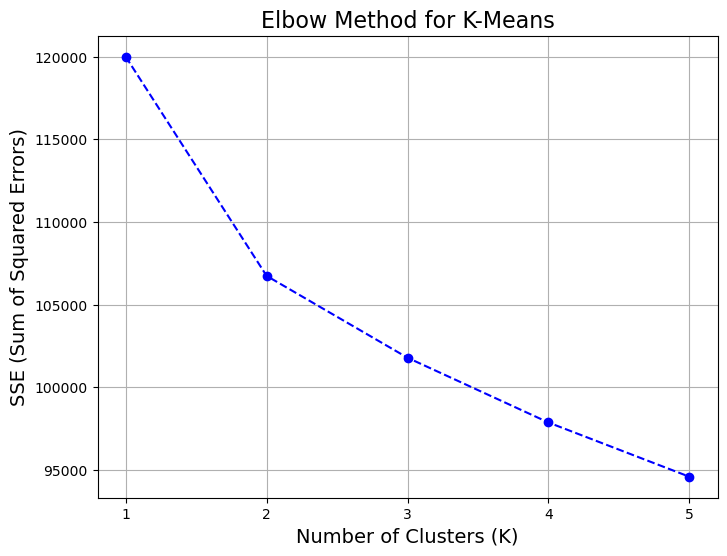

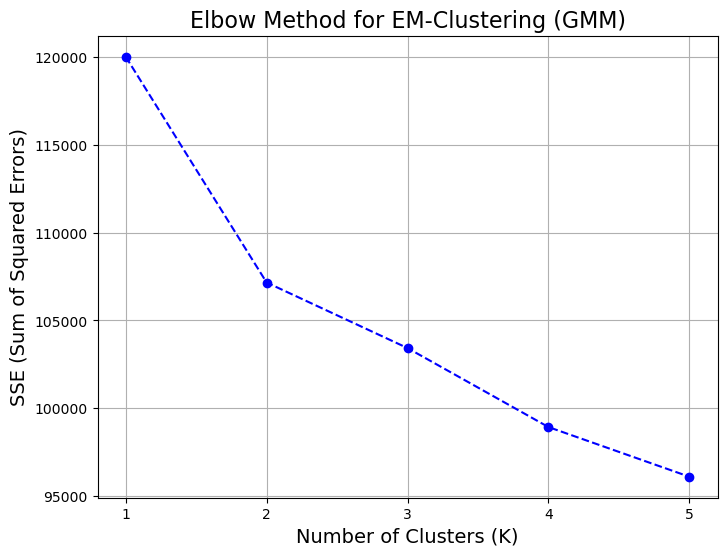

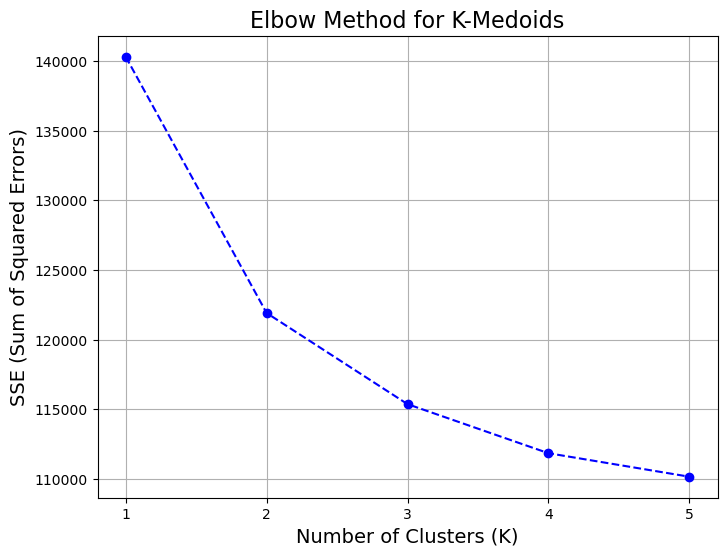

In [59]:
# Determining the optimal number of clusters using the elbow method

max_k = 5

# Elbow plot for K-Means
k_values, sse_values_kmeans = compute_elbow_plot(X_scaled, "kmeans", max_k)
plot_elbow(k_values, sse_values_kmeans, "K-Means")

# Elbow plot for EM-Clustering (GMM)
k_values, sse_values_gmm = compute_elbow_plot(X_scaled, "gmm", max_k)
plot_elbow(k_values, sse_values_gmm, "EM-Clustering (GMM)")

# Elbow plot for K-Medoids
k_values, sse_values_kmedoids = compute_elbow_plot(X_scaled, "kmedoids", max_k)
plot_elbow(k_values, sse_values_kmedoids, "K-Medoids")

In [54]:
# Training the models on original dataset - used values of K as 2, 3 and 4

results_original_2 = clustering_analysis(X_clustering, 2, "./original_clustering_images")
results_original_3 = clustering_analysis(X_clustering, 3, "./original_clustering_images")
results_original_4 = clustering_analysis(X_clustering, 4, "./original_clustering_images")
results_original_all = pd.concat([results_original_2, results_original_3, results_original_4], ignore_index=True)

Cluster plot saved as: ./original_clustering_images/K-Means_clustering_2.png
Cluster plot saved as: ./original_clustering_images/EM-Clustering (GMM)_clustering_2.png
Cluster plot saved as: ./original_clustering_images/K-Medoids_clustering_2.png
Cluster plot saved as: ./original_clustering_images/K-Means_clustering_3.png
Cluster plot saved as: ./original_clustering_images/EM-Clustering (GMM)_clustering_3.png
Cluster plot saved as: ./original_clustering_images/K-Medoids_clustering_3.png
Cluster plot saved as: ./original_clustering_images/K-Means_clustering_4.png
Cluster plot saved as: ./original_clustering_images/EM-Clustering (GMM)_clustering_4.png
Cluster plot saved as: ./original_clustering_images/K-Medoids_clustering_4.png


In [55]:
# Printing the results of clustering analysis on original dataset

print("Clustering Analysis on Original Dataset\n")
print(tabulate(results_original_all, headers="keys", tablefmt="grid"))

Clustering Analysis on Original Dataset

+----+---------------------+-----+--------+--------------+----------------+----------------------+----------+
|    | Model               |   K |    SSE |   Silhouette |   Dunn's Index |   Hubert's Statistic |   BetaCV |
+====+=====================+=====+========+==============+================+======================+==========+
|  0 | K-Means             |   2 | 258575 |     0.174071 |      0.0528059 |            -0.32732  | 0.901214 |
+----+---------------------+-----+--------+--------------+----------------+----------------------+----------+
|  1 | EM-Clustering (GMM) |   2 | 258753 |     0.173733 |      0.0528059 |            -0.326656 | 0.901411 |
+----+---------------------+-----+--------+--------------+----------------+----------------------+----------+
|  2 | K-Medoids           |   2 | 272780 |     0.170901 |      0.0431065 |            -0.321185 | 0.903061 |
+----+---------------------+-----+--------+--------------+----------------+----

In [56]:
# Training the models on scaled dataset - used values of K as 2 and 4

results_scaled_2 = clustering_analysis(X_scaled, 2, "./scaled_clustering_images")
results_scaled_3 = clustering_analysis(X_scaled, 3, "./scaled_clustering_images")
results_scaled_4 = clustering_analysis(X_scaled, 4, "./scaled_clustering_images")
results_scaled_all = pd.concat([results_scaled_2, results_scaled_3, results_scaled_4], ignore_index=True)

Cluster plot saved as: ./scaled_clustering_images/K-Means_clustering_2.png
Cluster plot saved as: ./scaled_clustering_images/EM-Clustering (GMM)_clustering_2.png
Cluster plot saved as: ./scaled_clustering_images/K-Medoids_clustering_2.png
Cluster plot saved as: ./scaled_clustering_images/K-Means_clustering_3.png
Cluster plot saved as: ./scaled_clustering_images/EM-Clustering (GMM)_clustering_3.png
Cluster plot saved as: ./scaled_clustering_images/K-Medoids_clustering_3.png
Cluster plot saved as: ./scaled_clustering_images/K-Means_clustering_4.png
Cluster plot saved as: ./scaled_clustering_images/EM-Clustering (GMM)_clustering_4.png
Cluster plot saved as: ./scaled_clustering_images/K-Medoids_clustering_4.png


In [57]:
# Printing the results of clustering analysis on scaled dataset

print("Clustering Analysis on Scaled Dataset\n")
print(tabulate(results_scaled_all, headers="keys", tablefmt="grid"))

Clustering Analysis on Scaled Dataset

+----+---------------------+-----+----------+--------------+----------------+----------------------+----------+
|    | Model               |   K |      SSE |   Silhouette |   Dunn's Index |   Hubert's Statistic |   BetaCV |
+====+=====================+=====+==========+==============+================+======================+==========+
|  0 | K-Means             |   2 | 106743   |    0.102713  |      0.118567  |            -0.294915 | 0.943777 |
+----+---------------------+-----+----------+--------------+----------------+----------------------+----------+
|  1 | EM-Clustering (GMM) |   2 | 107157   |    0.102127  |      0.120905  |            -0.293209 | 0.944107 |
+----+---------------------+-----+----------+--------------+----------------+----------------------+----------+
|  2 | K-Medoids           |   2 | 121913   |    0.0855774 |      0.0932587 |            -0.242608 | 0.95371  |
+----+---------------------+-----+----------+--------------+-----